In [21]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import os
import json
import sys
import gym
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm

# Get prediction model
from core.model import Model

from GA.ga import GeneticNetworks

from keras.backend.tensorflow_backend import set_session
from keras.utils import to_categorical

from core.market_env_v0 import MarketEnvironmentV0
from core.utils import *
from misc.networks import get_session

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import pathlib
# Import the backtrader platform
import backtrader as bt
import pandas as pd

# Extended classes and function
# from backtesting.extended_pandas_data import ExtendedPandasData
from backtesting.utils import *
from backtesting.base_strategy import BaseStrategy
from core.technical_analysis import add_technical_indicators_with_intervals 

In [22]:
configs = json.load(open('config-EURUSD-30M_v3.0141.json', 'r'))

In [24]:
### MODEL HYPERPARAMETERS
num_cols = configs['agent']['num_cols']

# Here our possible actions
sit = [1, 0, 0]
buy = [0, 1, 0]
sell = [0, 0, 1]
possible_actions = [sit, buy, sell]

action_size = len(possible_actions)              # 3 possible actions: sit, buy, sell
state_size = 15
size = 347

### TRAINING HYPERPARAMETERS
layers = configs['agent']['layers']
population_size = configs['agent']['params']['population_size']
generations = configs['agent']['params']['generations']
episodes = configs['agent']['params']['episodes']
mutation_variance = configs['agent']['params']['mutation_variance']
survival_ratio = configs['agent']['params']['survival_ratio']

gpu = True
gather_stats = True
env_name = configs['agent']['params']['env']
type = 'GA'


### Env
initial_cash = configs['agent']['params']['initial_cash']
close_col = configs['agent']['params']['close_col']
profit_window_size = configs['agent']['params']['profit_window_size']
large_holdings_penalty = configs['agent']['params']['large_holdings_penalty']
lost_all_cash_penalty = configs['agent']['params']['lost_all_cash_penalty']
inaction_penalty = configs['agent']['params']['inaction_penalty']
reward_function =  configs['agent']['params']['reward_function']


### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

start_date = datetime.datetime.strptime(
    configs['backtesting']['start_date'], configs['backtesting']['date_format'])
end_date = datetime.datetime.strptime(
    configs['backtesting']['end_date'], configs['backtesting']['date_format'])
datapath = configs['backtesting']['datapath']

initial_cash = configs['backtesting']['initial_cash']
commission = configs['backtesting']['commission']
cols = configs['agent']['cols']

debug = True
detrend = True

# Backtesting

### Load agent

In [27]:
path = "saved_models/DeepNeuro_Gen_best_100.pkl"

In [28]:
ga = GeneticNetworks(architecture=(state_size, ) + tuple(layers) + (action_size,),
                                population_size=population_size, 
                                generations=generations,
                                episodes=episodes, 
                                mutation_variance=mutation_variance,
                                render_env=False,
                                survival_ratio=survival_ratio,
                                verbose=True)
ga.load_weights(path)
agent = ga.best_network

--------------------------------------------------
Logging params: 
population_size 256
generations 100
mutation_variance 0.005
survival_ratio 0.15
both_parent_percentage 0.4
one_parent_percentage 0.6
episodes 10
max_env_steps 10000
--------------------------------------------------


### Preparation for backtesting

In [29]:
# Add CNN Predictions
from cnn_prediction.cnn_data_loader import CNNDataLoader
from cnn_prediction.cnn_model import CNNModel

# Add LSTM Predictions
model = CNNModel()
model.load_model('saved_models/' + configs['model']['pre_trained_model'])
model.model.load_weights('saved_models/' + configs['model']['pre_trained_weights'])
model.model.summary()

[Model] Loading model from file saved_models/cnn-EURUSD_buy_sell_w10-ep500-2020_06_11.model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
______________________________

In [30]:
cnn_cols = []
for indicator in configs['model']['inputs']['technical_indicators']:
    for interval in configs['model']['inputs']['intervals']:
        cnn_cols.append(indicator + '_' + str(interval))
img_size = len(configs['model']['inputs']['technical_indicators'])

In [31]:
def get_cnn_prediction(x):    
    predictions = model.predict(x, verbose=False)
    return predictions[-1]


In [32]:
from core.technical_analysis import add_technical_indicators_with_intervals

# Get cols
cols = []
# Add detrend OHLC
if detrend:
    for col in [a for a in configs['agent']['cols'] if configs['agent']['cols'][a]["detrend"]]:
        cols.append(col + '_detrend')
    for col in [a for a in configs['agent']['cols'] if not configs['agent']['cols'][a]["detrend"]]:
        cols.append(col)
# Add technical indicators
for indicator in configs['agent']['technical_indicators']:
    for interval in configs['agent']['intervals']:
        cols.append(indicator + '_' + str(interval))

In [33]:
cols

['Close_detrend',
 'Open_detrend',
 'High_detrend',
 'Low_detrend',
 'CNNClassifier_hold',
 'CNNClassifier_buy',
 'CNNClassifier_sell',
 'MACDhist_3',
 'MACDhist_5',
 'MACDhist_9',
 'MACDhist_14',
 'RSI_3',
 'RSI_5',
 'RSI_9',
 'RSI_14']

In [34]:
def prepare_data(info, df_ohlc):
    info = info.reshape((info.shape[0], img_size, img_size))
    for col in [a for a in configs['agent']['cols'] if configs['agent']['cols'][a]["detrend"]]:
        df_ohlc[col + '_detrend'] = df_ohlc.get([col]) - df_ohlc.get([col]).shift()
    
    # Add technical indicators
    df_ohlc = add_technical_indicators_with_intervals(
        df_ohlc, 
        indicators=configs['agent']['technical_indicators'], 
        intervals=configs['agent']['intervals']
    )
    
    df_ohlc = df_ohlc.dropna()

    pred = get_cnn_prediction(np.stack((info,) * 3, axis=-1))
    df_ohlc["CNNClassifier_hold"], df_ohlc["CNNClassifier_buy"], df_ohlc["CNNClassifier_sell"] = np.nan, np.nan, np.nan
    df_ohlc["CNNClassifier_hold"].iloc[-1] = pred[0]
    df_ohlc["CNNClassifier_buy"].iloc[-1] = pred[1]
    df_ohlc["CNNClassifier_sell"].iloc[-1] = pred[2]
    return df_ohlc.get(cols).values[-1]
    

In [35]:
# Create a Strategy
class RLStrategy(BaseStrategy):
    
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.count = 0
        self.last_order = None
        
        self.inventory = []
        self.holdings = 0
        self.cash = initial_cash
        self.portfolio_value = 0
        
    def notify_cashvalue(self, cash, value):
        self.cash = cash
        self.portfolio_value = value - cash
        
    def get_state(self, debug=False):
        info = self.data.get_array_cols(cnn_cols, size)
        state = prepare_data(info, pd.DataFrame({
            'Close': self.data.close.get(size=50),
            'Open': self.data.open.get(size=50),
            'High': self.data.high.get(size=50),
            'Low': self.data.low.get(size=50),
        }))
        
        if debug: print('State: ', state)
        return np.array(state)
    
    def next(self):
        self.count = self.count + 1
        # Simply log the closing price of the series from the reference
        str_close = 'Close, %.5f' % self.dataclose[0]
        str_net = 'Net, %.5f' % (self.cash + self.portfolio_value)
        self.log(str_close + " - " + str_net)
        self.portfolio_value = self.dataclose[0] * self.holdings
        
        # Wait while we are getting information for prediction model
        if (self.count > size):
            # Check if an order is pending ... if yes, we cannot send a 2nd one
            if self.order:
                return
                
                            
            # Predict the action to take and take it
            action = agent.act(self.get_state(debug=debug))
            print("Action: ", action)

            # LONG
            if (action == 1):
                # Close Short
                if sum(self.inventory) < 0:
                    self.log('CLOSE SHORT, %.4f' % self.dataclose[0])
                    self.inventory = []
                    self.holdings = 0
                    self.order = self.close()

                # long
                if self.dataclose[0] < self.cash:
                    self.inventory.insert(0, self.dataclose[0])
                    self.holdings += 1
                    self.log('LONG, %.5f' % self.dataclose[0])
                    self.order = self.buy(size=1)


            # SHORT
            if (action == 2):
                # Close long
                if sum(self.inventory) > 0:
                    self.log('CLOSE LONG, %.5f' % self.dataclose[0])
                    self.inventory = []
                    self.holdings = 0
                    self.order = self.close()
                    
                # Now Short               
                if self.dataclose[0] < initial_cash - abs(self.portfolio_value):
                    self.inventory.insert(0, -self.dataclose[0])
                    self.holdings -= 1
                    self.log('SHORT, %.4f' % self.dataclose[0])
                    self.order = self.sell()
                    
        # Close last position      
        if(len(self.data) == self.data.buflen()):
            print("Ultimo")
            self.close()

In [36]:
import backtrader as bt
import numpy as np

class ExtendedPandasData(bt.feeds.PandasData):

    lines = ("SMA_2","SMA_3","SMA_4","SMA_5","SMA_7","SMA_9","SMA_11","SMA_13","SMA_17","SMA_21","SMA_34","SMA_41","SMA_55","SMA_77","SMA_99","KAMA_2","KAMA_3","KAMA_4","KAMA_5","KAMA_7","KAMA_9","KAMA_11","KAMA_13","KAMA_17","KAMA_21","KAMA_34","KAMA_41","KAMA_55","KAMA_77","KAMA_99","MIDPRICE_2","MIDPRICE_3","MIDPRICE_4","MIDPRICE_5","MIDPRICE_7","MIDPRICE_9","MIDPRICE_11","MIDPRICE_13","MIDPRICE_17","MIDPRICE_21","MIDPRICE_34","MIDPRICE_41","MIDPRICE_55","MIDPRICE_77","MIDPRICE_99","EMA_2","EMA_3","EMA_4","EMA_5","EMA_7","EMA_9","EMA_11","EMA_13","EMA_17","EMA_21","EMA_34","EMA_41","EMA_55","EMA_77","EMA_99","WMA_2","WMA_3","WMA_4","WMA_5","WMA_7","WMA_9","WMA_11","WMA_13","WMA_17","WMA_21","WMA_34","WMA_41","WMA_55","WMA_77","WMA_99","MOM_2","MOM_3","MOM_4","MOM_5","MOM_7","MOM_9","MOM_11","MOM_13","MOM_17","MOM_21","MOM_34","MOM_41","MOM_55","MOM_77","MOM_99","ROCP_2","ROCP_3","ROCP_4","ROCP_5","ROCP_7","ROCP_9","ROCP_11","ROCP_13","ROCP_17","ROCP_21","ROCP_34","ROCP_41","ROCP_55","ROCP_77","ROCP_99","TRIX_2","TRIX_3","TRIX_4","TRIX_5","TRIX_7","TRIX_9","TRIX_11","TRIX_13","TRIX_17","TRIX_21","TRIX_34","TRIX_41","TRIX_55","TRIX_77","TRIX_99","ATR_2","ATR_3","ATR_4","ATR_5","ATR_7","ATR_9","ATR_11","ATR_13","ATR_17","ATR_21","ATR_34","ATR_41","ATR_55","ATR_77","ATR_99","RSI_2","RSI_3","RSI_4","RSI_5","RSI_7","RSI_9","RSI_11","RSI_13","RSI_17","RSI_21","RSI_34","RSI_41","RSI_55","RSI_77","RSI_99","ADX_2","ADX_3","ADX_4","ADX_5","ADX_7","ADX_9","ADX_11","ADX_13","ADX_17","ADX_21","ADX_34","ADX_41","ADX_55","ADX_77","ADX_99","CCI_2","CCI_3","CCI_4","CCI_5","CCI_7","CCI_9","CCI_11","CCI_13","CCI_17","CCI_21","CCI_34","CCI_41","CCI_55","CCI_77","CCI_99","WILLR_2","WILLR_3","WILLR_4","WILLR_5","WILLR_7","WILLR_9","WILLR_11","WILLR_13","WILLR_17","WILLR_21","WILLR_34","WILLR_41","WILLR_55","WILLR_77","WILLR_99","CMO_2","CMO_3","CMO_4","CMO_5","CMO_7","CMO_9","CMO_11","CMO_13","CMO_17","CMO_21","CMO_34","CMO_41","CMO_55","CMO_77","CMO_99","AROONOSC_2","AROONOSC_3","AROONOSC_4","AROONOSC_5","AROONOSC_7","AROONOSC_9","AROONOSC_11","AROONOSC_13","AROONOSC_17","AROONOSC_21","AROONOSC_34","AROONOSC_41","AROONOSC_55","AROONOSC_77","AROONOSC_99")
    
    params = (("SMA_2", "SMA_2"),("SMA_3", "SMA_3"),("SMA_4", "SMA_4"),("SMA_5", "SMA_5"),("SMA_7", "SMA_7"),("SMA_9", "SMA_9"),("SMA_11", "SMA_11"),("SMA_13", "SMA_13"),("SMA_17", "SMA_17"),("SMA_21", "SMA_21"),("SMA_34", "SMA_34"),("SMA_41", "SMA_41"),("SMA_55", "SMA_55"),("SMA_77", "SMA_77"),("SMA_99", "SMA_99"),("KAMA_2", "KAMA_2"),("KAMA_3", "KAMA_3"),("KAMA_4", "KAMA_4"),("KAMA_5", "KAMA_5"),("KAMA_7", "KAMA_7"),("KAMA_9", "KAMA_9"),("KAMA_11", "KAMA_11"),("KAMA_13", "KAMA_13"),("KAMA_17", "KAMA_17"),("KAMA_21", "KAMA_21"),("KAMA_34", "KAMA_34"),("KAMA_41", "KAMA_41"),("KAMA_55", "KAMA_55"),("KAMA_77", "KAMA_77"),("KAMA_99", "KAMA_99"),("MIDPRICE_2", "MIDPRICE_2"),("MIDPRICE_3", "MIDPRICE_3"),("MIDPRICE_4", "MIDPRICE_4"),("MIDPRICE_5", "MIDPRICE_5"),("MIDPRICE_7", "MIDPRICE_7"),("MIDPRICE_9", "MIDPRICE_9"),("MIDPRICE_11", "MIDPRICE_11"),("MIDPRICE_13", "MIDPRICE_13"),("MIDPRICE_17", "MIDPRICE_17"),("MIDPRICE_21", "MIDPRICE_21"),("MIDPRICE_34", "MIDPRICE_34"),("MIDPRICE_41", "MIDPRICE_41"),("MIDPRICE_55", "MIDPRICE_55"),("MIDPRICE_77", "MIDPRICE_77"),("MIDPRICE_99", "MIDPRICE_99"),("EMA_2", "EMA_2"),("EMA_3", "EMA_3"),("EMA_4", "EMA_4"),("EMA_5", "EMA_5"),("EMA_7", "EMA_7"),("EMA_9", "EMA_9"),("EMA_11", "EMA_11"),("EMA_13", "EMA_13"),("EMA_17", "EMA_17"),("EMA_21", "EMA_21"),("EMA_34", "EMA_34"),("EMA_41", "EMA_41"),("EMA_55", "EMA_55"),("EMA_77", "EMA_77"),("EMA_99", "EMA_99"),("WMA_2", "WMA_2"),("WMA_3", "WMA_3"),("WMA_4", "WMA_4"),("WMA_5", "WMA_5"),("WMA_7", "WMA_7"),("WMA_9", "WMA_9"),("WMA_11", "WMA_11"),("WMA_13", "WMA_13"),("WMA_17", "WMA_17"),("WMA_21", "WMA_21"),("WMA_34", "WMA_34"),("WMA_41", "WMA_41"),("WMA_55", "WMA_55"),("WMA_77", "WMA_77"),("WMA_99", "WMA_99"),("MOM_2", "MOM_2"),("MOM_3", "MOM_3"),("MOM_4", "MOM_4"),("MOM_5", "MOM_5"),("MOM_7", "MOM_7"),("MOM_9", "MOM_9"),("MOM_11", "MOM_11"),("MOM_13", "MOM_13"),("MOM_17", "MOM_17"),("MOM_21", "MOM_21"),("MOM_34", "MOM_34"),("MOM_41", "MOM_41"),("MOM_55", "MOM_55"),("MOM_77", "MOM_77"),("MOM_99", "MOM_99"),("ROCP_2", "ROCP_2"),("ROCP_3", "ROCP_3"),("ROCP_4", "ROCP_4"),("ROCP_5", "ROCP_5"),("ROCP_7", "ROCP_7"),("ROCP_9", "ROCP_9"),("ROCP_11", "ROCP_11"),("ROCP_13", "ROCP_13"),("ROCP_17", "ROCP_17"),("ROCP_21", "ROCP_21"),("ROCP_34", "ROCP_34"),("ROCP_41", "ROCP_41"),("ROCP_55", "ROCP_55"),("ROCP_77", "ROCP_77"),("ROCP_99", "ROCP_99"),("TRIX_2", "TRIX_2"),("TRIX_3", "TRIX_3"),("TRIX_4", "TRIX_4"),("TRIX_5", "TRIX_5"),("TRIX_7", "TRIX_7"),("TRIX_9", "TRIX_9"),("TRIX_11", "TRIX_11"),("TRIX_13", "TRIX_13"),("TRIX_17", "TRIX_17"),("TRIX_21", "TRIX_21"),("TRIX_34", "TRIX_34"),("TRIX_41", "TRIX_41"),("TRIX_55", "TRIX_55"),("TRIX_77", "TRIX_77"),("TRIX_99", "TRIX_99"),("ATR_2", "ATR_2"),("ATR_3", "ATR_3"),("ATR_4", "ATR_4"),("ATR_5", "ATR_5"),("ATR_7", "ATR_7"),("ATR_9", "ATR_9"),("ATR_11", "ATR_11"),("ATR_13", "ATR_13"),("ATR_17", "ATR_17"),("ATR_21", "ATR_21"),("ATR_34", "ATR_34"),("ATR_41", "ATR_41"),("ATR_55", "ATR_55"),("ATR_77", "ATR_77"),("ATR_99", "ATR_99"),("RSI_2", "RSI_2"),("RSI_3", "RSI_3"),("RSI_4", "RSI_4"),("RSI_5", "RSI_5"),("RSI_7", "RSI_7"),("RSI_9", "RSI_9"),("RSI_11", "RSI_11"),("RSI_13", "RSI_13"),("RSI_17", "RSI_17"),("RSI_21", "RSI_21"),("RSI_34", "RSI_34"),("RSI_41", "RSI_41"),("RSI_55", "RSI_55"),("RSI_77", "RSI_77"),("RSI_99", "RSI_99"),("ADX_2", "ADX_2"),("ADX_3", "ADX_3"),("ADX_4", "ADX_4"),("ADX_5", "ADX_5"),("ADX_7", "ADX_7"),("ADX_9", "ADX_9"),("ADX_11", "ADX_11"),("ADX_13", "ADX_13"),("ADX_17", "ADX_17"),("ADX_21", "ADX_21"),("ADX_34", "ADX_34"),("ADX_41", "ADX_41"),("ADX_55", "ADX_55"),("ADX_77", "ADX_77"),("ADX_99", "ADX_99"),("CCI_2", "CCI_2"),("CCI_3", "CCI_3"),("CCI_4", "CCI_4"),("CCI_5", "CCI_5"),("CCI_7", "CCI_7"),("CCI_9", "CCI_9"),("CCI_11", "CCI_11"),("CCI_13", "CCI_13"),("CCI_17", "CCI_17"),("CCI_21", "CCI_21"),("CCI_34", "CCI_34"),("CCI_41", "CCI_41"),("CCI_55", "CCI_55"),("CCI_77", "CCI_77"),("CCI_99", "CCI_99"),("WILLR_2", "WILLR_2"),("WILLR_3", "WILLR_3"),("WILLR_4", "WILLR_4"),("WILLR_5", "WILLR_5"),("WILLR_7", "WILLR_7"),("WILLR_9", "WILLR_9"),("WILLR_11", "WILLR_11"),("WILLR_13", "WILLR_13"),("WILLR_17", "WILLR_17"),("WILLR_21", "WILLR_21"),("WILLR_34", "WILLR_34"),("WILLR_41", "WILLR_41"),("WILLR_55", "WILLR_55"),("WILLR_77", "WILLR_77"),("WILLR_99", "WILLR_99"),("CMO_2", "CMO_2"),("CMO_3", "CMO_3"),("CMO_4", "CMO_4"),("CMO_5", "CMO_5"),("CMO_7", "CMO_7"),("CMO_9", "CMO_9"),("CMO_11", "CMO_11"),("CMO_13", "CMO_13"),("CMO_17", "CMO_17"),("CMO_21", "CMO_21"),("CMO_34", "CMO_34"),("CMO_41", "CMO_41"),("CMO_55", "CMO_55"),("CMO_77", "CMO_77"),("CMO_99", "CMO_99"),("AROONOSC_2", "AROONOSC_2"),("AROONOSC_3", "AROONOSC_3"),("AROONOSC_4", "AROONOSC_4"),("AROONOSC_5", "AROONOSC_5"),("AROONOSC_7", "AROONOSC_7"),("AROONOSC_9", "AROONOSC_9"),("AROONOSC_11", "AROONOSC_11"),("AROONOSC_13", "AROONOSC_13"),("AROONOSC_17", "AROONOSC_17"),("AROONOSC_21", "AROONOSC_21"),("AROONOSC_34", "AROONOSC_34"),("AROONOSC_41", "AROONOSC_41"),("AROONOSC_55", "AROONOSC_55"),("AROONOSC_77", "AROONOSC_77"),("AROONOSC_99", "AROONOSC_99"))
    
    def get_array_cols(self, cols, size):
        info = np.zeros((size, len(cols)))
        for i in range(0, len(cols)):
            col = cols[i]
            if col == "Close": info[:, i] = self.close.get(size=size)
            elif col == "Open": info[:, i] = self.open.get(size=size)
            elif col == "High": info[:, i] = self.high.get(size=size)
            elif col == "Low": info[:, i] = self.low.get(size=size)
            elif col == "Volume": info[:, i] = self.volume.get(size=size) 
            elif col == "SMA_2": info[:, i] = self.SMA_2.get(size=size)
            elif col == "SMA_3": info[:, i] = self.SMA_3.get(size=size)
            elif col == "SMA_4": info[:, i] = self.SMA_4.get(size=size)
            elif col == "SMA_5": info[:, i] = self.SMA_5.get(size=size)
            elif col == "SMA_7": info[:, i] = self.SMA_7.get(size=size)
            elif col == "SMA_9": info[:, i] = self.SMA_9.get(size=size)
            elif col == "SMA_11": info[:, i] = self.SMA_11.get(size=size)
            elif col == "SMA_13": info[:, i] = self.SMA_13.get(size=size)
            elif col == "SMA_17": info[:, i] = self.SMA_17.get(size=size)
            elif col == "SMA_21": info[:, i] = self.SMA_21.get(size=size)
            elif col == "SMA_34": info[:, i] = self.SMA_34.get(size=size)
            elif col == "SMA_41": info[:, i] = self.SMA_41.get(size=size)
            elif col == "SMA_55": info[:, i] = self.SMA_55.get(size=size)
            elif col == "SMA_77": info[:, i] = self.SMA_77.get(size=size)
            elif col == "SMA_99": info[:, i] = self.SMA_99.get(size=size)
            elif col == "KAMA_2": info[:, i] = self.KAMA_2.get(size=size)
            elif col == "KAMA_3": info[:, i] = self.KAMA_3.get(size=size)
            elif col == "KAMA_4": info[:, i] = self.KAMA_4.get(size=size)
            elif col == "KAMA_5": info[:, i] = self.KAMA_5.get(size=size)
            elif col == "KAMA_7": info[:, i] = self.KAMA_7.get(size=size)
            elif col == "KAMA_9": info[:, i] = self.KAMA_9.get(size=size)
            elif col == "KAMA_11": info[:, i] = self.KAMA_11.get(size=size)
            elif col == "KAMA_13": info[:, i] = self.KAMA_13.get(size=size)
            elif col == "KAMA_17": info[:, i] = self.KAMA_17.get(size=size)
            elif col == "KAMA_21": info[:, i] = self.KAMA_21.get(size=size)
            elif col == "KAMA_34": info[:, i] = self.KAMA_34.get(size=size)
            elif col == "KAMA_41": info[:, i] = self.KAMA_41.get(size=size)
            elif col == "KAMA_55": info[:, i] = self.KAMA_55.get(size=size)
            elif col == "KAMA_77": info[:, i] = self.KAMA_77.get(size=size)
            elif col == "KAMA_99": info[:, i] = self.KAMA_99.get(size=size)
            elif col == "MIDPRICE_2": info[:, i] = self.MIDPRICE_2.get(size=size)
            elif col == "MIDPRICE_3": info[:, i] = self.MIDPRICE_3.get(size=size)
            elif col == "MIDPRICE_4": info[:, i] = self.MIDPRICE_4.get(size=size)
            elif col == "MIDPRICE_5": info[:, i] = self.MIDPRICE_5.get(size=size)
            elif col == "MIDPRICE_7": info[:, i] = self.MIDPRICE_7.get(size=size)
            elif col == "MIDPRICE_9": info[:, i] = self.MIDPRICE_9.get(size=size)
            elif col == "MIDPRICE_11": info[:, i] = self.MIDPRICE_11.get(size=size)
            elif col == "MIDPRICE_13": info[:, i] = self.MIDPRICE_13.get(size=size)
            elif col == "MIDPRICE_17": info[:, i] = self.MIDPRICE_17.get(size=size)
            elif col == "MIDPRICE_21": info[:, i] = self.MIDPRICE_21.get(size=size)
            elif col == "MIDPRICE_34": info[:, i] = self.MIDPRICE_34.get(size=size)
            elif col == "MIDPRICE_41": info[:, i] = self.MIDPRICE_41.get(size=size)
            elif col == "MIDPRICE_55": info[:, i] = self.MIDPRICE_55.get(size=size)
            elif col == "MIDPRICE_77": info[:, i] = self.MIDPRICE_77.get(size=size)
            elif col == "MIDPRICE_99": info[:, i] = self.MIDPRICE_99.get(size=size)
            elif col == "EMA_2": info[:, i] = self.EMA_2.get(size=size)
            elif col == "EMA_3": info[:, i] = self.EMA_3.get(size=size)
            elif col == "EMA_4": info[:, i] = self.EMA_4.get(size=size)
            elif col == "EMA_5": info[:, i] = self.EMA_5.get(size=size)
            elif col == "EMA_7": info[:, i] = self.EMA_7.get(size=size)
            elif col == "EMA_9": info[:, i] = self.EMA_9.get(size=size)
            elif col == "EMA_11": info[:, i] = self.EMA_11.get(size=size)
            elif col == "EMA_13": info[:, i] = self.EMA_13.get(size=size)
            elif col == "EMA_17": info[:, i] = self.EMA_17.get(size=size)
            elif col == "EMA_21": info[:, i] = self.EMA_21.get(size=size)
            elif col == "EMA_34": info[:, i] = self.EMA_34.get(size=size)
            elif col == "EMA_41": info[:, i] = self.EMA_41.get(size=size)
            elif col == "EMA_55": info[:, i] = self.EMA_55.get(size=size)
            elif col == "EMA_77": info[:, i] = self.EMA_77.get(size=size)
            elif col == "EMA_99": info[:, i] = self.EMA_99.get(size=size)
            elif col == "WMA_2": info[:, i] = self.WMA_2.get(size=size)
            elif col == "WMA_3": info[:, i] = self.WMA_3.get(size=size)
            elif col == "WMA_4": info[:, i] = self.WMA_4.get(size=size)
            elif col == "WMA_5": info[:, i] = self.WMA_5.get(size=size)
            elif col == "WMA_7": info[:, i] = self.WMA_7.get(size=size)
            elif col == "WMA_9": info[:, i] = self.WMA_9.get(size=size)
            elif col == "WMA_11": info[:, i] = self.WMA_11.get(size=size)
            elif col == "WMA_13": info[:, i] = self.WMA_13.get(size=size)
            elif col == "WMA_17": info[:, i] = self.WMA_17.get(size=size)
            elif col == "WMA_21": info[:, i] = self.WMA_21.get(size=size)
            elif col == "WMA_34": info[:, i] = self.WMA_34.get(size=size)
            elif col == "WMA_41": info[:, i] = self.WMA_41.get(size=size)
            elif col == "WMA_55": info[:, i] = self.WMA_55.get(size=size)
            elif col == "WMA_77": info[:, i] = self.WMA_77.get(size=size)
            elif col == "WMA_99": info[:, i] = self.WMA_99.get(size=size)
            elif col == "MOM_2": info[:, i] = self.MOM_2.get(size=size)
            elif col == "MOM_3": info[:, i] = self.MOM_3.get(size=size)
            elif col == "MOM_4": info[:, i] = self.MOM_4.get(size=size)
            elif col == "MOM_5": info[:, i] = self.MOM_5.get(size=size)
            elif col == "MOM_7": info[:, i] = self.MOM_7.get(size=size)
            elif col == "MOM_9": info[:, i] = self.MOM_9.get(size=size)
            elif col == "MOM_11": info[:, i] = self.MOM_11.get(size=size)
            elif col == "MOM_13": info[:, i] = self.MOM_13.get(size=size)
            elif col == "MOM_17": info[:, i] = self.MOM_17.get(size=size)
            elif col == "MOM_21": info[:, i] = self.MOM_21.get(size=size)
            elif col == "MOM_34": info[:, i] = self.MOM_34.get(size=size)
            elif col == "MOM_41": info[:, i] = self.MOM_41.get(size=size)
            elif col == "MOM_55": info[:, i] = self.MOM_55.get(size=size)
            elif col == "MOM_77": info[:, i] = self.MOM_77.get(size=size)
            elif col == "MOM_99": info[:, i] = self.MOM_99.get(size=size)
            elif col == "ROCP_2": info[:, i] = self.ROCP_2.get(size=size)
            elif col == "ROCP_3": info[:, i] = self.ROCP_3.get(size=size)
            elif col == "ROCP_4": info[:, i] = self.ROCP_4.get(size=size)
            elif col == "ROCP_5": info[:, i] = self.ROCP_5.get(size=size)
            elif col == "ROCP_7": info[:, i] = self.ROCP_7.get(size=size)
            elif col == "ROCP_9": info[:, i] = self.ROCP_9.get(size=size)
            elif col == "ROCP_11": info[:, i] = self.ROCP_11.get(size=size)
            elif col == "ROCP_13": info[:, i] = self.ROCP_13.get(size=size)
            elif col == "ROCP_17": info[:, i] = self.ROCP_17.get(size=size)
            elif col == "ROCP_21": info[:, i] = self.ROCP_21.get(size=size)
            elif col == "ROCP_34": info[:, i] = self.ROCP_34.get(size=size)
            elif col == "ROCP_41": info[:, i] = self.ROCP_41.get(size=size)
            elif col == "ROCP_55": info[:, i] = self.ROCP_55.get(size=size)
            elif col == "ROCP_77": info[:, i] = self.ROCP_77.get(size=size)
            elif col == "ROCP_99": info[:, i] = self.ROCP_99.get(size=size)
            elif col == "TRIX_2": info[:, i] = self.TRIX_2.get(size=size)
            elif col == "TRIX_3": info[:, i] = self.TRIX_3.get(size=size)
            elif col == "TRIX_4": info[:, i] = self.TRIX_4.get(size=size)
            elif col == "TRIX_5": info[:, i] = self.TRIX_5.get(size=size)
            elif col == "TRIX_7": info[:, i] = self.TRIX_7.get(size=size)
            elif col == "TRIX_9": info[:, i] = self.TRIX_9.get(size=size)
            elif col == "TRIX_11": info[:, i] = self.TRIX_11.get(size=size)
            elif col == "TRIX_13": info[:, i] = self.TRIX_13.get(size=size)
            elif col == "TRIX_17": info[:, i] = self.TRIX_17.get(size=size)
            elif col == "TRIX_21": info[:, i] = self.TRIX_21.get(size=size)
            elif col == "TRIX_34": info[:, i] = self.TRIX_34.get(size=size)
            elif col == "TRIX_41": info[:, i] = self.TRIX_41.get(size=size)
            elif col == "TRIX_55": info[:, i] = self.TRIX_55.get(size=size)
            elif col == "TRIX_77": info[:, i] = self.TRIX_77.get(size=size)
            elif col == "TRIX_99": info[:, i] = self.TRIX_99.get(size=size)
            elif col == "ATR_2": info[:, i] = self.ATR_2.get(size=size)
            elif col == "ATR_3": info[:, i] = self.ATR_3.get(size=size)
            elif col == "ATR_4": info[:, i] = self.ATR_4.get(size=size)
            elif col == "ATR_5": info[:, i] = self.ATR_5.get(size=size)
            elif col == "ATR_7": info[:, i] = self.ATR_7.get(size=size)
            elif col == "ATR_9": info[:, i] = self.ATR_9.get(size=size)
            elif col == "ATR_11": info[:, i] = self.ATR_11.get(size=size)
            elif col == "ATR_13": info[:, i] = self.ATR_13.get(size=size)
            elif col == "ATR_17": info[:, i] = self.ATR_17.get(size=size)
            elif col == "ATR_21": info[:, i] = self.ATR_21.get(size=size)
            elif col == "ATR_34": info[:, i] = self.ATR_34.get(size=size)
            elif col == "ATR_41": info[:, i] = self.ATR_41.get(size=size)
            elif col == "ATR_55": info[:, i] = self.ATR_55.get(size=size)
            elif col == "ATR_77": info[:, i] = self.ATR_77.get(size=size)
            elif col == "ATR_99": info[:, i] = self.ATR_99.get(size=size)
            elif col == "RSI_2": info[:, i] = self.RSI_2.get(size=size)
            elif col == "RSI_3": info[:, i] = self.RSI_3.get(size=size)
            elif col == "RSI_4": info[:, i] = self.RSI_4.get(size=size)
            elif col == "RSI_5": info[:, i] = self.RSI_5.get(size=size)
            elif col == "RSI_7": info[:, i] = self.RSI_7.get(size=size)
            elif col == "RSI_9": info[:, i] = self.RSI_9.get(size=size)
            elif col == "RSI_11": info[:, i] = self.RSI_11.get(size=size)
            elif col == "RSI_13": info[:, i] = self.RSI_13.get(size=size)
            elif col == "RSI_17": info[:, i] = self.RSI_17.get(size=size)
            elif col == "RSI_21": info[:, i] = self.RSI_21.get(size=size)
            elif col == "RSI_34": info[:, i] = self.RSI_34.get(size=size)
            elif col == "RSI_41": info[:, i] = self.RSI_41.get(size=size)
            elif col == "RSI_55": info[:, i] = self.RSI_55.get(size=size)
            elif col == "RSI_77": info[:, i] = self.RSI_77.get(size=size)
            elif col == "RSI_99": info[:, i] = self.RSI_99.get(size=size)
            elif col == "ADX_2": info[:, i] = self.ADX_2.get(size=size)
            elif col == "ADX_3": info[:, i] = self.ADX_3.get(size=size)
            elif col == "ADX_4": info[:, i] = self.ADX_4.get(size=size)
            elif col == "ADX_5": info[:, i] = self.ADX_5.get(size=size)
            elif col == "ADX_7": info[:, i] = self.ADX_7.get(size=size)
            elif col == "ADX_9": info[:, i] = self.ADX_9.get(size=size)
            elif col == "ADX_11": info[:, i] = self.ADX_11.get(size=size)
            elif col == "ADX_13": info[:, i] = self.ADX_13.get(size=size)
            elif col == "ADX_17": info[:, i] = self.ADX_17.get(size=size)
            elif col == "ADX_21": info[:, i] = self.ADX_21.get(size=size)
            elif col == "ADX_34": info[:, i] = self.ADX_34.get(size=size)
            elif col == "ADX_41": info[:, i] = self.ADX_41.get(size=size)
            elif col == "ADX_55": info[:, i] = self.ADX_55.get(size=size)
            elif col == "ADX_77": info[:, i] = self.ADX_77.get(size=size)
            elif col == "ADX_99": info[:, i] = self.ADX_99.get(size=size)
            elif col == "CCI_2": info[:, i] = self.CCI_2.get(size=size)
            elif col == "CCI_3": info[:, i] = self.CCI_3.get(size=size)
            elif col == "CCI_4": info[:, i] = self.CCI_4.get(size=size)
            elif col == "CCI_5": info[:, i] = self.CCI_5.get(size=size)
            elif col == "CCI_7": info[:, i] = self.CCI_7.get(size=size)
            elif col == "CCI_9": info[:, i] = self.CCI_9.get(size=size)
            elif col == "CCI_11": info[:, i] = self.CCI_11.get(size=size)
            elif col == "CCI_13": info[:, i] = self.CCI_13.get(size=size)
            elif col == "CCI_17": info[:, i] = self.CCI_17.get(size=size)
            elif col == "CCI_21": info[:, i] = self.CCI_21.get(size=size)
            elif col == "CCI_34": info[:, i] = self.CCI_34.get(size=size)
            elif col == "CCI_41": info[:, i] = self.CCI_41.get(size=size)
            elif col == "CCI_55": info[:, i] = self.CCI_55.get(size=size)
            elif col == "CCI_77": info[:, i] = self.CCI_77.get(size=size)
            elif col == "CCI_99": info[:, i] = self.CCI_99.get(size=size)
            elif col == "WILLR_2": info[:, i] = self.WILLR_2.get(size=size)
            elif col == "WILLR_3": info[:, i] = self.WILLR_3.get(size=size)
            elif col == "WILLR_4": info[:, i] = self.WILLR_4.get(size=size)
            elif col == "WILLR_5": info[:, i] = self.WILLR_5.get(size=size)
            elif col == "WILLR_7": info[:, i] = self.WILLR_7.get(size=size)
            elif col == "WILLR_9": info[:, i] = self.WILLR_9.get(size=size)
            elif col == "WILLR_11": info[:, i] = self.WILLR_11.get(size=size)
            elif col == "WILLR_13": info[:, i] = self.WILLR_13.get(size=size)
            elif col == "WILLR_17": info[:, i] = self.WILLR_17.get(size=size)
            elif col == "WILLR_21": info[:, i] = self.WILLR_21.get(size=size)
            elif col == "WILLR_34": info[:, i] = self.WILLR_34.get(size=size)
            elif col == "WILLR_41": info[:, i] = self.WILLR_41.get(size=size)
            elif col == "WILLR_55": info[:, i] = self.WILLR_55.get(size=size)
            elif col == "WILLR_77": info[:, i] = self.WILLR_77.get(size=size)
            elif col == "WILLR_99": info[:, i] = self.WILLR_99.get(size=size)
            elif col == "CMO_2": info[:, i] = self.CMO_2.get(size=size)
            elif col == "CMO_3": info[:, i] = self.CMO_3.get(size=size)
            elif col == "CMO_4": info[:, i] = self.CMO_4.get(size=size)
            elif col == "CMO_5": info[:, i] = self.CMO_5.get(size=size)
            elif col == "CMO_7": info[:, i] = self.CMO_7.get(size=size)
            elif col == "CMO_9": info[:, i] = self.CMO_9.get(size=size)
            elif col == "CMO_11": info[:, i] = self.CMO_11.get(size=size)
            elif col == "CMO_13": info[:, i] = self.CMO_13.get(size=size)
            elif col == "CMO_17": info[:, i] = self.CMO_17.get(size=size)
            elif col == "CMO_21": info[:, i] = self.CMO_21.get(size=size)
            elif col == "CMO_34": info[:, i] = self.CMO_34.get(size=size)
            elif col == "CMO_41": info[:, i] = self.CMO_41.get(size=size)
            elif col == "CMO_55": info[:, i] = self.CMO_55.get(size=size)
            elif col == "CMO_77": info[:, i] = self.CMO_77.get(size=size)
            elif col == "CMO_99": info[:, i] = self.CMO_99.get(size=size)
            elif col == "AROONOSC_2": info[:, i] = self.AROONOSC_2.get(size=size)
            elif col == "AROONOSC_3": info[:, i] = self.AROONOSC_3.get(size=size)
            elif col == "AROONOSC_4": info[:, i] = self.AROONOSC_4.get(size=size)
            elif col == "AROONOSC_5": info[:, i] = self.AROONOSC_5.get(size=size)
            elif col == "AROONOSC_7": info[:, i] = self.AROONOSC_7.get(size=size)
            elif col == "AROONOSC_9": info[:, i] = self.AROONOSC_9.get(size=size)
            elif col == "AROONOSC_11": info[:, i] = self.AROONOSC_11.get(size=size)
            elif col == "AROONOSC_13": info[:, i] = self.AROONOSC_13.get(size=size)
            elif col == "AROONOSC_17": info[:, i] = self.AROONOSC_17.get(size=size)
            elif col == "AROONOSC_21": info[:, i] = self.AROONOSC_21.get(size=size)
            elif col == "AROONOSC_34": info[:, i] = self.AROONOSC_34.get(size=size)
            elif col == "AROONOSC_41": info[:, i] = self.AROONOSC_41.get(size=size)
            elif col == "AROONOSC_55": info[:, i] = self.AROONOSC_55.get(size=size)
            elif col == "AROONOSC_77": info[:, i] = self.AROONOSC_77.get(size=size)
            elif col == "AROONOSC_99": info[:, i] = self.AROONOSC_99.get(size=size)
        return info
        

In [37]:
# Create a cerebro entity
cerebro = bt.Cerebro(cheat_on_open=True, stdstats=False)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

# Add a strategy
cerebro.addstrategy(RLStrategy)

# Add analyzer
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanalysis')
cerebro.addanalyzer(bt.analyzers.Returns, _name='myreturnanalysis')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='myddanalysis')
cerebro.addanalyzer(bt.analyzers.SQN, _name='mysqnanalysis')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysranalysis')
cerebro.addanalyzer(bt.analyzers.Calmar, _name='mycalmaranalysis')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='mypyanalysis')

my_date_parse = lambda x: pd.datetime.strptime(x, configs['backtesting']['date_format'])
dataframe = pd.read_csv(
    datapath, 
    parse_dates=[configs['backtesting']['date_col_name']], 
    index_col=0, 
    date_parser=my_date_parse
).sort_index()


dataframe = add_technical_indicators_with_intervals(
    dataframe, 
    indicators=configs['model']['inputs']['technical_indicators'], 
    intervals=configs['model']['inputs']['intervals']
)

data = ExtendedPandasData(
    dataname=dataframe[
        start_date.strftime(configs['backtesting']['date_format']) :
        end_date.strftime(configs['backtesting']['date_format'])
    ],
    open="Open",
    high="High",
    low="Low",
    close="Close",
    volume="Volume"
)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(initial_cash)
cerebro.broker.set_coo(True)

# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
thestrats = cerebro.run()

Starting Portfolio Value: 5.00
2004-01-01, Close, 1.25600 - Net, 5.00000
2004-01-02, Close, 1.25890 - Net, 5.00000
2004-01-05, Close, 1.26760 - Net, 5.00000
2004-01-06, Close, 1.27260 - Net, 5.00000
2004-01-07, Close, 1.26230 - Net, 5.00000
2004-01-08, Close, 1.27680 - Net, 5.00000
2004-01-09, Close, 1.28120 - Net, 5.00000
2004-01-12, Close, 1.27330 - Net, 5.00000
2004-01-13, Close, 1.27690 - Net, 5.00000
2004-01-14, Close, 1.26450 - Net, 5.00000
2004-01-15, Close, 1.25870 - Net, 5.00000
2004-01-16, Close, 1.23930 - Net, 5.00000
2004-01-19, Close, 1.23520 - Net, 5.00000
2004-01-20, Close, 1.25890 - Net, 5.00000
2004-01-21, Close, 1.26340 - Net, 5.00000
2004-01-22, Close, 1.27330 - Net, 5.00000
2004-01-23, Close, 1.25770 - Net, 5.00000
2004-01-26, Close, 1.24670 - Net, 5.00000
2004-01-27, Close, 1.26440 - Net, 5.00000
2004-01-28, Close, 1.24210 - Net, 5.00000
2004-01-29, Close, 1.24070 - Net, 5.00000
2004-01-30, Close, 1.24740 - Net, 5.00000
2004-02-02, Close, 1.24390 - Net, 5.00000
200

2004-11-12, Close, 1.29790 - Net, 5.00000
2004-11-15, Close, 1.29430 - Net, 5.00000
2004-11-16, Close, 1.29530 - Net, 5.00000
2004-11-17, Close, 1.30290 - Net, 5.00000
2004-11-18, Close, 1.29580 - Net, 5.00000
2004-11-19, Close, 1.30150 - Net, 5.00000
2004-11-22, Close, 1.30420 - Net, 5.00000
2004-11-23, Close, 1.30840 - Net, 5.00000
2004-11-24, Close, 1.31840 - Net, 5.00000
2004-11-25, Close, 1.32730 - Net, 5.00000
2004-11-26, Close, 1.32930 - Net, 5.00000
2004-11-29, Close, 1.32740 - Net, 5.00000
2004-11-30, Close, 1.32810 - Net, 5.00000
2004-12-01, Close, 1.33440 - Net, 5.00000
2004-12-02, Close, 1.32650 - Net, 5.00000
2004-12-03, Close, 1.34560 - Net, 5.00000
2004-12-06, Close, 1.34020 - Net, 5.00000
2004-12-07, Close, 1.34200 - Net, 5.00000
2004-12-08, Close, 1.33360 - Net, 5.00000
2004-12-09, Close, 1.33080 - Net, 5.00000
2004-12-10, Close, 1.32360 - Net, 5.00000
2004-12-13, Close, 1.33080 - Net, 5.00000
2004-12-14, Close, 1.32930 - Net, 5.00000
2004-12-15, Close, 1.34000 - Net, 

State:  [ 6.70000000e-03 -3.70000000e-03  2.70000000e-03 -8.00000000e-04
  2.50119716e-02  4.59389746e-01  5.15598297e-01  1.31914150e-03
 -4.97716598e-04 -2.26853616e-03 -1.60093928e-03  5.11906414e-01
  3.87581066e-01  3.54392415e-01  3.54814538e-01]
Action:  2
2005-05-19, Close, 1.26350 - Net, 4.92730
State:  [-3.80000000e-03  8.40000000e-03  0.00000000e+00  1.80000000e-03
  2.15201247e-02  5.15713871e-01  4.62766021e-01  1.07306560e-03
  1.94956155e-05 -1.93240970e-03 -2.07660716e-03  3.71131763e-01
  3.26069403e-01  3.22707350e-01  3.31652474e-01]
Action:  2
2005-05-20, Close, 1.25500 - Net, 4.95280
State:  [-8.50000000e-03 -4.80000000e-03 -3.50000000e-03 -6.70000000e-03
  1.28926346e-02  5.44282973e-01  4.42824394e-01 -1.33032057e-04
 -4.95598053e-04 -2.23878759e-03 -2.84448424e-03  1.93026362e-01
  2.25858825e-01  2.64866966e-01  2.95000638e-01]
Action:  2
2005-05-23, Close, 1.25680 - Net, 4.94740
State:  [ 1.80000000e-03 -9.00000000e-03 -5.60000000e-03 -2.00000000e-04
  1.56128

State:  [0.0082     0.0059     0.0075     0.0103     0.01217473 0.46671078
 0.52111453 0.00109815 0.001282   0.00254808 0.00282969 0.64031252
 0.54920233 0.47556942 0.42952137]
Action:  1
2005-06-28, Close, 1.20630 - Net, 5.07630
State:  [-1.03000000e-02  5.90000000e-03 -1.10000000e-03 -3.80000000e-03
  1.45121282e-02  5.29739320e-01  4.55748498e-01 -1.64438692e-04
  5.08902358e-04  2.17972342e-03  3.13751733e-03  3.78544160e-01
  4.07604236e-01  4.02343937e-01  3.82568527e-01]
Action:  1
2005-06-29, Close, 1.20700 - Net, 5.07910
State:  [ 7.00000000e-04 -1.01000000e-02 -6.30000000e-03 -3.40000000e-03
  1.63890310e-02  5.04474342e-01  4.79136586e-01 -1.88952076e-04
  3.21940408e-04  2.02820181e-03  3.54053356e-03  4.03407256e-01
  4.20301292e-01  4.09358455e-01  3.88210216e-01]
Action:  1
2005-06-30, Close, 1.20920 - Net, 5.08790
State:  [2.20000000e-03 6.00000000e-04 8.00000000e-04 2.80000000e-03
 1.17827663e-02 4.83820945e-01 5.04396319e-01 2.63895647e-04
 5.70471721e-04 2.17069928e-

State:  [2.40000000e-03 5.80000000e-03 6.00000000e-04 7.30000000e-03
 2.73111984e-02 4.10340279e-01 5.62348485e-01 9.81961302e-04
 1.36097080e-03 2.33506644e-03 5.03256603e-03 8.47349817e-01
 7.20716706e-01 6.15953360e-01 5.49829668e-01]
Action:  2
2005-08-02, CLOSE LONG, 1.21940
2005-08-03, SELL EXECUTED, Price: 1.2187, Cost: 4.8254, Comm 0.0000
2005-08-03, OPERATION PROFIT, GROSS 0.0494, NET 0.0494
2005-08-03, Close, 1.23320 - Net, 5.07610
State:  [ 0.0138      0.          0.009      -0.0021      0.01182585  0.38795444
  0.60021973  0.00224225  0.00277711  0.00348971  0.00542729  0.94823313
  0.84829305  0.71744618  0.62662384]
Action:  2
2005-08-03, SHORT, 1.2332
2005-08-04, SELL EXECUTED, Price: 1.2334, Cost: -1.2334, Comm 0.0000
2005-08-04, Close, 1.23840 - Net, 5.07110
State:  [0.0052     0.0147     0.0058     0.0149     0.00466745 0.36605707
 0.62927544 0.00212548 0.00340177 0.00440256 0.0060519  0.96231136
 0.87514181 0.74494719 0.64605718]
Action:  2
2005-08-04, SHORT, 1.2384


State:  [-7.70000000e-03  6.00000000e-04 -4.10000000e-03 -6.90000000e-03
  1.34952068e-02  4.33730811e-01  5.52773952e-01 -7.31391634e-04
  2.00263746e-03  2.51741977e-03  5.16522578e-04  5.29674401e-01
  6.19261691e-01  6.24086388e-01  6.09233454e-01]
Action:  1
2005-09-06, CLOSE SHORT, 1.2465
2005-09-06, LONG, 1.24650
2005-09-07, BUY EXECUTED, Price: 1.2463, Cost: -3.7359, Comm 0.0000
2005-09-07, BUY EXECUTED, Price: 1.2463, Cost: 1.2463, Comm 0.0000
2005-09-07, OPERATION PROFIT, GROSS -0.0030, NET -0.0030
2005-09-07, Close, 1.24080 - Net, 5.06820
State:  [-5.70000000e-03 -7.90000000e-03 -8.00000000e-04 -3.60000000e-03
  9.06808674e-03  4.50553238e-01  5.40378630e-01 -2.10544317e-03
  1.50550634e-04  1.63822061e-03  1.11726587e-04  3.59460500e-01
  4.97753183e-01  5.51934771e-01  5.61175904e-01]
Action:  1
2005-09-07, LONG, 1.24080
2005-09-08, BUY EXECUTED, Price: 1.2408, Cost: 1.2408, Comm 0.0000
2005-09-08, Close, 1.23960 - Net, 5.06580
State:  [-1.20000000e-03 -5.50000000e-03 -8.2

State:  [-0.0057      0.0194     -0.0025      0.0105      0.00772258  0.44625825
  0.54601914  0.00232819  0.00348662  0.00161245 -0.00221297  0.65733713
  0.60443008  0.52486915  0.49264843]
Action:  1
2005-10-07, CLOSE SHORT, 1.2122
2005-10-07, LONG, 1.21220
2005-10-10, BUY EXECUTED, Price: 1.2122, Cost: -4.7996, Comm 0.0000
2005-10-10, BUY EXECUTED, Price: 1.2122, Cost: 1.2122, Comm 0.0000
2005-10-10, OPERATION PROFIT, GROSS -0.0492, NET -0.0492
2005-10-10, Close, 1.20660 - Net, 4.84010
State:  [-5.60000000e-03 -5.70000000e-03 -2.90000000e-03 -5.30000000e-03
  1.02754366e-02  4.90758300e-01  4.98966277e-01  4.33460972e-04
  2.49993450e-03  1.86418840e-03 -1.78740794e-03  4.90920217e-01
  5.05712622e-01  4.72416398e-01  4.57910811e-01]
Action:  1
2005-10-10, LONG, 1.20660
2005-10-11, BUY EXECUTED, Price: 1.2066, Cost: 1.2066, Comm 0.0000
2005-10-11, Close, 1.19880 - Net, 4.82450
State:  [-0.0078     -0.0056     -0.0086     -0.0065      0.01423655  0.5306074
  0.45515609 -0.00123252  

State:  [-2.20000000e-03  1.10000000e-03  5.90000000e-03 -1.20000000e-03
  3.49333584e-02  5.35223067e-01  4.29843545e-01  5.27070372e-04
 -1.17707853e-03 -3.23449338e-03 -2.27235543e-03  1.71624712e-01
  2.02309830e-01  2.74584172e-01  3.14572261e-01]
Action:  2
2005-11-15, Close, 1.17170 - Net, 4.77140
State:  [ 3.50000000e-03 -2.30000000e-03 -4.50000000e-03 -2.00000000e-03
  2.83342283e-02  4.65153366e-01  5.06512403e-01  1.28466105e-03
 -5.99772038e-05 -2.60119786e-03 -2.53588403e-03  4.41007855e-01
  3.33166216e-01  3.31667230e-01  3.48634235e-01]
Action:  2
2005-11-16, Close, 1.16860 - Net, 4.78380
State:  [-3.10000000e-03  2.90000000e-03  9.00000000e-04  5.00000000e-04
  4.34434414e-02  5.09729981e-01  4.46826577e-01  9.60253195e-04
  3.23564632e-04 -2.20617042e-03 -2.95174444e-03  3.07956871e-01
  2.81957196e-01  3.07519883e-01  3.33330374e-01]
Action:  2
2005-11-17, Close, 1.17550 - Net, 4.75620
State:  [ 6.90000000e-03 -2.70000000e-03  2.70000000e-03 -2.00000000e-04
  1.35716

State:  [-3.00000000e-04  4.50000000e-03  1.00000000e-03  3.80000000e-03
  1.80113874e-02  4.52590406e-01  5.29398263e-01 -3.89405550e-04
  1.01138647e-03  3.59376414e-03  6.66100918e-03  7.49056957e-01
  7.30648226e-01  6.66020558e-01  6.11839615e-01]
Action:  1
2005-12-19, LONG, 1.20060
2005-12-20, BUY EXECUTED, Price: 1.2003, Cost: 1.2003, Comm 0.0000
2005-12-20, Close, 1.18650 - Net, 4.81380
State:  [-0.0141     -0.001      -0.0023     -0.0136      0.00680143  0.54378808
  0.44941044 -0.00245333 -0.00116292  0.00210696  0.0061167   0.23233608
  0.38595169  0.47882299  0.49675918]
Action:  1
2005-12-20, LONG, 1.18650
2005-12-21, BUY EXECUTED, Price: 1.1858, Cost: 1.1858, Comm 0.0000
2005-12-21, Close, 1.18350 - Net, 4.80250
State:  [-0.003      -0.0145     -0.0104     -0.0038      0.00793109  0.52527976
  0.46678913 -0.00260657 -0.00237072  0.00083148  0.00550708  0.19041475
  0.34292609  0.44884519  0.47677657]
Action:  1
2005-12-22, Close, 1.18670 - Net, 4.81530
State:  [ 3.200000

State:  [-0.0023      0.0163      0.0011      0.0119      0.01393838  0.38089603
  0.60516566  0.00142766  0.00156932  0.00159778  0.00236468  0.79382527
  0.75713484  0.71025667  0.6791135 ]
Action:  1
2006-01-24, LONG, 1.22800
2006-01-25, BUY EXECUTED, Price: 1.2278, Cost: 1.2278, Comm 0.0000
2006-01-25, Close, 1.22380 - Net, 4.95600
State:  [-4.20000000e-03 -2.60000000e-03  0.00000000e+00 -2.10000000e-03
  2.43310146e-02  4.24746126e-01  5.50922930e-01 -5.50591156e-05
  7.60758767e-04  1.32784085e-03  2.23764550e-03  5.84257383e-01
  6.35457510e-01  6.44568269e-01  6.35351077e-01]
Action:  1
2006-01-25, LONG, 1.22380
2006-01-26, BUY EXECUTED, Price: 1.2239, Cost: 1.2239, Comm 0.0000
2006-01-26, Close, 1.22030 - Net, 4.94890
State:  [-3.50000000e-03 -3.90000000e-03 -5.40000000e-03 -3.70000000e-03
  3.54043283e-02  4.47901726e-01  5.16693950e-01 -1.08501052e-03
 -2.69235864e-04  6.84621891e-04  1.61638695e-03  4.39292300e-01
  5.44335332e-01  5.93399421e-01  6.01783252e-01]
Action:  1

State:  [-4.00000000e-04  1.17000000e-02  6.00000000e-04  8.20000000e-03
  3.17376889e-02  4.43192393e-01  5.25069892e-01  1.46224155e-03
  2.45130846e-03  2.02226241e-03 -1.37507112e-03  8.41629232e-01
  7.54860966e-01  6.34251207e-01  5.74261225e-01]
Action:  2
2006-03-03, SHORT, 1.2030
2006-03-06, SELL EXECUTED, Price: 1.2047, Cost: -1.2047, Comm 0.0000
2006-03-06, Close, 1.20130 - Net, 4.90840
State:  [-1.70000000e-03  9.00000000e-04  4.20000000e-03 -5.00000000e-04
  4.55844104e-02  4.61005449e-01  4.93410081e-01  4.65152659e-04
  1.95509103e-03  2.26739298e-03 -4.92279955e-04  6.96722772e-01
  6.79134701e-01  5.99606866e-01  5.57387671e-01]
Action:  1
2006-03-06, CLOSE SHORT, 1.2013
2006-03-06, LONG, 1.20130
2006-03-07, BUY EXECUTED, Price: 1.2018, Cost: -1.2047, Comm 0.0000
2006-03-07, BUY EXECUTED, Price: 1.2018, Cost: 1.2018, Comm 0.0000
2006-03-07, OPERATION PROFIT, GROSS 0.0029, NET 0.0029
2006-03-07, Close, 1.18850 - Net, 4.89460
State:  [-1.28000000e-02 -2.90000000e-03 -7.2

State:  [ 9.00000000e-04 -1.11000000e-02 -9.50000000e-03 -1.50000000e-03
  9.18437634e-03  4.35841233e-01  5.54974377e-01 -2.11095735e-03
 -1.59246298e-03  1.67770543e-04  2.03767973e-03  3.23972928e-01
  4.28203160e-01  4.94059341e-01  5.09633963e-01]
Action:  1
2006-04-10, LONG, 1.21100
2006-04-11, BUY EXECUTED, Price: 1.2115, Cost: 1.2115, Comm 0.0000
2006-04-11, Close, 1.21380 - Net, 5.00580
State:  [ 2.80000000e-03  9.00000000e-04  2.50000000e-03  1.30000000e-03
  1.38302874e-02  4.25983995e-01  5.60185730e-01 -1.02750543e-03
 -1.47811081e-03 -2.53307932e-04  1.43110647e-03  4.55429241e-01
  4.88199648e-01  5.23866066e-01  5.32656661e-01]
Action:  1
2006-04-11, LONG, 1.21380
2006-04-12, BUY EXECUTED, Price: 1.2146, Cost: 1.2146, Comm 0.0000
2006-04-12, Close, 1.21020 - Net, 4.99060
State:  [-0.0036      0.0031      0.0013     -0.0023      0.01826553  0.47425035
  0.5074842  -0.00091064 -0.00170093 -0.00083322  0.00068979  0.33121673
  0.41775336  0.48303806  0.50344364]
Action:  1

State:  [ 2.60000000e-03  5.90000000e-03  4.90000000e-03  8.90000000e-03
  2.80442927e-02  3.17714691e-01  6.54241025e-01 -1.26251634e-04
 -7.77588771e-05  1.93883858e-03  5.77686324e-03  8.58337812e-01
  8.40762278e-01  8.06657318e-01  7.64149999e-01]
Action:  2
2006-05-10, SHORT, 1.2783
2006-05-11, SELL EXECUTED, Price: 1.2781, Cost: -1.2781, Comm 0.0000
2006-05-11, Close, 1.28330 - Net, 5.02930
State:  [ 5.00000000e-03  2.00000000e-03  4.00000000e-03 -6.50000000e-03
  1.82696674e-02  2.99595118e-01  6.82135165e-01  2.11022041e-04
  1.55646816e-04  1.91584531e-03  5.73685158e-03  9.12764054e-01
  8.76794087e-01  8.29788423e-01  7.81043122e-01]
Action:  2
2006-05-11, SHORT, 1.2833
2006-05-12, SELL EXECUTED, Price: 1.2834, Cost: -1.2834, Comm 0.0000
2006-05-12, Close, 1.29260 - Net, 5.00150
State:  [9.30000000e-03 5.30000000e-03 8.40000000e-03 1.45000000e-02
 8.55251588e-03 3.23347211e-01 6.68100178e-01 1.01761143e-03
 9.41384708e-04 2.37567719e-03 5.78710908e-03 9.57895895e-01
 9.1926

State:  [ 0.0025      0.0061      0.001       0.0047      0.02101179  0.4062219
  0.57276636  0.00143276 -0.00071965 -0.00481406 -0.00997363  0.52071773
  0.41492902  0.42094098  0.46422547]
Action:  1
2006-06-15, CLOSE SHORT, 1.2629
2006-06-15, LONG, 1.26290
2006-06-16, BUY EXECUTED, Price: 1.2630, Cost: -1.2604, Comm 0.0000
2006-06-16, BUY EXECUTED, Price: 1.2630, Cost: 1.2630, Comm 0.0000
2006-06-16, OPERATION PROFIT, GROSS -0.0026, NET -0.0026
2006-06-16, Close, 1.26360 - Net, 4.99690
State:  [ 7.00000000e-04  2.60000000e-03  1.70000000e-03  3.50000000e-03
  2.05394235e-02  4.33192909e-01  5.46267629e-01  1.54352118e-03
  2.07870155e-04 -4.03754678e-03 -9.71637062e-03  5.55783594e-01
  4.34493639e-01  4.29918662e-01  4.70210307e-01]
Action:  1
2006-06-16, LONG, 1.26360
2006-06-19, BUY EXECUTED, Price: 1.2647, Cost: 1.2647, Comm 0.0000
2006-06-19, Close, 1.25740 - Net, 4.98340
State:  [-6.20000000e-03  1.70000000e-03 -2.00000000e-03 -6.80000000e-03
  4.41030227e-02  4.95949030e-01  

State:  [-1.80000000e-03 -1.14000000e-02 -8.70000000e-03 -2.90000000e-03
  1.34514067e-02  5.60380876e-01  4.26167667e-01 -1.82411155e-03
 -3.65271829e-03 -2.67038627e-03  2.05640126e-04  6.53183828e-02
  1.78750174e-01  3.11033289e-01  3.78339791e-01]
Action:  1
2006-07-19, Close, 1.25920 - Net, 5.01030
State:  [ 9.00000000e-03 -1.40000000e-03  5.00000000e-03 -2.10000000e-03
  2.71382090e-02  4.86030698e-01  4.86831039e-01  4.24334308e-04
 -2.06954305e-03 -2.39197074e-03  1.65090820e-04  4.98164288e-01
  4.25523363e-01  4.31231895e-01  4.45902024e-01]
Action:  1
2006-07-20, Close, 1.26270 - Net, 5.02080
State:  [ 3.50000000e-03  8.90000000e-03  4.40000000e-03  1.28000000e-02
  1.59643907e-02  4.92522925e-01  4.91512746e-01  1.52248506e-03
 -6.03981106e-04 -1.80157623e-03  2.30944900e-04  6.04896841e-01
  4.98733731e-01  4.70725039e-01  4.66060524e-01]
Action:  1
2006-07-21, Close, 1.26950 - Net, 5.04120
State:  [ 6.80000000e-03  3.30000000e-03  4.30000000e-03  3.70000000e-03
  1.24475

State:  [-0.0012     -0.0022     -0.0058     -0.0026      0.03353821  0.54272431
  0.42373744 -0.00082726 -0.00129857 -0.00154204 -0.0006487   0.22754059
  0.35069407  0.4447428   0.48958066]
Action:  1
2006-08-25, LONG, 1.27510
2006-08-28, BUY EXECUTED, Price: 1.2759, Cost: 1.2759, Comm 0.0000
2006-08-28, Close, 1.27840 - Net, 5.12000
State:  [ 3.30000000e-03 -6.00000000e-04  3.80000000e-03  2.90000000e-03
  3.15362513e-02  4.83991921e-01  4.84471798e-01 -5.01182147e-06
 -8.04625439e-04 -1.40012542e-03 -5.05206895e-04  5.17470326e-01
  4.80732480e-01  4.98917683e-01  5.19149432e-01]
Action:  1
2006-08-29, Close, 1.28290 - Net, 5.13800
State:  [ 4.50000000e-03  2.40000000e-03  1.80000000e-03 -3.00000000e-04
  1.70351472e-02  4.20360625e-01  5.62604249e-01  8.24166697e-04
  3.47964785e-05 -8.77086015e-04 -1.95027049e-04  7.27033852e-01
  6.12869519e-01  5.63007122e-01  5.51228837e-01]
Action:  1
2006-08-30, Close, 1.28370 - Net, 5.14120
State:  [ 8.00000000e-04  4.70000000e-03  1.400000

State:  [-1.20000000e-03 -9.00000000e-04 -2.70000000e-03 -5.20000000e-03
  9.81229395e-02  4.74826247e-01  4.27050799e-01  1.35424141e-04
  3.08013192e-04  4.78737190e-04 -2.17609562e-04  4.90296482e-01
  4.97300113e-01  4.87102599e-01  4.86126441e-01]
Action:  1
2006-10-05, Close, 1.26880 - Net, 5.11560
State:  [-2.70000000e-03 -1.30000000e-03 -1.30000000e-03  5.00000000e-04
  7.33239278e-02  5.27191222e-01  3.99484903e-01 -3.36288093e-04
 -8.43319177e-05  2.95759579e-04 -6.49486310e-05  3.11296197e-01
  3.98773977e-01  4.38011355e-01  4.53081665e-01]
Action:  1
2006-10-06, Close, 1.25990 - Net, 5.08000
State:  [-8.90000000e-03 -2.50000000e-03 -2.10000000e-03 -9.90000000e-03
  4.15515080e-02  5.25702119e-01  4.32746381e-01 -1.45380772e-03
 -1.22655421e-03 -5.49912571e-04 -4.77455454e-04  1.10973242e-01
  2.19557784e-01  3.19841148e-01  3.72647589e-01]
Action:  1
2006-10-09, Close, 1.25930 - Net, 5.07760
State:  [-0.0006     -0.0101     -0.0091      0.0012      0.03983444  0.53113317
 

State:  [-6.10000000e-03  2.50000000e-03  2.00000000e-04 -5.40000000e-03
  3.64021920e-02  5.14970779e-01  4.48627055e-01 -1.17468761e-03
  1.10946849e-04  2.90664345e-03  4.22962131e-03  3.95488708e-01
  5.33382213e-01  5.69845714e-01  5.49754285e-01]
Action:  1
2006-11-03, CLOSE SHORT, 1.2718
2006-11-03, LONG, 1.27180
2006-11-06, BUY EXECUTED, Price: 1.2717, Cost: -1.2779, Comm 0.0000
2006-11-06, BUY EXECUTED, Price: 1.2717, Cost: 1.2717, Comm 0.0000
2006-11-06, OPERATION PROFIT, GROSS 0.0062, NET 0.0062
2006-11-06, Close, 1.27230 - Net, 5.15740
State:  [ 5.00000000e-04 -6.20000000e-03 -6.00000000e-03  7.00000000e-04
  3.98622975e-02  5.12496650e-01  4.47641075e-01 -1.13381348e-03
 -4.69823595e-04  2.30846471e-03  4.08370050e-03  4.32807426e-01
  5.48623372e-01  5.76253332e-01  5.50357933e-01]
Action:  1
2006-11-06, LONG, 1.27230
2006-11-07, BUY EXECUTED, Price: 1.2723, Cost: 1.2723, Comm 0.0000
2006-11-07, Close, 1.27730 - Net, 5.16740
State:  [ 5.00000000e-03  6.00000000e-04  9.400

State:  [-3.30000000e-03 -2.20000000e-03 -2.00000000e-03 -3.20000000e-03
  2.40964293e-02  4.57535714e-01  5.18367887e-01 -1.81659880e-03
 -6.72592209e-04  3.11611914e-03  6.60302879e-03  5.38590370e-01
  6.91296251e-01  7.49790624e-01  7.42136694e-01]
Action:  1
2006-12-06, LONG, 1.32840
2006-12-07, BUY EXECUTED, Price: 1.3284, Cost: 1.3284, Comm 0.0000
2006-12-07, Close, 1.32870 - Net, 5.34410
State:  [ 3.00000000e-04 -3.30000000e-03 -1.70000000e-03  2.00000000e-03
  3.00185569e-02  4.45176005e-01  5.24805427e-01 -1.78211091e-03
 -1.47418067e-03  2.09980532e-03  5.81763998e-03  5.55687999e-01
  6.96374523e-01  7.51778257e-01  7.43809236e-01]
Action:  1
2006-12-07, LONG, 1.32870
2006-12-08, BUY EXECUTED, Price: 1.3283, Cost: 1.3283, Comm 0.0000
2006-12-08, Close, 1.32010 - Net, 5.31870
State:  [-8.60000000e-03 -1.00000000e-04  4.00000000e-03 -8.20000000e-03
  1.35323387e-02  5.15689194e-01  4.70778465e-01 -2.60701897e-03
 -2.91026284e-03  4.75268468e-04  4.58846223e-03  2.14272241e-01

State:  [-0.0045     -0.0063      0.001      -0.0049      0.02734914  0.52204692
  0.4506039  -0.00088786 -0.00242536 -0.00434389 -0.00869867  0.08609497
  0.16864797  0.26869354  0.34797161]
Action:  2
2007-01-11, SHORT, 1.2892
2007-01-12, SELL EXECUTED, Price: 1.2892, Cost: -1.2892, Comm 0.0000
2007-01-12, Close, 1.29240 - Net, 5.29220
State:  [ 3.20000000e-03 -4.40000000e-03 -7.30000000e-03 -1.50000000e-03
  3.77901085e-02  4.95228559e-01  4.66981381e-01  2.05828868e-04
 -1.55835461e-03 -4.14089284e-03 -8.92091464e-03  3.11692600e-01
  2.84051728e-01  3.24717799e-01  3.81559978e-01]
Action:  1
2007-01-12, CLOSE SHORT, 1.2924
2007-01-12, LONG, 1.29240
2007-01-15, BUY EXECUTED, Price: 1.2933, Cost: -2.5828, Comm 0.0000
2007-01-15, BUY EXECUTED, Price: 1.2933, Cost: 1.2933, Comm 0.0000
2007-01-15, OPERATION PROFIT, GROSS -0.0038, NET -0.0038
2007-01-15, Close, 1.29360 - Net, 5.29070
State:  [ 1.20000000e-03  4.10000000e-03 -2.00000000e-04  6.00000000e-03
  2.79526096e-02  4.77044642e-0

State:  [2.90000000e-03 5.50000000e-03 3.40000000e-03 5.40000000e-03
 3.33200060e-02 4.27374244e-01 5.39305687e-01 4.98316031e-04
 4.99925618e-04 1.63954496e-03 2.48394036e-03 6.76518590e-01
 6.06577317e-01 5.46646218e-01 5.05167213e-01]
Action:  1
2007-02-08, Close, 1.30400 - Net, 5.37760
State:  [0.0028     0.0027     0.0017     0.0009     0.03058198 0.41827276
 0.55114526 0.00079412 0.00092806 0.00197469 0.00291324 0.76235379
 0.66752476 0.58411687 0.52468566]
Action:  2
2007-02-08, CLOSE LONG, 1.30400
2007-02-09, SELL EXECUTED, Price: 1.3041, Cost: 5.1893, Comm 0.0000
2007-02-09, OPERATION PROFIT, GROSS 0.0271, NET 0.0271
2007-02-09, Close, 1.30050 - Net, 5.37800
State:  [-3.50000000e-03  3.10000000e-03  3.00000000e-04  7.00000000e-04
  5.00143953e-02  5.03972471e-01  4.46013093e-01  6.39800973e-05
  5.40904070e-04  1.77706180e-03  2.91457311e-03  5.09074868e-01
  5.37411620e-01  5.21070698e-01  4.88158650e-01]
Action:  1
2007-02-09, LONG, 1.30050
2007-02-12, BUY EXECUTED, Price: 1

State:  [ 2.90000000e-03  8.00000000e-04  2.30000000e-03  2.00000000e-03
  4.06825393e-02  4.29472268e-01  5.29845178e-01  9.23949562e-04
  7.48368846e-04 -2.63419704e-04  1.97993543e-05  7.85103022e-01
  6.76712185e-01  6.20670919e-01  5.95880642e-01]
Action:  1
2007-03-15, Close, 1.32370 - Net, 5.47210
State:  [1.30000000e-03 2.60000000e-03 6.00000000e-04 1.70000000e-03
 4.32874784e-02 4.04721677e-01 5.51990807e-01 7.13726346e-04
 9.30172367e-04 4.87334628e-05 1.16857174e-06 8.20570024e-01
 7.03861033e-01 6.38299213e-01 6.13454403e-01]
Action:  2
2007-03-15, CLOSE LONG, 1.32370
2007-03-16, SELL EXECUTED, Price: 1.3237, Cost: 5.2701, Comm 0.0000
2007-03-16, OPERATION PROFIT, GROSS 0.0247, NET 0.0247
2007-03-16, Close, 1.33150 - Net, 5.47210
State:  [7.80000000e-03 1.50000000e-03 8.90000000e-03 3.80000000e-03
 2.23245993e-02 4.20868397e-01 5.56806982e-01 1.30971312e-03
 1.69472898e-03 8.32802418e-04 4.18615888e-04 9.27805723e-01
 8.18270010e-01 7.20034954e-01 6.69909376e-01]
Action:  2

State:  [ 5.10000000e-03 -9.00000000e-04  6.20000000e-03  2.20000000e-03
  6.04873523e-02  3.69366407e-01  5.70146263e-01  7.23267803e-04
  7.63544873e-04  3.36714186e-04  1.36998311e-04  7.96184293e-01
  7.30003391e-01  6.84061542e-01  6.65686599e-01]
Action:  2
2007-04-12, CLOSE LONG, 1.34810
2007-04-12, SHORT, 1.3481
2007-04-13, SELL EXECUTED, Price: 1.3483, Cost: 1.3430, Comm 0.0000
2007-04-13, SELL EXECUTED, Price: 1.3483, Cost: -1.3483, Comm 0.0000
2007-04-13, OPERATION PROFIT, GROSS 0.0053, NET 0.0053
2007-04-13, Close, 1.35270 - Net, 5.53690
State:  [4.60000000e-03 5.30000000e-03 4.80000000e-03 5.20000000e-03
 4.63738889e-02 3.72967482e-01 5.80658674e-01 9.88185367e-04
 1.25259388e-03 8.94843700e-04 6.07396536e-04 8.67292548e-01
 7.88615624e-01 7.24861935e-01 6.97082652e-01]
Action:  2
2007-04-13, SHORT, 1.3527
2007-04-16, SELL EXECUTED, Price: 1.3541, Cost: -1.3541, Comm 0.0000
2007-04-16, Close, 1.35340 - Net, 5.53690
State:  [7.00000000e-04 5.80000000e-03 2.50000000e-03 4.90

State:  [ 4.50000000e-03  1.60000000e-03  5.00000000e-03  3.00000000e-04
  5.28047271e-02  4.23416674e-01  5.23778558e-01  1.26382909e-03
  4.58199612e-04 -1.90722241e-03 -3.37959983e-03  7.48711886e-01
  6.22436239e-01  5.70053898e-01  5.77294256e-01]
Action:  1
2007-05-16, Close, 1.35150 - Net, 5.49590
State:  [-7.50000000e-03  4.90000000e-03  2.00000000e-04 -2.40000000e-03
  7.14911148e-02  5.20398498e-01  4.08110380e-01  3.69705640e-05
 -4.74992878e-05 -1.99418988e-03 -3.61386671e-03  3.72281395e-01
  4.06582932e-01  4.46495323e-01  4.96075997e-01]
Action:  1
2007-05-17, Close, 1.34940 - Net, 5.48750
State:  [-2.10000000e-03 -7.40000000e-03 -6.70000000e-03 -2.70000000e-03
  5.16247302e-02  5.30075371e-01  4.18299973e-01 -4.69589491e-04
 -4.49342393e-04 -2.10062248e-03 -3.88286584e-03  3.07374951e-01
  3.62579476e-01  4.18422853e-01  4.77121476e-01]
Action:  1
2007-05-18, Close, 1.35080 - Net, 5.49310
State:  [ 1.40000000e-03 -2.40000000e-03 -2.20000000e-03 -1.10000000e-03
  7.45844

State:  [ 2.70000000e-03  7.20000000e-03  2.80000000e-03  7.10000000e-03
  4.32461016e-02  4.17838573e-01  5.38915277e-01  1.72807212e-03
  1.14207596e-03 -2.44586469e-04 -1.22069735e-03  7.79584614e-01
  6.16202769e-01  5.11821183e-01  4.83912498e-01]
Action:  2
2007-06-19, Close, 1.34270 - Net, 5.44090
State:  [ 1.20000000e-03  3.00000000e-03  1.80000000e-03  6.00000000e-04
  5.19398600e-02  4.20484066e-01  5.27576089e-01  1.43439361e-03
  1.59300600e-03  4.35598497e-04 -4.41347400e-04  8.11529247e-01
  6.47119678e-01  5.33851971e-01  5.00900225e-01]
Action:  2
2007-06-20, Close, 1.34030 - Net, 5.44810
State:  [-2.40000000e-03  1.30000000e-03  2.00000000e-04  1.30000000e-03
  6.92719817e-02  4.81178999e-01  4.49549109e-01  5.62526126e-04
  1.32947790e-03  7.08946098e-04  4.34845129e-05  5.65609289e-01
  5.38656338e-01  4.84958145e-01  4.68115378e-01]
Action:  1
2007-06-20, CLOSE SHORT, 1.3403
2007-06-20, LONG, 1.34030
2007-06-21, BUY EXECUTED, Price: 1.3403, Cost: -4.0025, Comm 0.000

State:  [-1.10000000e-03 -6.00000000e-04 -8.00000000e-04 -4.00000000e-04
  4.77103032e-02  4.00984377e-01  5.51305354e-01 -6.43873570e-04
  1.74115100e-04  2.73614484e-03  6.02727134e-03  7.40069051e-01
  8.11299541e-01  7.95820017e-01  7.38747598e-01]
Action:  1
2007-07-16, CLOSE SHORT, 1.3771
2007-07-16, LONG, 1.37710
2007-07-17, BUY EXECUTED, Price: 1.3771, Cost: -4.1312, Comm 0.0000
2007-07-17, BUY EXECUTED, Price: 1.3771, Cost: 1.3771, Comm 0.0000
2007-07-17, OPERATION PROFIT, GROSS -0.0001, NET -0.0001
2007-07-17, Close, 1.37810 - Net, 5.55450
State:  [ 1.00000000e-03 -1.00000000e-03 -6.00000000e-04 -1.00000000e-04
  4.80726808e-02  3.55226547e-01  5.96700728e-01 -7.36123377e-04
 -2.59774539e-04  2.26597733e-03  5.82237025e-03  7.88395248e-01
  8.27777928e-01  8.04320901e-01  7.45704986e-01]
Action:  1
2007-07-17, LONG, 1.37810
2007-07-18, BUY EXECUTED, Price: 1.3781, Cost: 1.3781, Comm 0.0000
2007-07-18, Close, 1.38020 - Net, 5.55870
State:  [ 2.10000000e-03  1.00000000e-03  3.5

State:  [-8.00000000e-03  1.10000000e-03  5.00000000e-04 -3.90000000e-03
  2.08935812e-02  5.20811021e-01  4.58295494e-01 -1.60884721e-03
 -1.66519327e-03 -2.40839314e-03 -4.45852041e-03  2.15282228e-01
  3.03421527e-01  3.78906047e-01  4.26206063e-01]
Action:  1
2007-08-13, LONG, 1.36120
2007-08-14, BUY EXECUTED, Price: 1.3609, Cost: 1.3609, Comm 0.0000
2007-08-14, Close, 1.35330 - Net, 5.55400
State:  [-0.0079     -0.008      -0.0084     -0.0073      0.01273965  0.53195047
  0.45530987 -0.00208737 -0.00265869 -0.00345329 -0.00559982  0.13203128
  0.226072    0.3173108   0.37721843]
Action:  1
2007-08-14, LONG, 1.35330
2007-08-15, BUY EXECUTED, Price: 1.3533, Cost: 1.3533, Comm 0.0000
2007-08-15, Close, 1.34410 - Net, 5.51720
State:  [-0.0092     -0.0076     -0.0086     -0.0092      0.00871517  0.50630486
  0.48497999 -0.00241867 -0.0036236  -0.0046868  -0.00701464  0.07880056
  0.1648863   0.26189935  0.33164271]
Action:  2
2007-08-15, CLOSE LONG, 1.34410
2007-08-16, SELL EXECUTED, P

State:  [0.0069     0.0031     0.0068     0.0046     0.01955515 0.37382221
 0.60662258 0.00120293 0.00253531 0.00427355 0.00578768 0.97333457
 0.90519861 0.78464326 0.70341406]
Action:  2
2007-09-12, SHORT, 1.3905
2007-09-13, SELL EXECUTED, Price: 1.3905, Cost: -1.3905, Comm 0.0000
2007-09-13, Close, 1.38640 - Net, 5.56080
State:  [-4.10000000e-03  6.70000000e-03  1.30000000e-03  3.90000000e-03
  2.40271538e-02  4.14879918e-01  5.61092973e-01 -9.84894977e-05
  1.62433966e-03  4.07589877e-03  6.23492131e-03  6.89263932e-01
  7.40134422e-01  7.03500583e-01  6.55042370e-01]
Action:  1
2007-09-13, CLOSE SHORT, 1.3864
2007-09-13, LONG, 1.38640
2007-09-14, BUY EXECUTED, Price: 1.3865, Cost: -4.1550, Comm 0.0000
2007-09-14, BUY EXECUTED, Price: 1.3865, Cost: 1.3865, Comm 0.0000
2007-09-14, OPERATION PROFIT, GROSS -0.0045, NET -0.0045
2007-09-14, Close, 1.38740 - Net, 5.56140
State:  [ 1.00000000e-03 -4.00000000e-03 -3.20000000e-03 -1.90000000e-03
  2.99472176e-02  4.08508658e-01  5.61544180e-

State:  [-2.20000000e-03  5.90000000e-03 -2.80000000e-03  1.80000000e-03
  3.08123063e-02  4.14818197e-01  5.54369450e-01  7.34846819e-04
 -6.40886637e-05 -1.64598585e-03 -5.78524216e-04  6.30874554e-01
  6.02926291e-01  6.08945318e-01  6.11082941e-01]
Action:  1
2007-10-15, Close, 1.42120 - Net, 5.62690
State:  [ 3.30000000e-03 -2.30000000e-03  2.90000000e-03  6.00000000e-04
  3.25719453e-02  3.76460940e-01  5.90967178e-01  7.03245783e-04
  3.07472831e-04 -1.39069194e-03 -9.25673090e-04  7.36936707e-01
  6.65361020e-01  6.41333590e-01  6.34003298e-01]
Action:  1
2007-10-16, Close, 1.41730 - Net, 5.61520
State:  [-3.90000000e-03  3.40000000e-03 -1.60000000e-03 -1.70000000e-03
  4.92012575e-02  4.23553824e-01  5.27244925e-01 -1.63025179e-04
 -1.27910707e-04 -1.60733050e-03 -1.59016284e-03  4.88243145e-01
  5.39932627e-01  5.77103789e-01  5.90990179e-01]
Action:  1
2007-10-17, Close, 1.42160 - Net, 5.62810
State:  [ 4.30000000e-03 -3.90000000e-03  3.00000000e-04  1.50000000e-03
  3.76389

State:  [ 0.0041      0.008      -0.0027      0.0061      0.01616406  0.36152285
  0.62231302  0.00110187  0.00162577  0.00212236  0.00100526  0.89751481
  0.84289208  0.78646168  0.75521226]
Action:  2
2007-11-08, CLOSE LONG, 1.46760
2007-11-08, SHORT, 1.4676
2007-11-09, SELL EXECUTED, Price: 1.4676, Cost: 1.4636, Comm 0.0000
2007-11-09, SELL EXECUTED, Price: 1.4676, Cost: -1.4676, Comm 0.0000
2007-11-09, OPERATION PROFIT, GROSS 0.0040, NET 0.0040
2007-11-09, Close, 1.46770 - Net, 5.72780
State:  [1.00000000e-04 4.00000000e-03 4.90000000e-03 1.60000000e-03
 4.03520800e-02 3.40353191e-01 6.19294643e-01 3.10091803e-04
 1.24181860e-03 2.15132036e-03 1.57014034e-03 8.98382338e-01
 8.43579103e-01 7.87077540e-01 7.56521322e-01]
Action:  2
2007-11-09, SHORT, 1.4677
2007-11-12, SELL EXECUTED, Price: 1.4675, Cost: -1.4675, Comm 0.0000
2007-11-12, Close, 1.45310 - Net, 5.75680
State:  [-1.46000000e-02 -1.00000000e-04 -7.60000000e-03 -1.06000000e-02
  1.65387951e-02  4.58255112e-01  5.25206029e-

State:  [ 5.50000000e-03  1.80000000e-03  6.50000000e-03  4.00000000e-03
  1.19578037e-02  4.16512311e-01  5.71529865e-01  1.30252143e-03
 -4.08792245e-04 -3.73350171e-03 -5.24580285e-03  6.30358375e-01
  5.34543534e-01  5.22621639e-01  5.44899473e-01]
Action:  1
2007-12-11, Close, 1.46540 - Net, 5.80150
State:  [-5.70000000e-03  5.70000000e-03  1.40000000e-03  0.00000000e+00
  3.32768448e-02  4.85385060e-01  4.81338143e-01  4.64456926e-04
 -4.21049367e-04 -3.63935421e-03 -5.90135243e-03  4.17594428e-01
  4.30666140e-01  4.66296525e-01  5.08603482e-01]
Action:  1
2007-12-12, Close, 1.47070 - Net, 5.81740
State:  [ 5.30000000e-03 -5.70000000e-03 -2.00000000e-04  1.00000000e-03
  3.74835394e-02  4.22302753e-01  5.40213764e-01  9.15411604e-04
  2.98404239e-04 -3.01611906e-03 -6.04158394e-03  6.04011405e-01
  5.35566167e-01  5.20547075e-01  5.40014519e-01]
Action:  1
2007-12-13, Close, 1.46320 - Net, 5.79490
State:  [-7.50000000e-03  5.00000000e-03 -1.10000000e-03 -6.80000000e-03
  2.78140

State:  [ 1.47000000e-02 -2.60000000e-03  6.90000000e-03 -1.00000000e-04
  1.32406596e-02  3.52300107e-01  6.34459198e-01  4.45307491e-04
  2.64353316e-04  2.95363558e-03  3.71647119e-03  7.45406044e-01
  6.95295417e-01  6.43779436e-01  6.06576863e-01]
Action:  2
2008-01-10, CLOSE LONG, 1.48040
2008-01-11, SELL EXECUTED, Price: 1.4803, Cost: 4.4083, Comm 0.0000
2008-01-11, OPERATION PROFIT, GROSS 0.0326, NET 0.0326
2008-01-11, Close, 1.47760 - Net, 5.73590
State:  [-2.80000000e-03  1.22000000e-02  7.00000000e-04  1.25000000e-02
  1.50299082e-02  4.02401537e-01  5.82568526e-01  2.23601483e-04
  2.15101794e-04  2.77694427e-03  4.53017231e-03  6.33907519e-01
  6.33050372e-01  6.12179876e-01  5.89444352e-01]
Action:  1
2008-01-11, LONG, 1.47760
2008-01-14, BUY EXECUTED, Price: 1.4781, Cost: 1.4781, Comm 0.0000
2008-01-14, Close, 1.48650 - Net, 5.74430
State:  [ 0.0089     -0.0022      0.0096      0.0016      0.00931269  0.37909564
  0.6115917   0.00104193  0.0009969   0.00321565  0.0056960

State:  [ 6.00000000e-03  1.00000000e-04  3.60000000e-03  1.50000000e-03
  5.29373437e-03  4.41910177e-01  5.52796066e-01  1.33457691e-03
 -1.48807116e-03 -3.53048757e-03 -4.62734770e-03  5.31935702e-01
  4.30946430e-01  4.33565182e-01  4.52507938e-01]
Action:  1
2008-02-12, LONG, 1.45780
2008-02-13, BUY EXECUTED, Price: 1.4581, Cost: 1.4581, Comm 0.0000
2008-02-13, Close, 1.45690 - Net, 5.67380
State:  [-9.00000000e-04  6.40000000e-03 -1.70000000e-03  3.70000000e-03
  6.27783220e-03  4.33297694e-01  5.60424447e-01  1.46626070e-03
 -4.94478669e-04 -3.07010415e-03 -5.05919996e-03  4.91084375e-01
  4.15309982e-01  4.25801190e-01  4.46208693e-01]
Action:  1
2008-02-14, Close, 1.46360 - Net, 5.69390
State:  [ 0.0067     -0.0022      0.0049      0.0027      0.01243823  0.39091256
  0.59664917  0.00212279  0.00090705 -0.00209289 -0.00493847  0.72603181
  0.56288934  0.49718398  0.48707145]
Action:  2
2008-02-14, CLOSE LONG, 1.46360
2008-02-15, SELL EXECUTED, Price: 1.4641, Cost: 4.3614, Comm

In [38]:
print_analysis(data, thestrats[0], cerebro.broker.getvalue(), start_date, end_date)

Duration 					1521 days
Bars length 					681
Equity Final [$] 				 5.5727
Equity Peak [$] 					
Return [%] 					 10.8442
Buy & Hold Return [%]  				 20.931528662420384
Max. Drawdown [%] 				 7.80
Avg. Drawdown [%] 				 4.70
# Trades 					 162
Win Rate [%] 					 73.46
Best Trade [%] 					 0.16130000000000067
Worst Trade [%]  				 -0.12399999999999967
SQN 						 1.54
Sharpe Ratio 					 0.2435
Sortino Ratio 					 -2.0060
_strategy 					 test strategy


<IPython.core.display.Javascript object>


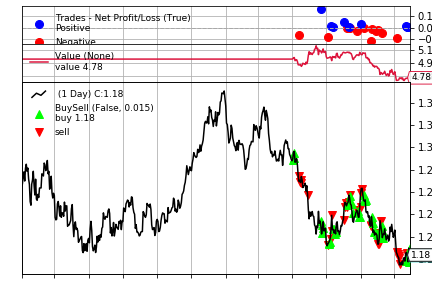

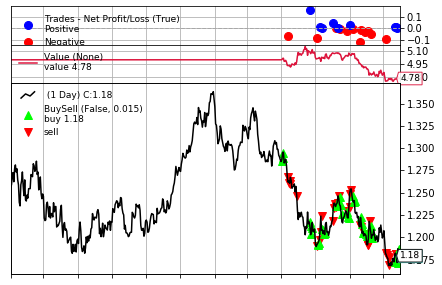

In [39]:
cerebro.plot(start=0, end=500)[0][0]

## 15M Candles - 2016

In [18]:
debug = False

In [ ]:
# Create a cerebro entity
cerebro = bt.Cerebro(cheat_on_open=True, stdstats=False)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

# Add a strategy
cerebro.addstrategy(RLStrategy)

# Add analyzer
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanalysis')
cerebro.addanalyzer(bt.analyzers.Returns, _name='myreturnanalysis')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='myddanalysis')
cerebro.addanalyzer(bt.analyzers.SQN, _name='mysqnanalysis')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysranalysis')
cerebro.addanalyzer(bt.analyzers.Calmar, _name='mycalmaranalysis')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='mypyanalysis')

my_date_parse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M")
dataframe = pd.read_csv(
    "../../data/EURUSD_15m_BID_01.01.2010-31.12.2016.csv", 
    parse_dates=["Time"], 
    index_col=0, 
    date_parser=my_date_parse
).sort_index()

dataframe = add_technical_indicators_with_intervals(
    dataframe, 
    indicators=configs['model']['inputs']['technical_indicators'], 
    intervals=configs['model']['inputs']['intervals']
)

data = ExtendedPandasData(
    dataname=dataframe[
        start_date.strftime("2016-01-01 00:00") :
        end_date.strftime("2016-12-31 23:59")
    ],
    open="Open",
    high="High",
    low="Low",
    close="Close",
    volume="Volume"
)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(initial_cash)
cerebro.broker.set_coo(True)

# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
thestrats = cerebro.run()

Starting Portfolio Value: 5.00
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
2016-01-01, Close, 1.08564 - Net, 5.00000
201

2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 5.00000
2016-01-03, Close, 1.08564 - Net, 

Action:  1
2016-01-04, CLOSE SHORT, 1.0829
2016-01-04, LONG, 1.08288
2016-01-04, BUY EXECUTED, Price: 1.0829, Cost: -1.0831, Comm 0.0000
2016-01-04, BUY EXECUTED, Price: 1.0829, Cost: 1.0829, Comm 0.0000
2016-01-04, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2016-01-04, Close, 1.08331 - Net, 5.00238
Action:  2
2016-01-04, CLOSE LONG, 1.08331
2016-01-04, SHORT, 1.0833
2016-01-04, SELL EXECUTED, Price: 1.0833, Cost: 1.0829, Comm 0.0000
2016-01-04, SELL EXECUTED, Price: 1.0833, Cost: -1.0833, Comm 0.0000
2016-01-04, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2016-01-04, Close, 1.08308 - Net, 5.00261
Action:  1
2016-01-04, CLOSE SHORT, 1.0831
2016-01-04, LONG, 1.08308
2016-01-04, BUY EXECUTED, Price: 1.0831, Cost: -1.0833, Comm 0.0000
2016-01-04, BUY EXECUTED, Price: 1.0831, Cost: 1.0831, Comm 0.0000
2016-01-04, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2016-01-04, Close, 1.08364 - Net, 5.00315
Action:  2
2016-01-04, CLOSE LONG, 1.08364
2016-01-04, SHORT, 1.0836
2016-01-04, SELL EXECUTED,

Action:  2
2016-01-05, Close, 1.07557 - Net, 5.00143
Action:  2
2016-01-05, Close, 1.07515 - Net, 5.00311
Action:  2
2016-01-05, Close, 1.07450 - Net, 5.00571
Action:  2
2016-01-05, Close, 1.07501 - Net, 5.00367
Action:  2
2016-01-05, Close, 1.07538 - Net, 5.00219
Action:  2
2016-01-05, Close, 1.07421 - Net, 5.00687
Action:  2
2016-01-05, Close, 1.07451 - Net, 5.00567
Action:  2
2016-01-05, Close, 1.07504 - Net, 5.00355
Action:  2
2016-01-05, Close, 1.07471 - Net, 5.00487
Action:  2
2016-01-05, Close, 1.07392 - Net, 5.00803
Action:  1
2016-01-05, CLOSE SHORT, 1.0739
2016-01-05, LONG, 1.07392
2016-01-05, BUY EXECUTED, Price: 1.0739, Cost: -4.3130, Comm 0.0000
2016-01-05, BUY EXECUTED, Price: 1.0739, Cost: 1.0739, Comm 0.0000
2016-01-05, OPERATION PROFIT, GROSS 0.0174, NET 0.0174
2016-01-05, Close, 1.07394 - Net, 5.00810
Action:  1
2016-01-05, LONG, 1.07394
2016-01-05, BUY EXECUTED, Price: 1.0739, Cost: 1.0739, Comm 0.0000
2016-01-05, Close, 1.07255 - Net, 5.00535
Action:  2
2016-01-05, 

Action:  1
2016-01-06, LONG, 1.07636
2016-01-06, BUY EXECUTED, Price: 1.0764, Cost: 1.0764, Comm 0.0000
2016-01-06, Close, 1.07600 - Net, 5.01894
Action:  1
2016-01-06, LONG, 1.07600
2016-01-06, BUY EXECUTED, Price: 1.0760, Cost: 1.0760, Comm 0.0000
2016-01-06, Close, 1.07513 - Net, 5.01722
Action:  1
2016-01-06, LONG, 1.07513
2016-01-06, BUY EXECUTED, Price: 1.0751, Cost: 1.0751, Comm 0.0000
2016-01-06, Close, 1.07493 - Net, 5.01662
Action:  1
2016-01-06, LONG, 1.07493
2016-01-06, BUY EXECUTED, Price: 1.0750, Cost: 1.0750, Comm 0.0000
2016-01-06, Close, 1.07453 - Net, 5.01500
Action:  1
2016-01-06, Close, 1.07475 - Net, 5.01588
Action:  1
2016-01-06, Close, 1.07484 - Net, 5.01624
Action:  1
2016-01-06, Close, 1.07485 - Net, 5.01628
Action:  1
2016-01-06, Close, 1.07492 - Net, 5.01656
Action:  1
2016-01-06, Close, 1.07472 - Net, 5.01576
Action:  1
2016-01-06, Close, 1.07442 - Net, 5.01456
Action:  1
2016-01-06, Close, 1.07442 - Net, 5.01456
Action:  1
2016-01-06, Close, 1.07447 - Net, 

Action:  2
2016-01-07, CLOSE LONG, 1.07826
2016-01-07, SELL EXECUTED, Price: 1.0783, Cost: 4.2969, Comm 0.0000
2016-01-07, OPERATION PROFIT, GROSS 0.0162, NET 0.0162
2016-01-07, Close, 1.07787 - Net, 5.04383
Action:  1
2016-01-07, LONG, 1.07787
2016-01-07, BUY EXECUTED, Price: 1.0779, Cost: 1.0779, Comm 0.0000
2016-01-07, Close, 1.07785 - Net, 5.04381
Action:  1
2016-01-07, LONG, 1.07785
2016-01-07, BUY EXECUTED, Price: 1.0778, Cost: 1.0778, Comm 0.0000
2016-01-07, Close, 1.07776 - Net, 5.04363
Action:  1
2016-01-07, LONG, 1.07776
2016-01-07, BUY EXECUTED, Price: 1.0778, Cost: 1.0778, Comm 0.0000
2016-01-07, Close, 1.07759 - Net, 5.04312
Action:  1
2016-01-07, LONG, 1.07759
2016-01-07, BUY EXECUTED, Price: 1.0776, Cost: 1.0776, Comm 0.0000
2016-01-07, Close, 1.07961 - Net, 5.05120
Action:  2
2016-01-07, CLOSE LONG, 1.07961
2016-01-07, SELL EXECUTED, Price: 1.0796, Cost: 4.3111, Comm 0.0000
2016-01-07, OPERATION PROFIT, GROSS 0.0075, NET 0.0075
2016-01-07, Close, 1.08077 - Net, 5.05132


Action:  1
2016-01-07, Close, 1.08685 - Net, 5.02980
Action:  2
2016-01-07, CLOSE LONG, 1.08685
2016-01-07, SELL EXECUTED, Price: 1.0868, Cost: 4.3418, Comm 0.0000
2016-01-07, OPERATION PROFIT, GROSS 0.0056, NET 0.0056
2016-01-07, Close, 1.08626 - Net, 5.02976
Action:  1
2016-01-07, LONG, 1.08626
2016-01-07, BUY EXECUTED, Price: 1.0862, Cost: 1.0862, Comm 0.0000
2016-01-07, Close, 1.08530 - Net, 5.02881
Action:  1
2016-01-07, LONG, 1.08530
2016-01-07, BUY EXECUTED, Price: 1.0853, Cost: 1.0853, Comm 0.0000
2016-01-07, Close, 1.08279 - Net, 5.02379
Action:  1
2016-01-07, LONG, 1.08279
2016-01-07, BUY EXECUTED, Price: 1.0827, Cost: 1.0827, Comm 0.0000
2016-01-07, Close, 1.08442 - Net, 5.02881
Action:  1
2016-01-07, LONG, 1.08442
2016-01-07, BUY EXECUTED, Price: 1.0845, Cost: 1.0845, Comm 0.0000
2016-01-07, Close, 1.08535 - Net, 5.03248
Action:  1
2016-01-07, Close, 1.08485 - Net, 5.03048
Action:  1
2016-01-07, Close, 1.08599 - Net, 5.03504
Action:  1
2016-01-07, Close, 1.08685 - Net, 5.03

Action:  2
2016-01-08, CLOSE LONG, 1.08605
2016-01-08, SELL EXECUTED, Price: 1.0861, Cost: 4.3512, Comm 0.0000
2016-01-08, OPERATION PROFIT, GROSS -0.0067, NET -0.0067
2016-01-08, Close, 1.08612 - Net, 5.01053
Action:  1
2016-01-08, LONG, 1.08612
2016-01-08, BUY EXECUTED, Price: 1.0861, Cost: 1.0861, Comm 0.0000
2016-01-08, Close, 1.08612 - Net, 5.01053
Action:  1
2016-01-08, LONG, 1.08612
2016-01-08, BUY EXECUTED, Price: 1.0861, Cost: 1.0861, Comm 0.0000
2016-01-08, Close, 1.08580 - Net, 5.00986
Action:  2
2016-01-08, CLOSE LONG, 1.08580
2016-01-08, SHORT, 1.0858
2016-01-08, SELL EXECUTED, Price: 1.0858, Cost: 2.1723, Comm 0.0000
2016-01-08, SELL EXECUTED, Price: 1.0858, Cost: -1.0858, Comm 0.0000
2016-01-08, OPERATION PROFIT, GROSS -0.0007, NET -0.0007
2016-01-08, Close, 1.08598 - Net, 5.00968
Action:  2
2016-01-08, SHORT, 1.0860
2016-01-08, SELL EXECUTED, Price: 1.0860, Cost: -1.0860, Comm 0.0000
2016-01-08, Close, 1.08864 - Net, 5.00436
Action:  2
2016-01-08, SHORT, 1.0886
2016-01-

Action:  1
2016-01-09, LONG, 1.09235
2016-01-09, BUY EXECUTED, Price: 1.0923, Cost: 1.0923, Comm 0.0000
2016-01-09, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-09, CLOSE LONG, 1.09235
2016-01-09, SELL EXECUTED, Price: 1.0923, Cost: 4.3694, Comm 0.0000
2016-01-09, OPERATION PROFIT, GROSS 0.0000, NET 0.0000
2016-01-09, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-09, SHORT, 1.0923
2016-01-09, SELL EXECUTED, Price: 1.0923, Cost: -1.0923, Comm 0.0000
2016-01-09, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-09, SHORT, 1.0923
2016-01-09, SELL EXECUTED, Price: 1.0923, Cost: -1.0923, Comm 0.0000
2016-01-09, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-09, SHORT, 1.0923
2016-01-09, SELL EXECUTED, Price: 1.0923, Cost: -1.0923, Comm 0.0000
2016-01-09, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-09, SHORT, 1.0923
2016-01-09, SELL EXECUTED, Price: 1.0923, Cost: -1.0923, Comm 0.0000
2016-01-09, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-09, Close, 1.09235 - Net, 5.00965
A

Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5.00965
Action:  2
2016-01-10, Close, 1.09235 - Net, 5

Action:  1
2016-01-11, LONG, 1.09005
2016-01-11, BUY EXECUTED, Price: 1.0900, Cost: 1.0900, Comm 0.0000
2016-01-11, Close, 1.08854 - Net, 4.97888
Action:  2
2016-01-11, CLOSE LONG, 1.08854
2016-01-11, SELL EXECUTED, Price: 1.0885, Cost: 4.3635, Comm 0.0000
2016-01-11, OPERATION PROFIT, GROSS -0.0093, NET -0.0093
2016-01-11, Close, 1.08869 - Net, 4.97888
Action:  1
2016-01-11, LONG, 1.08869
2016-01-11, BUY EXECUTED, Price: 1.0887, Cost: 1.0887, Comm 0.0000
2016-01-11, Close, 1.08873 - Net, 4.97892
Action:  2
2016-01-11, CLOSE LONG, 1.08873
2016-01-11, SHORT, 1.0887
2016-01-11, SELL EXECUTED, Price: 1.0887, Cost: 1.0887, Comm 0.0000
2016-01-11, SELL EXECUTED, Price: 1.0887, Cost: -1.0887, Comm 0.0000
2016-01-11, OPERATION PROFIT, GROSS 0.0000, NET 0.0000
2016-01-11, Close, 1.08843 - Net, 4.97922
Action:  2
2016-01-11, SHORT, 1.0884
2016-01-11, SELL EXECUTED, Price: 1.0884, Cost: -1.0884, Comm 0.0000
2016-01-11, Close, 1.08893 - Net, 4.97822
Action:  2
2016-01-11, SHORT, 1.0889
2016-01-11

Action:  1
2016-01-11, LONG, 1.08563
2016-01-12, BUY EXECUTED, Price: 1.0856, Cost: 1.0856, Comm 0.0000
2016-01-12, Close, 1.08636 - Net, 4.98280
Action:  2
2016-01-12, CLOSE LONG, 1.08636
2016-01-12, SELL EXECUTED, Price: 1.0864, Cost: 4.3429, Comm 0.0000
2016-01-12, OPERATION PROFIT, GROSS 0.0026, NET 0.0026
2016-01-12, Close, 1.08613 - Net, 4.98284
Action:  1
2016-01-12, LONG, 1.08613
2016-01-12, BUY EXECUTED, Price: 1.0861, Cost: 1.0861, Comm 0.0000
2016-01-12, Close, 1.08558 - Net, 4.98229
Action:  1
2016-01-12, LONG, 1.08558
2016-01-12, BUY EXECUTED, Price: 1.0856, Cost: 1.0856, Comm 0.0000
2016-01-12, Close, 1.08521 - Net, 4.98155
Action:  1
2016-01-12, LONG, 1.08521
2016-01-12, BUY EXECUTED, Price: 1.0852, Cost: 1.0852, Comm 0.0000
2016-01-12, Close, 1.08477 - Net, 4.98022
Action:  1
2016-01-12, LONG, 1.08477
2016-01-12, BUY EXECUTED, Price: 1.0848, Cost: 1.0848, Comm 0.0000
2016-01-12, Close, 1.08497 - Net, 4.98102
Action:  1
2016-01-12, Close, 1.08572 - Net, 4.98402
Action:  

2016-01-12, BUY EXECUTED, Price: 1.0847, Cost: 1.0847, Comm 0.0000
2016-01-12, Close, 1.08286 - Net, 4.97934
Action:  1
2016-01-12, Close, 1.08245 - Net, 4.97770
Action:  2
2016-01-12, CLOSE LONG, 1.08245
2016-01-12, SELL EXECUTED, Price: 1.0823, Cost: 4.3391, Comm 0.0000
2016-01-12, OPERATION PROFIT, GROSS -0.0097, NET -0.0097
2016-01-12, Close, 1.08380 - Net, 4.97730
Action:  1
2016-01-12, LONG, 1.08380
2016-01-12, BUY EXECUTED, Price: 1.0838, Cost: 1.0838, Comm 0.0000
2016-01-12, Close, 1.08363 - Net, 4.97713
Action:  1
2016-01-12, LONG, 1.08363
2016-01-12, BUY EXECUTED, Price: 1.0836, Cost: 1.0836, Comm 0.0000
2016-01-12, Close, 1.08344 - Net, 4.97675
Action:  1
2016-01-12, LONG, 1.08344
2016-01-12, BUY EXECUTED, Price: 1.0834, Cost: 1.0834, Comm 0.0000
2016-01-12, Close, 1.08352 - Net, 4.97700
Action:  1
2016-01-12, LONG, 1.08352
2016-01-12, BUY EXECUTED, Price: 1.0835, Cost: 1.0835, Comm 0.0000
2016-01-12, Close, 1.08246 - Net, 4.97277
Action:  1
2016-01-12, Close, 1.08361 - Net,

Action:  1
2016-01-13, Close, 1.08100 - Net, 4.96313
Action:  1
2016-01-13, Close, 1.08258 - Net, 4.96945
Action:  1
2016-01-13, Close, 1.08211 - Net, 4.96757
Action:  1
2016-01-13, Close, 1.08236 - Net, 4.96857
Action:  1
2016-01-13, Close, 1.08205 - Net, 4.96733
Action:  1
2016-01-13, Close, 1.08089 - Net, 4.96269
Action:  1
2016-01-13, Close, 1.08175 - Net, 4.96613
Action:  1
2016-01-13, Close, 1.08195 - Net, 4.96693
Action:  1
2016-01-13, Close, 1.08180 - Net, 4.96633
Action:  1
2016-01-13, Close, 1.08184 - Net, 4.96649
Action:  1
2016-01-13, Close, 1.08148 - Net, 4.96505
Action:  1
2016-01-13, Close, 1.08126 - Net, 4.96417
Action:  1
2016-01-13, Close, 1.08261 - Net, 4.96957
Action:  2
2016-01-13, CLOSE LONG, 1.08261
2016-01-13, SELL EXECUTED, Price: 1.0826, Cost: 4.3325, Comm 0.0000
2016-01-13, OPERATION PROFIT, GROSS -0.0021, NET -0.0021
2016-01-13, Close, 1.08255 - Net, 4.96961
Action:  1
2016-01-13, LONG, 1.08255
2016-01-13, BUY EXECUTED, Price: 1.0825, Cost: 1.0825, Comm 0.00

Action:  1
2016-01-13, LONG, 1.08780
2016-01-13, BUY EXECUTED, Price: 1.0877, Cost: 1.0877, Comm 0.0000
2016-01-13, Close, 1.08780 - Net, 4.97827
Action:  1
2016-01-13, LONG, 1.08780
2016-01-13, BUY EXECUTED, Price: 1.0878, Cost: 1.0878, Comm 0.0000
2016-01-13, Close, 1.08828 - Net, 4.98020
Action:  2
2016-01-13, CLOSE LONG, 1.08828
2016-01-13, SELL EXECUTED, Price: 1.0883, Cost: 4.3508, Comm 0.0000
2016-01-13, OPERATION PROFIT, GROSS 0.0023, NET 0.0023
2016-01-13, Close, 1.08821 - Net, 4.98020
Action:  2
2016-01-13, SHORT, 1.0882
2016-01-13, SELL EXECUTED, Price: 1.0882, Cost: -1.0882, Comm 0.0000
2016-01-13, Close, 1.08859 - Net, 4.97982
Action:  2
2016-01-13, SHORT, 1.0886
2016-01-13, SELL EXECUTED, Price: 1.0886, Cost: -1.0886, Comm 0.0000
2016-01-13, Close, 1.08852 - Net, 4.97993
Action:  2
2016-01-13, SHORT, 1.0885
2016-01-13, SELL EXECUTED, Price: 1.0885, Cost: -1.0885, Comm 0.0000
2016-01-13, Close, 1.08850 - Net, 4.98000
Action:  2
2016-01-13, SHORT, 1.0885
2016-01-13, SELL EX

Action:  2
2016-01-14, CLOSE LONG, 1.09064
2016-01-14, SELL EXECUTED, Price: 1.0906, Cost: 4.3664, Comm 0.0000
2016-01-14, OPERATION PROFIT, GROSS -0.0040, NET -0.0040
2016-01-14, Close, 1.09122 - Net, 4.96484
Action:  2
2016-01-14, SHORT, 1.0912
2016-01-14, SELL EXECUTED, Price: 1.0912, Cost: -1.0912, Comm 0.0000
2016-01-14, Close, 1.08975 - Net, 4.96630
Action:  1
2016-01-14, CLOSE SHORT, 1.0897
2016-01-14, LONG, 1.08975
2016-01-14, BUY EXECUTED, Price: 1.0897, Cost: -1.0912, Comm 0.0000
2016-01-14, BUY EXECUTED, Price: 1.0897, Cost: 1.0897, Comm 0.0000
2016-01-14, OPERATION PROFIT, GROSS 0.0015, NET 0.0015
2016-01-14, Close, 1.08810 - Net, 4.96467
Action:  1
2016-01-14, LONG, 1.08810
2016-01-14, BUY EXECUTED, Price: 1.0881, Cost: 1.0881, Comm 0.0000
2016-01-14, Close, 1.08571 - Net, 4.95990
Action:  1
2016-01-14, LONG, 1.08571
2016-01-14, BUY EXECUTED, Price: 1.0857, Cost: 1.0857, Comm 0.0000
2016-01-14, Close, 1.08398 - Net, 4.95472
Action:  2
2016-01-14, CLOSE LONG, 1.08398
2016-0

2016-01-15, SELL EXECUTED, Price: 1.0879, Cost: 1.0873, Comm 0.0000
2016-01-15, SELL EXECUTED, Price: 1.0879, Cost: -1.0879, Comm 0.0000
2016-01-15, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2016-01-15, Close, 1.08813 - Net, 4.96342
Action:  2
2016-01-15, SHORT, 1.0881
2016-01-15, SELL EXECUTED, Price: 1.0881, Cost: -1.0881, Comm 0.0000
2016-01-15, Close, 1.08762 - Net, 4.96445
Action:  1
2016-01-15, CLOSE SHORT, 1.0876
2016-01-15, LONG, 1.08762
2016-01-15, BUY EXECUTED, Price: 1.0876, Cost: -2.1760, Comm 0.0000
2016-01-15, BUY EXECUTED, Price: 1.0876, Cost: 1.0876, Comm 0.0000
2016-01-15, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2016-01-15, Close, 1.08795 - Net, 4.96475
Action:  1
2016-01-15, LONG, 1.08795
2016-01-15, BUY EXECUTED, Price: 1.0879, Cost: 1.0879, Comm 0.0000
2016-01-15, Close, 1.08807 - Net, 4.96499
Action:  1
2016-01-15, LONG, 1.08807
2016-01-15, BUY EXECUTED, Price: 1.0881, Cost: 1.0881, Comm 0.0000
2016-01-15, Close, 1.08821 - Net, 4.96538
Action:  2
2016-01-15, CL

Action:  1
2016-01-15, Close, 1.09380 - Net, 4.97890
Action:  1
2016-01-15, Close, 1.09464 - Net, 4.98226
Action:  1
2016-01-15, Close, 1.09205 - Net, 4.97190
Action:  1
2016-01-15, Close, 1.09090 - Net, 4.96730
Action:  1
2016-01-15, Close, 1.09190 - Net, 4.97130
Action:  1
2016-01-15, Close, 1.09205 - Net, 4.97190
Action:  1
2016-01-15, Close, 1.09123 - Net, 4.96862
Action:  1
2016-01-15, Close, 1.09174 - Net, 4.97066
Action:  1
2016-01-15, Close, 1.09163 - Net, 4.97022
Action:  1
2016-01-15, Close, 1.09081 - Net, 4.96694
Action:  1
2016-01-15, Close, 1.09073 - Net, 4.96662
Action:  1
2016-01-15, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-15, CLOSE LONG, 1.09150
2016-01-15, SELL EXECUTED, Price: 1.0915, Cost: 4.3819, Comm 0.0000
2016-01-15, OPERATION PROFIT, GROSS -0.0159, NET -0.0159
2016-01-15, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-15, SHORT, 1.0915
2016-01-15, SELL EXECUTED, Price: 1.0915, Cost: -1.0915, Comm 0.0000
2016-01-15, Close, 1.09150 - Net, 4.96970
Action

Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4.96970
Action:  2
2016-01-17, Close, 1.09150 - Net, 4

Action:  1
2016-01-18, LONG, 1.08914
2016-01-18, BUY EXECUTED, Price: 1.0891, Cost: 1.0891, Comm 0.0000
2016-01-18, Close, 1.08944 - Net, 4.96436
Action:  2
2016-01-18, CLOSE LONG, 1.08944
2016-01-18, SHORT, 1.0894
2016-01-18, SELL EXECUTED, Price: 1.0894, Cost: 2.1785, Comm 0.0000
2016-01-18, SELL EXECUTED, Price: 1.0894, Cost: -1.0894, Comm 0.0000
2016-01-18, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2016-01-18, Close, 1.08963 - Net, 4.96417
Action:  2
2016-01-18, SHORT, 1.0896
2016-01-18, SELL EXECUTED, Price: 1.0897, Cost: -1.0897, Comm 0.0000
2016-01-18, Close, 1.09015 - Net, 4.96316
Action:  2
2016-01-18, SHORT, 1.0901
2016-01-18, SELL EXECUTED, Price: 1.0901, Cost: -1.0901, Comm 0.0000
2016-01-18, Close, 1.08939 - Net, 4.96543
Action:  1
2016-01-18, CLOSE SHORT, 1.0894
2016-01-18, LONG, 1.08939
2016-01-18, BUY EXECUTED, Price: 1.0894, Cost: -3.2692, Comm 0.0000
2016-01-18, BUY EXECUTED, Price: 1.0894, Cost: 1.0894, Comm 0.0000
2016-01-18, OPERATION PROFIT, GROSS 0.0011, NET 0.0

Action:  1
2016-01-18, CLOSE SHORT, 1.0890
2016-01-18, LONG, 1.08900
2016-01-18, BUY EXECUTED, Price: 1.0890, Cost: -2.1781, Comm 0.0000
2016-01-18, BUY EXECUTED, Price: 1.0890, Cost: 1.0890, Comm 0.0000
2016-01-18, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2016-01-18, Close, 1.08954 - Net, 4.96620
Action:  2
2016-01-18, CLOSE LONG, 1.08954
2016-01-18, SHORT, 1.0895
2016-01-18, SELL EXECUTED, Price: 1.0895, Cost: 1.0890, Comm 0.0000
2016-01-18, SELL EXECUTED, Price: 1.0895, Cost: -1.0895, Comm 0.0000
2016-01-18, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2016-01-18, Close, 1.08893 - Net, 4.96681
Action:  1
2016-01-18, CLOSE SHORT, 1.0889
2016-01-18, LONG, 1.08893
2016-01-18, BUY EXECUTED, Price: 1.0889, Cost: -1.0895, Comm 0.0000
2016-01-18, BUY EXECUTED, Price: 1.0889, Cost: 1.0889, Comm 0.0000
2016-01-18, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2016-01-18, Close, 1.08966 - Net, 4.96754
Action:  1
2016-01-18, LONG, 1.08966
2016-01-18, BUY EXECUTED, Price: 1.0897, Cost: 1.0897, Com

Action:  1
2016-01-19, LONG, 1.08673
2016-01-19, BUY EXECUTED, Price: 1.0867, Cost: 1.0867, Comm 0.0000
2016-01-19, Close, 1.08731 - Net, 4.96480
Action:  1
2016-01-19, Close, 1.08702 - Net, 4.96364
Action:  1
2016-01-19, Close, 1.08727 - Net, 4.96464
Action:  1
2016-01-19, Close, 1.08662 - Net, 4.96204
Action:  1
2016-01-19, Close, 1.08672 - Net, 4.96244
Action:  1
2016-01-19, Close, 1.08704 - Net, 4.96372
Action:  1
2016-01-19, Close, 1.08630 - Net, 4.96076
Action:  1
2016-01-19, Close, 1.08663 - Net, 4.96208
Action:  1
2016-01-19, Close, 1.08715 - Net, 4.96416
Action:  1
2016-01-19, Close, 1.08793 - Net, 4.96728
Action:  2
2016-01-19, CLOSE LONG, 1.08793
2016-01-19, SELL EXECUTED, Price: 1.0879, Cost: 4.3499, Comm 0.0000
2016-01-19, OPERATION PROFIT, GROSS 0.0018, NET 0.0018
2016-01-19, Close, 1.08743 - Net, 4.96728
Action:  1
2016-01-19, LONG, 1.08743
2016-01-19, BUY EXECUTED, Price: 1.0874, Cost: 1.0874, Comm 0.0000
2016-01-19, Close, 1.08685 - Net, 4.96669
Action:  1
2016-01-19, 

Action:  2
2016-01-20, SHORT, 1.0921
2016-01-20, SELL EXECUTED, Price: 1.0921, Cost: -1.0921, Comm 0.0000
2016-01-20, Close, 1.09287 - Net, 4.97339
Action:  2
2016-01-20, SHORT, 1.0929
2016-01-20, SELL EXECUTED, Price: 1.0929, Cost: -1.0929, Comm 0.0000
2016-01-20, Close, 1.09319 - Net, 4.97243
Action:  2
2016-01-20, SHORT, 1.0932
2016-01-20, SELL EXECUTED, Price: 1.0932, Cost: -1.0932, Comm 0.0000
2016-01-20, Close, 1.09237 - Net, 4.97570
Action:  1
2016-01-20, CLOSE SHORT, 1.0924
2016-01-20, LONG, 1.09237
2016-01-20, BUY EXECUTED, Price: 1.0924, Cost: -4.3703, Comm 0.0000
2016-01-20, BUY EXECUTED, Price: 1.0924, Cost: 1.0924, Comm 0.0000
2016-01-20, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2016-01-20, Close, 1.09240 - Net, 4.97563
Action:  1
2016-01-20, LONG, 1.09240
2016-01-20, BUY EXECUTED, Price: 1.0924, Cost: 1.0924, Comm 0.0000
2016-01-20, Close, 1.09282 - Net, 4.97647
Action:  1
2016-01-20, LONG, 1.09282
2016-01-20, BUY EXECUTED, Price: 1.0928, Cost: 1.0928, Comm 0.0000
2016-

Action:  1
2016-01-20, LONG, 1.09091
2016-01-20, BUY EXECUTED, Price: 1.0909, Cost: 1.0909, Comm 0.0000
2016-01-20, Close, 1.09091 - Net, 4.98217
Action:  1
2016-01-20, LONG, 1.09091
2016-01-20, BUY EXECUTED, Price: 1.0909, Cost: 1.0909, Comm 0.0000
2016-01-20, Close, 1.09096 - Net, 4.98231
Action:  1
2016-01-20, LONG, 1.09096
2016-01-20, BUY EXECUTED, Price: 1.0910, Cost: 1.0910, Comm 0.0000
2016-01-20, Close, 1.09146 - Net, 4.98431
Action:  1
2016-01-20, Close, 1.09117 - Net, 4.98315
Action:  1
2016-01-20, Close, 1.08982 - Net, 4.97775
Action:  1
2016-01-20, Close, 1.09019 - Net, 4.97923
Action:  1
2016-01-20, Close, 1.09047 - Net, 4.98035
Action:  1
2016-01-20, Close, 1.09028 - Net, 4.97959
Action:  1
2016-01-20, Close, 1.09068 - Net, 4.98119
Action:  1
2016-01-20, Close, 1.09081 - Net, 4.98171
Action:  2
2016-01-20, CLOSE LONG, 1.09081
2016-01-20, SELL EXECUTED, Price: 1.0908, Cost: 4.3641, Comm 0.0000
2016-01-20, OPERATION PROFIT, GROSS -0.0009, NET -0.0009
2016-01-20, Close, 1.09

Action:  1
2016-01-21, LONG, 1.08880
2016-01-21, BUY EXECUTED, Price: 1.0888, Cost: 1.0888, Comm 0.0000
2016-01-21, Close, 1.08908 - Net, 4.97658
Action:  2
2016-01-21, CLOSE LONG, 1.08908
2016-01-21, SHORT, 1.0891
2016-01-21, SELL EXECUTED, Price: 1.0891, Cost: 2.1773, Comm 0.0000
2016-01-21, SELL EXECUTED, Price: 1.0891, Cost: -1.0891, Comm 0.0000
2016-01-21, OPERATION PROFIT, GROSS 0.0009, NET 0.0009
2016-01-21, Close, 1.08915 - Net, 4.97654
Action:  2
2016-01-21, SHORT, 1.0892
2016-01-21, SELL EXECUTED, Price: 1.0892, Cost: -1.0892, Comm 0.0000
2016-01-21, Close, 1.08889 - Net, 4.97706
Action:  1
2016-01-21, CLOSE SHORT, 1.0889
2016-01-21, LONG, 1.08889
2016-01-21, BUY EXECUTED, Price: 1.0889, Cost: -2.1782, Comm 0.0000
2016-01-21, BUY EXECUTED, Price: 1.0889, Cost: 1.0889, Comm 0.0000
2016-01-21, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2016-01-21, Close, 1.08926 - Net, 4.97743
Action:  2
2016-01-21, CLOSE LONG, 1.08926
2016-01-21, SHORT, 1.0893
2016-01-21, SELL EXECUTED, Price:

Action:  1
2016-01-21, LONG, 1.08775
2016-01-21, BUY EXECUTED, Price: 1.0877, Cost: 1.0877, Comm 0.0000
2016-01-21, Close, 1.08776 - Net, 4.92880
Action:  1
2016-01-21, LONG, 1.08776
2016-01-21, BUY EXECUTED, Price: 1.0878, Cost: 1.0878, Comm 0.0000
2016-01-21, Close, 1.08770 - Net, 4.92860
Action:  1
2016-01-21, LONG, 1.08770
2016-01-21, BUY EXECUTED, Price: 1.0877, Cost: 1.0877, Comm 0.0000
2016-01-21, Close, 1.08853 - Net, 4.93192
Action:  2
2016-01-21, CLOSE LONG, 1.08853
2016-01-21, SELL EXECUTED, Price: 1.0885, Cost: 4.3515, Comm 0.0000
2016-01-21, OPERATION PROFIT, GROSS 0.0026, NET 0.0026
2016-01-21, Close, 1.08825 - Net, 4.93192
Action:  1
2016-01-21, LONG, 1.08825
2016-01-21, BUY EXECUTED, Price: 1.0883, Cost: 1.0883, Comm 0.0000
2016-01-21, Close, 1.08882 - Net, 4.93248
Action:  1
2016-01-21, LONG, 1.08882
2016-01-21, BUY EXECUTED, Price: 1.0888, Cost: 1.0888, Comm 0.0000
2016-01-21, Close, 1.08845 - Net, 4.93179
Action:  1
2016-01-21, LONG, 1.08845
2016-01-21, BUY EXECUTED,

Action:  2
2016-01-22, CLOSE LONG, 1.08288
2016-01-22, SHORT, 1.0829
2016-01-22, SELL EXECUTED, Price: 1.0829, Cost: 3.2440, Comm 0.0000
2016-01-22, SELL EXECUTED, Price: 1.0829, Cost: -1.0829, Comm 0.0000
2016-01-22, OPERATION PROFIT, GROSS 0.0047, NET 0.0047
2016-01-22, Close, 1.08238 - Net, 4.92475
Action:  1
2016-01-22, CLOSE SHORT, 1.0824
2016-01-22, LONG, 1.08238
2016-01-22, BUY EXECUTED, Price: 1.0824, Cost: -1.0829, Comm 0.0000
2016-01-22, BUY EXECUTED, Price: 1.0824, Cost: 1.0824, Comm 0.0000
2016-01-22, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2016-01-22, Close, 1.08273 - Net, 4.92508
Action:  1
2016-01-22, LONG, 1.08273
2016-01-22, BUY EXECUTED, Price: 1.0827, Cost: 1.0827, Comm 0.0000
2016-01-22, Close, 1.08074 - Net, 4.92111
Action:  1
2016-01-22, LONG, 1.08074
2016-01-22, BUY EXECUTED, Price: 1.0807, Cost: 1.0807, Comm 0.0000
2016-01-22, Close, 1.08107 - Net, 4.92211
Action:  1
2016-01-22, LONG, 1.08107
2016-01-22, BUY EXECUTED, Price: 1.0811, Cost: 1.0811, Comm 0.0000


Action:  1
2016-01-25, CLOSE SHORT, 1.0804
2016-01-25, LONG, 1.08044
2016-01-25, BUY EXECUTED, Price: 1.0804, Cost: -1.0809, Comm 0.0000
2016-01-25, BUY EXECUTED, Price: 1.0804, Cost: 1.0804, Comm 0.0000
2016-01-25, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2016-01-25, Close, 1.08004 - Net, 4.91793
Action:  1
2016-01-25, LONG, 1.08004
2016-01-25, BUY EXECUTED, Price: 1.0800, Cost: 1.0800, Comm 0.0000
2016-01-25, Close, 1.08034 - Net, 4.91856
Action:  1
2016-01-25, LONG, 1.08034
2016-01-25, BUY EXECUTED, Price: 1.0803, Cost: 1.0803, Comm 0.0000
2016-01-25, Close, 1.08101 - Net, 4.92057
Action:  1
2016-01-25, LONG, 1.08101
2016-01-25, BUY EXECUTED, Price: 1.0810, Cost: 1.0810, Comm 0.0000
2016-01-25, Close, 1.08102 - Net, 4.92061
Action:  1
2016-01-25, Close, 1.08129 - Net, 4.92169
Action:  2
2016-01-25, CLOSE LONG, 1.08129
2016-01-25, SELL EXECUTED, Price: 1.0813, Cost: 4.3218, Comm 0.0000
2016-01-25, OPERATION PROFIT, GROSS 0.0034, NET 0.0034
2016-01-25, Close, 1.08116 - Net, 4.92169


Action:  1
2016-01-25, CLOSE SHORT, 1.0835
2016-01-25, LONG, 1.08346
2016-01-25, BUY EXECUTED, Price: 1.0835, Cost: -3.2517, Comm 0.0000
2016-01-25, BUY EXECUTED, Price: 1.0835, Cost: 1.0835, Comm 0.0000
2016-01-25, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2016-01-25, Close, 1.08350 - Net, 4.92765
Action:  1
2016-01-25, LONG, 1.08350
2016-01-25, BUY EXECUTED, Price: 1.0835, Cost: 1.0835, Comm 0.0000
2016-01-25, Close, 1.08340 - Net, 4.92744
Action:  1
2016-01-25, LONG, 1.08340
2016-01-25, BUY EXECUTED, Price: 1.0834, Cost: 1.0834, Comm 0.0000
2016-01-25, Close, 1.08314 - Net, 4.92664
Action:  1
2016-01-25, LONG, 1.08314
2016-01-25, BUY EXECUTED, Price: 1.0831, Cost: 1.0831, Comm 0.0000
2016-01-25, Close, 1.08284 - Net, 4.92544
Action:  1
2016-01-25, Close, 1.08283 - Net, 4.92540
Action:  1
2016-01-25, Close, 1.08306 - Net, 4.92632
Action:  1
2016-01-25, Close, 1.08274 - Net, 4.92504
Action:  1
2016-01-25, Close, 1.08257 - Net, 4.92436
Action:  1
2016-01-25, Close, 1.08273 - Net, 4.92

Action:  1
2016-01-26, CLOSE SHORT, 1.0871
2016-01-26, LONG, 1.08708
2016-01-26, BUY EXECUTED, Price: 1.0871, Cost: -1.0868, Comm 0.0000
2016-01-26, BUY EXECUTED, Price: 1.0871, Cost: 1.0871, Comm 0.0000
2016-01-26, OPERATION PROFIT, GROSS -0.0003, NET -0.0003
2016-01-26, Close, 1.08663 - Net, 4.94366
Action:  1
2016-01-26, LONG, 1.08663
2016-01-26, BUY EXECUTED, Price: 1.0866, Cost: 1.0866, Comm 0.0000
2016-01-26, Close, 1.08578 - Net, 4.94194
Action:  1
2016-01-26, LONG, 1.08578
2016-01-26, BUY EXECUTED, Price: 1.0858, Cost: 1.0858, Comm 0.0000
2016-01-26, Close, 1.08618 - Net, 4.94315
Action:  1
2016-01-26, LONG, 1.08618
2016-01-26, BUY EXECUTED, Price: 1.0862, Cost: 1.0862, Comm 0.0000
2016-01-26, Close, 1.08566 - Net, 4.94107
Action:  1
2016-01-26, Close, 1.08450 - Net, 4.93643
Action:  1
2016-01-26, Close, 1.08413 - Net, 4.93495
Action:  1
2016-01-26, Close, 1.08424 - Net, 4.93539
Action:  1
2016-01-26, Close, 1.08414 - Net, 4.93499
Action:  1
2016-01-26, Close, 1.08377 - Net, 4.

Action:  1
2016-01-26, LONG, 1.08572
2016-01-26, BUY EXECUTED, Price: 1.0857, Cost: 1.0857, Comm 0.0000
2016-01-26, Close, 1.08639 - Net, 4.94842
Action:  2
2016-01-26, CLOSE LONG, 1.08639
2016-01-26, SHORT, 1.0864
2016-01-26, SELL EXECUTED, Price: 1.0864, Cost: 2.1711, Comm 0.0000
2016-01-26, SELL EXECUTED, Price: 1.0864, Cost: -1.0864, Comm 0.0000
2016-01-26, OPERATION PROFIT, GROSS 0.0016, NET 0.0016
2016-01-26, Close, 1.08697 - Net, 4.94784
Action:  2
2016-01-26, SHORT, 1.0870
2016-01-26, SELL EXECUTED, Price: 1.0870, Cost: -1.0870, Comm 0.0000
2016-01-26, Close, 1.08644 - Net, 4.94890
Action:  1
2016-01-26, CLOSE SHORT, 1.0864
2016-01-26, LONG, 1.08644
2016-01-26, BUY EXECUTED, Price: 1.0864, Cost: -2.1734, Comm 0.0000
2016-01-26, BUY EXECUTED, Price: 1.0864, Cost: 1.0864, Comm 0.0000
2016-01-26, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2016-01-26, Close, 1.08659 - Net, 4.94905
Action:  1
2016-01-26, LONG, 1.08659
2016-01-26, BUY EXECUTED, Price: 1.0866, Cost: 1.0866, Comm 0.000

Action:  1
2016-01-27, LONG, 1.08953
2016-01-27, BUY EXECUTED, Price: 1.0895, Cost: 1.0895, Comm 0.0000
2016-01-27, Close, 1.08934 - Net, 4.95534
Action:  1
2016-01-27, LONG, 1.08934
2016-01-27, BUY EXECUTED, Price: 1.0893, Cost: 1.0893, Comm 0.0000
2016-01-27, Close, 1.08794 - Net, 4.95114
Action:  1
2016-01-27, LONG, 1.08794
2016-01-27, BUY EXECUTED, Price: 1.0879, Cost: 1.0879, Comm 0.0000
2016-01-27, Close, 1.08882 - Net, 4.95465
Action:  1
2016-01-27, Close, 1.08878 - Net, 4.95449
Action:  1
2016-01-27, Close, 1.08726 - Net, 4.94841
Action:  1
2016-01-27, Close, 1.08748 - Net, 4.94929
Action:  1
2016-01-27, Close, 1.08754 - Net, 4.94953
Action:  1
2016-01-27, Close, 1.08695 - Net, 4.94717
Action:  1
2016-01-27, Close, 1.08650 - Net, 4.94537
Action:  1
2016-01-27, Close, 1.08678 - Net, 4.94649
Action:  1
2016-01-27, Close, 1.08745 - Net, 4.94917
Action:  1
2016-01-27, Close, 1.08674 - Net, 4.94633
Action:  1
2016-01-27, Close, 1.08685 - Net, 4.94677
Action:  1
2016-01-27, Close, 1.

Action:  1
2016-01-28, Close, 1.08829 - Net, 4.95864
Action:  1
2016-01-28, Close, 1.08843 - Net, 4.95920
Action:  1
2016-01-28, Close, 1.08792 - Net, 4.95716
Action:  1
2016-01-28, Close, 1.08754 - Net, 4.95564
Action:  1
2016-01-28, Close, 1.08772 - Net, 4.95636
Action:  1
2016-01-28, Close, 1.08736 - Net, 4.95492
Action:  1
2016-01-28, Close, 1.08740 - Net, 4.95508
Action:  1
2016-01-28, Close, 1.08783 - Net, 4.95680
Action:  2
2016-01-28, CLOSE LONG, 1.08783
2016-01-28, SELL EXECUTED, Price: 1.0878, Cost: 4.3557, Comm 0.0000
2016-01-28, OPERATION PROFIT, GROSS -0.0043, NET -0.0043
2016-01-28, Close, 1.08760 - Net, 4.95684
Action:  1
2016-01-28, LONG, 1.08760
2016-01-28, BUY EXECUTED, Price: 1.0876, Cost: 1.0876, Comm 0.0000
2016-01-28, Close, 1.08758 - Net, 4.95682
Action:  1
2016-01-28, LONG, 1.08758
2016-01-28, BUY EXECUTED, Price: 1.0876, Cost: 1.0876, Comm 0.0000
2016-01-28, Close, 1.08767 - Net, 4.95698
Action:  2
2016-01-28, CLOSE LONG, 1.08767
2016-01-28, SHORT, 1.0877
2016-

Action:  1
2016-01-28, Close, 1.09391 - Net, 4.95914
Action:  1
2016-01-28, Close, 1.09384 - Net, 4.95886
Action:  1
2016-01-28, Close, 1.09396 - Net, 4.95934
Action:  1
2016-01-28, Close, 1.09406 - Net, 4.95974
Action:  2
2016-01-28, CLOSE LONG, 1.09406
2016-01-28, SELL EXECUTED, Price: 1.0941, Cost: 4.3834, Comm 0.0000
2016-01-28, OPERATION PROFIT, GROSS -0.0072, NET -0.0072
2016-01-28, Close, 1.09379 - Net, 4.95974
Action:  1
2016-01-28, LONG, 1.09379
2016-01-28, BUY EXECUTED, Price: 1.0938, Cost: 1.0938, Comm 0.0000
2016-01-28, Close, 1.09404 - Net, 4.95999
Action:  1
2016-01-28, LONG, 1.09404
2016-01-28, BUY EXECUTED, Price: 1.0940, Cost: 1.0940, Comm 0.0000
2016-01-28, Close, 1.09411 - Net, 4.96013
Action:  2
2016-01-28, CLOSE LONG, 1.09411
2016-01-28, SHORT, 1.0941
2016-01-28, SELL EXECUTED, Price: 1.0941, Cost: 2.1878, Comm 0.0000
2016-01-28, SELL EXECUTED, Price: 1.0941, Cost: -1.0941, Comm 0.0000
2016-01-28, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2016-01-28, Close, 1.0937

Action:  1
2016-01-29, LONG, 1.09085
2016-01-29, BUY EXECUTED, Price: 1.0909, Cost: 1.0909, Comm 0.0000
2016-01-29, Close, 1.09184 - Net, 4.93513
Action:  1
2016-01-29, Close, 1.09197 - Net, 4.93565
Action:  1
2016-01-29, Close, 1.09158 - Net, 4.93409
Action:  1
2016-01-29, Close, 1.08861 - Net, 4.92221
Action:  1
2016-01-29, Close, 1.08636 - Net, 4.91321
Action:  2
2016-01-29, CLOSE LONG, 1.08636
2016-01-29, SELL EXECUTED, Price: 1.0864, Cost: 4.3652, Comm 0.0000
2016-01-29, OPERATION PROFIT, GROSS -0.0198, NET -0.0198
2016-01-29, Close, 1.08560 - Net, 4.91321
Action:  2
2016-01-29, SHORT, 1.0856
2016-01-29, SELL EXECUTED, Price: 1.0856, Cost: -1.0856, Comm 0.0000
2016-01-29, Close, 1.08542 - Net, 4.91339
Action:  2
2016-01-29, SHORT, 1.0854
2016-01-29, SELL EXECUTED, Price: 1.0854, Cost: -1.0854, Comm 0.0000
2016-01-29, Close, 1.08356 - Net, 4.91712
Action:  2
2016-01-29, SHORT, 1.0836
2016-01-29, SELL EXECUTED, Price: 1.0836, Cost: -1.0836, Comm 0.0000
2016-01-29, Close, 1.08395 - N

Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4.92041
Action:  2
2016-01-30, Close, 1.08300 - Net, 4

Action:  2
2016-02-01, Close, 1.08361 - Net, 4.91150
Action:  2
2016-02-01, Close, 1.08373 - Net, 4.91102
Action:  2
2016-02-01, Close, 1.08412 - Net, 4.90946
Action:  2
2016-02-01, Close, 1.08431 - Net, 4.90870
Action:  2
2016-02-01, Close, 1.08404 - Net, 4.90978
Action:  1
2016-02-01, CLOSE SHORT, 1.0840
2016-02-01, LONG, 1.08404
2016-02-01, BUY EXECUTED, Price: 1.0840, Cost: -4.3284, Comm 0.0000
2016-02-01, BUY EXECUTED, Price: 1.0840, Cost: 1.0840, Comm 0.0000
2016-02-01, OPERATION PROFIT, GROSS -0.0077, NET -0.0077
2016-02-01, Close, 1.08348 - Net, 4.90922
Action:  1
2016-02-01, LONG, 1.08348
2016-02-01, BUY EXECUTED, Price: 1.0835, Cost: 1.0835, Comm 0.0000
2016-02-01, Close, 1.08472 - Net, 4.91169
Action:  1
2016-02-01, LONG, 1.08472
2016-02-01, BUY EXECUTED, Price: 1.0847, Cost: 1.0847, Comm 0.0000
2016-02-01, Close, 1.08463 - Net, 4.91142
Action:  1
2016-02-01, LONG, 1.08463
2016-02-01, BUY EXECUTED, Price: 1.0846, Cost: 1.0846, Comm 0.0000
2016-02-01, Close, 1.08475 - Net, 4.

Action:  1
2016-02-01, LONG, 1.08916
2016-02-01, BUY EXECUTED, Price: 1.0892, Cost: 1.0892, Comm 0.0000
2016-02-01, Close, 1.08875 - Net, 4.92974
Action:  1
2016-02-01, LONG, 1.08875
2016-02-01, BUY EXECUTED, Price: 1.0888, Cost: 1.0888, Comm 0.0000
2016-02-01, Close, 1.08753 - Net, 4.92607
Action:  1
2016-02-01, LONG, 1.08753
2016-02-01, BUY EXECUTED, Price: 1.0875, Cost: 1.0875, Comm 0.0000
2016-02-01, Close, 1.08852 - Net, 4.93002
Action:  1
2016-02-01, Close, 1.08878 - Net, 4.93106
Action:  1
2016-02-01, Close, 1.08957 - Net, 4.93422
Action:  2
2016-02-01, CLOSE LONG, 1.08957
2016-02-01, SELL EXECUTED, Price: 1.0896, Cost: 4.3550, Comm 0.0000
2016-02-01, OPERATION PROFIT, GROSS 0.0033, NET 0.0033
2016-02-01, Close, 1.09006 - Net, 4.93422
Action:  2
2016-02-01, SHORT, 1.0901
2016-02-01, SELL EXECUTED, Price: 1.0901, Cost: -1.0901, Comm 0.0000
2016-02-01, Close, 1.08947 - Net, 4.93481
Action:  1
2016-02-01, CLOSE SHORT, 1.0895
2016-02-01, LONG, 1.08947
2016-02-01, BUY EXECUTED, Price

Action:  1
2016-02-02, Close, 1.09037 - Net, 4.94036
Action:  1
2016-02-02, Close, 1.09050 - Net, 4.94088
Action:  1
2016-02-02, Close, 1.09027 - Net, 4.93996
Action:  1
2016-02-02, Close, 1.08994 - Net, 4.93864
Action:  1
2016-02-02, Close, 1.09075 - Net, 4.94188
Action:  2
2016-02-02, CLOSE LONG, 1.09075
2016-02-02, SELL EXECUTED, Price: 1.0908, Cost: 4.3649, Comm 0.0000
2016-02-02, OPERATION PROFIT, GROSS -0.0018, NET -0.0018
2016-02-02, Close, 1.09137 - Net, 4.94192
Action:  2
2016-02-02, SHORT, 1.0914
2016-02-02, SELL EXECUTED, Price: 1.0914, Cost: -1.0914, Comm 0.0000
2016-02-02, Close, 1.09152 - Net, 4.94177
Action:  2
2016-02-02, SHORT, 1.0915
2016-02-02, SELL EXECUTED, Price: 1.0915, Cost: -1.0915, Comm 0.0000
2016-02-02, Close, 1.09118 - Net, 4.94245
Action:  1
2016-02-02, CLOSE SHORT, 1.0912
2016-02-02, LONG, 1.09118
2016-02-02, BUY EXECUTED, Price: 1.0912, Cost: -2.1829, Comm 0.0000
2016-02-02, BUY EXECUTED, Price: 1.0912, Cost: 1.0912, Comm 0.0000
2016-02-02, OPERATION PRO

Action:  1
2016-02-03, LONG, 1.09225
2016-02-03, BUY EXECUTED, Price: 1.0922, Cost: 1.0922, Comm 0.0000
2016-02-03, Close, 1.09242 - Net, 4.94984
Action:  1
2016-02-03, Close, 1.09252 - Net, 4.95024
Action:  1
2016-02-03, Close, 1.09224 - Net, 4.94912
Action:  1
2016-02-03, Close, 1.09245 - Net, 4.94996
Action:  1
2016-02-03, Close, 1.09331 - Net, 4.95340
Action:  2
2016-02-03, CLOSE LONG, 1.09331
2016-02-03, SELL EXECUTED, Price: 1.0933, Cost: 4.3689, Comm 0.0000
2016-02-03, OPERATION PROFIT, GROSS 0.0044, NET 0.0044
2016-02-03, Close, 1.09282 - Net, 4.95340
Action:  1
2016-02-03, LONG, 1.09282
2016-02-03, BUY EXECUTED, Price: 1.0928, Cost: 1.0928, Comm 0.0000
2016-02-03, Close, 1.09271 - Net, 4.95330
Action:  1
2016-02-03, LONG, 1.09271
2016-02-03, BUY EXECUTED, Price: 1.0927, Cost: 1.0927, Comm 0.0000
2016-02-03, Close, 1.09282 - Net, 4.95351
Action:  1
2016-02-03, LONG, 1.09282
2016-02-03, BUY EXECUTED, Price: 1.0928, Cost: 1.0928, Comm 0.0000
2016-02-03, Close, 1.09259 - Net, 4.95

Action:  1
2016-02-03, Close, 1.10649 - Net, 4.97737
Action:  1
2016-02-03, Close, 1.10655 - Net, 4.97761
Action:  1
2016-02-03, Close, 1.10977 - Net, 4.99049
Action:  2
2016-02-03, CLOSE LONG, 1.10977
2016-02-03, SELL EXECUTED, Price: 1.1098, Cost: 4.4144, Comm 0.0000
2016-02-03, OPERATION PROFIT, GROSS 0.0247, NET 0.0247
2016-02-03, Close, 1.10942 - Net, 4.99049
Action:  2
2016-02-03, SHORT, 1.1094
2016-02-03, SELL EXECUTED, Price: 1.1094, Cost: -1.1094, Comm 0.0000
2016-02-03, Close, 1.11222 - Net, 4.98768
Action:  2
2016-02-03, SHORT, 1.1122
2016-02-03, SELL EXECUTED, Price: 1.1122, Cost: -1.1122, Comm 0.0000
2016-02-03, Close, 1.11338 - Net, 4.98533
Action:  2
2016-02-03, SHORT, 1.1134
2016-02-03, SELL EXECUTED, Price: 1.1134, Cost: -1.1134, Comm 0.0000
2016-02-03, Close, 1.11138 - Net, 4.99132
Action:  1
2016-02-03, CLOSE SHORT, 1.1114
2016-02-03, LONG, 1.11138
2016-02-03, BUY EXECUTED, Price: 1.1114, Cost: -3.3350, Comm 0.0000
2016-02-03, BUY EXECUTED, Price: 1.1114, Cost: 1.111

Action:  1
2016-02-04, LONG, 1.11612
2016-02-04, BUY EXECUTED, Price: 1.1161, Cost: 1.1161, Comm 0.0000
2016-02-04, Close, 1.11753 - Net, 5.00585
Action:  2
2016-02-04, CLOSE LONG, 1.11753
2016-02-04, SHORT, 1.1175
2016-02-04, SELL EXECUTED, Price: 1.1175, Cost: 2.2319, Comm 0.0000
2016-02-04, SELL EXECUTED, Price: 1.1175, Cost: -1.1175, Comm 0.0000
2016-02-04, OPERATION PROFIT, GROSS 0.0032, NET 0.0032
2016-02-04, Close, 1.11816 - Net, 5.00519
Action:  2
2016-02-04, SHORT, 1.1182
2016-02-04, SELL EXECUTED, Price: 1.1181, Cost: -1.1181, Comm 0.0000
2016-02-04, Close, 1.11773 - Net, 5.00604
Action:  1
2016-02-04, CLOSE SHORT, 1.1177
2016-02-04, LONG, 1.11773
2016-02-04, BUY EXECUTED, Price: 1.1177, Cost: -2.2357, Comm 0.0000
2016-02-04, BUY EXECUTED, Price: 1.1177, Cost: 1.1177, Comm 0.0000
2016-02-04, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2016-02-04, Close, 1.11838 - Net, 5.00669
Action:  2
2016-02-04, CLOSE LONG, 1.11838
2016-02-04, SHORT, 1.1184
2016-02-04, SELL EXECUTED, Price:

In [ ]:
print_analysis(data, thestrats[0], cerebro.broker.getvalue(), start_date, end_date)

In [ ]:
cerebro.plot(width=1000)[0][0]

## 30M Candles - 2017

In [19]:
# Create a cerebro entity
cerebro = bt.Cerebro(cheat_on_open=True, stdstats=False)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

# Add a strategy
cerebro.addstrategy(RLStrategy)

# Add analyzer
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanalysis')
cerebro.addanalyzer(bt.analyzers.Returns, _name='myreturnanalysis')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='myddanalysis')
cerebro.addanalyzer(bt.analyzers.SQN, _name='mysqnanalysis')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysranalysis')
cerebro.addanalyzer(bt.analyzers.Calmar, _name='mycalmaranalysis')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='mypyanalysis')

my_date_parse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
dataframe = pd.read_csv(
    "../../data/duka/EURUSD-2017_01_01-2017_12_31.csv", 
    parse_dates=["time"], 
    index_col=0, 
    date_parser=my_date_parse
).sort_index()

dataframe = add_technical_indicators_with_intervals(
    dataframe, 
    indicators=configs['model']['inputs']['technical_indicators'], 
    intervals=configs['model']['inputs']['intervals']
)

data = ExtendedPandasData(
    dataname=dataframe[
        start_date.strftime("2017-01-01 21:30:00") :
        end_date.strftime("2017-12-29 22:30:00")
    ],
    open="Open",
    high="High",
    low="Low",
    close="Close",
    volume="Volume"
)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(initial_cash)
cerebro.broker.set_coo(True)

# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
thestrats = cerebro.run()

Starting Portfolio Value: 5.00
2017-01-11, Close, 1.05456 - Net, 5.00000
2017-01-11, Close, 1.05452 - Net, 5.00000
2017-01-11, Close, 1.05507 - Net, 5.00000
2017-01-11, Close, 1.05478 - Net, 5.00000
2017-01-11, Close, 1.05500 - Net, 5.00000
2017-01-11, Close, 1.05508 - Net, 5.00000
2017-01-11, Close, 1.05627 - Net, 5.00000
2017-01-11, Close, 1.05605 - Net, 5.00000
2017-01-11, Close, 1.05585 - Net, 5.00000
2017-01-11, Close, 1.05574 - Net, 5.00000
2017-01-11, Close, 1.05580 - Net, 5.00000
2017-01-11, Close, 1.05465 - Net, 5.00000
2017-01-11, Close, 1.05354 - Net, 5.00000
2017-01-11, Close, 1.05201 - Net, 5.00000
2017-01-11, Close, 1.05224 - Net, 5.00000
2017-01-11, Close, 1.05208 - Net, 5.00000
2017-01-11, Close, 1.05193 - Net, 5.00000
2017-01-11, Close, 1.05083 - Net, 5.00000
2017-01-11, Close, 1.05020 - Net, 5.00000
2017-01-11, Close, 1.05067 - Net, 5.00000
2017-01-11, Close, 1.05133 - Net, 5.00000
2017-01-11, Close, 1.04924 - Net, 5.00000
2017-01-11, Close, 1.04811 - Net, 5.00000
201

2017-01-20, Close, 1.06855 - Net, 5.00000
2017-01-20, Close, 1.06808 - Net, 5.00000
2017-01-20, Close, 1.06803 - Net, 5.00000
2017-01-20, Close, 1.06816 - Net, 5.00000
2017-01-20, Close, 1.06725 - Net, 5.00000
2017-01-20, Close, 1.06807 - Net, 5.00000
2017-01-20, Close, 1.06832 - Net, 5.00000
2017-01-20, Close, 1.06849 - Net, 5.00000
2017-01-20, Close, 1.06721 - Net, 5.00000
2017-01-20, Close, 1.06651 - Net, 5.00000
2017-01-20, Close, 1.06636 - Net, 5.00000
2017-01-20, Close, 1.06586 - Net, 5.00000
2017-01-20, Close, 1.06464 - Net, 5.00000
2017-01-20, Close, 1.06405 - Net, 5.00000
2017-01-20, Close, 1.06372 - Net, 5.00000
2017-01-20, Close, 1.06321 - Net, 5.00000
2017-01-20, Close, 1.06389 - Net, 5.00000
2017-01-20, Close, 1.06438 - Net, 5.00000
2017-01-20, Close, 1.06277 - Net, 5.00000
2017-01-20, Close, 1.06451 - Net, 5.00000
2017-01-20, Close, 1.06568 - Net, 5.00000
2017-01-20, Close, 1.06636 - Net, 5.00000
2017-01-20, Close, 1.06553 - Net, 5.00000
2017-01-20, Close, 1.06756 - Net, 

Action:  1
2017-01-27, LONG, 1.06832
2017-01-27, BUY EXECUTED, Price: 1.0683, Cost: 1.0683, Comm 0.0000
2017-01-27, Close, 1.06785 - Net, 4.99183
Action:  1
2017-01-27, LONG, 1.06785
2017-01-27, BUY EXECUTED, Price: 1.0678, Cost: 1.0678, Comm 0.0000
2017-01-27, Close, 1.06829 - Net, 4.99317
Action:  1
2017-01-27, LONG, 1.06829
2017-01-27, BUY EXECUTED, Price: 1.0683, Cost: 1.0683, Comm 0.0000
2017-01-27, Close, 1.06841 - Net, 4.99367
Action:  1
2017-01-27, Close, 1.06806 - Net, 4.99227
Action:  1
2017-01-27, Close, 1.06759 - Net, 4.99039
Action:  1
2017-01-27, Close, 1.06754 - Net, 4.99019
Action:  1
2017-01-27, Close, 1.06752 - Net, 4.99011
Action:  1
2017-01-27, Close, 1.06745 - Net, 4.98983
Action:  1
2017-01-27, Close, 1.06717 - Net, 4.98871
Action:  1
2017-01-27, Close, 1.06721 - Net, 4.98887
Action:  1
2017-01-27, Close, 1.06680 - Net, 4.98723
Action:  1
2017-01-27, Close, 1.06650 - Net, 4.98603
Action:  2
2017-01-27, CLOSE LONG, 1.06650
2017-01-27, SELL EXECUTED, Price: 1.0665, 

Action:  2
2017-01-30, CLOSE LONG, 1.06833
2017-01-30, SHORT, 1.0683
2017-01-30, SELL EXECUTED, Price: 1.0683, Cost: 3.2083, Comm 0.0000
2017-01-30, SELL EXECUTED, Price: 1.0683, Cost: -1.0683, Comm 0.0000
2017-01-30, OPERATION PROFIT, GROSS -0.0035, NET -0.0035
2017-01-30, Close, 1.06613 - Net, 4.97829
Action:  2
2017-01-30, SHORT, 1.0661
2017-01-30, SELL EXECUTED, Price: 1.0661, Cost: -1.0661, Comm 0.0000
2017-01-30, Close, 1.06366 - Net, 4.98324
Action:  2
2017-01-30, SHORT, 1.0637
2017-01-30, SELL EXECUTED, Price: 1.0636, Cost: -1.0636, Comm 0.0000
2017-01-30, Close, 1.06293 - Net, 4.98542
Action:  2
2017-01-30, SHORT, 1.0629
2017-01-30, SELL EXECUTED, Price: 1.0630, Cost: -1.0630, Comm 0.0000
2017-01-30, Close, 1.06352 - Net, 4.98310
Action:  2
2017-01-30, Close, 1.06448 - Net, 4.97926
Action:  2
2017-01-30, Close, 1.06415 - Net, 4.98058
Action:  2
2017-01-30, Close, 1.06595 - Net, 4.97338
Action:  2
2017-01-30, Close, 1.06716 - Net, 4.96854
Action:  2
2017-01-30, Close, 1.06879 -

Action:  1
2017-02-01, Close, 1.07496 - Net, 4.95947
Action:  1
2017-02-01, Close, 1.07530 - Net, 4.96083
Action:  1
2017-02-01, Close, 1.07502 - Net, 4.95971
Action:  1
2017-02-01, Close, 1.07404 - Net, 4.95579
Action:  1
2017-02-01, Close, 1.07710 - Net, 4.96803
Action:  2
2017-02-01, CLOSE LONG, 1.07710
2017-02-01, SELL EXECUTED, Price: 1.0771, Cost: 4.3070, Comm 0.0000
2017-02-01, OPERATION PROFIT, GROSS 0.0013, NET 0.0013
2017-02-01, Close, 1.07765 - Net, 4.96799
Action:  2
2017-02-01, SHORT, 1.0776
2017-02-01, SELL EXECUTED, Price: 1.0776, Cost: -1.0776, Comm 0.0000
2017-02-01, Close, 1.07685 - Net, 4.96879
Action:  1
2017-02-01, CLOSE SHORT, 1.0769
2017-02-01, LONG, 1.07685
2017-02-01, BUY EXECUTED, Price: 1.0769, Cost: -1.0776, Comm 0.0000
2017-02-01, BUY EXECUTED, Price: 1.0769, Cost: 1.0769, Comm 0.0000
2017-02-01, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2017-02-01, Close, 1.07699 - Net, 4.96893
Action:  1
2017-02-01, LONG, 1.07699
2017-02-01, BUY EXECUTED, Price: 1.0770, 

Action:  2
2017-02-02, Close, 1.07628 - Net, 4.97369
Action:  2
2017-02-02, Close, 1.07621 - Net, 4.97397
Action:  2
2017-02-03, Close, 1.07593 - Net, 4.97509
Action:  1
2017-02-03, CLOSE SHORT, 1.0759
2017-02-03, LONG, 1.07593
2017-02-03, BUY EXECUTED, Price: 1.0759, Cost: -4.3042, Comm 0.0000
2017-02-03, BUY EXECUTED, Price: 1.0759, Cost: 1.0759, Comm 0.0000
2017-02-03, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-02-03, Close, 1.07613 - Net, 4.97524
Action:  2
2017-02-03, CLOSE LONG, 1.07613
2017-02-03, SHORT, 1.0761
2017-02-03, SELL EXECUTED, Price: 1.0761, Cost: 1.0759, Comm 0.0000
2017-02-03, SELL EXECUTED, Price: 1.0761, Cost: -1.0761, Comm 0.0000
2017-02-03, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-02-03, Close, 1.07679 - Net, 4.97458
Action:  2
2017-02-03, SHORT, 1.0768
2017-02-03, SELL EXECUTED, Price: 1.0768, Cost: -1.0768, Comm 0.0000
2017-02-03, Close, 1.07695 - Net, 4.97427
Action:  2
2017-02-03, SHORT, 1.0770
2017-02-03, SELL EXECUTED, Price: 1.0770, Cost: -1.0

Action:  2
2017-02-06, SHORT, 1.0734
2017-02-06, SELL EXECUTED, Price: 1.0734, Cost: -1.0734, Comm 0.0000
2017-02-06, Close, 1.07217 - Net, 4.93990
Action:  2
2017-02-06, SHORT, 1.0722
2017-02-06, SELL EXECUTED, Price: 1.0722, Cost: -1.0722, Comm 0.0000
2017-02-06, Close, 1.07133 - Net, 4.94326
Action:  2
2017-02-06, Close, 1.07203 - Net, 4.94046
Action:  2
2017-02-06, Close, 1.07289 - Net, 4.93702
Action:  2
2017-02-06, Close, 1.07296 - Net, 4.93674
Action:  2
2017-02-06, Close, 1.07389 - Net, 4.93302
Action:  2
2017-02-06, Close, 1.07338 - Net, 4.93506
Action:  1
2017-02-06, CLOSE SHORT, 1.0734
2017-02-06, LONG, 1.07338
2017-02-06, BUY EXECUTED, Price: 1.0734, Cost: -4.2929, Comm 0.0000
2017-02-06, BUY EXECUTED, Price: 1.0734, Cost: 1.0734, Comm 0.0000
2017-02-06, OPERATION PROFIT, GROSS -0.0007, NET -0.0007
2017-02-06, Close, 1.07306 - Net, 4.93464
Action:  1
2017-02-06, LONG, 1.07306
2017-02-06, BUY EXECUTED, Price: 1.0731, Cost: 1.0731, Comm 0.0000
2017-02-06, Close, 1.07359 - Net

Action:  1
2017-02-07, LONG, 1.06945
2017-02-07, BUY EXECUTED, Price: 1.0694, Cost: 1.0694, Comm 0.0000
2017-02-07, Close, 1.06940 - Net, 4.94417
Action:  1
2017-02-07, LONG, 1.06940
2017-02-07, BUY EXECUTED, Price: 1.0694, Cost: 1.0694, Comm 0.0000
2017-02-07, Close, 1.06963 - Net, 4.94508
Action:  1
2017-02-07, Close, 1.06952 - Net, 4.94464
Action:  1
2017-02-07, Close, 1.06889 - Net, 4.94212
Action:  1
2017-02-07, Close, 1.06847 - Net, 4.94044
Action:  1
2017-02-07, Close, 1.06837 - Net, 4.94004
Action:  1
2017-02-07, Close, 1.06804 - Net, 4.93872
Action:  1
2017-02-07, Close, 1.06807 - Net, 4.93884
Action:  1
2017-02-07, Close, 1.06806 - Net, 4.93880
Action:  1
2017-02-07, Close, 1.06789 - Net, 4.93812
Action:  1
2017-02-08, Close, 1.06701 - Net, 4.93460
Action:  2
2017-02-08, CLOSE LONG, 1.06701
2017-02-08, SELL EXECUTED, Price: 1.0670, Cost: 4.2777, Comm 0.0000
2017-02-08, OPERATION PROFIT, GROSS -0.0097, NET -0.0097
2017-02-08, Close, 1.06781 - Net, 4.93460
Action:  1
2017-02-08

Action:  1
2017-02-10, LONG, 1.06584
2017-02-10, BUY EXECUTED, Price: 1.0658, Cost: 1.0658, Comm 0.0000
2017-02-10, Close, 1.06598 - Net, 4.89823
Action:  1
2017-02-10, Close, 1.06673 - Net, 4.90123
Action:  2
2017-02-10, CLOSE LONG, 1.06673
2017-02-10, SELL EXECUTED, Price: 1.0667, Cost: 4.2637, Comm 0.0000
2017-02-10, OPERATION PROFIT, GROSS 0.0032, NET 0.0032
2017-02-10, Close, 1.06624 - Net, 4.90127
Action:  1
2017-02-10, LONG, 1.06624
2017-02-10, BUY EXECUTED, Price: 1.0662, Cost: 1.0662, Comm 0.0000
2017-02-10, Close, 1.06606 - Net, 4.90109
Action:  1
2017-02-10, LONG, 1.06606
2017-02-10, BUY EXECUTED, Price: 1.0660, Cost: 1.0660, Comm 0.0000
2017-02-10, Close, 1.06623 - Net, 4.90144
Action:  1
2017-02-10, LONG, 1.06623
2017-02-10, BUY EXECUTED, Price: 1.0662, Cost: 1.0662, Comm 0.0000
2017-02-10, Close, 1.06558 - Net, 4.89949
Action:  1
2017-02-10, LONG, 1.06558
2017-02-10, BUY EXECUTED, Price: 1.0656, Cost: 1.0656, Comm 0.0000
2017-02-10, Close, 1.06531 - Net, 4.89840
Action:  

Action:  1
2017-02-13, Close, 1.06419 - Net, 4.89283
Action:  1
2017-02-13, Close, 1.06387 - Net, 4.89155
Action:  1
2017-02-13, Close, 1.06324 - Net, 4.88903
Action:  1
2017-02-13, Close, 1.06271 - Net, 4.88691
Action:  1
2017-02-13, Close, 1.06238 - Net, 4.88559
Action:  1
2017-02-13, Close, 1.06183 - Net, 4.88339
Action:  1
2017-02-13, Close, 1.06020 - Net, 4.87687
Action:  2
2017-02-13, CLOSE LONG, 1.06020
2017-02-13, SELL EXECUTED, Price: 1.0602, Cost: 4.2557, Comm 0.0000
2017-02-13, OPERATION PROFIT, GROSS -0.0150, NET -0.0150
2017-02-13, Close, 1.05979 - Net, 4.87683
Action:  2
2017-02-13, SHORT, 1.0598
2017-02-13, SELL EXECUTED, Price: 1.0598, Cost: -1.0598, Comm 0.0000
2017-02-13, Close, 1.06044 - Net, 4.87619
Action:  2
2017-02-13, SHORT, 1.0604
2017-02-13, SELL EXECUTED, Price: 1.0604, Cost: -1.0604, Comm 0.0000
2017-02-13, Close, 1.06037 - Net, 4.87634
Action:  2
2017-02-13, SHORT, 1.0604
2017-02-13, SELL EXECUTED, Price: 1.0604, Cost: -1.0604, Comm 0.0000
2017-02-13, Close

Action:  2
2017-02-14, SHORT, 1.0579
2017-02-14, SELL EXECUTED, Price: 1.0579, Cost: -1.0579, Comm 0.0000
2017-02-14, Close, 1.05769 - Net, 4.86562
Action:  2
2017-02-14, SHORT, 1.0577
2017-02-14, SELL EXECUTED, Price: 1.0577, Cost: -1.0577, Comm 0.0000
2017-02-14, Close, 1.05691 - Net, 4.86796
Action:  1
2017-02-14, CLOSE SHORT, 1.0569
2017-02-14, LONG, 1.05691
2017-02-14, BUY EXECUTED, Price: 1.0569, Cost: -3.1719, Comm 0.0000
2017-02-14, BUY EXECUTED, Price: 1.0569, Cost: 1.0569, Comm 0.0000
2017-02-14, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2017-02-14, Close, 1.05651 - Net, 4.86776
Action:  1
2017-02-14, LONG, 1.05651
2017-02-14, BUY EXECUTED, Price: 1.0565, Cost: 1.0565, Comm 0.0000
2017-02-14, Close, 1.05676 - Net, 4.86825
Action:  2
2017-02-14, CLOSE LONG, 1.05676
2017-02-14, SHORT, 1.0568
2017-02-14, SELL EXECUTED, Price: 1.0568, Cost: 2.1134, Comm 0.0000
2017-02-14, SELL EXECUTED, Price: 1.0568, Cost: -1.0568, Comm 0.0000
2017-02-14, OPERATION PROFIT, GROSS 0.0001, NET 0.0

Action:  1
2017-02-15, Close, 1.06022 - Net, 4.85265
Action:  2
2017-02-15, CLOSE LONG, 1.06022
2017-02-15, SELL EXECUTED, Price: 1.0602, Cost: 4.2349, Comm 0.0000
2017-02-15, OPERATION PROFIT, GROSS 0.0059, NET 0.0059
2017-02-15, Close, 1.06029 - Net, 4.85249
Action:  2
2017-02-15, SHORT, 1.0603
2017-02-15, SELL EXECUTED, Price: 1.0603, Cost: -1.0603, Comm 0.0000
2017-02-15, Close, 1.06000 - Net, 4.85278
Action:  1
2017-02-15, CLOSE SHORT, 1.0600
2017-02-15, LONG, 1.06000
2017-02-15, BUY EXECUTED, Price: 1.0601, Cost: -1.0603, Comm 0.0000
2017-02-15, BUY EXECUTED, Price: 1.0601, Cost: 1.0601, Comm 0.0000
2017-02-15, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-02-15, Close, 1.05971 - Net, 4.85221
Action:  1
2017-02-15, LONG, 1.05971
2017-02-15, BUY EXECUTED, Price: 1.0597, Cost: 1.0597, Comm 0.0000
2017-02-15, Close, 1.05929 - Net, 4.85136
Action:  1
2017-02-15, LONG, 1.05929
2017-02-15, BUY EXECUTED, Price: 1.0593, Cost: 1.0593, Comm 0.0000
2017-02-15, Close, 1.05983 - Net, 4.8529

Action:  1
2017-02-16, LONG, 1.06738
2017-02-16, BUY EXECUTED, Price: 1.0674, Cost: 1.0674, Comm 0.0000
2017-02-16, Close, 1.06758 - Net, 4.88976
Action:  2
2017-02-16, CLOSE LONG, 1.06758
2017-02-16, SHORT, 1.0676
2017-02-16, SELL EXECUTED, Price: 1.0676, Cost: 2.1347, Comm 0.0000
2017-02-16, SELL EXECUTED, Price: 1.0676, Cost: -1.0676, Comm 0.0000
2017-02-16, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-02-16, Close, 1.06739 - Net, 4.88995
Action:  1
2017-02-16, CLOSE SHORT, 1.0674
2017-02-16, LONG, 1.06739
2017-02-16, BUY EXECUTED, Price: 1.0674, Cost: -1.0676, Comm 0.0000
2017-02-16, BUY EXECUTED, Price: 1.0674, Cost: 1.0674, Comm 0.0000
2017-02-16, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-02-16, Close, 1.06731 - Net, 4.88979
Action:  1
2017-02-16, LONG, 1.06731
2017-02-16, BUY EXECUTED, Price: 1.0673, Cost: 1.0673, Comm 0.0000
2017-02-16, Close, 1.06690 - Net, 4.88899
Action:  1
2017-02-16, LONG, 1.06690
2017-02-16, BUY EXECUTED, Price: 1.0669, Cost: 1.0669, Comm 0.0000


Action:  2
2017-02-17, SHORT, 1.0611
2017-02-17, SELL EXECUTED, Price: 1.0611, Cost: -1.0611, Comm 0.0000
2017-02-17, Close, 1.06084 - Net, 4.88058
Action:  2
2017-02-17, Close, 1.06147 - Net, 4.87806
Action:  2
2017-02-17, Close, 1.06151 - Net, 4.87790
Action:  2
2017-02-19, Close, 1.06178 - Net, 4.87682
Action:  2
2017-02-19, Close, 1.06215 - Net, 4.87534
Action:  2
2017-02-19, Close, 1.06285 - Net, 4.87254
Action:  2
2017-02-19, Close, 1.06255 - Net, 4.87374
Action:  2
2017-02-20, Close, 1.06195 - Net, 4.87614
Action:  1
2017-02-20, CLOSE SHORT, 1.0619
2017-02-20, LONG, 1.06195
2017-02-20, BUY EXECUTED, Price: 1.0619, Cost: -4.2441, Comm 0.0000
2017-02-20, BUY EXECUTED, Price: 1.0619, Cost: 1.0619, Comm 0.0000
2017-02-20, OPERATION PROFIT, GROSS -0.0037, NET -0.0037
2017-02-20, Close, 1.06195 - Net, 4.87614
Action:  1
2017-02-20, LONG, 1.06195
2017-02-20, BUY EXECUTED, Price: 1.0619, Cost: 1.0619, Comm 0.0000
2017-02-20, Close, 1.06076 - Net, 4.87377
Action:  1
2017-02-20, LONG, 1.0

Action:  1
2017-02-21, LONG, 1.05419
2017-02-21, BUY EXECUTED, Price: 1.0542, Cost: 1.0542, Comm 0.0000
2017-02-21, Close, 1.05452 - Net, 4.88071
Action:  1
2017-02-21, LONG, 1.05452
2017-02-21, BUY EXECUTED, Price: 1.0545, Cost: 1.0545, Comm 0.0000
2017-02-21, Close, 1.05479 - Net, 4.88179
Action:  2
2017-02-21, CLOSE LONG, 1.05479
2017-02-21, SELL EXECUTED, Price: 1.0548, Cost: 4.2177, Comm 0.0000
2017-02-21, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2017-02-21, Close, 1.05482 - Net, 4.88175
Action:  2
2017-02-21, SHORT, 1.0548
2017-02-21, SELL EXECUTED, Price: 1.0548, Cost: -1.0548, Comm 0.0000
2017-02-21, Close, 1.05450 - Net, 4.88206
Action:  1
2017-02-21, CLOSE SHORT, 1.0545
2017-02-21, LONG, 1.05450
2017-02-21, BUY EXECUTED, Price: 1.0545, Cost: -1.0548, Comm 0.0000
2017-02-21, BUY EXECUTED, Price: 1.0545, Cost: 1.0545, Comm 0.0000
2017-02-21, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-02-21, Close, 1.05409 - Net, 4.88167
Action:  1
2017-02-21, LONG, 1.05409
2017-02-21, BU

Action:  1
2017-02-22, LONG, 1.05582
2017-02-22, BUY EXECUTED, Price: 1.0559, Cost: 1.0559, Comm 0.0000
2017-02-22, Close, 1.05619 - Net, 4.89911
Action:  1
2017-02-22, LONG, 1.05619
2017-02-22, BUY EXECUTED, Price: 1.0562, Cost: 1.0562, Comm 0.0000
2017-02-22, Close, 1.05569 - Net, 4.89712
Action:  1
2017-02-22, Close, 1.05563 - Net, 4.89688
Action:  1
2017-02-22, Close, 1.05509 - Net, 4.89472
Action:  1
2017-02-23, Close, 1.05479 - Net, 4.89352
Action:  1
2017-02-23, Close, 1.05519 - Net, 4.89512
Action:  1
2017-02-23, Close, 1.05507 - Net, 4.89464
Action:  1
2017-02-23, Close, 1.05527 - Net, 4.89544
Action:  1
2017-02-23, Close, 1.05531 - Net, 4.89560
Action:  1
2017-02-23, Close, 1.05541 - Net, 4.89600
Action:  1
2017-02-23, Close, 1.05571 - Net, 4.89720
Action:  2
2017-02-23, CLOSE LONG, 1.05571
2017-02-23, SELL EXECUTED, Price: 1.0557, Cost: 4.2251, Comm 0.0000
2017-02-23, OPERATION PROFIT, GROSS -0.0022, NET -0.0022
2017-02-23, Close, 1.05665 - Net, 4.89720
Action:  2
2017-02-23

Action:  2
2017-02-24, SHORT, 1.0586
2017-02-24, SELL EXECUTED, Price: 1.0586, Cost: -1.0586, Comm 0.0000
2017-02-24, Close, 1.05810 - Net, 4.91439
Action:  1
2017-02-24, CLOSE SHORT, 1.0581
2017-02-24, LONG, 1.05810
2017-02-24, BUY EXECUTED, Price: 1.0581, Cost: -2.1167, Comm 0.0000
2017-02-24, BUY EXECUTED, Price: 1.0581, Cost: 1.0581, Comm 0.0000
2017-02-24, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-02-24, Close, 1.05783 - Net, 4.91409
Action:  1
2017-02-24, LONG, 1.05783
2017-02-24, BUY EXECUTED, Price: 1.0578, Cost: 1.0578, Comm 0.0000
2017-02-24, Close, 1.05808 - Net, 4.91460
Action:  1
2017-02-24, LONG, 1.05808
2017-02-24, BUY EXECUTED, Price: 1.0581, Cost: 1.0581, Comm 0.0000
2017-02-24, Close, 1.05850 - Net, 4.91585
Action:  2
2017-02-24, CLOSE LONG, 1.05850
2017-02-24, SHORT, 1.0585
2017-02-24, SELL EXECUTED, Price: 1.0585, Cost: 3.1740, Comm 0.0000
2017-02-24, SELL EXECUTED, Price: 1.0585, Cost: -1.0585, Comm 0.0000
2017-02-24, OPERATION PROFIT, GROSS 0.0015, NET 0.001

Action:  1
2017-02-27, LONG, 1.05841
2017-02-27, BUY EXECUTED, Price: 1.0584, Cost: 1.0584, Comm 0.0000
2017-02-27, Close, 1.05989 - Net, 4.93670
Action:  2
2017-02-27, CLOSE LONG, 1.05989
2017-02-27, SHORT, 1.0599
2017-02-27, SELL EXECUTED, Price: 1.0599, Cost: 2.1165, Comm 0.0000
2017-02-27, SELL EXECUTED, Price: 1.0599, Cost: -1.0599, Comm 0.0000
2017-02-27, OPERATION PROFIT, GROSS 0.0033, NET 0.0033
2017-02-27, Close, 1.06012 - Net, 4.93653
Action:  2
2017-02-27, SHORT, 1.0601
2017-02-27, SELL EXECUTED, Price: 1.0601, Cost: -1.0601, Comm 0.0000
2017-02-27, Close, 1.05987 - Net, 4.93702
Action:  1
2017-02-27, CLOSE SHORT, 1.0599
2017-02-27, LONG, 1.05987
2017-02-27, BUY EXECUTED, Price: 1.0598, Cost: -2.1200, Comm 0.0000
2017-02-27, BUY EXECUTED, Price: 1.0598, Cost: 1.0598, Comm 0.0000
2017-02-27, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-02-27, Close, 1.06040 - Net, 4.93761
Action:  2
2017-02-27, CLOSE LONG, 1.06040
2017-02-27, SHORT, 1.0604
2017-02-27, SELL EXECUTED, Price:

Action:  1
2017-02-28, Close, 1.05950 - Net, 4.92935
Action:  1
2017-02-28, Close, 1.05723 - Net, 4.92027
Action:  1
2017-02-28, Close, 1.05769 - Net, 4.92211
Action:  1
2017-02-28, Close, 1.05727 - Net, 4.92043
Action:  1
2017-02-28, Close, 1.05735 - Net, 4.92075
Action:  1
2017-02-28, Close, 1.05692 - Net, 4.91903
Action:  1
2017-02-28, Close, 1.05694 - Net, 4.91911
Action:  1
2017-03-01, Close, 1.05650 - Net, 4.91735
Action:  1
2017-03-01, Close, 1.05628 - Net, 4.91647
Action:  1
2017-03-01, Close, 1.05590 - Net, 4.91495
Action:  2
2017-03-01, CLOSE LONG, 1.05590
2017-03-01, SELL EXECUTED, Price: 1.0559, Cost: 4.2461, Comm 0.0000
2017-03-01, OPERATION PROFIT, GROSS -0.0225, NET -0.0225
2017-03-01, Close, 1.05724 - Net, 4.91491
Action:  2
2017-03-01, SHORT, 1.0572
2017-03-01, SELL EXECUTED, Price: 1.0572, Cost: -1.0572, Comm 0.0000
2017-03-01, Close, 1.05801 - Net, 4.91414
Action:  2
2017-03-01, SHORT, 1.0580
2017-03-01, SELL EXECUTED, Price: 1.0580, Cost: -1.0580, Comm 0.0000
2017-0

Action:  1
2017-03-02, LONG, 1.05311
2017-03-02, BUY EXECUTED, Price: 1.0531, Cost: 1.0531, Comm 0.0000
2017-03-02, Close, 1.05332 - Net, 4.91580
Action:  2
2017-03-02, CLOSE LONG, 1.05332
2017-03-02, SHORT, 1.0533
2017-03-02, SELL EXECUTED, Price: 1.0533, Cost: 2.1064, Comm 0.0000
2017-03-02, SELL EXECUTED, Price: 1.0533, Cost: -1.0533, Comm 0.0000
2017-03-02, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-03-02, Close, 1.05265 - Net, 4.91644
Action:  1
2017-03-02, CLOSE SHORT, 1.0527
2017-03-02, LONG, 1.05265
2017-03-02, BUY EXECUTED, Price: 1.0526, Cost: -1.0533, Comm 0.0000
2017-03-02, BUY EXECUTED, Price: 1.0526, Cost: 1.0526, Comm 0.0000
2017-03-02, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2017-03-02, Close, 1.05310 - Net, 4.91691
Action:  1
2017-03-02, LONG, 1.05310
2017-03-02, BUY EXECUTED, Price: 1.0531, Cost: 1.0531, Comm 0.0000
2017-03-02, Close, 1.05397 - Net, 4.91864
Action:  2
2017-03-02, CLOSE LONG, 1.05397
2017-03-02, SHORT, 1.0540
2017-03-02, SELL EXECUTED, Price: 1

Action:  1
2017-03-03, LONG, 1.05221
2017-03-03, BUY EXECUTED, Price: 1.0522, Cost: 1.0522, Comm 0.0000
2017-03-03, Close, 1.05171 - Net, 4.91872
Action:  1
2017-03-03, Close, 1.05200 - Net, 4.91988
Action:  1
2017-03-03, Close, 1.05363 - Net, 4.92640
Action:  1
2017-03-03, Close, 1.05410 - Net, 4.92828
Action:  2
2017-03-03, CLOSE LONG, 1.05410
2017-03-03, SELL EXECUTED, Price: 1.0541, Cost: 4.2079, Comm 0.0000
2017-03-03, OPERATION PROFIT, GROSS 0.0085, NET 0.0085
2017-03-03, Close, 1.05392 - Net, 4.92828
Action:  1
2017-03-03, LONG, 1.05392
2017-03-03, BUY EXECUTED, Price: 1.0539, Cost: 1.0539, Comm 0.0000
2017-03-03, Close, 1.05487 - Net, 4.92923
Action:  2
2017-03-03, CLOSE LONG, 1.05487
2017-03-03, SHORT, 1.0549
2017-03-03, SELL EXECUTED, Price: 1.0549, Cost: 1.0539, Comm 0.0000
2017-03-03, SELL EXECUTED, Price: 1.0549, Cost: -1.0549, Comm 0.0000
2017-03-03, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2017-03-03, Close, 1.05576 - Net, 4.92834
Action:  2
2017-03-03, SHORT, 1.0558
2

Action:  1
2017-03-08, LONG, 1.05665
2017-03-08, BUY EXECUTED, Price: 1.0567, Cost: 1.0567, Comm 0.0000
2017-03-08, Close, 1.05666 - Net, 4.92735
Action:  1
2017-03-08, LONG, 1.05666
2017-03-08, BUY EXECUTED, Price: 1.0567, Cost: 1.0567, Comm 0.0000
2017-03-08, Close, 1.05625 - Net, 4.92654
Action:  1
2017-03-08, LONG, 1.05625
2017-03-08, BUY EXECUTED, Price: 1.0562, Cost: 1.0562, Comm 0.0000
2017-03-08, Close, 1.05614 - Net, 4.92621
Action:  1
2017-03-08, LONG, 1.05614
2017-03-08, BUY EXECUTED, Price: 1.0561, Cost: 1.0561, Comm 0.0000
2017-03-08, Close, 1.05627 - Net, 4.92673
Action:  1
2017-03-08, Close, 1.05638 - Net, 4.92717
Action:  2
2017-03-08, CLOSE LONG, 1.05638
2017-03-08, SELL EXECUTED, Price: 1.0564, Cost: 4.2257, Comm 0.0000
2017-03-08, OPERATION PROFIT, GROSS -0.0003, NET -0.0003
2017-03-08, Close, 1.05638 - Net, 4.92709
Action:  2
2017-03-08, SHORT, 1.0564
2017-03-08, SELL EXECUTED, Price: 1.0564, Cost: -1.0564, Comm 0.0000
2017-03-08, Close, 1.05659 - Net, 4.92689
Actio

Action:  1
2017-03-09, Close, 1.05329 - Net, 4.92567
Action:  2
2017-03-09, CLOSE LONG, 1.05329
2017-03-09, SELL EXECUTED, Price: 1.0533, Cost: 4.2148, Comm 0.0000
2017-03-09, OPERATION PROFIT, GROSS -0.0016, NET -0.0016
2017-03-09, Close, 1.05337 - Net, 4.92567
Action:  2
2017-03-09, SHORT, 1.0534
2017-03-09, SELL EXECUTED, Price: 1.0534, Cost: -1.0534, Comm 0.0000
2017-03-09, Close, 1.05372 - Net, 4.92532
Action:  2
2017-03-09, SHORT, 1.0537
2017-03-09, SELL EXECUTED, Price: 1.0537, Cost: -1.0537, Comm 0.0000
2017-03-09, Close, 1.05274 - Net, 4.92728
Action:  1
2017-03-09, CLOSE SHORT, 1.0527
2017-03-09, LONG, 1.05274
2017-03-09, BUY EXECUTED, Price: 1.0527, Cost: -2.1071, Comm 0.0000
2017-03-09, BUY EXECUTED, Price: 1.0527, Cost: 1.0527, Comm 0.0000
2017-03-09, OPERATION PROFIT, GROSS 0.0016, NET 0.0016
2017-03-09, Close, 1.05349 - Net, 4.92803
Action:  1
2017-03-09, LONG, 1.05349
2017-03-09, BUY EXECUTED, Price: 1.0535, Cost: 1.0535, Comm 0.0000
2017-03-09, Close, 1.05493 - Net, 4.

Action:  1
2017-03-10, Close, 1.06035 - Net, 4.95767
Action:  1
2017-03-10, Close, 1.06465 - Net, 4.97487
Action:  1
2017-03-10, Close, 1.06327 - Net, 4.96935
Action:  1
2017-03-10, Close, 1.06340 - Net, 4.96987
Action:  1
2017-03-10, Close, 1.06316 - Net, 4.96891
Action:  1
2017-03-10, Close, 1.06575 - Net, 4.97927
Action:  2
2017-03-10, CLOSE LONG, 1.06575
2017-03-10, SELL EXECUTED, Price: 1.0657, Cost: 4.2437, Comm 0.0000
2017-03-10, OPERATION PROFIT, GROSS 0.0192, NET 0.0192
2017-03-10, Close, 1.06647 - Net, 4.97923
Action:  2
2017-03-10, SHORT, 1.0665
2017-03-10, SELL EXECUTED, Price: 1.0665, Cost: -1.0665, Comm 0.0000
2017-03-10, Close, 1.06670 - Net, 4.97900
Action:  2
2017-03-10, SHORT, 1.0667
2017-03-10, SELL EXECUTED, Price: 1.0667, Cost: -1.0667, Comm 0.0000
2017-03-10, Close, 1.06703 - Net, 4.97835
Action:  2
2017-03-10, SHORT, 1.0670
2017-03-10, SELL EXECUTED, Price: 1.0670, Cost: -1.0670, Comm 0.0000
2017-03-10, Close, 1.06689 - Net, 4.97876
Action:  1
2017-03-10, CLOSE S

Action:  1
2017-03-13, Close, 1.06659 - Net, 4.98243
Action:  1
2017-03-13, Close, 1.06628 - Net, 4.98119
Action:  1
2017-03-13, Close, 1.06632 - Net, 4.98135
Action:  1
2017-03-13, Close, 1.06593 - Net, 4.97979
Action:  1
2017-03-13, Close, 1.06588 - Net, 4.97959
Action:  1
2017-03-13, Close, 1.06601 - Net, 4.98011
Action:  1
2017-03-13, Close, 1.06542 - Net, 4.97775
Action:  1
2017-03-13, Close, 1.06544 - Net, 4.97783
Action:  1
2017-03-13, Close, 1.06544 - Net, 4.97783
Action:  1
2017-03-13, Close, 1.06537 - Net, 4.97755
Action:  1
2017-03-13, Close, 1.06556 - Net, 4.97831
Action:  2
2017-03-13, CLOSE LONG, 1.06556
2017-03-13, SELL EXECUTED, Price: 1.0656, Cost: 4.2657, Comm 0.0000
2017-03-13, OPERATION PROFIT, GROSS -0.0034, NET -0.0034
2017-03-13, Close, 1.06542 - Net, 4.97831
Action:  1
2017-03-13, LONG, 1.06542
2017-03-13, BUY EXECUTED, Price: 1.0654, Cost: 1.0654, Comm 0.0000
2017-03-13, Close, 1.06538 - Net, 4.97827
Action:  1
2017-03-13, LONG, 1.06538
2017-03-13, BUY EXECUTED

Action:  2
2017-03-14, SHORT, 1.0611
2017-03-14, SELL EXECUTED, Price: 1.0611, Cost: -1.0611, Comm 0.0000
2017-03-14, Close, 1.06064 - Net, 4.96349
Action:  2
2017-03-14, SHORT, 1.0606
2017-03-14, SELL EXECUTED, Price: 1.0606, Cost: -1.0606, Comm 0.0000
2017-03-14, Close, 1.06015 - Net, 4.96442
Action:  2
2017-03-14, SHORT, 1.0601
2017-03-14, SELL EXECUTED, Price: 1.0602, Cost: -1.0602, Comm 0.0000
2017-03-14, Close, 1.06044 - Net, 4.96356
Action:  2
2017-03-14, SHORT, 1.0604
2017-03-14, SELL EXECUTED, Price: 1.0604, Cost: -1.0604, Comm 0.0000
2017-03-14, Close, 1.06076 - Net, 4.96228
Action:  2
2017-03-14, Close, 1.06089 - Net, 4.96176
Action:  2
2017-03-14, Close, 1.06072 - Net, 4.96244
Action:  2
2017-03-14, Close, 1.06091 - Net, 4.96168
Action:  2
2017-03-14, Close, 1.06127 - Net, 4.96024
Action:  2
2017-03-14, Close, 1.06124 - Net, 4.96036
Action:  2
2017-03-15, Close, 1.06149 - Net, 4.95936
Action:  2
2017-03-15, Close, 1.06128 - Net, 4.96020
Action:  2
2017-03-15, Close, 1.06176

Action:  1
2017-03-16, LONG, 1.07334
2017-03-16, BUY EXECUTED, Price: 1.0733, Cost: 1.0733, Comm 0.0000
2017-03-16, Close, 1.07260 - Net, 4.99883
Action:  1
2017-03-16, LONG, 1.07260
2017-03-16, BUY EXECUTED, Price: 1.0726, Cost: 1.0726, Comm 0.0000
2017-03-16, Close, 1.07198 - Net, 4.99697
Action:  1
2017-03-16, LONG, 1.07198
2017-03-16, BUY EXECUTED, Price: 1.0720, Cost: 1.0720, Comm 0.0000
2017-03-16, Close, 1.07096 - Net, 4.99290
Action:  1
2017-03-16, Close, 1.07144 - Net, 4.99482
Action:  1
2017-03-16, Close, 1.07107 - Net, 4.99334
Action:  1
2017-03-16, Close, 1.07212 - Net, 4.99754
Action:  1
2017-03-16, Close, 1.07244 - Net, 4.99882
Action:  2
2017-03-16, CLOSE LONG, 1.07244
2017-03-16, SELL EXECUTED, Price: 1.0724, Cost: 4.2908, Comm 0.0000
2017-03-16, OPERATION PROFIT, GROSS -0.0010, NET -0.0010
2017-03-16, Close, 1.07298 - Net, 4.99882
Action:  2
2017-03-16, SHORT, 1.0730
2017-03-16, SELL EXECUTED, Price: 1.0730, Cost: -1.0730, Comm 0.0000
2017-03-16, Close, 1.07246 - Net, 

Action:  1
2017-03-17, LONG, 1.07754
2017-03-17, BUY EXECUTED, Price: 1.0776, Cost: 1.0776, Comm 0.0000
2017-03-17, Close, 1.07738 - Net, 5.02372
Action:  1
2017-03-17, LONG, 1.07738
2017-03-17, BUY EXECUTED, Price: 1.0774, Cost: 1.0774, Comm 0.0000
2017-03-17, Close, 1.07674 - Net, 5.02243
Action:  1
2017-03-17, LONG, 1.07674
2017-03-17, BUY EXECUTED, Price: 1.0768, Cost: 1.0768, Comm 0.0000
2017-03-17, Close, 1.07405 - Net, 5.01434
Action:  1
2017-03-17, LONG, 1.07405
2017-03-17, BUY EXECUTED, Price: 1.0740, Cost: 1.0740, Comm 0.0000
2017-03-17, Close, 1.07354 - Net, 5.01231
Action:  1
2017-03-17, Close, 1.07350 - Net, 5.01215
Action:  1
2017-03-17, Close, 1.07360 - Net, 5.01255
Action:  1
2017-03-17, Close, 1.07379 - Net, 5.01331
Action:  1
2017-03-17, Close, 1.07431 - Net, 5.01539
Action:  2
2017-03-17, CLOSE LONG, 1.07431
2017-03-17, SELL EXECUTED, Price: 1.0743, Cost: 4.3057, Comm 0.0000
2017-03-17, OPERATION PROFIT, GROSS -0.0084, NET -0.0084
2017-03-17, Close, 1.07557 - Net, 5.

Action:  1
2017-03-21, CLOSE SHORT, 1.0765
2017-03-21, LONG, 1.07650
2017-03-21, BUY EXECUTED, Price: 1.0765, Cost: -1.0770, Comm 0.0000
2017-03-21, BUY EXECUTED, Price: 1.0765, Cost: 1.0765, Comm 0.0000
2017-03-21, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-03-21, Close, 1.07644 - Net, 5.01210
Action:  1
2017-03-21, LONG, 1.07644
2017-03-21, BUY EXECUTED, Price: 1.0764, Cost: 1.0764, Comm 0.0000
2017-03-21, Close, 1.07583 - Net, 5.01087
Action:  1
2017-03-21, LONG, 1.07583
2017-03-21, BUY EXECUTED, Price: 1.0758, Cost: 1.0758, Comm 0.0000
2017-03-21, Close, 1.07556 - Net, 5.01005
Action:  1
2017-03-21, LONG, 1.07556
2017-03-21, BUY EXECUTED, Price: 1.0756, Cost: 1.0756, Comm 0.0000
2017-03-21, Close, 1.07559 - Net, 5.01015
Action:  1
2017-03-21, Close, 1.07579 - Net, 5.01095
Action:  1
2017-03-21, Close, 1.07561 - Net, 5.01023
Action:  1
2017-03-21, Close, 1.07569 - Net, 5.01055
Action:  1
2017-03-21, Close, 1.07609 - Net, 5.01215
Action:  1
2017-03-21, Close, 1.07694 - Net, 5.01

Action:  2
2017-03-22, CLOSE LONG, 1.08031
2017-03-22, SELL EXECUTED, Price: 1.0804, Cost: 4.3187, Comm 0.0000
2017-03-22, OPERATION PROFIT, GROSS 0.0030, NET 0.0030
2017-03-22, Close, 1.08035 - Net, 5.02536
Action:  2
2017-03-22, SHORT, 1.0803
2017-03-22, SELL EXECUTED, Price: 1.0804, Cost: -1.0804, Comm 0.0000
2017-03-22, Close, 1.08005 - Net, 5.02570
Action:  1
2017-03-22, CLOSE SHORT, 1.0800
2017-03-22, LONG, 1.08005
2017-03-22, BUY EXECUTED, Price: 1.0800, Cost: -1.0804, Comm 0.0000
2017-03-22, BUY EXECUTED, Price: 1.0800, Cost: 1.0800, Comm 0.0000
2017-03-22, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-03-22, Close, 1.08142 - Net, 5.02707
Action:  2
2017-03-22, CLOSE LONG, 1.08142
2017-03-22, SHORT, 1.0814
2017-03-22, SELL EXECUTED, Price: 1.0814, Cost: 1.0800, Comm 0.0000
2017-03-22, SELL EXECUTED, Price: 1.0814, Cost: -1.0814, Comm 0.0000
2017-03-22, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2017-03-22, Close, 1.08173 - Net, 5.02674
Action:  2
2017-03-22, SHORT, 1.0817
201

Action:  1
2017-03-24, LONG, 1.08047
2017-03-24, BUY EXECUTED, Price: 1.0805, Cost: 1.0805, Comm 0.0000
2017-03-24, Close, 1.08004 - Net, 5.01345
Action:  1
2017-03-24, LONG, 1.08004
2017-03-26, BUY EXECUTED, Price: 1.0843, Cost: 1.0843, Comm 0.0000
2017-03-26, Close, 1.08294 - Net, 5.01791
Action:  1
2017-03-26, LONG, 1.08294
2017-03-26, BUY EXECUTED, Price: 1.0829, Cost: 1.0829, Comm 0.0000
2017-03-26, Close, 1.08336 - Net, 5.01959
Action:  1
2017-03-26, Close, 1.08357 - Net, 5.02043
Action:  2
2017-03-26, CLOSE LONG, 1.08357
2017-03-26, SELL EXECUTED, Price: 1.0836, Cost: 4.3270, Comm 0.0000
2017-03-26, OPERATION PROFIT, GROSS 0.0072, NET 0.0072
2017-03-26, Close, 1.08487 - Net, 5.02043
Action:  2
2017-03-26, SHORT, 1.0849
2017-03-26, SELL EXECUTED, Price: 1.0849, Cost: -1.0849, Comm 0.0000
2017-03-26, Close, 1.08456 - Net, 5.02074
Action:  1
2017-03-26, CLOSE SHORT, 1.0846
2017-03-26, LONG, 1.08456
2017-03-26, BUY EXECUTED, Price: 1.0846, Cost: -1.0849, Comm 0.0000
2017-03-26, BUY 

2017-03-29, BUY EXECUTED, Price: 1.0820, Cost: -1.0826, Comm 0.0000
2017-03-29, BUY EXECUTED, Price: 1.0820, Cost: 1.0820, Comm 0.0000
2017-03-29, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2017-03-29, Close, 1.08163 - Net, 5.03272
Action:  1
2017-03-29, LONG, 1.08163
2017-03-29, BUY EXECUTED, Price: 1.0816, Cost: 1.0816, Comm 0.0000
2017-03-29, Close, 1.08163 - Net, 5.03271
Action:  1
2017-03-29, LONG, 1.08163
2017-03-29, BUY EXECUTED, Price: 1.0816, Cost: 1.0816, Comm 0.0000
2017-03-29, Close, 1.08154 - Net, 5.03244
Action:  1
2017-03-29, LONG, 1.08154
2017-03-29, BUY EXECUTED, Price: 1.0815, Cost: 1.0815, Comm 0.0000
2017-03-29, Close, 1.08153 - Net, 5.03240
Action:  1
2017-03-29, Close, 1.08064 - Net, 5.02884
Action:  1
2017-03-29, Close, 1.08132 - Net, 5.03156
Action:  1
2017-03-29, Close, 1.08035 - Net, 5.02768
Action:  1
2017-03-29, Close, 1.07944 - Net, 5.02404
Action:  1
2017-03-29, Close, 1.07831 - Net, 5.01952
Action:  2
2017-03-29, CLOSE LONG, 1.07831
2017-03-29, SELL EXECU

Action:  2
2017-03-30, SHORT, 1.0740
2017-03-30, SELL EXECUTED, Price: 1.0740, Cost: -1.0740, Comm 0.0000
2017-03-30, Close, 1.07398 - Net, 5.00702
Action:  2
2017-03-30, SHORT, 1.0740
2017-03-30, SELL EXECUTED, Price: 1.0740, Cost: -1.0740, Comm 0.0000
2017-03-30, Close, 1.07456 - Net, 5.00587
Action:  2
2017-03-30, SHORT, 1.0746
2017-03-30, SELL EXECUTED, Price: 1.0745, Cost: -1.0745, Comm 0.0000
2017-03-30, Close, 1.07374 - Net, 5.00831
Action:  1
2017-03-30, CLOSE SHORT, 1.0737
2017-03-30, LONG, 1.07374
2017-03-30, BUY EXECUTED, Price: 1.0737, Cost: -3.2225, Comm 0.0000
2017-03-30, BUY EXECUTED, Price: 1.0737, Cost: 1.0737, Comm 0.0000
2017-03-30, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2017-03-30, Close, 1.07403 - Net, 5.00872
Action:  1
2017-03-30, LONG, 1.07403
2017-03-30, BUY EXECUTED, Price: 1.0740, Cost: 1.0740, Comm 0.0000
2017-03-30, Close, 1.07217 - Net, 5.00501
Action:  1
2017-03-30, LONG, 1.07217
2017-03-30, BUY EXECUTED, Price: 1.0722, Cost: 1.0722, Comm 0.0000
2017-

Action:  1
2017-04-03, CLOSE SHORT, 1.0676
2017-04-03, LONG, 1.06761
2017-04-03, BUY EXECUTED, Price: 1.0676, Cost: -1.0670, Comm 0.0000
2017-04-03, BUY EXECUTED, Price: 1.0676, Cost: 1.0676, Comm 0.0000
2017-04-03, OPERATION PROFIT, GROSS -0.0006, NET -0.0006
2017-04-03, Close, 1.06731 - Net, 4.99205
Action:  1
2017-04-03, LONG, 1.06731
2017-04-03, BUY EXECUTED, Price: 1.0673, Cost: 1.0673, Comm 0.0000
2017-04-03, Close, 1.06752 - Net, 4.99245
Action:  1
2017-04-03, LONG, 1.06752
2017-04-03, BUY EXECUTED, Price: 1.0675, Cost: 1.0675, Comm 0.0000
2017-04-03, Close, 1.06767 - Net, 4.99290
Action:  1
2017-04-03, LONG, 1.06767
2017-04-03, BUY EXECUTED, Price: 1.0677, Cost: 1.0677, Comm 0.0000
2017-04-03, Close, 1.06788 - Net, 4.99373
Action:  2
2017-04-03, CLOSE LONG, 1.06788
2017-04-03, SELL EXECUTED, Price: 1.0679, Cost: 4.2701, Comm 0.0000
2017-04-03, OPERATION PROFIT, GROSS 0.0013, NET 0.0013
2017-04-03, Close, 1.06791 - Net, 4.99369
Action:  2
2017-04-03, SHORT, 1.0679
2017-04-03, SE

Action:  2
2017-04-04, SHORT, 1.0673
2017-04-04, SELL EXECUTED, Price: 1.0673, Cost: -1.0673, Comm 0.0000
2017-04-04, Close, 1.06697 - Net, 4.99962
Action:  1
2017-04-04, CLOSE SHORT, 1.0670
2017-04-04, LONG, 1.06697
2017-04-04, BUY EXECUTED, Price: 1.0669, Cost: -1.0673, Comm 0.0000
2017-04-04, BUY EXECUTED, Price: 1.0669, Cost: 1.0669, Comm 0.0000
2017-04-04, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-04-04, Close, 1.06662 - Net, 4.99933
Action:  1
2017-04-04, LONG, 1.06662
2017-04-04, BUY EXECUTED, Price: 1.0666, Cost: 1.0666, Comm 0.0000
2017-04-04, Close, 1.06695 - Net, 4.99999
Action:  1
2017-04-04, LONG, 1.06695
2017-04-04, BUY EXECUTED, Price: 1.0670, Cost: 1.0670, Comm 0.0000
2017-04-04, Close, 1.06696 - Net, 5.00002
Action:  1
2017-04-04, LONG, 1.06696
2017-04-04, BUY EXECUTED, Price: 1.0670, Cost: 1.0670, Comm 0.0000
2017-04-04, Close, 1.06644 - Net, 4.99793
Action:  1
2017-04-04, Close, 1.06666 - Net, 4.99881
Action:  1
2017-04-04, Close, 1.06686 - Net, 4.99961
Action:

Action:  1
2017-04-05, CLOSE SHORT, 1.0676
2017-04-05, LONG, 1.06756
2017-04-05, BUY EXECUTED, Price: 1.0676, Cost: -1.0688, Comm 0.0000
2017-04-05, BUY EXECUTED, Price: 1.0676, Cost: 1.0676, Comm 0.0000
2017-04-05, OPERATION PROFIT, GROSS 0.0012, NET 0.0012
2017-04-05, Close, 1.06757 - Net, 5.00269
Action:  1
2017-04-05, LONG, 1.06757
2017-04-05, BUY EXECUTED, Price: 1.0676, Cost: 1.0676, Comm 0.0000
2017-04-05, Close, 1.06742 - Net, 5.00239
Action:  1
2017-04-05, LONG, 1.06742
2017-04-05, BUY EXECUTED, Price: 1.0674, Cost: 1.0674, Comm 0.0000
2017-04-05, Close, 1.06651 - Net, 4.99966
Action:  1
2017-04-05, LONG, 1.06651
2017-04-05, BUY EXECUTED, Price: 1.0665, Cost: 1.0665, Comm 0.0000
2017-04-05, Close, 1.06688 - Net, 5.00114
Action:  1
2017-04-05, Close, 1.06687 - Net, 5.00110
Action:  1
2017-04-05, Close, 1.06705 - Net, 5.00182
Action:  1
2017-04-05, Close, 1.06703 - Net, 5.00174
Action:  1
2017-04-05, Close, 1.06805 - Net, 5.00582
Action:  2
2017-04-05, CLOSE LONG, 1.06805
2017-0

Action:  1
2017-04-06, Close, 1.06541 - Net, 5.00425
Action:  1
2017-04-06, Close, 1.06506 - Net, 5.00285
Action:  1
2017-04-06, Close, 1.06531 - Net, 5.00385
Action:  1
2017-04-06, Close, 1.06499 - Net, 5.00257
Action:  1
2017-04-06, Close, 1.06389 - Net, 4.99817
Action:  1
2017-04-06, Close, 1.06457 - Net, 5.00089
Action:  1
2017-04-06, Close, 1.06429 - Net, 4.99977
Action:  1
2017-04-06, Close, 1.06472 - Net, 5.00149
Action:  1
2017-04-06, Close, 1.06464 - Net, 5.00117
Action:  1
2017-04-06, Close, 1.06420 - Net, 4.99941
Action:  1
2017-04-06, Close, 1.06429 - Net, 4.99977
Action:  1
2017-04-06, Close, 1.06450 - Net, 5.00061
Action:  1
2017-04-06, Close, 1.06442 - Net, 5.00029
Action:  1
2017-04-06, Close, 1.06429 - Net, 4.99977
Action:  1
2017-04-06, Close, 1.06432 - Net, 4.99989
Action:  1
2017-04-06, Close, 1.06434 - Net, 4.99997
Action:  1
2017-04-06, Close, 1.06446 - Net, 5.00045
Action:  2
2017-04-06, CLOSE LONG, 1.06446
2017-04-06, SELL EXECUTED, Price: 1.0645, Cost: 4.2656, 

Action:  2
2017-04-10, Close, 1.05883 - Net, 4.98038
Action:  2
2017-04-10, Close, 1.05935 - Net, 4.97830
Action:  2
2017-04-10, Close, 1.05866 - Net, 4.98106
Action:  1
2017-04-10, CLOSE SHORT, 1.0587
2017-04-10, LONG, 1.05866
2017-04-10, BUY EXECUTED, Price: 1.0587, Cost: -4.2318, Comm 0.0000
2017-04-10, BUY EXECUTED, Price: 1.0587, Cost: 1.0587, Comm 0.0000
2017-04-10, OPERATION PROFIT, GROSS -0.0028, NET -0.0028
2017-04-10, Close, 1.05829 - Net, 4.98074
Action:  1
2017-04-10, LONG, 1.05829
2017-04-10, BUY EXECUTED, Price: 1.0583, Cost: 1.0583, Comm 0.0000
2017-04-10, Close, 1.05821 - Net, 4.98056
Action:  1
2017-04-10, LONG, 1.05821
2017-04-10, BUY EXECUTED, Price: 1.0582, Cost: 1.0582, Comm 0.0000
2017-04-10, Close, 1.05872 - Net, 4.98208
Action:  1
2017-04-10, LONG, 1.05872
2017-04-10, BUY EXECUTED, Price: 1.0587, Cost: 1.0587, Comm 0.0000
2017-04-10, Close, 1.05808 - Net, 4.97953
Action:  1
2017-04-10, Close, 1.05866 - Net, 4.98185
Action:  1
2017-04-10, Close, 1.05848 - Net, 4.

Action:  1
2017-04-11, LONG, 1.06109
2017-04-11, BUY EXECUTED, Price: 1.0611, Cost: 1.0611, Comm 0.0000
2017-04-11, Close, 1.06101 - Net, 4.98434
Action:  1
2017-04-11, LONG, 1.06101
2017-04-11, BUY EXECUTED, Price: 1.0610, Cost: 1.0610, Comm 0.0000
2017-04-11, Close, 1.06032 - Net, 4.98159
Action:  1
2017-04-11, Close, 1.06043 - Net, 4.98203
Action:  1
2017-04-11, Close, 1.06073 - Net, 4.98323
Action:  1
2017-04-11, Close, 1.06080 - Net, 4.98351
Action:  1
2017-04-11, Close, 1.06054 - Net, 4.98247
Action:  1
2017-04-11, Close, 1.06052 - Net, 4.98239
Action:  1
2017-04-11, Close, 1.06060 - Net, 4.98271
Action:  1
2017-04-11, Close, 1.06049 - Net, 4.98227
Action:  1
2017-04-11, Close, 1.06069 - Net, 4.98307
Action:  1
2017-04-11, Close, 1.06065 - Net, 4.98291
Action:  1
2017-04-11, Close, 1.06060 - Net, 4.98271
Action:  1
2017-04-11, Close, 1.06052 - Net, 4.98239
Action:  1
2017-04-11, Close, 1.06066 - Net, 4.98295
Action:  1
2017-04-11, Close, 1.06105 - Net, 4.98451
Action:  2
2017-04-

Action:  1
2017-04-13, Close, 1.06414 - Net, 4.99580
Action:  1
2017-04-13, Close, 1.06384 - Net, 4.99460
Action:  1
2017-04-13, Close, 1.06389 - Net, 4.99480
Action:  1
2017-04-13, Close, 1.06244 - Net, 4.98900
Action:  2
2017-04-13, CLOSE LONG, 1.06244
2017-04-13, SELL EXECUTED, Price: 1.0624, Cost: 4.2687, Comm 0.0000
2017-04-13, OPERATION PROFIT, GROSS -0.0189, NET -0.0189
2017-04-13, Close, 1.06293 - Net, 4.98900
Action:  2
2017-04-13, SHORT, 1.0629
2017-04-13, SELL EXECUTED, Price: 1.0629, Cost: -1.0629, Comm 0.0000
2017-04-13, Close, 1.06282 - Net, 4.98909
Action:  1
2017-04-13, CLOSE SHORT, 1.0628
2017-04-13, LONG, 1.06282
2017-04-13, BUY EXECUTED, Price: 1.0628, Cost: -1.0629, Comm 0.0000
2017-04-13, BUY EXECUTED, Price: 1.0628, Cost: 1.0628, Comm 0.0000
2017-04-13, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2017-04-13, Close, 1.06309 - Net, 4.98934
Action:  2
2017-04-13, CLOSE LONG, 1.06309
2017-04-13, SHORT, 1.0631
2017-04-13, SELL EXECUTED, Price: 1.0631, Cost: 1.0628, Comm

Action:  1
2017-04-14, LONG, 1.06229
2017-04-14, BUY EXECUTED, Price: 1.0623, Cost: 1.0623, Comm 0.0000
2017-04-14, Close, 1.06198 - Net, 4.98890
Action:  1
2017-04-14, LONG, 1.06198
2017-04-14, BUY EXECUTED, Price: 1.0620, Cost: 1.0620, Comm 0.0000
2017-04-14, Close, 1.06173 - Net, 4.98791
Action:  1
2017-04-14, Close, 1.06163 - Net, 4.98751
Action:  1
2017-04-14, Close, 1.06300 - Net, 4.99299
Action:  2
2017-04-14, CLOSE LONG, 1.06300
2017-04-14, SELL EXECUTED, Price: 1.0630, Cost: 4.2489, Comm 0.0000
2017-04-14, OPERATION PROFIT, GROSS 0.0031, NET 0.0031
2017-04-14, Close, 1.06293 - Net, 4.99295
Action:  1
2017-04-14, LONG, 1.06293
2017-04-14, BUY EXECUTED, Price: 1.0629, Cost: 1.0629, Comm 0.0000
2017-04-14, Close, 1.06224 - Net, 4.99226
Action:  1
2017-04-14, LONG, 1.06224
2017-04-14, BUY EXECUTED, Price: 1.0622, Cost: 1.0622, Comm 0.0000
2017-04-14, Close, 1.06226 - Net, 4.99230
Action:  1
2017-04-14, LONG, 1.06226
2017-04-14, BUY EXECUTED, Price: 1.0623, Cost: 1.0623, Comm 0.000

Action:  1
2017-04-17, Close, 1.06394 - Net, 4.98151
Action:  1
2017-04-17, Close, 1.06400 - Net, 4.98175
Action:  1
2017-04-17, Close, 1.06454 - Net, 4.98391
Action:  1
2017-04-17, Close, 1.06450 - Net, 4.98375
Action:  1
2017-04-17, Close, 1.06448 - Net, 4.98367
Action:  1
2017-04-17, Close, 1.06467 - Net, 4.98443
Action:  1
2017-04-17, Close, 1.06435 - Net, 4.98315
Action:  1
2017-04-17, Close, 1.06419 - Net, 4.98251
Action:  1
2017-04-17, Close, 1.06396 - Net, 4.98159
Action:  1
2017-04-17, Close, 1.06437 - Net, 4.98323
Action:  1
2017-04-18, Close, 1.06397 - Net, 4.98163
Action:  1
2017-04-18, Close, 1.06440 - Net, 4.98335
Action:  1
2017-04-18, Close, 1.06443 - Net, 4.98347
Action:  1
2017-04-18, Close, 1.06526 - Net, 4.98679
Action:  2
2017-04-18, CLOSE LONG, 1.06526
2017-04-18, SELL EXECUTED, Price: 1.0653, Cost: 4.2628, Comm 0.0000
2017-04-18, OPERATION PROFIT, GROSS -0.0018, NET -0.0018
2017-04-18, Close, 1.06514 - Net, 4.98675
Action:  2
2017-04-18, SHORT, 1.0651
2017-04-18,

Action:  1
2017-04-19, LONG, 1.07261
2017-04-19, BUY EXECUTED, Price: 1.0726, Cost: 1.0726, Comm 0.0000
2017-04-19, Close, 1.07262 - Net, 4.99536
Action:  1
2017-04-19, LONG, 1.07262
2017-04-19, BUY EXECUTED, Price: 1.0726, Cost: 1.0726, Comm 0.0000
2017-04-19, Close, 1.07234 - Net, 4.99424
Action:  1
2017-04-19, Close, 1.07201 - Net, 4.99292
Action:  1
2017-04-19, Close, 1.07207 - Net, 4.99316
Action:  1
2017-04-19, Close, 1.07190 - Net, 4.99248
Action:  1
2017-04-19, Close, 1.07200 - Net, 4.99288
Action:  1
2017-04-19, Close, 1.07191 - Net, 4.99252
Action:  1
2017-04-19, Close, 1.07192 - Net, 4.99256
Action:  1
2017-04-19, Close, 1.07230 - Net, 4.99408
Action:  2
2017-04-19, CLOSE LONG, 1.07230
2017-04-19, SELL EXECUTED, Price: 1.0723, Cost: 4.2912, Comm 0.0000
2017-04-19, OPERATION PROFIT, GROSS -0.0020, NET -0.0020
2017-04-19, Close, 1.07192 - Net, 4.99408
Action:  1
2017-04-19, LONG, 1.07192
2017-04-19, BUY EXECUTED, Price: 1.0719, Cost: 1.0719, Comm 0.0000
2017-04-19, Close, 1.07

Action:  2
2017-04-20, SHORT, 1.0770
2017-04-20, SELL EXECUTED, Price: 1.0770, Cost: -1.0770, Comm 0.0000
2017-04-20, Close, 1.07713 - Net, 5.00524
Action:  2
2017-04-20, SHORT, 1.0771
2017-04-20, SELL EXECUTED, Price: 1.0771, Cost: -1.0771, Comm 0.0000
2017-04-20, Close, 1.07634 - Net, 5.00840
Action:  1
2017-04-20, CLOSE SHORT, 1.0763
2017-04-20, LONG, 1.07634
2017-04-20, BUY EXECUTED, Price: 1.0763, Cost: -4.3050, Comm 0.0000
2017-04-20, BUY EXECUTED, Price: 1.0763, Cost: 1.0763, Comm 0.0000
2017-04-20, OPERATION PROFIT, GROSS -0.0004, NET -0.0004
2017-04-20, Close, 1.07579 - Net, 5.00785
Action:  1
2017-04-20, LONG, 1.07579
2017-04-20, BUY EXECUTED, Price: 1.0758, Cost: 1.0758, Comm 0.0000
2017-04-20, Close, 1.07556 - Net, 5.00739
Action:  1
2017-04-20, LONG, 1.07556
2017-04-20, BUY EXECUTED, Price: 1.0756, Cost: 1.0756, Comm 0.0000
2017-04-20, Close, 1.07426 - Net, 5.00348
Action:  1
2017-04-20, LONG, 1.07426
2017-04-20, BUY EXECUTED, Price: 1.0742, Cost: 1.0742, Comm 0.0000
2017-

Action:  1
2017-04-21, LONG, 1.06933
2017-04-21, BUY EXECUTED, Price: 1.0694, Cost: 1.0694, Comm 0.0000
2017-04-21, Close, 1.06951 - Net, 5.00144
Action:  1
2017-04-21, LONG, 1.06951
2017-04-21, BUY EXECUTED, Price: 1.0695, Cost: 1.0695, Comm 0.0000
2017-04-21, Close, 1.06940 - Net, 5.00112
Action:  1
2017-04-21, LONG, 1.06940
2017-04-21, BUY EXECUTED, Price: 1.0694, Cost: 1.0694, Comm 0.0000
2017-04-21, Close, 1.07033 - Net, 5.00486
Action:  1
2017-04-21, Close, 1.07081 - Net, 5.00678
Action:  2
2017-04-21, CLOSE LONG, 1.07081
2017-04-21, SELL EXECUTED, Price: 1.0708, Cost: 4.2781, Comm 0.0000
2017-04-21, OPERATION PROFIT, GROSS 0.0051, NET 0.0051
2017-04-21, Close, 1.07298 - Net, 5.00674
Action:  2
2017-04-21, SHORT, 1.0730
2017-04-23, SELL EXECUTED, Price: 1.0923, Cost: -1.0923, Comm 0.0000
2017-04-23, Close, 1.08840 - Net, 5.01064
Action:  1
2017-04-23, CLOSE SHORT, 1.0884
2017-04-23, LONG, 1.08840
2017-04-23, BUY EXECUTED, Price: 1.0884, Cost: -1.0923, Comm 0.0000
2017-04-23, BUY 

Action:  1
2017-04-25, CLOSE SHORT, 1.0865
2017-04-25, LONG, 1.08652
2017-04-25, BUY EXECUTED, Price: 1.0865, Cost: -1.0868, Comm 0.0000
2017-04-25, BUY EXECUTED, Price: 1.0865, Cost: 1.0865, Comm 0.0000
2017-04-25, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-04-25, Close, 1.08644 - Net, 5.01320
Action:  1
2017-04-25, LONG, 1.08644
2017-04-25, BUY EXECUTED, Price: 1.0864, Cost: 1.0864, Comm 0.0000
2017-04-25, Close, 1.08830 - Net, 5.01692
Action:  2
2017-04-25, CLOSE LONG, 1.08830
2017-04-25, SHORT, 1.0883
2017-04-25, SELL EXECUTED, Price: 1.0883, Cost: 2.1730, Comm 0.0000
2017-04-25, SELL EXECUTED, Price: 1.0883, Cost: -1.0883, Comm 0.0000
2017-04-25, OPERATION PROFIT, GROSS 0.0035, NET 0.0035
2017-04-25, Close, 1.08878 - Net, 5.01632
Action:  2
2017-04-25, SHORT, 1.0888
2017-04-25, SELL EXECUTED, Price: 1.0888, Cost: -1.0888, Comm 0.0000
2017-04-25, Close, 1.08860 - Net, 5.01668
Action:  1
2017-04-25, CLOSE SHORT, 1.0886
2017-04-25, LONG, 1.08860
2017-04-25, BUY EXECUTED, Price: 

Action:  2
2017-04-26, SHORT, 1.0903
2017-04-26, SELL EXECUTED, Price: 1.0903, Cost: -1.0903, Comm 0.0000
2017-04-26, Close, 1.09048 - Net, 5.02842
Action:  2
2017-04-26, SHORT, 1.0905
2017-04-26, SELL EXECUTED, Price: 1.0905, Cost: -1.0905, Comm 0.0000
2017-04-26, Close, 1.09010 - Net, 5.02994
Action:  2
2017-04-26, Close, 1.08884 - Net, 5.03498
Action:  2
2017-04-26, Close, 1.08924 - Net, 5.03338
Action:  2
2017-04-26, Close, 1.08943 - Net, 5.03262
Action:  2
2017-04-26, Close, 1.08938 - Net, 5.03282
Action:  2
2017-04-26, Close, 1.08953 - Net, 5.03222
Action:  2
2017-04-26, Close, 1.08873 - Net, 5.03542
Action:  1
2017-04-26, CLOSE SHORT, 1.0887
2017-04-26, LONG, 1.08873
2017-04-26, BUY EXECUTED, Price: 1.0887, Cost: -4.3627, Comm 0.0000
2017-04-26, BUY EXECUTED, Price: 1.0887, Cost: 1.0887, Comm 0.0000
2017-04-26, OPERATION PROFIT, GROSS 0.0077, NET 0.0077
2017-04-26, Close, 1.08765 - Net, 5.03429
Action:  2
2017-04-26, CLOSE LONG, 1.08765
2017-04-26, SHORT, 1.0877
2017-04-26, SELL

Action:  1
2017-04-27, LONG, 1.08639
2017-04-27, BUY EXECUTED, Price: 1.0864, Cost: 1.0864, Comm 0.0000
2017-04-27, Close, 1.08706 - Net, 5.02063
Action:  2
2017-04-27, CLOSE LONG, 1.08706
2017-04-27, SELL EXECUTED, Price: 1.0871, Cost: 4.3460, Comm 0.0000
2017-04-27, OPERATION PROFIT, GROSS 0.0022, NET 0.0022
2017-04-27, Close, 1.08758 - Net, 5.02059
Action:  2
2017-04-27, SHORT, 1.0876
2017-04-27, SELL EXECUTED, Price: 1.0876, Cost: -1.0876, Comm 0.0000
2017-04-27, Close, 1.08765 - Net, 5.02053
Action:  2
2017-04-27, SHORT, 1.0877
2017-04-27, SELL EXECUTED, Price: 1.0877, Cost: -1.0877, Comm 0.0000
2017-04-27, Close, 1.08814 - Net, 5.01955
Action:  2
2017-04-27, SHORT, 1.0881
2017-04-27, SELL EXECUTED, Price: 1.0881, Cost: -1.0881, Comm 0.0000
2017-04-27, Close, 1.08847 - Net, 5.01857
Action:  2
2017-04-27, SHORT, 1.0885
2017-04-27, SELL EXECUTED, Price: 1.0885, Cost: -1.0885, Comm 0.0000
2017-04-27, Close, 1.08816 - Net, 5.01980
Action:  1
2017-04-27, CLOSE SHORT, 1.0882
2017-04-27,

Action:  1
2017-05-01, Close, 1.08992 - Net, 5.03155
Action:  1
2017-05-01, Close, 1.09009 - Net, 5.03223
Action:  1
2017-05-01, Close, 1.08981 - Net, 5.03111
Action:  1
2017-05-01, Close, 1.09056 - Net, 5.03411
Action:  2
2017-05-01, CLOSE LONG, 1.09056
2017-05-01, SELL EXECUTED, Price: 1.0906, Cost: 4.3648, Comm 0.0000
2017-05-01, OPERATION PROFIT, GROSS -0.0025, NET -0.0025
2017-05-01, Close, 1.09116 - Net, 5.03411
Action:  2
2017-05-01, SHORT, 1.0912
2017-05-01, SELL EXECUTED, Price: 1.0912, Cost: -1.0912, Comm 0.0000
2017-05-01, Close, 1.09085 - Net, 5.03443
Action:  1
2017-05-01, CLOSE SHORT, 1.0909
2017-05-01, LONG, 1.09085
2017-05-01, BUY EXECUTED, Price: 1.0909, Cost: -1.0912, Comm 0.0000
2017-05-01, BUY EXECUTED, Price: 1.0909, Cost: 1.0909, Comm 0.0000
2017-05-01, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-05-01, Close, 1.09089 - Net, 5.03445
Action:  1
2017-05-01, LONG, 1.09089
2017-05-02, BUY EXECUTED, Price: 1.0909, Cost: 1.0909, Comm 0.0000
2017-05-02, Close, 1.0908

Action:  1
2017-05-03, LONG, 1.09336
2017-05-03, BUY EXECUTED, Price: 1.0934, Cost: 1.0934, Comm 0.0000
2017-05-03, Close, 1.09361 - Net, 5.04131
Action:  2
2017-05-03, CLOSE LONG, 1.09361
2017-05-03, SHORT, 1.0936
2017-05-03, SELL EXECUTED, Price: 1.0936, Cost: 2.1867, Comm 0.0000
2017-05-03, SELL EXECUTED, Price: 1.0936, Cost: -1.0936, Comm 0.0000
2017-05-03, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-05-03, Close, 1.09339 - Net, 5.04153
Action:  1
2017-05-03, CLOSE SHORT, 1.0934
2017-05-03, LONG, 1.09339
2017-05-03, BUY EXECUTED, Price: 1.0934, Cost: -1.0936, Comm 0.0000
2017-05-03, BUY EXECUTED, Price: 1.0934, Cost: 1.0934, Comm 0.0000
2017-05-03, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-05-03, Close, 1.09340 - Net, 5.04152
Action:  1
2017-05-03, LONG, 1.09340
2017-05-03, BUY EXECUTED, Price: 1.0934, Cost: 1.0934, Comm 0.0000
2017-05-03, Close, 1.09346 - Net, 5.04164
Action:  1
2017-05-03, LONG, 1.09346
2017-05-03, BUY EXECUTED, Price: 1.0935, Cost: 1.0935, Comm 0.0000


Action:  1
2017-05-04, CLOSE SHORT, 1.0892
2017-05-04, LONG, 1.08923
2017-05-04, BUY EXECUTED, Price: 1.0892, Cost: -2.1785, Comm 0.0000
2017-05-04, BUY EXECUTED, Price: 1.0892, Cost: 1.0892, Comm 0.0000
2017-05-04, OPERATION PROFIT, GROSS 0.0000, NET 0.0000
2017-05-04, Close, 1.08919 - Net, 5.02795
Action:  1
2017-05-04, LONG, 1.08919
2017-05-04, BUY EXECUTED, Price: 1.0892, Cost: 1.0892, Comm 0.0000
2017-05-04, Close, 1.08933 - Net, 5.02821
Action:  2
2017-05-04, CLOSE LONG, 1.08933
2017-05-04, SHORT, 1.0893
2017-05-04, SELL EXECUTED, Price: 1.0893, Cost: 2.1784, Comm 0.0000
2017-05-04, SELL EXECUTED, Price: 1.0893, Cost: -1.0893, Comm 0.0000
2017-05-04, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-05-04, Close, 1.08968 - Net, 5.02789
Action:  2
2017-05-04, SHORT, 1.0897
2017-05-04, SELL EXECUTED, Price: 1.0897, Cost: -1.0897, Comm 0.0000
2017-05-04, Close, 1.08939 - Net, 5.02847
Action:  1
2017-05-04, CLOSE SHORT, 1.0894
2017-05-04, LONG, 1.08939
2017-05-04, BUY EXECUTED, Price: 

Action:  2
2017-05-05, SHORT, 1.0990
2017-05-05, SELL EXECUTED, Price: 1.0990, Cost: -1.0990, Comm 0.0000
2017-05-05, Close, 1.09837 - Net, 5.05573
Action:  1
2017-05-05, CLOSE SHORT, 1.0984
2017-05-05, LONG, 1.09837
2017-05-05, BUY EXECUTED, Price: 1.0984, Cost: -1.0990, Comm 0.0000
2017-05-05, BUY EXECUTED, Price: 1.0984, Cost: 1.0984, Comm 0.0000
2017-05-05, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2017-05-05, Close, 1.09847 - Net, 5.05581
Action:  1
2017-05-05, LONG, 1.09847
2017-05-05, BUY EXECUTED, Price: 1.0985, Cost: 1.0985, Comm 0.0000
2017-05-05, Close, 1.09793 - Net, 5.05472
Action:  1
2017-05-05, LONG, 1.09793
2017-05-05, BUY EXECUTED, Price: 1.0979, Cost: 1.0979, Comm 0.0000
2017-05-05, Close, 1.09752 - Net, 5.05349
Action:  1
2017-05-05, LONG, 1.09752
2017-05-05, BUY EXECUTED, Price: 1.0975, Cost: 1.0975, Comm 0.0000
2017-05-05, Close, 1.09707 - Net, 5.05171
Action:  1
2017-05-05, Close, 1.09698 - Net, 5.05135
Action:  1
2017-05-05, Close, 1.09746 - Net, 5.05327
Action:

Action:  1
2017-05-08, LONG, 1.09286
2017-05-08, BUY EXECUTED, Price: 1.0929, Cost: 1.0929, Comm 0.0000
2017-05-08, Close, 1.09301 - Net, 5.04908
Action:  2
2017-05-08, CLOSE LONG, 1.09301
2017-05-08, SHORT, 1.0930
2017-05-08, SELL EXECUTED, Price: 1.0930, Cost: 2.1857, Comm 0.0000
2017-05-08, SELL EXECUTED, Price: 1.0930, Cost: -1.0930, Comm 0.0000
2017-05-08, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-05-08, Close, 1.09335 - Net, 5.04868
Action:  2
2017-05-08, SHORT, 1.0934
2017-05-08, SELL EXECUTED, Price: 1.0934, Cost: -1.0934, Comm 0.0000
2017-05-08, Close, 1.09310 - Net, 5.04919
Action:  1
2017-05-08, CLOSE SHORT, 1.0931
2017-05-08, LONG, 1.09310
2017-05-08, BUY EXECUTED, Price: 1.0931, Cost: -2.1864, Comm 0.0000
2017-05-08, BUY EXECUTED, Price: 1.0931, Cost: 1.0931, Comm 0.0000
2017-05-08, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-05-08, Close, 1.09305 - Net, 5.04914
Action:  1
2017-05-08, LONG, 1.09305
2017-05-08, BUY EXECUTED, Price: 1.0930, Cost: 1.0930, Comm 0.000

Action:  1
2017-05-09, Close, 1.08740 - Net, 5.04481
Action:  1
2017-05-09, Close, 1.08755 - Net, 5.04541
Action:  1
2017-05-09, Close, 1.08753 - Net, 5.04533
Action:  1
2017-05-09, Close, 1.08753 - Net, 5.04533
Action:  1
2017-05-09, Close, 1.08783 - Net, 5.04653
Action:  2
2017-05-09, CLOSE LONG, 1.08783
2017-05-09, SELL EXECUTED, Price: 1.0877, Cost: 4.3514, Comm 0.0000
2017-05-09, OPERATION PROFIT, GROSS -0.0005, NET -0.0005
2017-05-09, Close, 1.08811 - Net, 5.04617
Action:  2
2017-05-09, SHORT, 1.0881
2017-05-09, SELL EXECUTED, Price: 1.0881, Cost: -1.0881, Comm 0.0000
2017-05-09, Close, 1.08826 - Net, 5.04603
Action:  2
2017-05-09, SHORT, 1.0883
2017-05-09, SELL EXECUTED, Price: 1.0882, Cost: -1.0882, Comm 0.0000
2017-05-09, Close, 1.08854 - Net, 5.04546
Action:  2
2017-05-09, SHORT, 1.0885
2017-05-09, SELL EXECUTED, Price: 1.0885, Cost: -1.0885, Comm 0.0000
2017-05-09, Close, 1.08865 - Net, 5.04511
Action:  2
2017-05-09, SHORT, 1.0886
2017-05-10, SELL EXECUTED, Price: 1.0886, Co

Action:  1
2017-05-11, CLOSE SHORT, 1.0878
2017-05-11, LONG, 1.08779
2017-05-11, BUY EXECUTED, Price: 1.0878, Cost: -1.0880, Comm 0.0000
2017-05-11, BUY EXECUTED, Price: 1.0878, Cost: 1.0878, Comm 0.0000
2017-05-11, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-05-11, Close, 1.08769 - Net, 5.03381
Action:  1
2017-05-11, LONG, 1.08769
2017-05-11, BUY EXECUTED, Price: 1.0877, Cost: 1.0877, Comm 0.0000
2017-05-11, Close, 1.08727 - Net, 5.03297
Action:  1
2017-05-11, LONG, 1.08727
2017-05-11, BUY EXECUTED, Price: 1.0872, Cost: 1.0872, Comm 0.0000
2017-05-11, Close, 1.08723 - Net, 5.03288
Action:  1
2017-05-11, LONG, 1.08723
2017-05-11, BUY EXECUTED, Price: 1.0872, Cost: 1.0872, Comm 0.0000
2017-05-11, Close, 1.08703 - Net, 5.03208
Action:  1
2017-05-11, Close, 1.08670 - Net, 5.03076
Action:  1
2017-05-11, Close, 1.08760 - Net, 5.03436
Action:  2
2017-05-11, CLOSE LONG, 1.08760
2017-05-11, SELL EXECUTED, Price: 1.0876, Cost: 4.3500, Comm 0.0000
2017-05-11, OPERATION PROFIT, GROSS 0.0003, 

Action:  1
2017-05-12, Close, 1.08661 - Net, 5.02689
Action:  1
2017-05-12, Close, 1.08709 - Net, 5.02881
Action:  2
2017-05-12, CLOSE LONG, 1.08709
2017-05-12, SELL EXECUTED, Price: 1.0871, Cost: 4.3482, Comm 0.0000
2017-05-12, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-05-12, Close, 1.08731 - Net, 5.02889
Action:  2
2017-05-12, SHORT, 1.0873
2017-05-12, SELL EXECUTED, Price: 1.0873, Cost: -1.0873, Comm 0.0000
2017-05-12, Close, 1.08706 - Net, 5.02914
Action:  1
2017-05-12, CLOSE SHORT, 1.0871
2017-05-12, LONG, 1.08706
2017-05-12, BUY EXECUTED, Price: 1.0871, Cost: -1.0873, Comm 0.0000
2017-05-12, BUY EXECUTED, Price: 1.0871, Cost: 1.0871, Comm 0.0000
2017-05-12, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-05-12, Close, 1.08763 - Net, 5.02973
Action:  2
2017-05-12, CLOSE LONG, 1.08763
2017-05-12, SHORT, 1.0876
2017-05-12, SELL EXECUTED, Price: 1.0877, Cost: 1.0871, Comm 0.0000
2017-05-12, SELL EXECUTED, Price: 1.0877, Cost: -1.0877, Comm 0.0000
2017-05-12, OPERATION PROFIT, G

Action:  1
2017-05-15, CLOSE SHORT, 1.0979
2017-05-15, LONG, 1.09791
2017-05-15, BUY EXECUTED, Price: 1.0979, Cost: -2.1962, Comm 0.0000
2017-05-15, BUY EXECUTED, Price: 1.0979, Cost: 1.0979, Comm 0.0000
2017-05-15, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-05-15, Close, 1.09803 - Net, 5.04816
Action:  1
2017-05-15, LONG, 1.09803
2017-05-15, BUY EXECUTED, Price: 1.0980, Cost: 1.0980, Comm 0.0000
2017-05-15, Close, 1.09782 - Net, 5.04773
Action:  1
2017-05-15, LONG, 1.09782
2017-05-15, BUY EXECUTED, Price: 1.0978, Cost: 1.0978, Comm 0.0000
2017-05-15, Close, 1.09797 - Net, 5.04816
Action:  1
2017-05-15, LONG, 1.09797
2017-05-15, BUY EXECUTED, Price: 1.0980, Cost: 1.0980, Comm 0.0000
2017-05-15, Close, 1.09792 - Net, 5.04795
Action:  1
2017-05-15, Close, 1.09731 - Net, 5.04551
Action:  1
2017-05-15, Close, 1.09742 - Net, 5.04595
Action:  1
2017-05-15, Close, 1.09748 - Net, 5.04619
Action:  1
2017-05-15, Close, 1.09698 - Net, 5.04419
Action:  1
2017-05-15, Close, 1.09705 - Net, 5.04

Action:  1
2017-05-17, LONG, 1.11382
2017-05-17, BUY EXECUTED, Price: 1.1138, Cost: 1.1138, Comm 0.0000
2017-05-17, Close, 1.11477 - Net, 5.09117
Action:  2
2017-05-17, CLOSE LONG, 1.11477
2017-05-17, SELL EXECUTED, Price: 1.1148, Cost: 4.4555, Comm 0.0000
2017-05-17, OPERATION PROFIT, GROSS 0.0036, NET 0.0036
2017-05-17, Close, 1.11551 - Net, 5.09117
Action:  2
2017-05-17, SHORT, 1.1155
2017-05-17, SELL EXECUTED, Price: 1.1155, Cost: -1.1155, Comm 0.0000
2017-05-17, Close, 1.11567 - Net, 5.09101
Action:  2
2017-05-17, SHORT, 1.1157
2017-05-17, SELL EXECUTED, Price: 1.1157, Cost: -1.1157, Comm 0.0000
2017-05-17, Close, 1.11477 - Net, 5.09281
Action:  1
2017-05-17, CLOSE SHORT, 1.1148
2017-05-17, LONG, 1.11477
2017-05-17, BUY EXECUTED, Price: 1.1148, Cost: -2.2312, Comm 0.0000
2017-05-17, BUY EXECUTED, Price: 1.1148, Cost: 1.1148, Comm 0.0000
2017-05-17, OPERATION PROFIT, GROSS 0.0017, NET 0.0017
2017-05-17, Close, 1.11482 - Net, 5.09289
Action:  1
2017-05-17, LONG, 1.11482
2017-05-17, 

Action:  2
2017-05-18, CLOSE LONG, 1.11131
2017-05-18, SHORT, 1.1113
2017-05-18, SELL EXECUTED, Price: 1.1113, Cost: 3.3302, Comm 0.0000
2017-05-18, SELL EXECUTED, Price: 1.1113, Cost: -1.1113, Comm 0.0000
2017-05-18, OPERATION PROFIT, GROSS 0.0037, NET 0.0037
2017-05-18, Close, 1.11069 - Net, 5.09832
Action:  1
2017-05-18, CLOSE SHORT, 1.1107
2017-05-18, LONG, 1.11069
2017-05-18, BUY EXECUTED, Price: 1.1107, Cost: -1.1113, Comm 0.0000
2017-05-18, BUY EXECUTED, Price: 1.1107, Cost: 1.1107, Comm 0.0000
2017-05-18, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2017-05-18, Close, 1.11036 - Net, 5.09795
Action:  1
2017-05-18, LONG, 1.11036
2017-05-18, BUY EXECUTED, Price: 1.1103, Cost: 1.1103, Comm 0.0000
2017-05-18, Close, 1.10992 - Net, 5.09709
Action:  1
2017-05-18, LONG, 1.10992
2017-05-18, BUY EXECUTED, Price: 1.1099, Cost: 1.1099, Comm 0.0000
2017-05-18, Close, 1.11017 - Net, 5.09783
Action:  1
2017-05-18, LONG, 1.11017
2017-05-18, BUY EXECUTED, Price: 1.1102, Cost: 1.1102, Comm 0.0000


Action:  1
2017-05-21, LONG, 1.12068
2017-05-21, BUY EXECUTED, Price: 1.1207, Cost: 1.1207, Comm 0.0000
2017-05-21, Close, 1.12025 - Net, 5.08910
Action:  1
2017-05-21, LONG, 1.12025
2017-05-21, BUY EXECUTED, Price: 1.1202, Cost: 1.1202, Comm 0.0000
2017-05-21, Close, 1.12013 - Net, 5.08887
Action:  1
2017-05-21, LONG, 1.12013
2017-05-21, BUY EXECUTED, Price: 1.1201, Cost: 1.1201, Comm 0.0000
2017-05-21, Close, 1.12069 - Net, 5.09054
Action:  1
2017-05-21, LONG, 1.12069
2017-05-21, BUY EXECUTED, Price: 1.1207, Cost: 1.1207, Comm 0.0000
2017-05-21, Close, 1.12034 - Net, 5.08914
Action:  1
2017-05-21, Close, 1.12035 - Net, 5.08918
Action:  1
2017-05-22, Close, 1.11938 - Net, 5.08530
Action:  1
2017-05-22, Close, 1.11868 - Net, 5.08250
Action:  1
2017-05-22, Close, 1.11881 - Net, 5.08302
Action:  1
2017-05-22, Close, 1.11933 - Net, 5.08510
Action:  1
2017-05-22, Close, 1.11858 - Net, 5.08210
Action:  1
2017-05-22, Close, 1.11920 - Net, 5.08458
Action:  1
2017-05-22, Close, 1.11929 - Net, 

Action:  2
2017-05-23, SHORT, 1.1184
2017-05-23, SELL EXECUTED, Price: 1.1184, Cost: -1.1184, Comm 0.0000
2017-05-23, Close, 1.11829 - Net, 5.05876
Action:  2
2017-05-23, SHORT, 1.1183
2017-05-23, SELL EXECUTED, Price: 1.1183, Cost: -1.1183, Comm 0.0000
2017-05-23, Close, 1.11826 - Net, 5.05882
Action:  2
2017-05-23, SHORT, 1.1183
2017-05-23, SELL EXECUTED, Price: 1.1183, Cost: -1.1183, Comm 0.0000
2017-05-23, Close, 1.11852 - Net, 5.05804
Action:  2
2017-05-23, SHORT, 1.1185
2017-05-23, SELL EXECUTED, Price: 1.1185, Cost: -1.1185, Comm 0.0000
2017-05-23, Close, 1.11854 - Net, 5.05796
Action:  2
2017-05-23, Close, 1.11874 - Net, 5.05716
Action:  2
2017-05-23, Close, 1.11818 - Net, 5.05940
Action:  1
2017-05-23, CLOSE SHORT, 1.1182
2017-05-23, LONG, 1.11818
2017-05-23, BUY EXECUTED, Price: 1.1182, Cost: -4.4735, Comm 0.0000
2017-05-23, BUY EXECUTED, Price: 1.1182, Cost: 1.1182, Comm 0.0000
2017-05-23, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2017-05-23, Close, 1.11792 - Net, 5.05909
A

Action:  1
2017-05-25, LONG, 1.12233
2017-05-25, BUY EXECUTED, Price: 1.1223, Cost: 1.1223, Comm 0.0000
2017-05-25, Close, 1.12238 - Net, 5.08515
Action:  1
2017-05-25, LONG, 1.12238
2017-05-25, BUY EXECUTED, Price: 1.1224, Cost: 1.1224, Comm 0.0000
2017-05-25, Close, 1.12291 - Net, 5.08726
Action:  2
2017-05-25, CLOSE LONG, 1.12291
2017-05-25, SELL EXECUTED, Price: 1.1229, Cost: 4.4893, Comm 0.0000
2017-05-25, OPERATION PROFIT, GROSS 0.0023, NET 0.0023
2017-05-25, Close, 1.12393 - Net, 5.08726
Action:  2
2017-05-25, SHORT, 1.1239
2017-05-25, SELL EXECUTED, Price: 1.1239, Cost: -1.1239, Comm 0.0000
2017-05-25, Close, 1.12401 - Net, 5.08719
Action:  2
2017-05-25, SHORT, 1.1240
2017-05-25, SELL EXECUTED, Price: 1.1240, Cost: -1.1240, Comm 0.0000
2017-05-25, Close, 1.12391 - Net, 5.08740
Action:  2
2017-05-25, SHORT, 1.1239
2017-05-25, SELL EXECUTED, Price: 1.1239, Cost: -1.1239, Comm 0.0000
2017-05-25, Close, 1.12402 - Net, 5.08707
Action:  2
2017-05-25, SHORT, 1.1240
2017-05-25, SELL EX

Action:  1
2017-05-26, Close, 1.11953 - Net, 5.08808
Action:  1
2017-05-26, Close, 1.11982 - Net, 5.08924
Action:  1
2017-05-26, Close, 1.12113 - Net, 5.09448
Action:  2
2017-05-26, CLOSE LONG, 1.12113
2017-05-26, SELL EXECUTED, Price: 1.1211, Cost: 4.4835, Comm 0.0000
2017-05-26, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2017-05-26, Close, 1.12169 - Net, 5.09452
Action:  2
2017-05-26, SHORT, 1.1217
2017-05-26, SELL EXECUTED, Price: 1.1217, Cost: -1.1217, Comm 0.0000
2017-05-26, Close, 1.12191 - Net, 5.09430
Action:  2
2017-05-26, SHORT, 1.1219
2017-05-26, SELL EXECUTED, Price: 1.1219, Cost: -1.1219, Comm 0.0000
2017-05-26, Close, 1.12262 - Net, 5.09288
Action:  2
2017-05-26, SHORT, 1.1226
2017-05-26, SELL EXECUTED, Price: 1.1226, Cost: -1.1226, Comm 0.0000
2017-05-26, Close, 1.12241 - Net, 5.09350
Action:  1
2017-05-26, CLOSE SHORT, 1.1224
2017-05-26, LONG, 1.12241
2017-05-26, BUY EXECUTED, Price: 1.1224, Cost: -3.3662, Comm 0.0000
2017-05-26, BUY EXECUTED, Price: 1.1224, Cost: 1.122

Action:  1
2017-05-29, CLOSE SHORT, 1.1187
2017-05-29, LONG, 1.11870
2017-05-29, BUY EXECUTED, Price: 1.1187, Cost: -1.1187, Comm 0.0000
2017-05-29, BUY EXECUTED, Price: 1.1187, Cost: 1.1187, Comm 0.0000
2017-05-29, OPERATION PROFIT, GROSS 0.0000, NET 0.0000
2017-05-29, Close, 1.11851 - Net, 5.07172
Action:  1
2017-05-29, LONG, 1.11851
2017-05-29, BUY EXECUTED, Price: 1.1185, Cost: 1.1185, Comm 0.0000
2017-05-29, Close, 1.11765 - Net, 5.07000
Action:  1
2017-05-29, LONG, 1.11765
2017-05-29, BUY EXECUTED, Price: 1.1176, Cost: 1.1176, Comm 0.0000
2017-05-29, Close, 1.11719 - Net, 5.06864
Action:  1
2017-05-29, LONG, 1.11719
2017-05-29, BUY EXECUTED, Price: 1.1172, Cost: 1.1172, Comm 0.0000
2017-05-29, Close, 1.11741 - Net, 5.06951
Action:  1
2017-05-29, Close, 1.11762 - Net, 5.07035
Action:  1
2017-05-29, Close, 1.11795 - Net, 5.07167
Action:  1
2017-05-29, Close, 1.11799 - Net, 5.07183
Action:  1
2017-05-29, Close, 1.11818 - Net, 5.07259
Action:  2
2017-05-29, CLOSE LONG, 1.11818
2017-0

Action:  2
2017-05-30, SHORT, 1.1192
2017-05-30, SELL EXECUTED, Price: 1.1193, Cost: -1.1193, Comm 0.0000
2017-05-30, Close, 1.11885 - Net, 5.09286
Action:  1
2017-05-30, CLOSE SHORT, 1.1188
2017-05-30, LONG, 1.11885
2017-05-30, BUY EXECUTED, Price: 1.1188, Cost: -2.2381, Comm 0.0000
2017-05-30, BUY EXECUTED, Price: 1.1188, Cost: 1.1188, Comm 0.0000
2017-05-30, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-05-30, Close, 1.11937 - Net, 5.09338
Action:  2
2017-05-30, CLOSE LONG, 1.11937
2017-05-30, SHORT, 1.1194
2017-05-30, SELL EXECUTED, Price: 1.1194, Cost: 1.1188, Comm 0.0000
2017-05-30, SELL EXECUTED, Price: 1.1194, Cost: -1.1194, Comm 0.0000
2017-05-30, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-05-30, Close, 1.11868 - Net, 5.09403
Action:  1
2017-05-30, CLOSE SHORT, 1.1187
2017-05-30, LONG, 1.11868
2017-05-30, BUY EXECUTED, Price: 1.1187, Cost: -1.1194, Comm 0.0000
2017-05-30, BUY EXECUTED, Price: 1.1187, Cost: 1.1187, Comm 0.0000
2017-05-30, OPERATION PROFIT, GROSS 0.0007, 

Action:  2
2017-06-01, SHORT, 1.1247
2017-06-01, SELL EXECUTED, Price: 1.1247, Cost: -1.1247, Comm 0.0000
2017-06-01, Close, 1.12424 - Net, 5.12545
Action:  1
2017-06-01, CLOSE SHORT, 1.1242
2017-06-01, LONG, 1.12424
2017-06-01, BUY EXECUTED, Price: 1.1242, Cost: -1.1247, Comm 0.0000
2017-06-01, BUY EXECUTED, Price: 1.1242, Cost: 1.1242, Comm 0.0000
2017-06-01, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-06-01, Close, 1.12430 - Net, 5.12551
Action:  1
2017-06-01, LONG, 1.12430
2017-06-01, BUY EXECUTED, Price: 1.1243, Cost: 1.1243, Comm 0.0000
2017-06-01, Close, 1.12471 - Net, 5.12634
Action:  2
2017-06-01, CLOSE LONG, 1.12471
2017-06-01, SHORT, 1.1247
2017-06-01, SELL EXECUTED, Price: 1.1247, Cost: 2.2485, Comm 0.0000
2017-06-01, SELL EXECUTED, Price: 1.1247, Cost: -1.1247, Comm 0.0000
2017-06-01, OPERATION PROFIT, GROSS 0.0009, NET 0.0009
2017-06-01, Close, 1.12459 - Net, 5.12640
Action:  1
2017-06-01, CLOSE SHORT, 1.1246
2017-06-01, LONG, 1.12459
2017-06-01, BUY EXECUTED, Price: 

Action:  2
2017-06-02, CLOSE LONG, 1.12826
2017-06-02, SELL EXECUTED, Price: 1.1283, Cost: 4.4862, Comm 0.0000
2017-06-02, OPERATION PROFIT, GROSS 0.0269, NET 0.0269
2017-06-02, Close, 1.12821 - Net, 5.14859
Action:  2
2017-06-02, SHORT, 1.1282
2017-06-02, SELL EXECUTED, Price: 1.1282, Cost: -1.1282, Comm 0.0000
2017-06-02, Close, 1.12828 - Net, 5.14852
Action:  2
2017-06-02, SHORT, 1.1283
2017-06-02, SELL EXECUTED, Price: 1.1283, Cost: -1.1283, Comm 0.0000
2017-06-02, Close, 1.12851 - Net, 5.14806
Action:  2
2017-06-02, SHORT, 1.1285
2017-06-04, SELL EXECUTED, Price: 1.1277, Cost: -1.1277, Comm 0.0000
2017-06-04, Close, 1.12836 - Net, 5.14769
Action:  1
2017-06-04, CLOSE SHORT, 1.1284
2017-06-04, LONG, 1.12836
2017-06-04, BUY EXECUTED, Price: 1.1283, Cost: -3.3842, Comm 0.0000
2017-06-04, BUY EXECUTED, Price: 1.1283, Cost: 1.1283, Comm 0.0000
2017-06-04, OPERATION PROFIT, GROSS -0.0009, NET -0.0009
2017-06-04, Close, 1.12801 - Net, 5.14738
Action:  1
2017-06-04, LONG, 1.12801
2017-06-

Action:  1
2017-06-06, LONG, 1.12736
2017-06-06, BUY EXECUTED, Price: 1.1274, Cost: 1.1274, Comm 0.0000
2017-06-06, Close, 1.12686 - Net, 5.15182
Action:  1
2017-06-06, LONG, 1.12686
2017-06-06, BUY EXECUTED, Price: 1.1269, Cost: 1.1269, Comm 0.0000
2017-06-06, Close, 1.12698 - Net, 5.15206
Action:  1
2017-06-06, LONG, 1.12698
2017-06-06, BUY EXECUTED, Price: 1.1269, Cost: 1.1269, Comm 0.0000
2017-06-06, Close, 1.12446 - Net, 5.14453
Action:  2
2017-06-06, CLOSE LONG, 1.12446
2017-06-06, SHORT, 1.1245
2017-06-06, SELL EXECUTED, Price: 1.1245, Cost: 3.3812, Comm 0.0000
2017-06-06, SELL EXECUTED, Price: 1.1245, Cost: -1.1245, Comm 0.0000
2017-06-06, OPERATION PROFIT, GROSS -0.0078, NET -0.0078
2017-06-06, Close, 1.12500 - Net, 5.14399
Action:  1
2017-06-06, CLOSE SHORT, 1.1250
2017-06-06, LONG, 1.12500
2017-06-06, BUY EXECUTED, Price: 1.1250, Cost: -1.1245, Comm 0.0000
2017-06-06, BUY EXECUTED, Price: 1.1250, Cost: 1.1250, Comm 0.0000
2017-06-06, OPERATION PROFIT, GROSS -0.0006, NET -0.0

Action:  2
2017-06-07, Close, 1.12311 - Net, 5.14368
Action:  2
2017-06-07, Close, 1.12618 - Net, 5.13140
Action:  2
2017-06-07, Close, 1.12637 - Net, 5.13064
Action:  2
2017-06-07, Close, 1.12631 - Net, 5.13088
Action:  2
2017-06-07, Close, 1.12551 - Net, 5.13408
Action:  1
2017-06-07, CLOSE SHORT, 1.1255
2017-06-07, LONG, 1.12551
2017-06-07, BUY EXECUTED, Price: 1.1255, Cost: -4.4858, Comm 0.0000
2017-06-07, BUY EXECUTED, Price: 1.1255, Cost: 1.1255, Comm 0.0000
2017-06-07, OPERATION PROFIT, GROSS -0.0162, NET -0.0162
2017-06-07, Close, 1.12377 - Net, 5.13239
Action:  1
2017-06-07, LONG, 1.12377
2017-06-07, BUY EXECUTED, Price: 1.1238, Cost: 1.1238, Comm 0.0000
2017-06-07, Close, 1.12408 - Net, 5.13303
Action:  1
2017-06-07, LONG, 1.12408
2017-06-07, BUY EXECUTED, Price: 1.1241, Cost: 1.1241, Comm 0.0000
2017-06-07, Close, 1.12650 - Net, 5.14029
Action:  2
2017-06-07, CLOSE LONG, 1.12650
2017-06-07, SHORT, 1.1265
2017-06-07, SELL EXECUTED, Price: 1.1265, Cost: 3.3733, Comm 0.0000
201

Action:  1
2017-06-08, LONG, 1.12163
2017-06-08, BUY EXECUTED, Price: 1.1216, Cost: 1.1216, Comm 0.0000
2017-06-08, Close, 1.12083 - Net, 5.12462
Action:  1
2017-06-08, Close, 1.12055 - Net, 5.12350
Action:  1
2017-06-08, Close, 1.12095 - Net, 5.12510
Action:  1
2017-06-08, Close, 1.12037 - Net, 5.12278
Action:  1
2017-06-08, Close, 1.11936 - Net, 5.11874
Action:  1
2017-06-08, Close, 1.11890 - Net, 5.11690
Action:  2
2017-06-08, CLOSE LONG, 1.11890
2017-06-11, SELL EXECUTED, Price: 1.1211, Cost: 4.4863, Comm 0.0000
2017-06-11, OPERATION PROFIT, GROSS -0.0019, NET -0.0019
2017-06-11, Close, 1.12060 - Net, 5.12566
Action:  1
2017-06-11, LONG, 1.12060
2017-06-11, BUY EXECUTED, Price: 1.1206, Cost: 1.1206, Comm 0.0000
2017-06-11, Close, 1.12058 - Net, 5.12561
Action:  1
2017-06-11, LONG, 1.12058
2017-06-11, BUY EXECUTED, Price: 1.1206, Cost: 1.1206, Comm 0.0000
2017-06-11, Close, 1.12062 - Net, 5.12571
Action:  1
2017-06-11, LONG, 1.12062
2017-06-11, BUY EXECUTED, Price: 1.1206, Cost: 1.1

Action:  1
2017-06-13, Close, 1.11911 - Net, 5.12444
Action:  1
2017-06-13, Close, 1.11878 - Net, 5.12312
Action:  1
2017-06-13, Close, 1.11944 - Net, 5.12576
Action:  2
2017-06-13, CLOSE LONG, 1.11944
2017-06-13, SELL EXECUTED, Price: 1.1194, Cost: 4.4772, Comm 0.0000
2017-06-13, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-06-13, Close, 1.11943 - Net, 5.12572
Action:  1
2017-06-13, LONG, 1.11943
2017-06-13, BUY EXECUTED, Price: 1.1194, Cost: 1.1194, Comm 0.0000
2017-06-13, Close, 1.12103 - Net, 5.12732
Action:  2
2017-06-13, CLOSE LONG, 1.12103
2017-06-13, SHORT, 1.1210
2017-06-13, SELL EXECUTED, Price: 1.1210, Cost: 1.1194, Comm 0.0000
2017-06-13, SELL EXECUTED, Price: 1.1210, Cost: -1.1210, Comm 0.0000
2017-06-13, OPERATION PROFIT, GROSS 0.0016, NET 0.0016
2017-06-13, Close, 1.12174 - Net, 5.12663
Action:  2
2017-06-13, SHORT, 1.1217
2017-06-13, SELL EXECUTED, Price: 1.1217, Cost: -1.1217, Comm 0.0000
2017-06-13, Close, 1.12171 - Net, 5.12669
Action:  2
2017-06-13, SHORT, 1.1217

Action:  1
2017-06-14, Close, 1.12065 - Net, 5.13626
Action:  1
2017-06-14, Close, 1.12055 - Net, 5.13586
Action:  1
2017-06-14, Close, 1.12049 - Net, 5.13562
Action:  1
2017-06-14, Close, 1.12068 - Net, 5.13638
Action:  1
2017-06-14, Close, 1.12014 - Net, 5.13422
Action:  1
2017-06-14, Close, 1.12041 - Net, 5.13530
Action:  1
2017-06-14, Close, 1.12633 - Net, 5.15898
Action:  1
2017-06-14, Close, 1.12706 - Net, 5.16190
Action:  1
2017-06-14, Close, 1.12720 - Net, 5.16246
Action:  1
2017-06-14, Close, 1.12761 - Net, 5.16410
Action:  1
2017-06-14, Close, 1.12794 - Net, 5.16542
Action:  1
2017-06-14, Close, 1.12771 - Net, 5.16450
Action:  1
2017-06-14, Close, 1.12767 - Net, 5.16434
Action:  1
2017-06-14, Close, 1.12757 - Net, 5.16394
Action:  1
2017-06-14, Close, 1.12732 - Net, 5.16294
Action:  1
2017-06-14, Close, 1.12670 - Net, 5.16046
Action:  1
2017-06-14, Close, 1.12717 - Net, 5.16234
Action:  1
2017-06-14, Close, 1.12483 - Net, 5.15298
Action:  1
2017-06-14, Close, 1.12154 - Net, 5

Action:  2
2017-06-16, Close, 1.11519 - Net, 5.11854
Action:  1
2017-06-16, CLOSE SHORT, 1.1152
2017-06-16, LONG, 1.11519
2017-06-16, BUY EXECUTED, Price: 1.1152, Cost: -4.4594, Comm 0.0000
2017-06-16, BUY EXECUTED, Price: 1.1152, Cost: 1.1152, Comm 0.0000
2017-06-16, OPERATION PROFIT, GROSS -0.0013, NET -0.0013
2017-06-16, Close, 1.11535 - Net, 5.11875
Action:  2
2017-06-16, CLOSE LONG, 1.11535
2017-06-16, SHORT, 1.1154
2017-06-16, SELL EXECUTED, Price: 1.1154, Cost: 1.1152, Comm 0.0000
2017-06-16, SELL EXECUTED, Price: 1.1154, Cost: -1.1154, Comm 0.0000
2017-06-16, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-06-16, Close, 1.11493 - Net, 5.11917
Action:  1
2017-06-16, CLOSE SHORT, 1.1149
2017-06-16, LONG, 1.11493
2017-06-16, BUY EXECUTED, Price: 1.1149, Cost: -1.1154, Comm 0.0000
2017-06-16, BUY EXECUTED, Price: 1.1149, Cost: 1.1149, Comm 0.0000
2017-06-16, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-06-16, Close, 1.11511 - Net, 5.11935
Action:  1
2017-06-16, LONG, 1.11511
201

Action:  1
2017-06-19, LONG, 1.11954
2017-06-19, BUY EXECUTED, Price: 1.1195, Cost: 1.1195, Comm 0.0000
2017-06-19, Close, 1.11941 - Net, 5.13478
Action:  1
2017-06-19, Close, 1.11927 - Net, 5.13422
Action:  1
2017-06-19, Close, 1.11967 - Net, 5.13582
Action:  2
2017-06-19, CLOSE LONG, 1.11967
2017-06-19, SELL EXECUTED, Price: 1.1197, Cost: 4.4769, Comm 0.0000
2017-06-19, OPERATION PROFIT, GROSS 0.0017, NET 0.0017
2017-06-19, Close, 1.12067 - Net, 5.13578
Action:  2
2017-06-19, SHORT, 1.1207
2017-06-19, SELL EXECUTED, Price: 1.1207, Cost: -1.1207, Comm 0.0000
2017-06-19, Close, 1.12032 - Net, 5.13613
Action:  1
2017-06-19, CLOSE SHORT, 1.1203
2017-06-19, LONG, 1.12032
2017-06-19, BUY EXECUTED, Price: 1.1203, Cost: -1.1207, Comm 0.0000
2017-06-19, BUY EXECUTED, Price: 1.1203, Cost: 1.1203, Comm 0.0000
2017-06-19, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-06-19, Close, 1.11912 - Net, 5.13495
Action:  1
2017-06-19, LONG, 1.11912
2017-06-19, BUY EXECUTED, Price: 1.1191, Cost: 1.1191,

Action:  2
2017-06-20, SHORT, 1.1135
2017-06-20, SELL EXECUTED, Price: 1.1135, Cost: -1.1135, Comm 0.0000
2017-06-20, Close, 1.11350 - Net, 5.12299
Action:  2
2017-06-20, SHORT, 1.1135
2017-06-20, SELL EXECUTED, Price: 1.1135, Cost: -1.1135, Comm 0.0000
2017-06-20, Close, 1.11351 - Net, 5.12295
Action:  2
2017-06-20, Close, 1.11354 - Net, 5.12283
Action:  2
2017-06-20, Close, 1.11338 - Net, 5.12347
Action:  1
2017-06-20, CLOSE SHORT, 1.1134
2017-06-20, LONG, 1.11338
2017-06-20, BUY EXECUTED, Price: 1.1134, Cost: -4.4535, Comm 0.0000
2017-06-20, BUY EXECUTED, Price: 1.1134, Cost: 1.1134, Comm 0.0000
2017-06-20, OPERATION PROFIT, GROSS -0.0001, NET -0.0001
2017-06-20, Close, 1.11366 - Net, 5.12375
Action:  2
2017-06-20, CLOSE LONG, 1.11366
2017-06-20, SHORT, 1.1137
2017-06-21, SELL EXECUTED, Price: 1.1137, Cost: 1.1134, Comm 0.0000
2017-06-21, SELL EXECUTED, Price: 1.1137, Cost: -1.1137, Comm 0.0000
2017-06-21, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-06-21, Close, 1.11339 - Net, 

2017-06-22, BUY EXECUTED, Price: 1.1169, Cost: 1.1169, Comm 0.0000
2017-06-22, Close, 1.11711 - Net, 5.13299
Action:  2
2017-06-22, CLOSE LONG, 1.11711
2017-06-22, SHORT, 1.1171
2017-06-22, SELL EXECUTED, Price: 1.1171, Cost: 2.2337, Comm 0.0000
2017-06-22, SELL EXECUTED, Price: 1.1171, Cost: -1.1171, Comm 0.0000
2017-06-22, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-06-22, Close, 1.11703 - Net, 5.13310
Action:  1
2017-06-22, CLOSE SHORT, 1.1170
2017-06-22, LONG, 1.11703
2017-06-22, BUY EXECUTED, Price: 1.1170, Cost: -1.1171, Comm 0.0000
2017-06-22, BUY EXECUTED, Price: 1.1170, Cost: 1.1170, Comm 0.0000
2017-06-22, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2017-06-22, Close, 1.11760 - Net, 5.13365
Action:  2
2017-06-22, CLOSE LONG, 1.11760
2017-06-22, SHORT, 1.1176
2017-06-22, SELL EXECUTED, Price: 1.1176, Cost: 1.1170, Comm 0.0000
2017-06-22, SELL EXECUTED, Price: 1.1176, Cost: -1.1176, Comm 0.0000
2017-06-22, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2017-06-22, Close, 1.11733

Action:  2
2017-06-23, SHORT, 1.1173
2017-06-23, SELL EXECUTED, Price: 1.1173, Cost: -1.1173, Comm 0.0000
2017-06-23, Close, 1.11732 - Net, 5.13503
Action:  2
2017-06-23, Close, 1.11760 - Net, 5.13391
Action:  2
2017-06-23, Close, 1.11827 - Net, 5.13123
Action:  2
2017-06-23, Close, 1.11718 - Net, 5.13559
Action:  1
2017-06-23, CLOSE SHORT, 1.1172
2017-06-23, LONG, 1.11718
2017-06-23, BUY EXECUTED, Price: 1.1172, Cost: -4.4669, Comm 0.0000
2017-06-23, BUY EXECUTED, Price: 1.1172, Cost: 1.1172, Comm 0.0000
2017-06-23, OPERATION PROFIT, GROSS -0.0018, NET -0.0018
2017-06-23, Close, 1.11653 - Net, 5.13494
Action:  1
2017-06-23, LONG, 1.11653
2017-06-23, BUY EXECUTED, Price: 1.1165, Cost: 1.1165, Comm 0.0000
2017-06-23, Close, 1.11705 - Net, 5.13599
Action:  1
2017-06-23, LONG, 1.11705
2017-06-23, BUY EXECUTED, Price: 1.1171, Cost: 1.1171, Comm 0.0000
2017-06-23, Close, 1.11669 - Net, 5.13491
Action:  1
2017-06-23, LONG, 1.11669
2017-06-23, BUY EXECUTED, Price: 1.1167, Cost: 1.1167, Comm 0

Action:  2
2017-06-27, SHORT, 1.1184
2017-06-27, SELL EXECUTED, Price: 1.1184, Cost: -1.1184, Comm 0.0000
2017-06-27, Close, 1.11857 - Net, 5.12428
Action:  2
2017-06-27, SHORT, 1.1186
2017-06-27, SELL EXECUTED, Price: 1.1186, Cost: -1.1186, Comm 0.0000
2017-06-27, Close, 1.11828 - Net, 5.12515
Action:  1
2017-06-27, CLOSE SHORT, 1.1183
2017-06-27, LONG, 1.11828
2017-06-27, BUY EXECUTED, Price: 1.1183, Cost: -3.3553, Comm 0.0000
2017-06-27, BUY EXECUTED, Price: 1.1183, Cost: 1.1183, Comm 0.0000
2017-06-27, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-06-27, Close, 1.11868 - Net, 5.12551
Action:  2
2017-06-27, CLOSE LONG, 1.11868
2017-06-27, SHORT, 1.1187
2017-06-27, SELL EXECUTED, Price: 1.1187, Cost: 1.1183, Comm 0.0000
2017-06-27, SELL EXECUTED, Price: 1.1187, Cost: -1.1187, Comm 0.0000
2017-06-27, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-06-27, Close, 1.11880 - Net, 5.12539
Action:  2
2017-06-27, SHORT, 1.1188
2017-06-27, SELL EXECUTED, Price: 1.1188, Cost: -1.1188, Comm 0

Action:  1
2017-06-28, CLOSE SHORT, 1.1340
2017-06-28, LONG, 1.13400
2017-06-28, BUY EXECUTED, Price: 1.1340, Cost: -1.1344, Comm 0.0000
2017-06-28, BUY EXECUTED, Price: 1.1340, Cost: 1.1340, Comm 0.0000
2017-06-28, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-06-28, Close, 1.13401 - Net, 5.17233
Action:  1
2017-06-28, LONG, 1.13401
2017-06-28, BUY EXECUTED, Price: 1.1340, Cost: 1.1340, Comm 0.0000
2017-06-28, Close, 1.13514 - Net, 5.17459
Action:  2
2017-06-28, CLOSE LONG, 1.13514
2017-06-28, SHORT, 1.1351
2017-06-28, SELL EXECUTED, Price: 1.1352, Cost: 2.2680, Comm 0.0000
2017-06-28, SELL EXECUTED, Price: 1.1352, Cost: -1.1352, Comm 0.0000
2017-06-28, OPERATION PROFIT, GROSS 0.0023, NET 0.0023
2017-06-28, Close, 1.13492 - Net, 5.17484
Action:  1
2017-06-28, CLOSE SHORT, 1.1349
2017-06-28, LONG, 1.13492
2017-06-28, BUY EXECUTED, Price: 1.1349, Cost: -1.1352, Comm 0.0000
2017-06-28, BUY EXECUTED, Price: 1.1349, Cost: 1.1349, Comm 0.0000
2017-06-28, OPERATION PROFIT, GROSS 0.0002, NE

Action:  1
2017-06-28, CLOSE SHORT, 1.1380
2017-06-28, LONG, 1.13798
2017-06-28, BUY EXECUTED, Price: 1.1380, Cost: -1.1382, Comm 0.0000
2017-06-28, BUY EXECUTED, Price: 1.1380, Cost: 1.1380, Comm 0.0000
2017-06-28, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-06-28, Close, 1.13776 - Net, 5.21497
Action:  1
2017-06-28, LONG, 1.13776
2017-06-28, BUY EXECUTED, Price: 1.1378, Cost: 1.1378, Comm 0.0000
2017-06-28, Close, 1.13766 - Net, 5.21476
Action:  1
2017-06-28, LONG, 1.13766
2017-06-28, BUY EXECUTED, Price: 1.1377, Cost: 1.1377, Comm 0.0000
2017-06-28, Close, 1.13766 - Net, 5.21477
Action:  1
2017-06-28, LONG, 1.13766
2017-06-28, BUY EXECUTED, Price: 1.1377, Cost: 1.1377, Comm 0.0000
2017-06-28, Close, 1.13777 - Net, 5.21520
Action:  1
2017-06-28, Close, 1.13777 - Net, 5.21520
Action:  1
2017-06-28, Close, 1.13805 - Net, 5.21632
Action:  2
2017-06-28, CLOSE LONG, 1.13805
2017-06-28, SELL EXECUTED, Price: 1.1380, Cost: 4.5511, Comm 0.0000
2017-06-28, OPERATION PROFIT, GROSS 0.0011, 

Action:  1
2017-06-29, LONG, 1.14398
2017-06-30, BUY EXECUTED, Price: 1.1439, Cost: 1.1439, Comm 0.0000
2017-06-30, Close, 1.14350 - Net, 5.23139
Action:  1
2017-06-30, LONG, 1.14350
2017-06-30, BUY EXECUTED, Price: 1.1435, Cost: 1.1435, Comm 0.0000
2017-06-30, Close, 1.14286 - Net, 5.22883
Action:  1
2017-06-30, Close, 1.14327 - Net, 5.23047
Action:  1
2017-06-30, Close, 1.14411 - Net, 5.23383
Action:  1
2017-06-30, Close, 1.14398 - Net, 5.23331
Action:  1
2017-06-30, Close, 1.14364 - Net, 5.23195
Action:  1
2017-06-30, Close, 1.14419 - Net, 5.23415
Action:  1
2017-06-30, Close, 1.14406 - Net, 5.23363
Action:  1
2017-06-30, Close, 1.14419 - Net, 5.23415
Action:  1
2017-06-30, Close, 1.14406 - Net, 5.23363
Action:  1
2017-06-30, Close, 1.14387 - Net, 5.23287
Action:  1
2017-06-30, Close, 1.14304 - Net, 5.22955
Action:  1
2017-06-30, Close, 1.14346 - Net, 5.23123
Action:  1
2017-06-30, Close, 1.14235 - Net, 5.22679
Action:  1
2017-06-30, Close, 1.14135 - Net, 5.22279
Action:  1
2017-06-

Action:  1
2017-07-03, CLOSE SHORT, 1.1367
2017-07-03, LONG, 1.13668
2017-07-03, BUY EXECUTED, Price: 1.1367, Cost: -4.5515, Comm 0.0000
2017-07-03, BUY EXECUTED, Price: 1.1367, Cost: 1.1367, Comm 0.0000
2017-07-03, OPERATION PROFIT, GROSS 0.0048, NET 0.0048
2017-07-03, Close, 1.13680 - Net, 5.21837
Action:  2
2017-07-03, CLOSE LONG, 1.13680
2017-07-03, SHORT, 1.1368
2017-07-03, SELL EXECUTED, Price: 1.1368, Cost: 1.1367, Comm 0.0000
2017-07-03, SELL EXECUTED, Price: 1.1368, Cost: -1.1368, Comm 0.0000
2017-07-03, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2017-07-03, Close, 1.13576 - Net, 5.21943
Action:  1
2017-07-03, CLOSE SHORT, 1.1358
2017-07-03, LONG, 1.13576
2017-07-03, BUY EXECUTED, Price: 1.1358, Cost: -1.1368, Comm 0.0000
2017-07-03, BUY EXECUTED, Price: 1.1358, Cost: 1.1358, Comm 0.0000
2017-07-03, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2017-07-03, Close, 1.13668 - Net, 5.22033
Action:  1
2017-07-03, LONG, 1.13668
2017-07-03, BUY EXECUTED, Price: 1.1367, Cost: 1.1367, Com

Action:  1
2017-07-04, LONG, 1.13508
2017-07-04, BUY EXECUTED, Price: 1.1351, Cost: 1.1351, Comm 0.0000
2017-07-04, Close, 1.13489 - Net, 5.21433
Action:  1
2017-07-04, Close, 1.13464 - Net, 5.21333
Action:  1
2017-07-04, Close, 1.13471 - Net, 5.21361
Action:  1
2017-07-04, Close, 1.13480 - Net, 5.21397
Action:  1
2017-07-04, Close, 1.13475 - Net, 5.21377
Action:  1
2017-07-04, Close, 1.13475 - Net, 5.21377
Action:  1
2017-07-04, Close, 1.13550 - Net, 5.21677
Action:  2
2017-07-04, CLOSE LONG, 1.13550
2017-07-04, SELL EXECUTED, Price: 1.1355, Cost: 4.5403, Comm 0.0000
2017-07-04, OPERATION PROFIT, GROSS 0.0018, NET 0.0018
2017-07-04, Close, 1.13536 - Net, 5.21681
Action:  2
2017-07-04, SHORT, 1.1354
2017-07-04, SELL EXECUTED, Price: 1.1354, Cost: -1.1354, Comm 0.0000
2017-07-04, Close, 1.13547 - Net, 5.21670
Action:  2
2017-07-04, SHORT, 1.1355
2017-07-04, SELL EXECUTED, Price: 1.1355, Cost: -1.1355, Comm 0.0000
2017-07-04, Close, 1.13597 - Net, 5.21570
Action:  2
2017-07-04, SHORT, 1.

Action:  1
2017-07-06, LONG, 1.14187
2017-07-06, BUY EXECUTED, Price: 1.1419, Cost: 1.1419, Comm 0.0000
2017-07-06, Close, 1.14223 - Net, 5.22564
Action:  1
2017-07-06, LONG, 1.14223
2017-07-06, BUY EXECUTED, Price: 1.1422, Cost: 1.1422, Comm 0.0000
2017-07-06, Close, 1.14223 - Net, 5.22564
Action:  1
2017-07-06, Close, 1.14216 - Net, 5.22536
Action:  1
2017-07-07, Close, 1.14162 - Net, 5.22320
Action:  1
2017-07-07, Close, 1.14157 - Net, 5.22300
Action:  1
2017-07-07, Close, 1.14191 - Net, 5.22436
Action:  1
2017-07-07, Close, 1.14119 - Net, 5.22148
Action:  1
2017-07-07, Close, 1.14108 - Net, 5.22104
Action:  1
2017-07-07, Close, 1.14141 - Net, 5.22236
Action:  1
2017-07-07, Close, 1.14127 - Net, 5.22180
Action:  1
2017-07-07, Close, 1.14138 - Net, 5.22224
Action:  1
2017-07-07, Close, 1.14184 - Net, 5.22408
Action:  2
2017-07-07, CLOSE LONG, 1.14184
2017-07-07, SELL EXECUTED, Price: 1.1419, Cost: 4.5685, Comm 0.0000
2017-07-07, OPERATION PROFIT, GROSS -0.0010, NET -0.0010
2017-07-07

Action:  2
2017-07-11, SHORT, 1.1384
2017-07-11, SELL EXECUTED, Price: 1.1384, Cost: -1.1384, Comm 0.0000
2017-07-11, Close, 1.13893 - Net, 5.21590
Action:  2
2017-07-11, SHORT, 1.1389
2017-07-11, SELL EXECUTED, Price: 1.1389, Cost: -1.1389, Comm 0.0000
2017-07-11, Close, 1.13909 - Net, 5.21542
Action:  2
2017-07-11, SHORT, 1.1391
2017-07-11, SELL EXECUTED, Price: 1.1391, Cost: -1.1391, Comm 0.0000
2017-07-11, Close, 1.13925 - Net, 5.21477
Action:  2
2017-07-11, Close, 1.13903 - Net, 5.21565
Action:  1
2017-07-11, CLOSE SHORT, 1.1390
2017-07-11, LONG, 1.13903
2017-07-11, BUY EXECUTED, Price: 1.1390, Cost: -4.5549, Comm 0.0000
2017-07-11, BUY EXECUTED, Price: 1.1390, Cost: 1.1390, Comm 0.0000
2017-07-11, OPERATION PROFIT, GROSS -0.0012, NET -0.0012
2017-07-11, Close, 1.13949 - Net, 5.21616
Action:  2
2017-07-11, CLOSE LONG, 1.13949
2017-07-11, SHORT, 1.1395
2017-07-11, SELL EXECUTED, Price: 1.1395, Cost: 1.1390, Comm 0.0000
2017-07-11, SELL EXECUTED, Price: 1.1395, Cost: -1.1395, Comm 0

Action:  2
2017-07-12, CLOSE LONG, 1.14678
2017-07-12, SELL EXECUTED, Price: 1.1468, Cost: 4.5812, Comm 0.0000
2017-07-12, OPERATION PROFIT, GROSS 0.0060, NET 0.0060
2017-07-12, Close, 1.14266 - Net, 5.23255
Action:  1
2017-07-12, LONG, 1.14266
2017-07-12, BUY EXECUTED, Price: 1.1426, Cost: 1.1426, Comm 0.0000
2017-07-12, Close, 1.14141 - Net, 5.23131
Action:  1
2017-07-12, LONG, 1.14141
2017-07-12, BUY EXECUTED, Price: 1.1414, Cost: 1.1414, Comm 0.0000
2017-07-12, Close, 1.13997 - Net, 5.22841
Action:  2
2017-07-12, CLOSE LONG, 1.13997
2017-07-12, SHORT, 1.1400
2017-07-12, SELL EXECUTED, Price: 1.1400, Cost: 2.2841, Comm 0.0000
2017-07-12, SELL EXECUTED, Price: 1.1400, Cost: -1.1400, Comm 0.0000
2017-07-12, OPERATION PROFIT, GROSS -0.0042, NET -0.0042
2017-07-12, Close, 1.14190 - Net, 5.22645
Action:  2
2017-07-12, SHORT, 1.1419
2017-07-12, SELL EXECUTED, Price: 1.1419, Cost: -1.1419, Comm 0.0000
2017-07-12, Close, 1.14159 - Net, 5.22705
Action:  1
2017-07-12, CLOSE SHORT, 1.1416
2017

Action:  2
2017-07-13, Close, 1.14163 - Net, 5.21454
Action:  2
2017-07-13, Close, 1.14116 - Net, 5.21642
Action:  1
2017-07-13, CLOSE SHORT, 1.1412
2017-07-13, LONG, 1.14116
2017-07-13, BUY EXECUTED, Price: 1.1413, Cost: -4.5578, Comm 0.0000
2017-07-13, BUY EXECUTED, Price: 1.1413, Cost: 1.1413, Comm 0.0000
2017-07-13, OPERATION PROFIT, GROSS -0.0073, NET -0.0073
2017-07-13, Close, 1.13989 - Net, 5.21455
Action:  1
2017-07-13, LONG, 1.13989
2017-07-13, BUY EXECUTED, Price: 1.1399, Cost: 1.1399, Comm 0.0000
2017-07-13, Close, 1.14006 - Net, 5.21487
Action:  1
2017-07-13, LONG, 1.14006
2017-07-13, BUY EXECUTED, Price: 1.1401, Cost: 1.1401, Comm 0.0000
2017-07-13, Close, 1.14039 - Net, 5.21586
Action:  1
2017-07-13, LONG, 1.14039
2017-07-13, BUY EXECUTED, Price: 1.1404, Cost: 1.1404, Comm 0.0000
2017-07-13, Close, 1.13895 - Net, 5.21009
Action:  1
2017-07-13, Close, 1.13840 - Net, 5.20789
Action:  1
2017-07-13, Close, 1.13845 - Net, 5.20809
Action:  1
2017-07-13, Close, 1.13908 - Net, 5.

Action:  2
2017-07-14, SHORT, 1.1471
2017-07-14, SELL EXECUTED, Price: 1.1471, Cost: -1.1471, Comm 0.0000
2017-07-14, Close, 1.14715 - Net, 5.24256
Action:  2
2017-07-14, SHORT, 1.1471
2017-07-14, SELL EXECUTED, Price: 1.1471, Cost: -1.1471, Comm 0.0000
2017-07-14, Close, 1.14697 - Net, 5.24310
Action:  1
2017-07-14, CLOSE SHORT, 1.1470
2017-07-14, LONG, 1.14697
2017-07-16, BUY EXECUTED, Price: 1.1474, Cost: -3.4409, Comm 0.0000
2017-07-16, BUY EXECUTED, Price: 1.1474, Cost: 1.1474, Comm 0.0000
2017-07-16, OPERATION PROFIT, GROSS -0.0014, NET -0.0014
2017-07-16, Close, 1.14717 - Net, 5.24146
Action:  1
2017-07-16, LONG, 1.14717
2017-07-16, BUY EXECUTED, Price: 1.1472, Cost: 1.1472, Comm 0.0000
2017-07-16, Close, 1.14717 - Net, 5.24146
Action:  2
2017-07-16, CLOSE LONG, 1.14717
2017-07-16, SHORT, 1.1472
2017-07-16, SELL EXECUTED, Price: 1.1471, Cost: 2.2946, Comm 0.0000
2017-07-16, SELL EXECUTED, Price: 1.1471, Cost: -1.1471, Comm 0.0000
2017-07-16, OPERATION PROFIT, GROSS -0.0005, NET 

Action:  1
2017-07-20, Close, 1.15062 - Net, 5.25854
Action:  1
2017-07-20, Close, 1.14963 - Net, 5.25458
Action:  1
2017-07-20, Close, 1.14851 - Net, 5.25010
Action:  2
2017-07-20, CLOSE LONG, 1.14851
2017-07-20, SELL EXECUTED, Price: 1.1485, Cost: 4.6014, Comm 0.0000
2017-07-20, OPERATION PROFIT, GROSS -0.0073, NET -0.0073
2017-07-20, Close, 1.14938 - Net, 5.25014
Action:  1
2017-07-20, LONG, 1.14938
2017-07-20, BUY EXECUTED, Price: 1.1494, Cost: 1.1494, Comm 0.0000
2017-07-20, Close, 1.15621 - Net, 5.25698
Action:  1
2017-07-20, LONG, 1.15621
2017-07-20, BUY EXECUTED, Price: 1.1562, Cost: 1.1562, Comm 0.0000
2017-07-20, Close, 1.15606 - Net, 5.25668
Action:  1
2017-07-20, LONG, 1.15606
2017-07-20, BUY EXECUTED, Price: 1.1561, Cost: 1.1561, Comm 0.0000
2017-07-20, Close, 1.15620 - Net, 5.25708
Action:  1
2017-07-20, LONG, 1.15620
2017-07-20, BUY EXECUTED, Price: 1.1562, Cost: 1.1562, Comm 0.0000
2017-07-20, Close, 1.16033 - Net, 5.27360
Action:  1
2017-07-20, Close, 1.16346 - Net, 5.

Action:  1
2017-07-24, LONG, 1.16721
2017-07-24, BUY EXECUTED, Price: 1.1672, Cost: 1.1672, Comm 0.0000
2017-07-24, Close, 1.16728 - Net, 5.29344
Action:  1
2017-07-24, LONG, 1.16728
2017-07-24, BUY EXECUTED, Price: 1.1673, Cost: 1.1673, Comm 0.0000
2017-07-24, Close, 1.16709 - Net, 5.29306
Action:  1
2017-07-24, LONG, 1.16709
2017-07-24, BUY EXECUTED, Price: 1.1671, Cost: 1.1671, Comm 0.0000
2017-07-24, Close, 1.16705 - Net, 5.29294
Action:  1
2017-07-24, LONG, 1.16705
2017-07-24, BUY EXECUTED, Price: 1.1670, Cost: 1.1670, Comm 0.0000
2017-07-24, Close, 1.16703 - Net, 5.29286
Action:  1
2017-07-24, Close, 1.16550 - Net, 5.28674
Action:  2
2017-07-24, CLOSE LONG, 1.16550
2017-07-24, SELL EXECUTED, Price: 1.1655, Cost: 4.6686, Comm 0.0000
2017-07-24, OPERATION PROFIT, GROSS -0.0066, NET -0.0066
2017-07-24, Close, 1.16464 - Net, 5.28670
Action:  2
2017-07-24, SHORT, 1.1646
2017-07-24, SELL EXECUTED, Price: 1.1646, Cost: -1.1646, Comm 0.0000
2017-07-24, Close, 1.16526 - Net, 5.28605
Actio

Action:  2
2017-07-25, CLOSE LONG, 1.16970
2017-07-25, SHORT, 1.1697
2017-07-25, SELL EXECUTED, Price: 1.1696, Cost: 1.1683, Comm 0.0000
2017-07-25, SELL EXECUTED, Price: 1.1696, Cost: -1.1696, Comm 0.0000
2017-07-25, OPERATION PROFIT, GROSS 0.0013, NET 0.0013
2017-07-25, Close, 1.16874 - Net, 5.29211
Action:  1
2017-07-25, CLOSE SHORT, 1.1687
2017-07-25, LONG, 1.16874
2017-07-25, BUY EXECUTED, Price: 1.1687, Cost: -1.1696, Comm 0.0000
2017-07-25, BUY EXECUTED, Price: 1.1687, Cost: 1.1687, Comm 0.0000
2017-07-25, OPERATION PROFIT, GROSS 0.0009, NET 0.0009
2017-07-25, Close, 1.16612 - Net, 5.28949
Action:  1
2017-07-25, LONG, 1.16612
2017-07-25, BUY EXECUTED, Price: 1.1661, Cost: 1.1661, Comm 0.0000
2017-07-25, Close, 1.16575 - Net, 5.28875
Action:  1
2017-07-25, LONG, 1.16575
2017-07-25, BUY EXECUTED, Price: 1.1658, Cost: 1.1658, Comm 0.0000
2017-07-25, Close, 1.16549 - Net, 5.28797
Action:  1
2017-07-25, LONG, 1.16549
2017-07-25, BUY EXECUTED, Price: 1.1655, Cost: 1.1655, Comm 0.0000


Action:  1
2017-07-27, CLOSE SHORT, 1.1749
2017-07-27, LONG, 1.17492
2017-07-27, BUY EXECUTED, Price: 1.1749, Cost: -2.3516, Comm 0.0000
2017-07-27, BUY EXECUTED, Price: 1.1749, Cost: 1.1749, Comm 0.0000
2017-07-27, OPERATION PROFIT, GROSS 0.0018, NET 0.0018
2017-07-27, Close, 1.17467 - Net, 5.29447
Action:  1
2017-07-27, LONG, 1.17467
2017-07-27, BUY EXECUTED, Price: 1.1747, Cost: 1.1747, Comm 0.0000
2017-07-27, Close, 1.17395 - Net, 5.29303
Action:  1
2017-07-27, LONG, 1.17395
2017-07-27, BUY EXECUTED, Price: 1.1740, Cost: 1.1740, Comm 0.0000
2017-07-27, Close, 1.17397 - Net, 5.29308
Action:  1
2017-07-27, LONG, 1.17397
2017-07-27, BUY EXECUTED, Price: 1.1740, Cost: 1.1740, Comm 0.0000
2017-07-27, Close, 1.17295 - Net, 5.28899
Action:  1
2017-07-27, Close, 1.17176 - Net, 5.28423
Action:  1
2017-07-27, Close, 1.17239 - Net, 5.28675
Action:  1
2017-07-27, Close, 1.17216 - Net, 5.28583
Action:  1
2017-07-27, Close, 1.17286 - Net, 5.28863
Action:  1
2017-07-27, Close, 1.17218 - Net, 5.28

Action:  2
2017-07-28, SHORT, 1.1710
2017-07-28, SELL EXECUTED, Price: 1.1710, Cost: -1.1710, Comm 0.0000
2017-07-28, Close, 1.17163 - Net, 5.28327
Action:  2
2017-07-28, SHORT, 1.1716
2017-07-28, SELL EXECUTED, Price: 1.1716, Cost: -1.1716, Comm 0.0000
2017-07-28, Close, 1.17084 - Net, 5.28639
Action:  1
2017-07-28, CLOSE SHORT, 1.1708
2017-07-28, LONG, 1.17084
2017-07-28, BUY EXECUTED, Price: 1.1707, Cost: -4.6834, Comm 0.0000
2017-07-28, BUY EXECUTED, Price: 1.1707, Cost: 1.1707, Comm 0.0000
2017-07-28, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-07-28, Close, 1.17071 - Net, 5.28686
Action:  1
2017-07-28, LONG, 1.17071
2017-07-28, BUY EXECUTED, Price: 1.1707, Cost: 1.1707, Comm 0.0000
2017-07-28, Close, 1.17148 - Net, 5.28841
Action:  1
2017-07-28, LONG, 1.17148
2017-07-28, BUY EXECUTED, Price: 1.1715, Cost: 1.1715, Comm 0.0000
2017-07-28, Close, 1.17188 - Net, 5.28961
Action:  2
2017-07-28, CLOSE LONG, 1.17188
2017-07-28, SHORT, 1.1719
2017-07-28, SELL EXECUTED, Price: 1.1719, 

Action:  1
2017-07-31, LONG, 1.18257
2017-07-31, BUY EXECUTED, Price: 1.1825, Cost: 1.1825, Comm 0.0000
2017-07-31, Close, 1.18140 - Net, 5.29604
Action:  1
2017-07-31, LONG, 1.18140
2017-07-31, BUY EXECUTED, Price: 1.1813, Cost: 1.1813, Comm 0.0000
2017-07-31, Close, 1.18108 - Net, 5.29514
Action:  1
2017-07-31, LONG, 1.18108
2017-07-31, BUY EXECUTED, Price: 1.1811, Cost: 1.1811, Comm 0.0000
2017-07-31, Close, 1.18155 - Net, 5.29702
Action:  1
2017-07-31, Close, 1.18143 - Net, 5.29654
Action:  1
2017-07-31, Close, 1.18254 - Net, 5.30098
Action:  1
2017-07-31, Close, 1.18308 - Net, 5.30314
Action:  2
2017-07-31, CLOSE LONG, 1.18308
2017-07-31, SELL EXECUTED, Price: 1.1831, Cost: 4.7234, Comm 0.0000
2017-07-31, OPERATION PROFIT, GROSS 0.0088, NET 0.0088
2017-07-31, Close, 1.18293 - Net, 5.30306
Action:  1
2017-07-31, LONG, 1.18293
2017-07-31, BUY EXECUTED, Price: 1.1829, Cost: 1.1829, Comm 0.0000
2017-07-31, Close, 1.18366 - Net, 5.30379
Action:  2
2017-07-31, CLOSE LONG, 1.18366
2017-0

Action:  1
2017-08-02, LONG, 1.18335
2017-08-02, BUY EXECUTED, Price: 1.1833, Cost: 1.1833, Comm 0.0000
2017-08-02, Close, 1.18598 - Net, 5.31950
Action:  2
2017-08-02, CLOSE LONG, 1.18598
2017-08-02, SHORT, 1.1860
2017-08-02, SELL EXECUTED, Price: 1.1860, Cost: 2.3664, Comm 0.0000
2017-08-02, SELL EXECUTED, Price: 1.1860, Cost: -1.1860, Comm 0.0000
2017-08-02, OPERATION PROFIT, GROSS 0.0056, NET 0.0056
2017-08-02, Close, 1.18549 - Net, 5.32014
Action:  1
2017-08-02, CLOSE SHORT, 1.1855
2017-08-02, LONG, 1.18549
2017-08-02, BUY EXECUTED, Price: 1.1855, Cost: -1.1860, Comm 0.0000
2017-08-02, BUY EXECUTED, Price: 1.1855, Cost: 1.1855, Comm 0.0000
2017-08-02, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2017-08-02, Close, 1.18438 - Net, 5.31905
Action:  1
2017-08-02, LONG, 1.18438
2017-08-02, BUY EXECUTED, Price: 1.1844, Cost: 1.1844, Comm 0.0000
2017-08-02, Close, 1.18377 - Net, 5.31783
Action:  1
2017-08-02, LONG, 1.18377
2017-08-02, BUY EXECUTED, Price: 1.1838, Cost: 1.1838, Comm 0.0000


Action:  1
2017-08-03, CLOSE SHORT, 1.1879
2017-08-03, LONG, 1.18790
2017-08-03, BUY EXECUTED, Price: 1.1879, Cost: -1.1875, Comm 0.0000
2017-08-03, BUY EXECUTED, Price: 1.1879, Cost: 1.1879, Comm 0.0000
2017-08-03, OPERATION PROFIT, GROSS -0.0004, NET -0.0004
2017-08-03, Close, 1.18832 - Net, 5.33029
Action:  2
2017-08-03, CLOSE LONG, 1.18832
2017-08-03, SHORT, 1.1883
2017-08-03, SELL EXECUTED, Price: 1.1883, Cost: 1.1879, Comm 0.0000
2017-08-03, SELL EXECUTED, Price: 1.1883, Cost: -1.1883, Comm 0.0000
2017-08-03, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-08-03, Close, 1.18794 - Net, 5.33067
Action:  1
2017-08-03, CLOSE SHORT, 1.1879
2017-08-03, LONG, 1.18794
2017-08-03, BUY EXECUTED, Price: 1.1879, Cost: -1.1883, Comm 0.0000
2017-08-03, BUY EXECUTED, Price: 1.1879, Cost: 1.1879, Comm 0.0000
2017-08-03, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-08-03, Close, 1.18748 - Net, 5.33021
Action:  1
2017-08-03, LONG, 1.18748
2017-08-03, BUY EXECUTED, Price: 1.1875, Cost: 1.1875, C

Action:  1
2017-08-07, Close, 1.18101 - Net, 5.31940
Action:  2
2017-08-07, CLOSE LONG, 1.18101
2017-08-07, SELL EXECUTED, Price: 1.1810, Cost: 4.7165, Comm 0.0000
2017-08-07, OPERATION PROFIT, GROSS 0.0076, NET 0.0076
2017-08-07, Close, 1.18046 - Net, 5.31944
Action:  1
2017-08-07, LONG, 1.18046
2017-08-07, BUY EXECUTED, Price: 1.1804, Cost: 1.1804, Comm 0.0000
2017-08-07, Close, 1.17983 - Net, 5.31882
Action:  1
2017-08-07, LONG, 1.17983
2017-08-07, BUY EXECUTED, Price: 1.1799, Cost: 1.1799, Comm 0.0000
2017-08-07, Close, 1.17983 - Net, 5.31879
Action:  1
2017-08-07, LONG, 1.17983
2017-08-07, BUY EXECUTED, Price: 1.1798, Cost: 1.1798, Comm 0.0000
2017-08-07, Close, 1.18025 - Net, 5.32005
Action:  1
2017-08-07, LONG, 1.18025
2017-08-07, BUY EXECUTED, Price: 1.1803, Cost: 1.1803, Comm 0.0000
2017-08-07, Close, 1.18030 - Net, 5.32024
Action:  1
2017-08-07, Close, 1.17981 - Net, 5.31828
Action:  1
2017-08-07, Close, 1.18010 - Net, 5.31944
Action:  1
2017-08-07, Close, 1.18025 - Net, 5.32

Action:  2
2017-08-08, SHORT, 1.1736
2017-08-08, SELL EXECUTED, Price: 1.1736, Cost: -1.1736, Comm 0.0000
2017-08-08, Close, 1.17246 - Net, 5.31221
Action:  2
2017-08-08, SHORT, 1.1725
2017-08-08, SELL EXECUTED, Price: 1.1725, Cost: -1.1725, Comm 0.0000
2017-08-08, Close, 1.17413 - Net, 5.30553
Action:  2
2017-08-08, Close, 1.17525 - Net, 5.30105
Action:  2
2017-08-08, Close, 1.17614 - Net, 5.29749
Action:  2
2017-08-08, Close, 1.17639 - Net, 5.29649
Action:  2
2017-08-08, Close, 1.17569 - Net, 5.29929
Action:  1
2017-08-08, CLOSE SHORT, 1.1757
2017-08-08, LONG, 1.17569
2017-08-08, BUY EXECUTED, Price: 1.1757, Cost: -4.6949, Comm 0.0000
2017-08-08, BUY EXECUTED, Price: 1.1757, Cost: 1.1757, Comm 0.0000
2017-08-08, OPERATION PROFIT, GROSS -0.0079, NET -0.0079
2017-08-08, Close, 1.17524 - Net, 5.29889
Action:  1
2017-08-08, LONG, 1.17524
2017-08-08, BUY EXECUTED, Price: 1.1752, Cost: 1.1752, Comm 0.0000
2017-08-08, Close, 1.17419 - Net, 5.29682
Action:  1
2017-08-08, LONG, 1.17419
2017-0

Action:  2
2017-08-09, SHORT, 1.1761
2017-08-09, SELL EXECUTED, Price: 1.1761, Cost: -1.1761, Comm 0.0000
2017-08-09, Close, 1.17600 - Net, 5.31647
Action:  1
2017-08-09, CLOSE SHORT, 1.1760
2017-08-09, LONG, 1.17600
2017-08-09, BUY EXECUTED, Price: 1.1760, Cost: -3.5279, Comm 0.0000
2017-08-09, BUY EXECUTED, Price: 1.1760, Cost: 1.1760, Comm 0.0000
2017-08-09, OPERATION PROFIT, GROSS -0.0001, NET -0.0001
2017-08-09, Close, 1.17626 - Net, 5.31677
Action:  2
2017-08-09, CLOSE LONG, 1.17626
2017-08-09, SHORT, 1.1763
2017-08-09, SELL EXECUTED, Price: 1.1763, Cost: 1.1760, Comm 0.0000
2017-08-09, SELL EXECUTED, Price: 1.1763, Cost: -1.1763, Comm 0.0000
2017-08-09, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-08-09, Close, 1.17630 - Net, 5.31671
Action:  2
2017-08-09, SHORT, 1.1763
2017-08-09, SELL EXECUTED, Price: 1.1763, Cost: -1.1763, Comm 0.0000
2017-08-09, Close, 1.17597 - Net, 5.31736
Action:  1
2017-08-09, CLOSE SHORT, 1.1760
2017-08-09, LONG, 1.17597
2017-08-09, BUY EXECUTED, Pri

Action:  1
2017-08-10, Close, 1.17704 - Net, 5.31853
Action:  1
2017-08-11, Close, 1.17740 - Net, 5.31997
Action:  2
2017-08-11, CLOSE LONG, 1.17740
2017-08-11, SELL EXECUTED, Price: 1.1774, Cost: 4.7087, Comm 0.0000
2017-08-11, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2017-08-11, Close, 1.17723 - Net, 5.32005
Action:  1
2017-08-11, LONG, 1.17723
2017-08-11, BUY EXECUTED, Price: 1.1772, Cost: 1.1772, Comm 0.0000
2017-08-11, Close, 1.17719 - Net, 5.32000
Action:  1
2017-08-11, LONG, 1.17719
2017-08-11, BUY EXECUTED, Price: 1.1772, Cost: 1.1772, Comm 0.0000
2017-08-11, Close, 1.17705 - Net, 5.31972
Action:  1
2017-08-11, LONG, 1.17705
2017-08-11, BUY EXECUTED, Price: 1.1770, Cost: 1.1770, Comm 0.0000
2017-08-11, Close, 1.17640 - Net, 5.31777
Action:  1
2017-08-11, LONG, 1.17640
2017-08-11, BUY EXECUTED, Price: 1.1764, Cost: 1.1764, Comm 0.0000
2017-08-11, Close, 1.17688 - Net, 5.31969
Action:  1
2017-08-11, Close, 1.17694 - Net, 5.31993
Action:  1
2017-08-11, Close, 1.17755 - Net, 5.32

Action:  1
2017-08-14, Close, 1.17912 - Net, 5.33596
Action:  1
2017-08-14, Close, 1.17800 - Net, 5.33148
Action:  1
2017-08-14, Close, 1.17825 - Net, 5.33248
Action:  1
2017-08-14, Close, 1.17790 - Net, 5.33108
Action:  1
2017-08-14, Close, 1.17863 - Net, 5.33400
Action:  2
2017-08-14, CLOSE LONG, 1.17863
2017-08-14, SELL EXECUTED, Price: 1.1786, Cost: 4.7233, Comm 0.0000
2017-08-14, OPERATION PROFIT, GROSS -0.0088, NET -0.0088
2017-08-14, Close, 1.17832 - Net, 5.33396
Action:  1
2017-08-14, LONG, 1.17832
2017-08-14, BUY EXECUTED, Price: 1.1783, Cost: 1.1783, Comm 0.0000
2017-08-14, Close, 1.17933 - Net, 5.33498
Action:  2
2017-08-14, CLOSE LONG, 1.17933
2017-08-14, SHORT, 1.1793
2017-08-14, SELL EXECUTED, Price: 1.1793, Cost: 1.1783, Comm 0.0000
2017-08-14, SELL EXECUTED, Price: 1.1793, Cost: -1.1793, Comm 0.0000
2017-08-14, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2017-08-14, Close, 1.17916 - Net, 5.33515
Action:  1
2017-08-14, CLOSE SHORT, 1.1792
2017-08-14, LONG, 1.17916
2017-08

Action:  2
2017-08-15, CLOSE LONG, 1.17420
2017-08-15, SHORT, 1.1742
2017-08-15, SELL EXECUTED, Price: 1.1742, Cost: 1.1738, Comm 0.0000
2017-08-15, SELL EXECUTED, Price: 1.1742, Cost: -1.1742, Comm 0.0000
2017-08-15, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-08-15, Close, 1.17406 - Net, 5.29995
Action:  1
2017-08-15, CLOSE SHORT, 1.1741
2017-08-15, LONG, 1.17406
2017-08-16, BUY EXECUTED, Price: 1.1740, Cost: -1.1742, Comm 0.0000
2017-08-16, BUY EXECUTED, Price: 1.1740, Cost: 1.1740, Comm 0.0000
2017-08-16, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-08-16, Close, 1.17454 - Net, 5.30047
Action:  2
2017-08-16, CLOSE LONG, 1.17454
2017-08-16, SHORT, 1.1745
2017-08-16, SELL EXECUTED, Price: 1.1745, Cost: 1.1740, Comm 0.0000
2017-08-16, SELL EXECUTED, Price: 1.1745, Cost: -1.1745, Comm 0.0000
2017-08-16, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-08-16, Close, 1.17382 - Net, 5.30119
Action:  1
2017-08-16, CLOSE SHORT, 1.1738
2017-08-16, LONG, 1.17382
2017-08-16, BUY EXECUTED

Action:  1
2017-08-17, Close, 1.17785 - Net, 5.30931
Action:  1
2017-08-17, Close, 1.17792 - Net, 5.30959
Action:  1
2017-08-17, Close, 1.17726 - Net, 5.30695
Action:  1
2017-08-17, Close, 1.17634 - Net, 5.30327
Action:  1
2017-08-17, Close, 1.17556 - Net, 5.30015
Action:  1
2017-08-17, Close, 1.17564 - Net, 5.30047
Action:  1
2017-08-17, Close, 1.17402 - Net, 5.29399
Action:  2
2017-08-17, CLOSE LONG, 1.17402
2017-08-17, SELL EXECUTED, Price: 1.1740, Cost: 4.7125, Comm 0.0000
2017-08-17, OPERATION PROFIT, GROSS -0.0163, NET -0.0163
2017-08-17, Close, 1.17333 - Net, 5.29403
Action:  2
2017-08-17, SHORT, 1.1733
2017-08-17, SELL EXECUTED, Price: 1.1734, Cost: -1.1734, Comm 0.0000
2017-08-17, Close, 1.17265 - Net, 5.29474
Action:  2
2017-08-17, SHORT, 1.1726
2017-08-17, SELL EXECUTED, Price: 1.1727, Cost: -1.1727, Comm 0.0000
2017-08-17, Close, 1.17069 - Net, 5.29867
Action:  2
2017-08-17, SHORT, 1.1707
2017-08-17, SELL EXECUTED, Price: 1.1707, Cost: -1.1707, Comm 0.0000
2017-08-17, Close

Action:  2
2017-08-18, SHORT, 1.1764
2017-08-18, SELL EXECUTED, Price: 1.1764, Cost: -1.1764, Comm 0.0000
2017-08-18, Close, 1.17636 - Net, 5.29592
Action:  2
2017-08-18, SHORT, 1.1764
2017-08-18, SELL EXECUTED, Price: 1.1764, Cost: -1.1764, Comm 0.0000
2017-08-18, Close, 1.17639 - Net, 5.29583
Action:  2
2017-08-18, SHORT, 1.1764
2017-08-18, SELL EXECUTED, Price: 1.1764, Cost: -1.1764, Comm 0.0000
2017-08-18, Close, 1.17622 - Net, 5.29652
Action:  1
2017-08-18, CLOSE SHORT, 1.1762
2017-08-18, LONG, 1.17622
2017-08-20, BUY EXECUTED, Price: 1.1764, Cost: -4.7051, Comm 0.0000
2017-08-20, BUY EXECUTED, Price: 1.1764, Cost: 1.1764, Comm 0.0000
2017-08-20, OPERATION PROFIT, GROSS -0.0007, NET -0.0007
2017-08-20, Close, 1.17585 - Net, 5.29510
Action:  1
2017-08-20, LONG, 1.17585
2017-08-20, BUY EXECUTED, Price: 1.1759, Cost: 1.1759, Comm 0.0000
2017-08-20, Close, 1.17587 - Net, 5.29513
Action:  1
2017-08-20, LONG, 1.17587
2017-08-20, BUY EXECUTED, Price: 1.1759, Cost: 1.1759, Comm 0.0000
201

Action:  1
2017-08-22, LONG, 1.18056
2017-08-22, BUY EXECUTED, Price: 1.1805, Cost: 1.1805, Comm 0.0000
2017-08-22, Close, 1.18045 - Net, 5.28232
Action:  1
2017-08-22, LONG, 1.18045
2017-08-22, BUY EXECUTED, Price: 1.1804, Cost: 1.1804, Comm 0.0000
2017-08-22, Close, 1.18085 - Net, 5.28393
Action:  1
2017-08-22, Close, 1.18086 - Net, 5.28397
Action:  1
2017-08-22, Close, 1.18070 - Net, 5.28333
Action:  1
2017-08-22, Close, 1.18001 - Net, 5.28057
Action:  1
2017-08-22, Close, 1.18020 - Net, 5.28133
Action:  1
2017-08-22, Close, 1.18061 - Net, 5.28297
Action:  1
2017-08-22, Close, 1.17910 - Net, 5.27693
Action:  1
2017-08-22, Close, 1.17901 - Net, 5.27657
Action:  1
2017-08-22, Close, 1.17934 - Net, 5.27789
Action:  1
2017-08-22, Close, 1.17755 - Net, 5.27073
Action:  2
2017-08-22, CLOSE LONG, 1.17755
2017-08-22, SELL EXECUTED, Price: 1.1776, Cost: 4.7234, Comm 0.0000
2017-08-22, OPERATION PROFIT, GROSS -0.0132, NET -0.0132
2017-08-22, Close, 1.17719 - Net, 5.27077
Action:  2
2017-08-22

Action:  2
2017-08-23, SHORT, 1.1800
2017-08-23, SELL EXECUTED, Price: 1.1800, Cost: -1.1800, Comm 0.0000
2017-08-23, Close, 1.17997 - Net, 5.29561
Action:  1
2017-08-23, CLOSE SHORT, 1.1800
2017-08-23, LONG, 1.17997
2017-08-23, BUY EXECUTED, Price: 1.1800, Cost: -1.1800, Comm 0.0000
2017-08-23, BUY EXECUTED, Price: 1.1800, Cost: 1.1800, Comm 0.0000
2017-08-23, OPERATION PROFIT, GROSS 0.0000, NET 0.0000
2017-08-23, Close, 1.17949 - Net, 5.29513
Action:  1
2017-08-23, LONG, 1.17949
2017-08-23, BUY EXECUTED, Price: 1.1795, Cost: 1.1795, Comm 0.0000
2017-08-23, Close, 1.17964 - Net, 5.29542
Action:  1
2017-08-23, LONG, 1.17964
2017-08-23, BUY EXECUTED, Price: 1.1797, Cost: 1.1797, Comm 0.0000
2017-08-23, Close, 1.17981 - Net, 5.29592
Action:  1
2017-08-23, LONG, 1.17981
2017-08-23, BUY EXECUTED, Price: 1.1798, Cost: 1.1798, Comm 0.0000
2017-08-23, Close, 1.18110 - Net, 5.30107
Action:  2
2017-08-23, CLOSE LONG, 1.18110
2017-08-23, SELL EXECUTED, Price: 1.1811, Cost: 4.7189, Comm 0.0000
20

Action:  1
2017-08-25, LONG, 1.18770
2017-08-25, BUY EXECUTED, Price: 1.1877, Cost: 1.1877, Comm 0.0000
2017-08-25, Close, 1.18797 - Net, 5.32666
Action:  1
2017-08-25, LONG, 1.18797
2017-08-25, BUY EXECUTED, Price: 1.1879, Cost: 1.1879, Comm 0.0000
2017-08-25, Close, 1.19250 - Net, 5.34481
Action:  1
2017-08-25, Close, 1.19248 - Net, 5.34473
Action:  1
2017-08-25, Close, 1.19243 - Net, 5.34453
Action:  1
2017-08-25, Close, 1.19240 - Net, 5.34441
Action:  1
2017-08-27, Close, 1.19455 - Net, 5.35301
Action:  2
2017-08-27, CLOSE LONG, 1.19455
2017-08-27, SELL EXECUTED, Price: 1.1945, Cost: 4.7524, Comm 0.0000
2017-08-27, OPERATION PROFIT, GROSS 0.0257, NET 0.0257
2017-08-27, Close, 1.19444 - Net, 5.35297
Action:  2
2017-08-27, SHORT, 1.1944
2017-08-27, SELL EXECUTED, Price: 1.1944, Cost: -1.1944, Comm 0.0000
2017-08-27, Close, 1.19489 - Net, 5.35251
Action:  2
2017-08-27, SHORT, 1.1949
2017-08-27, SELL EXECUTED, Price: 1.1949, Cost: -1.1949, Comm 0.0000
2017-08-27, Close, 1.19524 - Net, 

Action:  1
2017-08-29, Close, 1.19652 - Net, 5.35260
Action:  1
2017-08-29, Close, 1.19701 - Net, 5.35456
Action:  1
2017-08-29, Close, 1.19687 - Net, 5.35400
Action:  1
2017-08-29, Close, 1.19697 - Net, 5.35440
Action:  1
2017-08-29, Close, 1.19701 - Net, 5.35456
Action:  1
2017-08-29, Close, 1.19700 - Net, 5.35452
Action:  1
2017-08-29, Close, 1.19691 - Net, 5.35416
Action:  1
2017-08-29, Close, 1.19712 - Net, 5.35500
Action:  2
2017-08-29, CLOSE LONG, 1.19712
2017-08-29, SELL EXECUTED, Price: 1.1971, Cost: 4.7898, Comm 0.0000
2017-08-29, OPERATION PROFIT, GROSS -0.0013, NET -0.0013
2017-08-29, Close, 1.19747 - Net, 5.35500
Action:  2
2017-08-29, SHORT, 1.1975
2017-08-29, SELL EXECUTED, Price: 1.1975, Cost: -1.1975, Comm 0.0000
2017-08-29, Close, 1.19734 - Net, 5.35513
Action:  1
2017-08-29, CLOSE SHORT, 1.1973
2017-08-29, LONG, 1.19734
2017-08-29, BUY EXECUTED, Price: 1.1973, Cost: -1.1975, Comm 0.0000
2017-08-29, BUY EXECUTED, Price: 1.1973, Cost: 1.1973, Comm 0.0000
2017-08-29, OP

Action:  2
2017-08-30, CLOSE LONG, 1.19186
2017-08-30, SHORT, 1.1919
2017-08-30, SELL EXECUTED, Price: 1.1919, Cost: 2.3864, Comm 0.0000
2017-08-30, SELL EXECUTED, Price: 1.1919, Cost: -1.1919, Comm 0.0000
2017-08-30, OPERATION PROFIT, GROSS -0.0027, NET -0.0027
2017-08-30, Close, 1.19186 - Net, 5.30575
Action:  2
2017-08-30, SHORT, 1.1919
2017-08-30, SELL EXECUTED, Price: 1.1919, Cost: -1.1919, Comm 0.0000
2017-08-30, Close, 1.19245 - Net, 5.30456
Action:  2
2017-08-30, SHORT, 1.1925
2017-08-30, SELL EXECUTED, Price: 1.1925, Cost: -1.1925, Comm 0.0000
2017-08-30, Close, 1.19129 - Net, 5.30804
Action:  2
2017-08-30, SHORT, 1.1913
2017-08-30, SELL EXECUTED, Price: 1.1913, Cost: -1.1913, Comm 0.0000
2017-08-30, Close, 1.19079 - Net, 5.31005
Action:  2
2017-08-30, Close, 1.19124 - Net, 5.30825
Action:  2
2017-08-30, Close, 1.19049 - Net, 5.31125
Action:  2
2017-08-30, Close, 1.19268 - Net, 5.30249
Action:  2
2017-08-30, Close, 1.19219 - Net, 5.30445
Action:  2
2017-08-30, Close, 1.19046 -

Action:  2
2017-08-31, CLOSE LONG, 1.18376
2017-08-31, SHORT, 1.1838
2017-08-31, SELL EXECUTED, Price: 1.1839, Cost: 2.3710, Comm 0.0000
2017-08-31, SELL EXECUTED, Price: 1.1839, Cost: -1.1839, Comm 0.0000
2017-08-31, OPERATION PROFIT, GROSS -0.0032, NET -0.0032
2017-08-31, Close, 1.18326 - Net, 5.30263
Action:  2
2017-08-31, SHORT, 1.1833
2017-08-31, SELL EXECUTED, Price: 1.1832, Cost: -1.1832, Comm 0.0000
2017-08-31, Close, 1.18435 - Net, 5.30043
Action:  2
2017-08-31, SHORT, 1.1844
2017-08-31, SELL EXECUTED, Price: 1.1844, Cost: -1.1844, Comm 0.0000
2017-08-31, Close, 1.18546 - Net, 5.29711
Action:  2
2017-08-31, SHORT, 1.1855
2017-08-31, SELL EXECUTED, Price: 1.1855, Cost: -1.1855, Comm 0.0000
2017-08-31, Close, 1.18537 - Net, 5.29748
Action:  2
2017-08-31, Close, 1.18702 - Net, 5.29088
Action:  2
2017-08-31, Close, 1.18903 - Net, 5.28284
Action:  2
2017-08-31, Close, 1.18749 - Net, 5.28900
Action:  1
2017-08-31, CLOSE SHORT, 1.1875
2017-08-31, LONG, 1.18749
2017-08-31, BUY EXECUTE

Action:  1
2017-09-01, Close, 1.18654 - Net, 5.26644
Action:  1
2017-09-01, Close, 1.18665 - Net, 5.26688
Action:  1
2017-09-01, Close, 1.18657 - Net, 5.26656
Action:  1
2017-09-01, Close, 1.18651 - Net, 5.26632
Action:  1
2017-09-01, Close, 1.18617 - Net, 5.26496
Action:  1
2017-09-01, Close, 1.18611 - Net, 5.26472
Action:  1
2017-09-03, Close, 1.18803 - Net, 5.27240
Action:  2
2017-09-03, CLOSE LONG, 1.18803
2017-09-03, SELL EXECUTED, Price: 1.1880, Cost: 4.7501, Comm 0.0000
2017-09-03, OPERATION PROFIT, GROSS 0.0020, NET 0.0020
2017-09-03, Close, 1.18800 - Net, 5.27240
Action:  2
2017-09-03, SHORT, 1.1880
2017-09-03, SELL EXECUTED, Price: 1.1880, Cost: -1.1880, Comm 0.0000
2017-09-03, Close, 1.18777 - Net, 5.27263
Action:  1
2017-09-03, CLOSE SHORT, 1.1878
2017-09-03, LONG, 1.18777
2017-09-03, BUY EXECUTED, Price: 1.1878, Cost: -1.1880, Comm 0.0000
2017-09-03, BUY EXECUTED, Price: 1.1878, Cost: 1.1878, Comm 0.0000
2017-09-03, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-09-03, Cl

2017-09-05, SELL EXECUTED, Price: 1.1900, Cost: 3.5682, Comm 0.0000
2017-09-05, SELL EXECUTED, Price: 1.1900, Cost: -1.1900, Comm 0.0000
2017-09-05, OPERATION PROFIT, GROSS 0.0017, NET 0.0017
2017-09-05, Close, 1.18939 - Net, 5.28893
Action:  1
2017-09-05, CLOSE SHORT, 1.1894
2017-09-05, LONG, 1.18939
2017-09-05, BUY EXECUTED, Price: 1.1894, Cost: -1.1900, Comm 0.0000
2017-09-05, BUY EXECUTED, Price: 1.1894, Cost: 1.1894, Comm 0.0000
2017-09-05, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2017-09-05, Close, 1.18978 - Net, 5.28934
Action:  1
2017-09-05, LONG, 1.18978
2017-09-05, BUY EXECUTED, Price: 1.1898, Cost: 1.1898, Comm 0.0000
2017-09-05, Close, 1.18999 - Net, 5.28976
Action:  1
2017-09-05, LONG, 1.18999
2017-09-05, BUY EXECUTED, Price: 1.1900, Cost: 1.1900, Comm 0.0000
2017-09-05, Close, 1.19062 - Net, 5.29165
Action:  2
2017-09-05, CLOSE LONG, 1.19062
2017-09-05, SHORT, 1.1906
2017-09-05, SELL EXECUTED, Price: 1.1906, Cost: 3.5691, Comm 0.0000
2017-09-05, SELL EXECUTED, Price: 1.

Action:  2
2017-09-06, SHORT, 1.1946
2017-09-06, SELL EXECUTED, Price: 1.1946, Cost: -1.1946, Comm 0.0000
2017-09-06, Close, 1.19440 - Net, 5.30428
Action:  2
2017-09-06, SHORT, 1.1944
2017-09-06, SELL EXECUTED, Price: 1.1944, Cost: -1.1944, Comm 0.0000
2017-09-06, Close, 1.19387 - Net, 5.30587
Action:  1
2017-09-06, CLOSE SHORT, 1.1939
2017-09-06, LONG, 1.19387
2017-09-06, BUY EXECUTED, Price: 1.1940, Cost: -3.5824, Comm 0.0000
2017-09-06, BUY EXECUTED, Price: 1.1940, Cost: 1.1940, Comm 0.0000
2017-09-06, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-09-06, Close, 1.19355 - Net, 5.30523
Action:  1
2017-09-06, LONG, 1.19355
2017-09-06, BUY EXECUTED, Price: 1.1935, Cost: 1.1935, Comm 0.0000
2017-09-06, Close, 1.19427 - Net, 5.30668
Action:  1
2017-09-06, LONG, 1.19427
2017-09-06, BUY EXECUTED, Price: 1.1943, Cost: 1.1943, Comm 0.0000
2017-09-06, Close, 1.19290 - Net, 5.30257
Action:  1
2017-09-06, LONG, 1.19290
2017-09-06, BUY EXECUTED, Price: 1.1929, Cost: 1.1929, Comm 0.0000
2017-09

Action:  1
2017-09-08, Close, 1.20317 - Net, 5.32999
Action:  1
2017-09-08, Close, 1.20263 - Net, 5.32783
Action:  1
2017-09-08, Close, 1.20358 - Net, 5.33163
Action:  1
2017-09-08, Close, 1.20365 - Net, 5.33191
Action:  2
2017-09-08, CLOSE LONG, 1.20365
2017-09-10, SELL EXECUTED, Price: 1.2022, Cost: 4.8122, Comm 0.0000
2017-09-10, OPERATION PROFIT, GROSS -0.0035, NET -0.0035
2017-09-10, Close, 1.20224 - Net, 5.32607
Action:  1
2017-09-10, LONG, 1.20224
2017-09-10, BUY EXECUTED, Price: 1.2022, Cost: 1.2022, Comm 0.0000
2017-09-10, Close, 1.20239 - Net, 5.32622
Action:  1
2017-09-10, LONG, 1.20239
2017-09-10, BUY EXECUTED, Price: 1.2024, Cost: 1.2024, Comm 0.0000
2017-09-10, Close, 1.20162 - Net, 5.32469
Action:  1
2017-09-10, LONG, 1.20162
2017-09-10, BUY EXECUTED, Price: 1.2016, Cost: 1.2016, Comm 0.0000
2017-09-10, Close, 1.20192 - Net, 5.32559
Action:  1
2017-09-10, LONG, 1.20192
2017-09-10, BUY EXECUTED, Price: 1.2019, Cost: 1.2019, Comm 0.0000
2017-09-10, Close, 1.20165 - Net, 5.

Action:  2
2017-09-11, SHORT, 1.1955
2017-09-11, SELL EXECUTED, Price: 1.1955, Cost: -1.1955, Comm 0.0000
2017-09-11, Close, 1.19591 - Net, 5.31077
Action:  2
2017-09-11, SHORT, 1.1959
2017-09-11, SELL EXECUTED, Price: 1.1959, Cost: -1.1959, Comm 0.0000
2017-09-11, Close, 1.19627 - Net, 5.30969
Action:  2
2017-09-11, SHORT, 1.1963
2017-09-11, SELL EXECUTED, Price: 1.1963, Cost: -1.1963, Comm 0.0000
2017-09-11, Close, 1.19611 - Net, 5.31033
Action:  2
2017-09-11, Close, 1.19581 - Net, 5.31153
Action:  1
2017-09-11, CLOSE SHORT, 1.1958
2017-09-11, LONG, 1.19581
2017-09-12, BUY EXECUTED, Price: 1.1958, Cost: -4.7832, Comm 0.0000
2017-09-12, BUY EXECUTED, Price: 1.1958, Cost: 1.1958, Comm 0.0000
2017-09-12, OPERATION PROFIT, GROSS -0.0001, NET -0.0001
2017-09-12, Close, 1.19534 - Net, 5.31101
Action:  1
2017-09-12, LONG, 1.19534
2017-09-12, BUY EXECUTED, Price: 1.1953, Cost: 1.1953, Comm 0.0000
2017-09-12, Close, 1.19473 - Net, 5.30979
Action:  1
2017-09-12, LONG, 1.19473
2017-09-12, BUY E

Action:  1
2017-09-13, Close, 1.19846 - Net, 5.32010
Action:  2
2017-09-13, CLOSE LONG, 1.19846
2017-09-13, SELL EXECUTED, Price: 1.1985, Cost: 4.7878, Comm 0.0000
2017-09-13, OPERATION PROFIT, GROSS 0.0061, NET 0.0061
2017-09-13, Close, 1.19804 - Net, 5.32010
Action:  1
2017-09-13, LONG, 1.19804
2017-09-13, BUY EXECUTED, Price: 1.1980, Cost: 1.1980, Comm 0.0000
2017-09-13, Close, 1.19853 - Net, 5.32059
Action:  2
2017-09-13, CLOSE LONG, 1.19853
2017-09-13, SHORT, 1.1985
2017-09-13, SELL EXECUTED, Price: 1.1985, Cost: 1.1980, Comm 0.0000
2017-09-13, SELL EXECUTED, Price: 1.1985, Cost: -1.1985, Comm 0.0000
2017-09-13, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-09-13, Close, 1.19822 - Net, 5.32090
Action:  1
2017-09-13, CLOSE SHORT, 1.1982
2017-09-13, LONG, 1.19822
2017-09-13, BUY EXECUTED, Price: 1.1982, Cost: -1.1985, Comm 0.0000
2017-09-13, BUY EXECUTED, Price: 1.1982, Cost: 1.1982, Comm 0.0000
2017-09-13, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-09-13, Close, 1.19829 - Ne

Action:  2
2017-09-14, SHORT, 1.1889
2017-09-14, SELL EXECUTED, Price: 1.1889, Cost: -1.1889, Comm 0.0000
2017-09-14, Close, 1.19058 - Net, 5.31302
Action:  2
2017-09-14, SHORT, 1.1906
2017-09-14, SELL EXECUTED, Price: 1.1906, Cost: -1.1906, Comm 0.0000
2017-09-14, Close, 1.19009 - Net, 5.31498
Action:  1
2017-09-14, CLOSE SHORT, 1.1901
2017-09-14, LONG, 1.19009
2017-09-14, BUY EXECUTED, Price: 1.1901, Cost: -4.7561, Comm 0.0000
2017-09-14, BUY EXECUTED, Price: 1.1901, Cost: 1.1901, Comm 0.0000
2017-09-14, OPERATION PROFIT, GROSS -0.0042, NET -0.0042
2017-09-14, Close, 1.19048 - Net, 5.31547
Action:  2
2017-09-14, CLOSE LONG, 1.19048
2017-09-14, SHORT, 1.1905
2017-09-14, SELL EXECUTED, Price: 1.1905, Cost: 1.1901, Comm 0.0000
2017-09-14, SELL EXECUTED, Price: 1.1905, Cost: -1.1905, Comm 0.0000
2017-09-14, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-09-14, Close, 1.19023 - Net, 5.31572
Action:  1
2017-09-14, CLOSE SHORT, 1.1902
2017-09-14, LONG, 1.19023
2017-09-14, BUY EXECUTED, Pri

Action:  2
2017-09-15, CLOSE LONG, 1.19630
2017-09-15, SHORT, 1.1963
2017-09-15, SELL EXECUTED, Price: 1.1963, Cost: 1.1949, Comm 0.0000
2017-09-15, SELL EXECUTED, Price: 1.1963, Cost: -1.1963, Comm 0.0000
2017-09-15, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2017-09-15, Close, 1.19742 - Net, 5.33172
Action:  2
2017-09-15, SHORT, 1.1974
2017-09-15, SELL EXECUTED, Price: 1.1974, Cost: -1.1974, Comm 0.0000
2017-09-15, Close, 1.19778 - Net, 5.33099
Action:  2
2017-09-15, SHORT, 1.1978
2017-09-15, SELL EXECUTED, Price: 1.1978, Cost: -1.1978, Comm 0.0000
2017-09-15, Close, 1.19769 - Net, 5.33126
Action:  2
2017-09-15, SHORT, 1.1977
2017-09-15, SELL EXECUTED, Price: 1.1977, Cost: -1.1977, Comm 0.0000
2017-09-15, Close, 1.19691 - Net, 5.33438
Action:  1
2017-09-15, CLOSE SHORT, 1.1969
2017-09-15, LONG, 1.19691
2017-09-15, BUY EXECUTED, Price: 1.1969, Cost: -4.7892, Comm 0.0000
2017-09-15, BUY EXECUTED, Price: 1.1969, Cost: 1.1969, Comm 0.0000
2017-09-15, OPERATION PROFIT, GROSS 0.0015, NET 0

Action:  2
2017-09-18, SHORT, 1.1953
2017-09-18, SELL EXECUTED, Price: 1.1953, Cost: -1.1953, Comm 0.0000
2017-09-18, Close, 1.19564 - Net, 5.35005
Action:  2
2017-09-18, SHORT, 1.1956
2017-09-18, SELL EXECUTED, Price: 1.1956, Cost: -1.1956, Comm 0.0000
2017-09-18, Close, 1.19549 - Net, 5.35050
Action:  1
2017-09-18, CLOSE SHORT, 1.1955
2017-09-18, LONG, 1.19549
2017-09-18, BUY EXECUTED, Price: 1.1956, Cost: -3.5861, Comm 0.0000
2017-09-18, BUY EXECUTED, Price: 1.1956, Cost: 1.1956, Comm 0.0000
2017-09-18, OPERATION PROFIT, GROSS -0.0007, NET -0.0007
2017-09-18, Close, 1.19560 - Net, 5.35005
Action:  2
2017-09-18, CLOSE LONG, 1.19560
2017-09-18, SHORT, 1.1956
2017-09-18, SELL EXECUTED, Price: 1.1956, Cost: 1.1956, Comm 0.0000
2017-09-18, SELL EXECUTED, Price: 1.1956, Cost: -1.1956, Comm 0.0000
2017-09-18, OPERATION PROFIT, GROSS -0.0000, NET -0.0000
2017-09-18, Close, 1.19521 - Net, 5.35044
Action:  1
2017-09-18, CLOSE SHORT, 1.1952
2017-09-18, LONG, 1.19521
2017-09-18, BUY EXECUTED, P

Action:  1
2017-09-19, Close, 1.20007 - Net, 5.36116
Action:  2
2017-09-19, CLOSE LONG, 1.20007
2017-09-19, SELL EXECUTED, Price: 1.2001, Cost: 4.7982, Comm 0.0000
2017-09-19, OPERATION PROFIT, GROSS 0.0022, NET 0.0022
2017-09-19, Close, 1.19928 - Net, 5.36132
Action:  1
2017-09-19, LONG, 1.19928
2017-09-20, BUY EXECUTED, Price: 1.1993, Cost: 1.1993, Comm 0.0000
2017-09-20, Close, 1.19894 - Net, 5.36099
Action:  1
2017-09-20, LONG, 1.19894
2017-09-20, BUY EXECUTED, Price: 1.1989, Cost: 1.1989, Comm 0.0000
2017-09-20, Close, 1.19921 - Net, 5.36153
Action:  1
2017-09-20, LONG, 1.19921
2017-09-20, BUY EXECUTED, Price: 1.1992, Cost: 1.1992, Comm 0.0000
2017-09-20, Close, 1.19924 - Net, 5.36161
Action:  1
2017-09-20, LONG, 1.19924
2017-09-20, BUY EXECUTED, Price: 1.1992, Cost: 1.1992, Comm 0.0000
2017-09-20, Close, 1.20144 - Net, 5.37040
Action:  2
2017-09-20, CLOSE LONG, 1.20144
2017-09-20, SELL EXECUTED, Price: 1.2014, Cost: 4.7967, Comm 0.0000
2017-09-20, OPERATION PROFIT, GROSS 0.0091, 

Action:  2
2017-09-21, CLOSE LONG, 1.19133
2017-09-21, SHORT, 1.1913
2017-09-21, SELL EXECUTED, Price: 1.1913, Cost: 1.1910, Comm 0.0000
2017-09-21, SELL EXECUTED, Price: 1.1913, Cost: -1.1913, Comm 0.0000
2017-09-21, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2017-09-21, Close, 1.19130 - Net, 5.39626
Action:  2
2017-09-21, SHORT, 1.1913
2017-09-21, SELL EXECUTED, Price: 1.1913, Cost: -1.1913, Comm 0.0000
2017-09-21, Close, 1.19029 - Net, 5.39828
Action:  1
2017-09-21, CLOSE SHORT, 1.1903
2017-09-21, LONG, 1.19029
2017-09-21, BUY EXECUTED, Price: 1.1903, Cost: -2.3826, Comm 0.0000
2017-09-21, BUY EXECUTED, Price: 1.1903, Cost: 1.1903, Comm 0.0000
2017-09-21, OPERATION PROFIT, GROSS 0.0021, NET 0.0021
2017-09-21, Close, 1.18924 - Net, 5.39723
Action:  1
2017-09-21, LONG, 1.18924
2017-09-21, BUY EXECUTED, Price: 1.1893, Cost: 1.1893, Comm 0.0000
2017-09-21, Close, 1.19026 - Net, 5.39925
Action:  1
2017-09-21, LONG, 1.19026
2017-09-21, BUY EXECUTED, Price: 1.1903, Cost: 1.1903, Comm 0.000

Action:  2
2017-09-22, SHORT, 1.1992
2017-09-22, SELL EXECUTED, Price: 1.1992, Cost: -1.1992, Comm 0.0000
2017-09-22, Close, 1.19932 - Net, 5.40759
Action:  2
2017-09-22, SHORT, 1.1993
2017-09-22, SELL EXECUTED, Price: 1.1993, Cost: -1.1993, Comm 0.0000
2017-09-22, Close, 1.19904 - Net, 5.40871
Action:  1
2017-09-22, CLOSE SHORT, 1.1990
2017-09-22, LONG, 1.19904
2017-09-22, BUY EXECUTED, Price: 1.1990, Cost: -4.7932, Comm 0.0000
2017-09-22, BUY EXECUTED, Price: 1.1990, Cost: 1.1990, Comm 0.0000
2017-09-22, OPERATION PROFIT, GROSS -0.0030, NET -0.0030
2017-09-22, Close, 1.19840 - Net, 5.40807
Action:  1
2017-09-22, LONG, 1.19840
2017-09-22, BUY EXECUTED, Price: 1.1984, Cost: 1.1984, Comm 0.0000
2017-09-22, Close, 1.19954 - Net, 5.41035
Action:  2
2017-09-22, CLOSE LONG, 1.19954
2017-09-22, SHORT, 1.1995
2017-09-22, SELL EXECUTED, Price: 1.1996, Cost: 2.3974, Comm 0.0000
2017-09-22, SELL EXECUTED, Price: 1.1996, Cost: -1.1996, Comm 0.0000
2017-09-22, OPERATION PROFIT, GROSS 0.0017, NET 0

Action:  2
2017-09-25, CLOSE LONG, 1.18942
2017-09-25, SELL EXECUTED, Price: 1.1894, Cost: 4.7641, Comm 0.0000
2017-09-25, OPERATION PROFIT, GROSS -0.0064, NET -0.0064
2017-09-25, Close, 1.18865 - Net, 5.39755
Action:  2
2017-09-25, SHORT, 1.1886
2017-09-25, SELL EXECUTED, Price: 1.1887, Cost: -1.1887, Comm 0.0000
2017-09-25, Close, 1.18848 - Net, 5.39773
Action:  2
2017-09-25, SHORT, 1.1885
2017-09-25, SELL EXECUTED, Price: 1.1885, Cost: -1.1885, Comm 0.0000
2017-09-25, Close, 1.18762 - Net, 5.39944
Action:  2
2017-09-25, SHORT, 1.1876
2017-09-25, SELL EXECUTED, Price: 1.1876, Cost: -1.1876, Comm 0.0000
2017-09-25, Close, 1.18772 - Net, 5.39914
Action:  2
2017-09-25, SHORT, 1.1877
2017-09-25, SELL EXECUTED, Price: 1.1877, Cost: -1.1877, Comm 0.0000
2017-09-25, Close, 1.18712 - Net, 5.40155
Action:  2
2017-09-25, Close, 1.18704 - Net, 5.40187
Action:  2
2017-09-25, Close, 1.18730 - Net, 5.40083
Action:  2
2017-09-25, Close, 1.18782 - Net, 5.39875
Action:  2
2017-09-25, Close, 1.18791 -

Action:  1
2017-09-26, LONG, 1.17928
2017-09-26, BUY EXECUTED, Price: 1.1793, Cost: 1.1793, Comm 0.0000
2017-09-26, Close, 1.17877 - Net, 5.39698
Action:  1
2017-09-26, Close, 1.17940 - Net, 5.39950
Action:  1
2017-09-26, Close, 1.17917 - Net, 5.39858
Action:  1
2017-09-26, Close, 1.17917 - Net, 5.39858
Action:  1
2017-09-26, Close, 1.17917 - Net, 5.39858
Action:  1
2017-09-26, Close, 1.17899 - Net, 5.39786
Action:  1
2017-09-26, Close, 1.17874 - Net, 5.39686
Action:  1
2017-09-26, Close, 1.17842 - Net, 5.39558
Action:  1
2017-09-27, Close, 1.17819 - Net, 5.39466
Action:  1
2017-09-27, Close, 1.17880 - Net, 5.39710
Action:  1
2017-09-27, Close, 1.17909 - Net, 5.39826
Action:  2
2017-09-27, CLOSE LONG, 1.17909
2017-09-27, SELL EXECUTED, Price: 1.1791, Cost: 4.7180, Comm 0.0000
2017-09-27, OPERATION PROFIT, GROSS -0.0017, NET -0.0017
2017-09-27, Close, 1.17894 - Net, 5.39814
Action:  1
2017-09-27, LONG, 1.17894
2017-09-27, BUY EXECUTED, Price: 1.1789, Cost: 1.1789, Comm 0.0000
2017-09-27

Action:  2
2017-09-28, CLOSE LONG, 1.17406
2017-09-28, SELL EXECUTED, Price: 1.1741, Cost: 4.6973, Comm 0.0000
2017-09-28, OPERATION PROFIT, GROSS -0.0010, NET -0.0010
2017-09-28, Close, 1.17426 - Net, 5.38741
Action:  1
2017-09-28, LONG, 1.17426
2017-09-28, BUY EXECUTED, Price: 1.1743, Cost: 1.1743, Comm 0.0000
2017-09-28, Close, 1.17475 - Net, 5.38789
Action:  2
2017-09-28, CLOSE LONG, 1.17475
2017-09-28, SHORT, 1.1747
2017-09-28, SELL EXECUTED, Price: 1.1748, Cost: 1.1743, Comm 0.0000
2017-09-28, SELL EXECUTED, Price: 1.1748, Cost: -1.1748, Comm 0.0000
2017-09-28, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-09-28, Close, 1.17552 - Net, 5.38716
Action:  2
2017-09-28, SHORT, 1.1755
2017-09-28, SELL EXECUTED, Price: 1.1753, Cost: -1.1753, Comm 0.0000
2017-09-28, Close, 1.17611 - Net, 5.38573
Action:  2
2017-09-28, SHORT, 1.1761
2017-09-28, SELL EXECUTED, Price: 1.1761, Cost: -1.1761, Comm 0.0000
2017-09-28, Close, 1.17668 - Net, 5.38402
Action:  2
2017-09-28, SHORT, 1.1767
2017-09-

Action:  1
2017-09-29, Close, 1.18127 - Net, 5.41197
Action:  1
2017-09-29, Close, 1.18018 - Net, 5.40761
Action:  1
2017-09-29, Close, 1.18031 - Net, 5.40813
Action:  1
2017-09-29, Close, 1.18045 - Net, 5.40869
Action:  1
2017-09-29, Close, 1.18043 - Net, 5.40861
Action:  1
2017-09-29, Close, 1.18139 - Net, 5.41245
Action:  2
2017-09-29, CLOSE LONG, 1.18139
2017-09-29, SELL EXECUTED, Price: 1.1814, Cost: 4.7243, Comm 0.0000
2017-09-29, OPERATION PROFIT, GROSS 0.0013, NET 0.0013
2017-09-29, Close, 1.18123 - Net, 5.41249
Action:  1
2017-09-29, LONG, 1.18123
2017-09-29, BUY EXECUTED, Price: 1.1812, Cost: 1.1812, Comm 0.0000
2017-09-29, Close, 1.18228 - Net, 5.41352
Action:  2
2017-09-29, CLOSE LONG, 1.18228
2017-09-29, SHORT, 1.1823
2017-09-29, SELL EXECUTED, Price: 1.1823, Cost: 1.1812, Comm 0.0000
2017-09-29, SELL EXECUTED, Price: 1.1823, Cost: -1.1823, Comm 0.0000
2017-09-29, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2017-09-29, Close, 1.18197 - Net, 5.41385
Action:  1
2017-09-29, CL

Action:  1
2017-10-02, Close, 1.17342 - Net, 5.41288
Action:  1
2017-10-02, Close, 1.17380 - Net, 5.41440
Action:  2
2017-10-02, CLOSE LONG, 1.17380
2017-10-02, SELL EXECUTED, Price: 1.1738, Cost: 4.6955, Comm 0.0000
2017-10-02, OPERATION PROFIT, GROSS -0.0003, NET -0.0003
2017-10-02, Close, 1.17391 - Net, 5.41440
Action:  2
2017-10-02, SHORT, 1.1739
2017-10-02, SELL EXECUTED, Price: 1.1739, Cost: -1.1739, Comm 0.0000
2017-10-02, Close, 1.17372 - Net, 5.41459
Action:  1
2017-10-02, CLOSE SHORT, 1.1737
2017-10-02, LONG, 1.17372
2017-10-02, BUY EXECUTED, Price: 1.1737, Cost: -1.1739, Comm 0.0000
2017-10-02, BUY EXECUTED, Price: 1.1737, Cost: 1.1737, Comm 0.0000
2017-10-02, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-10-02, Close, 1.17318 - Net, 5.41405
Action:  1
2017-10-02, LONG, 1.17318
2017-10-03, BUY EXECUTED, Price: 1.1732, Cost: 1.1732, Comm 0.0000
2017-10-03, Close, 1.17313 - Net, 5.41392
Action:  1
2017-10-03, LONG, 1.17313
2017-10-03, BUY EXECUTED, Price: 1.1731, Cost: 1.173

Action:  1
2017-10-04, Close, 1.17554 - Net, 5.40967
Action:  1
2017-10-04, Close, 1.17590 - Net, 5.41111
Action:  1
2017-10-04, Close, 1.17713 - Net, 5.41603
Action:  2
2017-10-04, CLOSE LONG, 1.17713
2017-10-04, SELL EXECUTED, Price: 1.1771, Cost: 4.7042, Comm 0.0000
2017-10-04, OPERATION PROFIT, GROSS 0.0043, NET 0.0043
2017-10-04, Close, 1.17747 - Net, 5.41595
Action:  2
2017-10-04, SHORT, 1.1775
2017-10-04, SELL EXECUTED, Price: 1.1775, Cost: -1.1775, Comm 0.0000
2017-10-04, Close, 1.17719 - Net, 5.41621
Action:  1
2017-10-04, CLOSE SHORT, 1.1772
2017-10-04, LONG, 1.17719
2017-10-04, BUY EXECUTED, Price: 1.1772, Cost: -1.1775, Comm 0.0000
2017-10-04, BUY EXECUTED, Price: 1.1772, Cost: 1.1772, Comm 0.0000
2017-10-04, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-10-04, Close, 1.17801 - Net, 5.41703
Action:  2
2017-10-04, CLOSE LONG, 1.17801
2017-10-04, SHORT, 1.1780
2017-10-04, SELL EXECUTED, Price: 1.1780, Cost: 1.1772, Comm 0.0000
2017-10-04, SELL EXECUTED, Price: 1.1780, Cost:

Action:  2
2017-10-08, Close, 1.17396 - Net, 5.40532
Action:  2
2017-10-08, Close, 1.17410 - Net, 5.40476
Action:  2
2017-10-08, Close, 1.17427 - Net, 5.40408
Action:  2
2017-10-09, Close, 1.17411 - Net, 5.40472
Action:  1
2017-10-09, CLOSE SHORT, 1.1741
2017-10-09, LONG, 1.17411
2017-10-09, BUY EXECUTED, Price: 1.1741, Cost: -4.6923, Comm 0.0000
2017-10-09, BUY EXECUTED, Price: 1.1741, Cost: 1.1741, Comm 0.0000
2017-10-09, OPERATION PROFIT, GROSS -0.0041, NET -0.0041
2017-10-09, Close, 1.17370 - Net, 5.40436
Action:  1
2017-10-09, LONG, 1.17370
2017-10-09, BUY EXECUTED, Price: 1.1737, Cost: 1.1737, Comm 0.0000
2017-10-09, Close, 1.17373 - Net, 5.40442
Action:  1
2017-10-09, LONG, 1.17373
2017-10-09, BUY EXECUTED, Price: 1.1737, Cost: 1.1737, Comm 0.0000
2017-10-09, Close, 1.17360 - Net, 5.40403
Action:  1
2017-10-09, LONG, 1.17360
2017-10-09, BUY EXECUTED, Price: 1.1736, Cost: 1.1736, Comm 0.0000
2017-10-09, Close, 1.17471 - Net, 5.40846
Action:  2
2017-10-09, CLOSE LONG, 1.17471
2017

Action:  1
2017-10-10, LONG, 1.17671
2017-10-10, BUY EXECUTED, Price: 1.1767, Cost: 1.1767, Comm 0.0000
2017-10-10, Close, 1.17679 - Net, 5.40887
Action:  1
2017-10-10, Close, 1.17706 - Net, 5.40995
Action:  1
2017-10-10, Close, 1.17740 - Net, 5.41131
Action:  2
2017-10-10, CLOSE LONG, 1.17740
2017-10-10, SELL EXECUTED, Price: 1.1774, Cost: 4.7086, Comm 0.0000
2017-10-10, OPERATION PROFIT, GROSS 0.0011, NET 0.0011
2017-10-10, Close, 1.17711 - Net, 5.41135
Action:  1
2017-10-10, LONG, 1.17711
2017-10-10, BUY EXECUTED, Price: 1.1771, Cost: 1.1771, Comm 0.0000
2017-10-10, Close, 1.17817 - Net, 5.41240
Action:  2
2017-10-10, CLOSE LONG, 1.17817
2017-10-10, SHORT, 1.1782
2017-10-10, SELL EXECUTED, Price: 1.1782, Cost: 1.1771, Comm 0.0000
2017-10-10, SELL EXECUTED, Price: 1.1782, Cost: -1.1782, Comm 0.0000
2017-10-10, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2017-10-10, Close, 1.17778 - Net, 5.41279
Action:  1
2017-10-10, CLOSE SHORT, 1.1778
2017-10-10, LONG, 1.17778
2017-10-10, BUY EXECUT

Action:  1
2017-10-11, Close, 1.18132 - Net, 5.44123
Action:  2
2017-10-11, CLOSE LONG, 1.18132
2017-10-11, SELL EXECUTED, Price: 1.1813, Cost: 4.7247, Comm 0.0000
2017-10-11, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2017-10-11, Close, 1.18139 - Net, 5.44119
Action:  2
2017-10-11, SHORT, 1.1814
2017-10-11, SELL EXECUTED, Price: 1.1814, Cost: -1.1814, Comm 0.0000
2017-10-11, Close, 1.18164 - Net, 5.44095
Action:  2
2017-10-11, SHORT, 1.1816
2017-10-11, SELL EXECUTED, Price: 1.1816, Cost: -1.1816, Comm 0.0000
2017-10-11, Close, 1.18162 - Net, 5.44099
Action:  2
2017-10-11, SHORT, 1.1816
2017-10-11, SELL EXECUTED, Price: 1.1816, Cost: -1.1816, Comm 0.0000
2017-10-11, Close, 1.18292 - Net, 5.43708
Action:  2
2017-10-11, SHORT, 1.1829
2017-10-11, SELL EXECUTED, Price: 1.1829, Cost: -1.1829, Comm 0.0000
2017-10-11, Close, 1.18220 - Net, 5.43992
Action:  1
2017-10-11, CLOSE SHORT, 1.1822
2017-10-11, LONG, 1.18220
2017-10-11, BUY EXECUTED, Price: 1.1822, Cost: -4.7275, Comm 0.0000
2017-10-11

Action:  1
2017-10-12, LONG, 1.18670
2017-10-12, BUY EXECUTED, Price: 1.1867, Cost: 1.1867, Comm 0.0000
2017-10-12, Close, 1.18627 - Net, 5.45342
Action:  1
2017-10-12, LONG, 1.18627
2017-10-12, BUY EXECUTED, Price: 1.1862, Cost: 1.1862, Comm 0.0000
2017-10-12, Close, 1.18672 - Net, 5.45480
Action:  1
2017-10-12, LONG, 1.18672
2017-10-12, BUY EXECUTED, Price: 1.1867, Cost: 1.1867, Comm 0.0000
2017-10-12, Close, 1.18644 - Net, 5.45368
Action:  1
2017-10-12, Close, 1.18624 - Net, 5.45288
Action:  1
2017-10-12, Close, 1.18532 - Net, 5.44920
Action:  1
2017-10-12, Close, 1.18524 - Net, 5.44888
Action:  1
2017-10-12, Close, 1.18531 - Net, 5.44916
Action:  1
2017-10-12, Close, 1.18539 - Net, 5.44948
Action:  1
2017-10-12, Close, 1.18589 - Net, 5.45148
Action:  2
2017-10-12, CLOSE LONG, 1.18589
2017-10-12, SELL EXECUTED, Price: 1.1859, Cost: 4.7471, Comm 0.0000
2017-10-12, OPERATION PROFIT, GROSS -0.0036, NET -0.0036
2017-10-12, Close, 1.18544 - Net, 5.45148
Action:  1
2017-10-12, LONG, 1.185

Action:  2
2017-10-13, SHORT, 1.1809
2017-10-13, SELL EXECUTED, Price: 1.1808, Cost: -1.1808, Comm 0.0000
2017-10-13, Close, 1.18569 - Net, 5.42417
Action:  2
2017-10-13, SHORT, 1.1857
2017-10-13, SELL EXECUTED, Price: 1.1857, Cost: -1.1857, Comm 0.0000
2017-10-13, Close, 1.18739 - Net, 5.41905
Action:  1
2017-10-13, CLOSE SHORT, 1.1874
2017-10-13, LONG, 1.18739
2017-10-13, BUY EXECUTED, Price: 1.1874, Cost: -3.5472, Comm 0.0000
2017-10-13, BUY EXECUTED, Price: 1.1874, Cost: 1.1874, Comm 0.0000
2017-10-13, OPERATION PROFIT, GROSS -0.0150, NET -0.0150
2017-10-13, Close, 1.18666 - Net, 5.41832
Action:  1
2017-10-13, LONG, 1.18666
2017-10-13, BUY EXECUTED, Price: 1.1867, Cost: 1.1867, Comm 0.0000
2017-10-13, Close, 1.18458 - Net, 5.41413
Action:  1
2017-10-13, LONG, 1.18458
2017-10-13, BUY EXECUTED, Price: 1.1846, Cost: 1.1846, Comm 0.0000
2017-10-13, Close, 1.18356 - Net, 5.41107
Action:  1
2017-10-13, LONG, 1.18356
2017-10-13, BUY EXECUTED, Price: 1.1836, Cost: 1.1836, Comm 0.0000
2017-

Action:  1
2017-10-17, LONG, 1.17672
2017-10-17, BUY EXECUTED, Price: 1.1767, Cost: 1.1767, Comm 0.0000
2017-10-17, Close, 1.17666 - Net, 5.39685
Action:  1
2017-10-17, Close, 1.17674 - Net, 5.39717
Action:  1
2017-10-17, Close, 1.17662 - Net, 5.39669
Action:  1
2017-10-17, Close, 1.17682 - Net, 5.39749
Action:  1
2017-10-17, Close, 1.17686 - Net, 5.39765
Action:  1
2017-10-17, Close, 1.17693 - Net, 5.39793
Action:  1
2017-10-17, Close, 1.17716 - Net, 5.39885
Action:  2
2017-10-17, CLOSE LONG, 1.17716
2017-10-18, SELL EXECUTED, Price: 1.1771, Cost: 4.7077, Comm 0.0000
2017-10-18, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2017-10-18, Close, 1.17766 - Net, 5.39869
Action:  2
2017-10-18, SHORT, 1.1777
2017-10-18, SELL EXECUTED, Price: 1.1777, Cost: -1.1777, Comm 0.0000
2017-10-18, Close, 1.17730 - Net, 5.39905
Action:  1
2017-10-18, CLOSE SHORT, 1.1773
2017-10-18, LONG, 1.17730
2017-10-18, BUY EXECUTED, Price: 1.1773, Cost: -1.1777, Comm 0.0000
2017-10-18, BUY EXECUTED, Price: 1.1773, Co

Action:  1
2017-10-19, Close, 1.17999 - Net, 5.40557
Action:  1
2017-10-19, Close, 1.18038 - Net, 5.40713
Action:  2
2017-10-19, CLOSE LONG, 1.18038
2017-10-19, SELL EXECUTED, Price: 1.1804, Cost: 4.7210, Comm 0.0000
2017-10-19, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2017-10-19, Close, 1.18026 - Net, 5.40717
Action:  1
2017-10-19, LONG, 1.18026
2017-10-19, BUY EXECUTED, Price: 1.1803, Cost: 1.1803, Comm 0.0000
2017-10-19, Close, 1.17997 - Net, 5.40687
Action:  1
2017-10-19, LONG, 1.17997
2017-10-19, BUY EXECUTED, Price: 1.1800, Cost: 1.1800, Comm 0.0000
2017-10-19, Close, 1.17982 - Net, 5.40657
Action:  1
2017-10-19, LONG, 1.17982
2017-10-19, BUY EXECUTED, Price: 1.1798, Cost: 1.1798, Comm 0.0000
2017-10-19, Close, 1.17998 - Net, 5.40706
Action:  1
2017-10-19, LONG, 1.17998
2017-10-19, BUY EXECUTED, Price: 1.1800, Cost: 1.1800, Comm 0.0000
2017-10-19, Close, 1.18215 - Net, 5.41574
Action:  2
2017-10-19, CLOSE LONG, 1.18215
2017-10-19, SELL EXECUTED, Price: 1.1822, Cost: 4.7200, Com

Action:  1
2017-10-20, LONG, 1.18057
2017-10-20, BUY EXECUTED, Price: 1.1806, Cost: 1.1806, Comm 0.0000
2017-10-20, Close, 1.18013 - Net, 5.42881
Action:  1
2017-10-20, LONG, 1.18013
2017-10-20, BUY EXECUTED, Price: 1.1801, Cost: 1.1801, Comm 0.0000
2017-10-20, Close, 1.18039 - Net, 5.42959
Action:  1
2017-10-20, LONG, 1.18039
2017-10-20, BUY EXECUTED, Price: 1.1804, Cost: 1.1804, Comm 0.0000
2017-10-20, Close, 1.18019 - Net, 5.42883
Action:  1
2017-10-20, Close, 1.18117 - Net, 5.43275
Action:  2
2017-10-20, CLOSE LONG, 1.18117
2017-10-20, SELL EXECUTED, Price: 1.1812, Cost: 4.7209, Comm 0.0000
2017-10-20, OPERATION PROFIT, GROSS 0.0038, NET 0.0038
2017-10-20, Close, 1.18039 - Net, 5.43275
Action:  1
2017-10-20, LONG, 1.18039
2017-10-20, BUY EXECUTED, Price: 1.1804, Cost: 1.1804, Comm 0.0000
2017-10-20, Close, 1.18071 - Net, 5.43308
Action:  1
2017-10-20, LONG, 1.18071
2017-10-20, BUY EXECUTED, Price: 1.1807, Cost: 1.1807, Comm 0.0000
2017-10-20, Close, 1.18126 - Net, 5.43421
Action:  

Action:  1
2017-10-23, LONG, 1.17420
2017-10-23, BUY EXECUTED, Price: 1.1742, Cost: 1.1742, Comm 0.0000
2017-10-23, Close, 1.17392 - Net, 5.41228
Action:  1
2017-10-23, LONG, 1.17392
2017-10-23, BUY EXECUTED, Price: 1.1739, Cost: 1.1739, Comm 0.0000
2017-10-23, Close, 1.17391 - Net, 5.41226
Action:  1
2017-10-23, LONG, 1.17391
2017-10-23, BUY EXECUTED, Price: 1.1739, Cost: 1.1739, Comm 0.0000
2017-10-23, Close, 1.17358 - Net, 5.41095
Action:  1
2017-10-23, Close, 1.17357 - Net, 5.41091
Action:  1
2017-10-23, Close, 1.17480 - Net, 5.41583
Action:  2
2017-10-23, CLOSE LONG, 1.17480
2017-10-23, SELL EXECUTED, Price: 1.1748, Cost: 4.6964, Comm 0.0000
2017-10-23, OPERATION PROFIT, GROSS 0.0028, NET 0.0028
2017-10-23, Close, 1.17521 - Net, 5.41587
Action:  2
2017-10-23, SHORT, 1.1752
2017-10-23, SELL EXECUTED, Price: 1.1752, Cost: -1.1752, Comm 0.0000
2017-10-23, Close, 1.17456 - Net, 5.41652
Action:  1
2017-10-23, CLOSE SHORT, 1.1746
2017-10-23, LONG, 1.17456
2017-10-23, BUY EXECUTED, Price

Action:  1
2017-10-24, LONG, 1.17619
2017-10-24, BUY EXECUTED, Price: 1.1762, Cost: 1.1762, Comm 0.0000
2017-10-24, Close, 1.17627 - Net, 5.43270
Action:  1
2017-10-24, LONG, 1.17627
2017-10-24, BUY EXECUTED, Price: 1.1763, Cost: 1.1763, Comm 0.0000
2017-10-24, Close, 1.17660 - Net, 5.43334
Action:  1
2017-10-24, LONG, 1.17660
2017-10-24, BUY EXECUTED, Price: 1.1766, Cost: 1.1766, Comm 0.0000
2017-10-24, Close, 1.17654 - Net, 5.43316
Action:  1
2017-10-24, LONG, 1.17654
2017-10-24, BUY EXECUTED, Price: 1.1765, Cost: 1.1765, Comm 0.0000
2017-10-24, Close, 1.17639 - Net, 5.43256
Action:  1
2017-10-24, Close, 1.17641 - Net, 5.43264
Action:  1
2017-10-24, Close, 1.17589 - Net, 5.43056
Action:  1
2017-10-24, Close, 1.17616 - Net, 5.43164
Action:  1
2017-10-24, Close, 1.17856 - Net, 5.44124
Action:  1
2017-10-24, Close, 1.17721 - Net, 5.43584
Action:  1
2017-10-24, Close, 1.17602 - Net, 5.43108
Action:  1
2017-10-24, Close, 1.17629 - Net, 5.43216
Action:  1
2017-10-24, Close, 1.17617 - Net, 

Action:  2
2017-10-25, SHORT, 1.1816
2017-10-25, SELL EXECUTED, Price: 1.1816, Cost: -1.1816, Comm 0.0000
2017-10-25, Close, 1.18153 - Net, 5.44602
Action:  1
2017-10-25, CLOSE SHORT, 1.1815
2017-10-25, LONG, 1.18153
2017-10-25, BUY EXECUTED, Price: 1.1815, Cost: -2.3632, Comm 0.0000
2017-10-25, BUY EXECUTED, Price: 1.1815, Cost: 1.1815, Comm 0.0000
2017-10-25, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2017-10-25, Close, 1.18157 - Net, 5.44603
Action:  2
2017-10-25, CLOSE LONG, 1.18157
2017-10-25, SHORT, 1.1816
2017-10-25, SELL EXECUTED, Price: 1.1815, Cost: 1.1815, Comm 0.0000
2017-10-25, SELL EXECUTED, Price: 1.1815, Cost: -1.1815, Comm 0.0000
2017-10-25, OPERATION PROFIT, GROSS -0.0000, NET -0.0000
2017-10-25, Close, 1.18166 - Net, 5.44586
Action:  2
2017-10-25, SHORT, 1.1817
2017-10-25, SELL EXECUTED, Price: 1.1817, Cost: -1.1817, Comm 0.0000
2017-10-25, Close, 1.18198 - Net, 5.44523
Action:  2
2017-10-25, SHORT, 1.1820
2017-10-26, SELL EXECUTED, Price: 1.1820, Cost: -1.1820, Comm

Action:  2
2017-10-27, SHORT, 1.1634
2017-10-27, SELL EXECUTED, Price: 1.1634, Cost: -1.1634, Comm 0.0000
2017-10-27, Close, 1.16339 - Net, 5.49569
Action:  2
2017-10-27, SHORT, 1.1634
2017-10-27, SELL EXECUTED, Price: 1.1634, Cost: -1.1634, Comm 0.0000
2017-10-27, Close, 1.16274 - Net, 5.49766
Action:  1
2017-10-27, CLOSE SHORT, 1.1627
2017-10-27, LONG, 1.16274
2017-10-27, BUY EXECUTED, Price: 1.1627, Cost: -3.4896, Comm 0.0000
2017-10-27, BUY EXECUTED, Price: 1.1627, Cost: 1.1627, Comm 0.0000
2017-10-27, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2017-10-27, Close, 1.16261 - Net, 5.49757
Action:  1
2017-10-27, LONG, 1.16261
2017-10-27, BUY EXECUTED, Price: 1.1626, Cost: 1.1626, Comm 0.0000
2017-10-27, Close, 1.16344 - Net, 5.49922
Action:  2
2017-10-27, CLOSE LONG, 1.16344
2017-10-27, SHORT, 1.1634
2017-10-27, SELL EXECUTED, Price: 1.1634, Cost: 2.3253, Comm 0.0000
2017-10-27, SELL EXECUTED, Price: 1.1634, Cost: -1.1634, Comm 0.0000
2017-10-27, OPERATION PROFIT, GROSS 0.0015, NET 0.0

Action:  2
2017-10-30, SHORT, 1.1618
2017-10-30, SELL EXECUTED, Price: 1.1617, Cost: -1.1617, Comm 0.0000
2017-10-30, Close, 1.16138 - Net, 5.50632
Action:  1
2017-10-30, CLOSE SHORT, 1.1614
2017-10-30, LONG, 1.16138
2017-10-30, BUY EXECUTED, Price: 1.1614, Cost: -2.3234, Comm 0.0000
2017-10-30, BUY EXECUTED, Price: 1.1614, Cost: 1.1614, Comm 0.0000
2017-10-30, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2017-10-30, Close, 1.16166 - Net, 5.50660
Action:  1
2017-10-30, LONG, 1.16166
2017-10-30, BUY EXECUTED, Price: 1.1617, Cost: 1.1617, Comm 0.0000
2017-10-30, Close, 1.16156 - Net, 5.50641
Action:  1
2017-10-30, LONG, 1.16156
2017-10-30, BUY EXECUTED, Price: 1.1616, Cost: 1.1616, Comm 0.0000
2017-10-30, Close, 1.16173 - Net, 5.50691
Action:  1
2017-10-30, LONG, 1.16173
2017-10-30, BUY EXECUTED, Price: 1.1617, Cost: 1.1617, Comm 0.0000
2017-10-30, Close, 1.16086 - Net, 5.50343
Action:  1
2017-10-30, Close, 1.16191 - Net, 5.50763
Action:  1
2017-10-30, Close, 1.16329 - Net, 5.51315
Action:

Action:  1
2017-10-31, Close, 1.16584 - Net, 5.52737
Action:  2
2017-10-31, CLOSE LONG, 1.16584
2017-10-31, SELL EXECUTED, Price: 1.1659, Cost: 4.6553, Comm 0.0000
2017-10-31, OPERATION PROFIT, GROSS 0.0081, NET 0.0081
2017-10-31, Close, 1.16488 - Net, 5.52741
Action:  1
2017-10-31, LONG, 1.16488
2017-10-31, BUY EXECUTED, Price: 1.1649, Cost: 1.1649, Comm 0.0000
2017-10-31, Close, 1.16414 - Net, 5.52669
Action:  1
2017-10-31, LONG, 1.16414
2017-10-31, BUY EXECUTED, Price: 1.1641, Cost: 1.1641, Comm 0.0000
2017-10-31, Close, 1.16586 - Net, 5.53014
Action:  1
2017-10-31, LONG, 1.16586
2017-10-31, BUY EXECUTED, Price: 1.1659, Cost: 1.1659, Comm 0.0000
2017-10-31, Close, 1.16488 - Net, 5.52719
Action:  1
2017-10-31, LONG, 1.16488
2017-10-31, BUY EXECUTED, Price: 1.1649, Cost: 1.1649, Comm 0.0000
2017-10-31, Close, 1.16475 - Net, 5.52668
Action:  1
2017-10-31, Close, 1.16528 - Net, 5.52880
Action:  1
2017-10-31, Close, 1.16510 - Net, 5.52808
Action:  1
2017-10-31, Close, 1.16544 - Net, 5.52

Action:  1
2017-11-03, LONG, 1.16467
2017-11-03, BUY EXECUTED, Price: 1.1647, Cost: 1.1647, Comm 0.0000
2017-11-03, Close, 1.16433 - Net, 5.53652
Action:  1
2017-11-03, LONG, 1.16433
2017-11-03, BUY EXECUTED, Price: 1.1643, Cost: 1.1643, Comm 0.0000
2017-11-03, Close, 1.16475 - Net, 5.53820
Action:  1
2017-11-03, Close, 1.16419 - Net, 5.53596
Action:  1
2017-11-03, Close, 1.16472 - Net, 5.53808
Action:  1
2017-11-03, Close, 1.16517 - Net, 5.53988
Action:  1
2017-11-03, Close, 1.16441 - Net, 5.53684
Action:  1
2017-11-03, Close, 1.16424 - Net, 5.53616
Action:  1
2017-11-03, Close, 1.16479 - Net, 5.53836
Action:  1
2017-11-03, Close, 1.16593 - Net, 5.54292
Action:  2
2017-11-03, CLOSE LONG, 1.16593
2017-11-03, SELL EXECUTED, Price: 1.1660, Cost: 4.6605, Comm 0.0000
2017-11-03, OPERATION PROFIT, GROSS 0.0034, NET 0.0034
2017-11-03, Close, 1.16546 - Net, 5.54316
Action:  1
2017-11-03, LONG, 1.16546
2017-11-03, BUY EXECUTED, Price: 1.1654, Cost: 1.1654, Comm 0.0000
2017-11-03, Close, 1.1652

Action:  1
2017-11-06, LONG, 1.16075
2017-11-06, BUY EXECUTED, Price: 1.1608, Cost: 1.1608, Comm 0.0000
2017-11-06, Close, 1.16096 - Net, 5.52241
Action:  1
2017-11-06, LONG, 1.16096
2017-11-06, BUY EXECUTED, Price: 1.1609, Cost: 1.1609, Comm 0.0000
2017-11-06, Close, 1.16125 - Net, 5.52331
Action:  2
2017-11-06, CLOSE LONG, 1.16125
2017-11-06, SHORT, 1.1612
2017-11-06, SELL EXECUTED, Price: 1.1612, Cost: 3.4823, Comm 0.0000
2017-11-06, SELL EXECUTED, Price: 1.1612, Cost: -1.1612, Comm 0.0000
2017-11-06, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2017-11-06, Close, 1.16100 - Net, 5.52352
Action:  1
2017-11-06, CLOSE SHORT, 1.1610
2017-11-06, LONG, 1.16100
2017-11-06, BUY EXECUTED, Price: 1.1611, Cost: -1.1612, Comm 0.0000
2017-11-06, BUY EXECUTED, Price: 1.1611, Cost: 1.1611, Comm 0.0000
2017-11-06, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-11-06, Close, 1.16126 - Net, 5.52362
Action:  1
2017-11-06, LONG, 1.16126
2017-11-06, BUY EXECUTED, Price: 1.1613, Cost: 1.1613, Comm 0.0000


Action:  1
2017-11-08, Close, 1.15988 - Net, 5.52437
Action:  1
2017-11-08, Close, 1.15982 - Net, 5.52413
Action:  1
2017-11-08, Close, 1.15962 - Net, 5.52333
Action:  1
2017-11-08, Close, 1.15860 - Net, 5.51925
Action:  1
2017-11-08, Close, 1.15924 - Net, 5.52181
Action:  1
2017-11-08, Close, 1.16002 - Net, 5.52493
Action:  2
2017-11-08, CLOSE LONG, 1.16002
2017-11-08, SELL EXECUTED, Price: 1.1600, Cost: 4.6389, Comm 0.0000
2017-11-08, OPERATION PROFIT, GROSS 0.0011, NET 0.0011
2017-11-08, Close, 1.15959 - Net, 5.52493
Action:  1
2017-11-08, LONG, 1.15959
2017-11-08, BUY EXECUTED, Price: 1.1596, Cost: 1.1596, Comm 0.0000
2017-11-08, Close, 1.16061 - Net, 5.52595
Action:  1
2017-11-08, LONG, 1.16061
2017-11-08, BUY EXECUTED, Price: 1.1606, Cost: 1.1606, Comm 0.0000
2017-11-08, Close, 1.15996 - Net, 5.52465
Action:  1
2017-11-08, LONG, 1.15996
2017-11-08, BUY EXECUTED, Price: 1.1600, Cost: 1.1600, Comm 0.0000
2017-11-08, Close, 1.16034 - Net, 5.52578
Action:  1
2017-11-08, LONG, 1.16034

Action:  1
2017-11-09, CLOSE SHORT, 1.1647
2017-11-09, LONG, 1.16473
2017-11-09, BUY EXECUTED, Price: 1.1647, Cost: -1.1649, Comm 0.0000
2017-11-09, BUY EXECUTED, Price: 1.1647, Cost: 1.1647, Comm 0.0000
2017-11-09, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-11-09, Close, 1.16487 - Net, 5.54380
Action:  1
2017-11-09, LONG, 1.16487
2017-11-09, BUY EXECUTED, Price: 1.1649, Cost: 1.1649, Comm 0.0000
2017-11-09, Close, 1.16466 - Net, 5.54338
Action:  1
2017-11-09, LONG, 1.16466
2017-11-09, BUY EXECUTED, Price: 1.1646, Cost: 1.1646, Comm 0.0000
2017-11-09, Close, 1.16425 - Net, 5.54217
Action:  1
2017-11-09, LONG, 1.16425
2017-11-09, BUY EXECUTED, Price: 1.1643, Cost: 1.1643, Comm 0.0000
2017-11-09, Close, 1.16406 - Net, 5.54139
Action:  1
2017-11-09, Close, 1.16420 - Net, 5.54195
Action:  1
2017-11-09, Close, 1.16421 - Net, 5.54199
Action:  1
2017-11-09, Close, 1.16444 - Net, 5.54291
Action:  1
2017-11-09, Close, 1.16448 - Net, 5.54307
Action:  1
2017-11-09, Close, 1.16466 - Net, 5.54

Action:  1
2017-11-13, LONG, 1.16537
2017-11-13, BUY EXECUTED, Price: 1.1654, Cost: 1.1654, Comm 0.0000
2017-11-13, Close, 1.16515 - Net, 5.55972
Action:  1
2017-11-13, LONG, 1.16515
2017-11-13, BUY EXECUTED, Price: 1.1652, Cost: 1.1652, Comm 0.0000
2017-11-13, Close, 1.16546 - Net, 5.56033
Action:  1
2017-11-13, LONG, 1.16546
2017-11-13, BUY EXECUTED, Price: 1.1655, Cost: 1.1655, Comm 0.0000
2017-11-13, Close, 1.16584 - Net, 5.56147
Action:  2
2017-11-13, CLOSE LONG, 1.16584
2017-11-13, SHORT, 1.1658
2017-11-13, SELL EXECUTED, Price: 1.1658, Cost: 3.4960, Comm 0.0000
2017-11-13, SELL EXECUTED, Price: 1.1658, Cost: -1.1658, Comm 0.0000
2017-11-13, OPERATION PROFIT, GROSS 0.0015, NET 0.0015
2017-11-13, Close, 1.16529 - Net, 5.56202
Action:  1
2017-11-13, CLOSE SHORT, 1.1653
2017-11-13, LONG, 1.16529
2017-11-13, BUY EXECUTED, Price: 1.1653, Cost: -1.1658, Comm 0.0000
2017-11-13, BUY EXECUTED, Price: 1.1653, Cost: 1.1653, Comm 0.0000
2017-11-13, OPERATION PROFIT, GROSS 0.0006, NET 0.0006


Action:  1
2017-11-14, Close, 1.17101 - Net, 5.58511
Action:  2
2017-11-14, CLOSE LONG, 1.17101
2017-11-14, SELL EXECUTED, Price: 1.1710, Cost: 4.6698, Comm 0.0000
2017-11-14, OPERATION PROFIT, GROSS 0.0142, NET 0.0142
2017-11-14, Close, 1.17079 - Net, 5.58507
Action:  1
2017-11-14, LONG, 1.17079
2017-11-14, BUY EXECUTED, Price: 1.1708, Cost: 1.1708, Comm 0.0000
2017-11-14, Close, 1.17185 - Net, 5.58613
Action:  2
2017-11-14, CLOSE LONG, 1.17185
2017-11-14, SHORT, 1.1719
2017-11-14, SELL EXECUTED, Price: 1.1718, Cost: 1.1708, Comm 0.0000
2017-11-14, SELL EXECUTED, Price: 1.1718, Cost: -1.1718, Comm 0.0000
2017-11-14, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2017-11-14, Close, 1.17203 - Net, 5.58587
Action:  2
2017-11-14, SHORT, 1.1720
2017-11-14, SELL EXECUTED, Price: 1.1720, Cost: -1.1720, Comm 0.0000
2017-11-14, Close, 1.17173 - Net, 5.58647
Action:  1
2017-11-14, CLOSE SHORT, 1.1717
2017-11-14, LONG, 1.17173
2017-11-14, BUY EXECUTED, Price: 1.1717, Cost: -2.3438, Comm 0.0000
2017-

Action:  1
2017-11-15, CLOSE SHORT, 1.1841
2017-11-15, LONG, 1.18411
2017-11-15, BUY EXECUTED, Price: 1.1841, Cost: -1.1846, Comm 0.0000
2017-11-15, BUY EXECUTED, Price: 1.1841, Cost: 1.1841, Comm 0.0000
2017-11-15, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-11-15, Close, 1.18468 - Net, 5.59635
Action:  1
2017-11-15, LONG, 1.18468
2017-11-15, BUY EXECUTED, Price: 1.1847, Cost: 1.1847, Comm 0.0000
2017-11-15, Close, 1.18435 - Net, 5.59568
Action:  1
2017-11-15, LONG, 1.18435
2017-11-15, BUY EXECUTED, Price: 1.1844, Cost: 1.1844, Comm 0.0000
2017-11-15, Close, 1.18370 - Net, 5.59373
Action:  1
2017-11-15, LONG, 1.18370
2017-11-15, BUY EXECUTED, Price: 1.1837, Cost: 1.1837, Comm 0.0000
2017-11-15, Close, 1.18386 - Net, 5.59437
Action:  1
2017-11-15, Close, 1.18447 - Net, 5.59681
Action:  1
2017-11-15, Close, 1.18165 - Net, 5.58553
Action:  1
2017-11-15, Close, 1.18205 - Net, 5.58713
Action:  1
2017-11-15, Close, 1.18136 - Net, 5.58437
Action:  1
2017-11-15, Close, 1.18010 - Net, 5.57

Action:  1
2017-11-16, Close, 1.17714 - Net, 5.58495
Action:  1
2017-11-16, Close, 1.17712 - Net, 5.58487
Action:  1
2017-11-16, Close, 1.17670 - Net, 5.58319
Action:  1
2017-11-16, Close, 1.17784 - Net, 5.58775
Action:  1
2017-11-17, Close, 1.17858 - Net, 5.59071
Action:  1
2017-11-17, Close, 1.17898 - Net, 5.59231
Action:  2
2017-11-17, CLOSE LONG, 1.17898
2017-11-17, SELL EXECUTED, Price: 1.1790, Cost: 4.7078, Comm 0.0000
2017-11-17, OPERATION PROFIT, GROSS 0.0081, NET 0.0081
2017-11-17, Close, 1.17988 - Net, 5.59231
Action:  2
2017-11-17, SHORT, 1.1799
2017-11-17, SELL EXECUTED, Price: 1.1799, Cost: -1.1799, Comm 0.0000
2017-11-17, Close, 1.18131 - Net, 5.59088
Action:  2
2017-11-17, SHORT, 1.1813
2017-11-17, SELL EXECUTED, Price: 1.1813, Cost: -1.1813, Comm 0.0000
2017-11-17, Close, 1.18186 - Net, 5.58977
Action:  2
2017-11-17, SHORT, 1.1819
2017-11-17, SELL EXECUTED, Price: 1.1819, Cost: -1.1819, Comm 0.0000
2017-11-17, Close, 1.18203 - Net, 5.58925
Action:  2
2017-11-17, SHORT, 

Action:  1
2017-11-20, Close, 1.17470 - Net, 5.54100
Action:  1
2017-11-20, Close, 1.17489 - Net, 5.54176
Action:  1
2017-11-20, Close, 1.17368 - Net, 5.53692
Action:  1
2017-11-20, Close, 1.17323 - Net, 5.53512
Action:  1
2017-11-20, Close, 1.17323 - Net, 5.53512
Action:  1
2017-11-20, Close, 1.17327 - Net, 5.53528
Action:  1
2017-11-20, Close, 1.17290 - Net, 5.53380
Action:  1
2017-11-20, Close, 1.17337 - Net, 5.53568
Action:  2
2017-11-20, CLOSE LONG, 1.17337
2017-11-20, SELL EXECUTED, Price: 1.1734, Cost: 4.7139, Comm 0.0000
2017-11-20, OPERATION PROFIT, GROSS -0.0204, NET -0.0204
2017-11-20, Close, 1.17333 - Net, 5.53568
Action:  2
2017-11-20, SHORT, 1.1733
2017-11-20, SELL EXECUTED, Price: 1.1733, Cost: -1.1733, Comm 0.0000
2017-11-20, Close, 1.17345 - Net, 5.53556
Action:  2
2017-11-20, SHORT, 1.1735
2017-11-20, SELL EXECUTED, Price: 1.1734, Cost: -1.1734, Comm 0.0000
2017-11-20, Close, 1.17342 - Net, 5.53557
Action:  2
2017-11-20, SHORT, 1.1734
2017-11-20, SELL EXECUTED, Price:

Action:  1
2017-11-22, LONG, 1.17390
2017-11-22, BUY EXECUTED, Price: 1.1739, Cost: 1.1739, Comm 0.0000
2017-11-22, Close, 1.17366 - Net, 5.54648
Action:  1
2017-11-22, LONG, 1.17366
2017-11-22, BUY EXECUTED, Price: 1.1737, Cost: 1.1737, Comm 0.0000
2017-11-22, Close, 1.17369 - Net, 5.54660
Action:  1
2017-11-22, Close, 1.17399 - Net, 5.54780
Action:  1
2017-11-22, Close, 1.17387 - Net, 5.54732
Action:  1
2017-11-22, Close, 1.17417 - Net, 5.54852
Action:  1
2017-11-22, Close, 1.17417 - Net, 5.54852
Action:  1
2017-11-22, Close, 1.17410 - Net, 5.54824
Action:  1
2017-11-22, Close, 1.17445 - Net, 5.54964
Action:  2
2017-11-22, CLOSE LONG, 1.17445
2017-11-22, SELL EXECUTED, Price: 1.1744, Cost: 4.6954, Comm 0.0000
2017-11-22, OPERATION PROFIT, GROSS 0.0023, NET 0.0023
2017-11-22, Close, 1.17497 - Net, 5.54956
Action:  2
2017-11-22, SHORT, 1.1750
2017-11-22, SELL EXECUTED, Price: 1.1749, Cost: -1.1749, Comm 0.0000
2017-11-22, Close, 1.17514 - Net, 5.54937
Action:  2
2017-11-22, SHORT, 1.17

Action:  1
2017-11-23, Close, 1.18337 - Net, 5.55401
Action:  1
2017-11-23, Close, 1.18450 - Net, 5.55853
Action:  2
2017-11-23, CLOSE LONG, 1.18450
2017-11-23, SELL EXECUTED, Price: 1.1845, Cost: 4.7332, Comm 0.0000
2017-11-23, OPERATION PROFIT, GROSS 0.0048, NET 0.0048
2017-11-23, Close, 1.18396 - Net, 5.55853
Action:  1
2017-11-23, LONG, 1.18396
2017-11-23, BUY EXECUTED, Price: 1.1840, Cost: 1.1840, Comm 0.0000
2017-11-23, Close, 1.18429 - Net, 5.55886
Action:  2
2017-11-23, CLOSE LONG, 1.18429
2017-11-23, SHORT, 1.1843
2017-11-23, SELL EXECUTED, Price: 1.1843, Cost: 1.1840, Comm 0.0000
2017-11-23, SELL EXECUTED, Price: 1.1843, Cost: -1.1843, Comm 0.0000
2017-11-23, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2017-11-23, Close, 1.18444 - Net, 5.55869
Action:  2
2017-11-23, SHORT, 1.1844
2017-11-23, SELL EXECUTED, Price: 1.1844, Cost: -1.1844, Comm 0.0000
2017-11-23, Close, 1.18468 - Net, 5.55821
Action:  2
2017-11-23, SHORT, 1.1847
2017-11-23, SELL EXECUTED, Price: 1.1847, Cost: -1.1

Action:  2
2017-11-24, CLOSE LONG, 1.18544
2017-11-24, SELL EXECUTED, Price: 1.1854, Cost: 4.7409, Comm 0.0000
2017-11-24, OPERATION PROFIT, GROSS 0.0009, NET 0.0009
2017-11-24, Close, 1.18590 - Net, 5.56681
Action:  2
2017-11-24, SHORT, 1.1859
2017-11-24, SELL EXECUTED, Price: 1.1859, Cost: -1.1859, Comm 0.0000
2017-11-24, Close, 1.18635 - Net, 5.56635
Action:  2
2017-11-24, SHORT, 1.1864
2017-11-24, SELL EXECUTED, Price: 1.1864, Cost: -1.1864, Comm 0.0000
2017-11-24, Close, 1.18686 - Net, 5.56533
Action:  2
2017-11-24, SHORT, 1.1869
2017-11-24, SELL EXECUTED, Price: 1.1868, Cost: -1.1868, Comm 0.0000
2017-11-24, Close, 1.18693 - Net, 5.56511
Action:  2
2017-11-24, SHORT, 1.1869
2017-11-24, SELL EXECUTED, Price: 1.1869, Cost: -1.1869, Comm 0.0000
2017-11-24, Close, 1.18664 - Net, 5.56629
Action:  1
2017-11-24, CLOSE SHORT, 1.1866
2017-11-24, LONG, 1.18664
2017-11-24, BUY EXECUTED, Price: 1.1867, Cost: -4.7460, Comm 0.0000
2017-11-24, BUY EXECUTED, Price: 1.1867, Cost: 1.1867, Comm 0.0

Action:  1
2017-11-27, Close, 1.18997 - Net, 5.58891
Action:  1
2017-11-27, Close, 1.18976 - Net, 5.58807
Action:  1
2017-11-27, Close, 1.18988 - Net, 5.58855
Action:  1
2017-11-27, Close, 1.18993 - Net, 5.58875
Action:  2
2017-11-27, CLOSE LONG, 1.18993
2017-11-27, SELL EXECUTED, Price: 1.1899, Cost: 4.7738, Comm 0.0000
2017-11-27, OPERATION PROFIT, GROSS -0.0141, NET -0.0141
2017-11-27, Close, 1.19000 - Net, 5.58875
Action:  2
2017-11-27, SHORT, 1.1900
2017-11-27, SELL EXECUTED, Price: 1.1900, Cost: -1.1900, Comm 0.0000
2017-11-27, Close, 1.19019 - Net, 5.58856
Action:  2
2017-11-27, SHORT, 1.1902
2017-11-27, SELL EXECUTED, Price: 1.1902, Cost: -1.1902, Comm 0.0000
2017-11-27, Close, 1.19044 - Net, 5.58806
Action:  2
2017-11-27, SHORT, 1.1904
2017-11-28, SELL EXECUTED, Price: 1.1904, Cost: -1.1904, Comm 0.0000
2017-11-28, Close, 1.19081 - Net, 5.58693
Action:  2
2017-11-28, SHORT, 1.1908
2017-11-28, SELL EXECUTED, Price: 1.1908, Cost: -1.1908, Comm 0.0000
2017-11-28, Close, 1.19071 -

Action:  2
2017-11-29, Close, 1.18487 - Net, 5.58802
Action:  1
2017-11-29, CLOSE SHORT, 1.1849
2017-11-29, LONG, 1.18487
2017-11-29, BUY EXECUTED, Price: 1.1849, Cost: -4.7394, Comm 0.0000
2017-11-29, BUY EXECUTED, Price: 1.1849, Cost: 1.1849, Comm 0.0000
2017-11-29, OPERATION PROFIT, GROSS -0.0001, NET -0.0001
2017-11-29, Close, 1.18439 - Net, 5.58754
Action:  1
2017-11-29, LONG, 1.18439
2017-11-29, BUY EXECUTED, Price: 1.1844, Cost: 1.1844, Comm 0.0000
2017-11-29, Close, 1.18420 - Net, 5.58717
Action:  1
2017-11-29, LONG, 1.18420
2017-11-29, BUY EXECUTED, Price: 1.1842, Cost: 1.1842, Comm 0.0000
2017-11-29, Close, 1.18452 - Net, 5.58813
Action:  1
2017-11-29, LONG, 1.18452
2017-11-29, BUY EXECUTED, Price: 1.1845, Cost: 1.1845, Comm 0.0000
2017-11-29, Close, 1.18499 - Net, 5.59000
Action:  2
2017-11-29, CLOSE LONG, 1.18499
2017-11-29, SELL EXECUTED, Price: 1.1850, Cost: 4.7380, Comm 0.0000
2017-11-29, OPERATION PROFIT, GROSS 0.0020, NET 0.0020
2017-11-29, Close, 1.18520 - Net, 5.5900

Action:  1
2017-11-30, CLOSE SHORT, 1.1866
2017-11-30, LONG, 1.18665
2017-11-30, BUY EXECUTED, Price: 1.1866, Cost: -1.1868, Comm 0.0000
2017-11-30, BUY EXECUTED, Price: 1.1866, Cost: 1.1866, Comm 0.0000
2017-11-30, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-11-30, Close, 1.18654 - Net, 5.58695
Action:  1
2017-11-30, LONG, 1.18654
2017-11-30, BUY EXECUTED, Price: 1.1865, Cost: 1.1865, Comm 0.0000
2017-11-30, Close, 1.18659 - Net, 5.58704
Action:  1
2017-11-30, LONG, 1.18659
2017-11-30, BUY EXECUTED, Price: 1.1866, Cost: 1.1866, Comm 0.0000
2017-11-30, Close, 1.18637 - Net, 5.58638
Action:  1
2017-11-30, LONG, 1.18637
2017-11-30, BUY EXECUTED, Price: 1.1864, Cost: 1.1864, Comm 0.0000
2017-11-30, Close, 1.18623 - Net, 5.58581
Action:  1
2017-11-30, Close, 1.18650 - Net, 5.58689
Action:  1
2017-11-30, Close, 1.18647 - Net, 5.58677
Action:  1
2017-11-30, Close, 1.18608 - Net, 5.58521
Action:  1
2017-11-30, Close, 1.18670 - Net, 5.58769
Action:  1
2017-11-30, Close, 1.18760 - Net, 5.59

Action:  1
2017-12-01, LONG, 1.19159
2017-12-01, BUY EXECUTED, Price: 1.1916, Cost: 1.1916, Comm 0.0000
2017-12-01, Close, 1.19323 - Net, 5.57865
Action:  2
2017-12-01, CLOSE LONG, 1.19323
2017-12-01, SELL EXECUTED, Price: 1.1932, Cost: 4.7672, Comm 0.0000
2017-12-01, OPERATION PROFIT, GROSS 0.0057, NET 0.0057
2017-12-01, Close, 1.19294 - Net, 5.57865
Action:  1
2017-12-01, LONG, 1.19294
2017-12-01, BUY EXECUTED, Price: 1.1929, Cost: 1.1929, Comm 0.0000
2017-12-01, Close, 1.19181 - Net, 5.57751
Action:  1
2017-12-01, LONG, 1.19181
2017-12-01, BUY EXECUTED, Price: 1.1919, Cost: 1.1919, Comm 0.0000
2017-12-01, Close, 1.19028 - Net, 5.57437
Action:  1
2017-12-01, LONG, 1.19028
2017-12-01, BUY EXECUTED, Price: 1.1903, Cost: 1.1903, Comm 0.0000
2017-12-01, Close, 1.19060 - Net, 5.57534
Action:  1
2017-12-01, LONG, 1.19060
2017-12-01, BUY EXECUTED, Price: 1.1906, Cost: 1.1906, Comm 0.0000
2017-12-01, Close, 1.18891 - Net, 5.56857
Action:  1
2017-12-01, Close, 1.19007 - Net, 5.57321
Action:  

Action:  1
2017-12-04, LONG, 1.18507
2017-12-04, BUY EXECUTED, Price: 1.1851, Cost: 1.1851, Comm 0.0000
2017-12-04, Close, 1.18500 - Net, 5.53943
Action:  1
2017-12-04, Close, 1.18561 - Net, 5.54187
Action:  2
2017-12-04, CLOSE LONG, 1.18561
2017-12-04, SELL EXECUTED, Price: 1.1856, Cost: 4.7389, Comm 0.0000
2017-12-04, OPERATION PROFIT, GROSS 0.0035, NET 0.0035
2017-12-04, Close, 1.18560 - Net, 5.54183
Action:  1
2017-12-04, LONG, 1.18560
2017-12-04, BUY EXECUTED, Price: 1.1856, Cost: 1.1856, Comm 0.0000
2017-12-04, Close, 1.18501 - Net, 5.54123
Action:  1
2017-12-04, LONG, 1.18501
2017-12-04, BUY EXECUTED, Price: 1.1850, Cost: 1.1850, Comm 0.0000
2017-12-04, Close, 1.18565 - Net, 5.54251
Action:  1
2017-12-04, LONG, 1.18565
2017-12-04, BUY EXECUTED, Price: 1.1857, Cost: 1.1857, Comm 0.0000
2017-12-04, Close, 1.18624 - Net, 5.54426
Action:  2
2017-12-04, CLOSE LONG, 1.18624
2017-12-04, SHORT, 1.1862
2017-12-04, SELL EXECUTED, Price: 1.1862, Cost: 3.5563, Comm 0.0000
2017-12-04, SELL E

Action:  1
2017-12-05, LONG, 1.18191
2017-12-05, BUY EXECUTED, Price: 1.1819, Cost: 1.1819, Comm 0.0000
2017-12-05, Close, 1.18059 - Net, 5.51941
Action:  2
2017-12-05, CLOSE LONG, 1.18059
2017-12-05, SELL EXECUTED, Price: 1.1806, Cost: 4.7300, Comm 0.0000
2017-12-05, OPERATION PROFIT, GROSS -0.0077, NET -0.0077
2017-12-05, Close, 1.18028 - Net, 5.51941
Action:  2
2017-12-05, SHORT, 1.1803
2017-12-05, SELL EXECUTED, Price: 1.1803, Cost: -1.1803, Comm 0.0000
2017-12-05, Close, 1.18072 - Net, 5.51896
Action:  2
2017-12-05, SHORT, 1.1807
2017-12-05, SELL EXECUTED, Price: 1.1807, Cost: -1.1807, Comm 0.0000
2017-12-05, Close, 1.18144 - Net, 5.51752
Action:  2
2017-12-05, SHORT, 1.1814
2017-12-05, SELL EXECUTED, Price: 1.1814, Cost: -1.1814, Comm 0.0000
2017-12-05, Close, 1.18142 - Net, 5.51758
Action:  2
2017-12-05, SHORT, 1.1814
2017-12-05, SELL EXECUTED, Price: 1.1814, Cost: -1.1814, Comm 0.0000
2017-12-05, Close, 1.18221 - Net, 5.51442
Action:  2
2017-12-05, Close, 1.18241 - Net, 5.51362

Action:  2
2017-12-06, CLOSE LONG, 1.17961
2017-12-06, SHORT, 1.1796
2017-12-06, SELL EXECUTED, Price: 1.1796, Cost: 1.1795, Comm 0.0000
2017-12-06, SELL EXECUTED, Price: 1.1796, Cost: -1.1796, Comm 0.0000
2017-12-06, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2017-12-06, Close, 1.18037 - Net, 5.50429
Action:  2
2017-12-06, SHORT, 1.1804
2017-12-06, SELL EXECUTED, Price: 1.1804, Cost: -1.1804, Comm 0.0000
2017-12-06, Close, 1.18035 - Net, 5.50433
Action:  2
2017-12-06, SHORT, 1.1804
2017-12-06, SELL EXECUTED, Price: 1.1804, Cost: -1.1804, Comm 0.0000
2017-12-06, Close, 1.18039 - Net, 5.50422
Action:  2
2017-12-06, SHORT, 1.1804
2017-12-06, SELL EXECUTED, Price: 1.1804, Cost: -1.1804, Comm 0.0000
2017-12-06, Close, 1.18043 - Net, 5.50405
Action:  2
2017-12-07, Close, 1.18032 - Net, 5.50449
Action:  1
2017-12-07, CLOSE SHORT, 1.1803
2017-12-07, LONG, 1.18032
2017-12-07, BUY EXECUTED, Price: 1.1803, Cost: -4.7207, Comm 0.0000
2017-12-07, BUY EXECUTED, Price: 1.1803, Cost: 1.1803, Comm 0.0

Action:  2
2017-12-08, CLOSE LONG, 1.17629
2017-12-08, SHORT, 1.1763
2017-12-08, SELL EXECUTED, Price: 1.1763, Cost: 2.3476, Comm 0.0000
2017-12-08, SELL EXECUTED, Price: 1.1763, Cost: -1.1763, Comm 0.0000
2017-12-08, OPERATION PROFIT, GROSS 0.0050, NET 0.0050
2017-12-08, Close, 1.17644 - Net, 5.50670
Action:  2
2017-12-08, SHORT, 1.1764
2017-12-08, SELL EXECUTED, Price: 1.1764, Cost: -1.1764, Comm 0.0000
2017-12-08, Close, 1.17568 - Net, 5.50819
Action:  1
2017-12-08, CLOSE SHORT, 1.1757
2017-12-08, LONG, 1.17568
2017-12-08, BUY EXECUTED, Price: 1.1757, Cost: -2.3527, Comm 0.0000
2017-12-08, BUY EXECUTED, Price: 1.1757, Cost: 1.1757, Comm 0.0000
2017-12-08, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2017-12-08, Close, 1.17536 - Net, 5.50787
Action:  1
2017-12-08, LONG, 1.17536
2017-12-08, BUY EXECUTED, Price: 1.1753, Cost: 1.1753, Comm 0.0000
2017-12-08, Close, 1.17510 - Net, 5.50736
Action:  1
2017-12-08, LONG, 1.17510
2017-12-08, BUY EXECUTED, Price: 1.1752, Cost: 1.1752, Comm 0.000

Action:  1
2017-12-11, LONG, 1.17917
2017-12-11, BUY EXECUTED, Price: 1.1792, Cost: 1.1792, Comm 0.0000
2017-12-11, Close, 1.17943 - Net, 5.52145
Action:  1
2017-12-11, LONG, 1.17943
2017-12-11, BUY EXECUTED, Price: 1.1794, Cost: 1.1794, Comm 0.0000
2017-12-11, Close, 1.17938 - Net, 5.52130
Action:  1
2017-12-11, LONG, 1.17938
2017-12-11, BUY EXECUTED, Price: 1.1794, Cost: 1.1794, Comm 0.0000
2017-12-11, Close, 1.17837 - Net, 5.51724
Action:  1
2017-12-11, Close, 1.17784 - Net, 5.51512
Action:  1
2017-12-11, Close, 1.17858 - Net, 5.51808
Action:  1
2017-12-11, Close, 1.17952 - Net, 5.52184
Action:  2
2017-12-11, CLOSE LONG, 1.17952
2017-12-11, SELL EXECUTED, Price: 1.1795, Cost: 4.7173, Comm 0.0000
2017-12-11, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2017-12-11, Close, 1.17992 - Net, 5.52188
Action:  2
2017-12-11, SHORT, 1.1799
2017-12-11, SELL EXECUTED, Price: 1.1799, Cost: -1.1799, Comm 0.0000
2017-12-11, Close, 1.17954 - Net, 5.52225
Action:  1
2017-12-11, CLOSE SHORT, 1.1795
2017

Action:  1
2017-12-13, LONG, 1.17644
2017-12-13, BUY EXECUTED, Price: 1.1764, Cost: 1.1764, Comm 0.0000
2017-12-13, Close, 1.17631 - Net, 5.53117
Action:  1
2017-12-13, LONG, 1.17631
2017-12-13, BUY EXECUTED, Price: 1.1763, Cost: 1.1763, Comm 0.0000
2017-12-13, Close, 1.17704 - Net, 5.53335
Action:  2
2017-12-13, CLOSE LONG, 1.17704
2017-12-13, SHORT, 1.1770
2017-12-13, SELL EXECUTED, Price: 1.1770, Cost: 3.5288, Comm 0.0000
2017-12-13, SELL EXECUTED, Price: 1.1770, Cost: -1.1770, Comm 0.0000
2017-12-13, OPERATION PROFIT, GROSS 0.0023, NET 0.0023
2017-12-13, Close, 1.17752 - Net, 5.53291
Action:  2
2017-12-13, SHORT, 1.1775
2017-12-13, SELL EXECUTED, Price: 1.1777, Cost: -1.1777, Comm 0.0000
2017-12-13, Close, 1.17886 - Net, 5.53036
Action:  2
2017-12-13, SHORT, 1.1789
2017-12-13, SELL EXECUTED, Price: 1.1789, Cost: -1.1789, Comm 0.0000
2017-12-13, Close, 1.18208 - Net, 5.52070
Action:  2
2017-12-13, SHORT, 1.1821
2017-12-13, SELL EXECUTED, Price: 1.1821, Cost: -1.1821, Comm 0.0000
201

Action:  1
2017-12-14, Close, 1.17658 - Net, 5.49958
Action:  2
2017-12-14, CLOSE LONG, 1.17658
2017-12-14, SELL EXECUTED, Price: 1.1766, Cost: 4.7150, Comm 0.0000
2017-12-14, OPERATION PROFIT, GROSS -0.0087, NET -0.0087
2017-12-14, Close, 1.17740 - Net, 5.49958
Action:  1
2017-12-14, LONG, 1.17740
2017-12-14, BUY EXECUTED, Price: 1.1774, Cost: 1.1774, Comm 0.0000
2017-12-14, Close, 1.17747 - Net, 5.49965
Action:  2
2017-12-14, CLOSE LONG, 1.17747
2017-12-14, SHORT, 1.1775
2017-12-15, SELL EXECUTED, Price: 1.1775, Cost: 1.1774, Comm 0.0000
2017-12-15, SELL EXECUTED, Price: 1.1775, Cost: -1.1775, Comm 0.0000
2017-12-15, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2017-12-15, Close, 1.17782 - Net, 5.49928
Action:  2
2017-12-15, SHORT, 1.1778
2017-12-15, SELL EXECUTED, Price: 1.1778, Cost: -1.1778, Comm 0.0000
2017-12-15, Close, 1.17859 - Net, 5.49774
Action:  2
2017-12-15, SHORT, 1.1786
2017-12-15, SELL EXECUTED, Price: 1.1786, Cost: -1.1786, Comm 0.0000
2017-12-15, Close, 1.17851 - Net, 

Action:  1
2017-12-18, LONG, 1.17611
2017-12-18, BUY EXECUTED, Price: 1.1761, Cost: 1.1761, Comm 0.0000
2017-12-18, Close, 1.17696 - Net, 5.47823
Action:  2
2017-12-18, CLOSE LONG, 1.17696
2017-12-18, SHORT, 1.1770
2017-12-18, SELL EXECUTED, Price: 1.1770, Cost: 3.5284, Comm 0.0000
2017-12-18, SELL EXECUTED, Price: 1.1770, Cost: -1.1770, Comm 0.0000
2017-12-18, OPERATION PROFIT, GROSS 0.0025, NET 0.0025
2017-12-18, Close, 1.17685 - Net, 5.47834
Action:  1
2017-12-18, CLOSE SHORT, 1.1768
2017-12-18, LONG, 1.17685
2017-12-18, BUY EXECUTED, Price: 1.1768, Cost: -1.1770, Comm 0.0000
2017-12-18, BUY EXECUTED, Price: 1.1768, Cost: 1.1768, Comm 0.0000
2017-12-18, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2017-12-18, Close, 1.17704 - Net, 5.47853
Action:  2
2017-12-18, CLOSE LONG, 1.17704
2017-12-18, SHORT, 1.1770
2017-12-18, SELL EXECUTED, Price: 1.1771, Cost: 1.1768, Comm 0.0000
2017-12-18, SELL EXECUTED, Price: 1.1771, Cost: -1.1771, Comm 0.0000
2017-12-18, OPERATION PROFIT, GROSS 0.0002, 

Action:  2
2017-12-19, CLOSE LONG, 1.17946
2017-12-19, SHORT, 1.1795
2017-12-19, SELL EXECUTED, Price: 1.1795, Cost: 2.3585, Comm 0.0000
2017-12-19, SELL EXECUTED, Price: 1.1795, Cost: -1.1795, Comm 0.0000
2017-12-19, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2017-12-19, Close, 1.17969 - Net, 5.48087
Action:  2
2017-12-19, SHORT, 1.1797
2017-12-19, SELL EXECUTED, Price: 1.1797, Cost: -1.1797, Comm 0.0000
2017-12-19, Close, 1.18060 - Net, 5.47903
Action:  2
2017-12-19, SHORT, 1.1806
2017-12-19, SELL EXECUTED, Price: 1.1806, Cost: -1.1806, Comm 0.0000
2017-12-19, Close, 1.18113 - Net, 5.47744
Action:  2
2017-12-19, SHORT, 1.1811
2017-12-19, SELL EXECUTED, Price: 1.1811, Cost: -1.1811, Comm 0.0000
2017-12-19, Close, 1.18056 - Net, 5.47969
Action:  1
2017-12-19, CLOSE SHORT, 1.1806
2017-12-19, LONG, 1.18056
2017-12-19, BUY EXECUTED, Price: 1.1806, Cost: -4.7208, Comm 0.0000
2017-12-19, BUY EXECUTED, Price: 1.1806, Cost: 1.1806, Comm 0.0000
2017-12-19, OPERATION PROFIT, GROSS -0.0014, NET 

Action:  1
2017-12-20, CLOSE SHORT, 1.1845
2017-12-20, LONG, 1.18450
2017-12-20, BUY EXECUTED, Price: 1.1845, Cost: -1.1852, Comm 0.0000
2017-12-20, BUY EXECUTED, Price: 1.1845, Cost: 1.1845, Comm 0.0000
2017-12-20, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2017-12-20, Close, 1.18455 - Net, 5.50307
Action:  1
2017-12-20, LONG, 1.18455
2017-12-20, BUY EXECUTED, Price: 1.1845, Cost: 1.1845, Comm 0.0000
2017-12-20, Close, 1.18368 - Net, 5.50133
Action:  1
2017-12-20, LONG, 1.18368
2017-12-20, BUY EXECUTED, Price: 1.1837, Cost: 1.1837, Comm 0.0000
2017-12-20, Close, 1.18432 - Net, 5.50326
Action:  1
2017-12-20, LONG, 1.18432
2017-12-20, BUY EXECUTED, Price: 1.1843, Cost: 1.1843, Comm 0.0000
2017-12-20, Close, 1.18420 - Net, 5.50278
Action:  1
2017-12-20, Close, 1.18440 - Net, 5.50358
Action:  1
2017-12-20, Close, 1.18441 - Net, 5.50362
Action:  1
2017-12-20, Close, 1.18487 - Net, 5.50546
Action:  2
2017-12-20, CLOSE LONG, 1.18487
2017-12-20, SELL EXECUTED, Price: 1.1849, Cost: 4.7370, Com

Action:  1
2017-12-21, LONG, 1.18672
2017-12-21, BUY EXECUTED, Price: 1.1867, Cost: 1.1867, Comm 0.0000
2017-12-21, Close, 1.18672 - Net, 5.50568
Action:  1
2017-12-21, Close, 1.18677 - Net, 5.50588
Action:  1
2017-12-21, Close, 1.18721 - Net, 5.50764
Action:  2
2017-12-21, CLOSE LONG, 1.18721
2017-12-21, SELL EXECUTED, Price: 1.1872, Cost: 4.7479, Comm 0.0000
2017-12-21, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2017-12-21, Close, 1.18729 - Net, 5.50768
Action:  2
2017-12-21, SHORT, 1.1873
2017-12-21, SELL EXECUTED, Price: 1.1873, Cost: -1.1873, Comm 0.0000
2017-12-21, Close, 1.18768 - Net, 5.50729
Action:  2
2017-12-21, SHORT, 1.1877
2017-12-21, SELL EXECUTED, Price: 1.1877, Cost: -1.1877, Comm 0.0000
2017-12-21, Close, 1.18757 - Net, 5.50748
Action:  1
2017-12-21, CLOSE SHORT, 1.1876
2017-12-21, LONG, 1.18757
2017-12-21, BUY EXECUTED, Price: 1.1876, Cost: -2.3749, Comm 0.0000
2017-12-21, BUY EXECUTED, Price: 1.1876, Cost: 1.1876, Comm 0.0000
2017-12-21, OPERATION PROFIT, GROSS -0.0

Action:  1
2017-12-22, LONG, 1.18507
2017-12-22, BUY EXECUTED, Price: 1.1851, Cost: 1.1851, Comm 0.0000
2017-12-22, Close, 1.18569 - Net, 5.51121
Action:  2
2017-12-22, CLOSE LONG, 1.18569
2017-12-22, SHORT, 1.1857
2017-12-22, SELL EXECUTED, Price: 1.1857, Cost: 3.5550, Comm 0.0000
2017-12-22, SELL EXECUTED, Price: 1.1857, Cost: -1.1857, Comm 0.0000
2017-12-22, OPERATION PROFIT, GROSS 0.0021, NET 0.0021
2017-12-22, Close, 1.18583 - Net, 5.51111
Action:  2
2017-12-22, SHORT, 1.1858
2017-12-22, SELL EXECUTED, Price: 1.1858, Cost: -1.1858, Comm 0.0000
2017-12-22, Close, 1.18637 - Net, 5.51000
Action:  2
2017-12-22, SHORT, 1.1864
2017-12-22, SELL EXECUTED, Price: 1.1864, Cost: -1.1864, Comm 0.0000
2017-12-22, Close, 1.18644 - Net, 5.50980
Action:  2
2017-12-22, SHORT, 1.1864
2017-12-24, SELL EXECUTED, Price: 1.1859, Cost: -1.1859, Comm 0.0000
2017-12-24, Close, 1.18640 - Net, 5.50941
Action:  2
2017-12-24, Close, 1.18630 - Net, 5.50981
Action:  1
2017-12-24, CLOSE SHORT, 1.1863
2017-12-24,

Action:  1
2017-12-26, Close, 1.18707 - Net, 5.50199
Action:  1
2017-12-26, Close, 1.18680 - Net, 5.50091
Action:  1
2017-12-26, Close, 1.18705 - Net, 5.50191
Action:  1
2017-12-26, Close, 1.18635 - Net, 5.49911
Action:  1
2017-12-26, Close, 1.18638 - Net, 5.49923
Action:  1
2017-12-26, Close, 1.18653 - Net, 5.49983
Action:  1
2017-12-26, Close, 1.18631 - Net, 5.49895
Action:  1
2017-12-26, Close, 1.18622 - Net, 5.49859
Action:  1
2017-12-26, Close, 1.18586 - Net, 5.49715
Action:  1
2017-12-26, Close, 1.18590 - Net, 5.49731
Action:  1
2017-12-26, Close, 1.18612 - Net, 5.49819
Action:  1
2017-12-26, Close, 1.18578 - Net, 5.49683
Action:  1
2017-12-26, Close, 1.18575 - Net, 5.49671
Action:  1
2017-12-27, Close, 1.18596 - Net, 5.49755
Action:  1
2017-12-27, Close, 1.18630 - Net, 5.49891
Action:  2
2017-12-27, CLOSE LONG, 1.18630
2017-12-27, SELL EXECUTED, Price: 1.1863, Cost: 4.7470, Comm 0.0000
2017-12-27, OPERATION PROFIT, GROSS -0.0018, NET -0.0018
2017-12-27, Close, 1.18610 - Net, 5.4

Action:  1
2017-12-27, CLOSE SHORT, 1.1898
2017-12-27, LONG, 1.18984
2017-12-27, BUY EXECUTED, Price: 1.1898, Cost: -1.1900, Comm 0.0000
2017-12-27, BUY EXECUTED, Price: 1.1898, Cost: 1.1898, Comm 0.0000
2017-12-27, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2017-12-27, Close, 1.19006 - Net, 5.51124
Action:  1
2017-12-27, LONG, 1.19006
2017-12-28, BUY EXECUTED, Price: 1.1901, Cost: 1.1901, Comm 0.0000
2017-12-28, Close, 1.18996 - Net, 5.51104
Action:  1
2017-12-28, LONG, 1.18996
2017-12-28, BUY EXECUTED, Price: 1.1900, Cost: 1.1900, Comm 0.0000
2017-12-28, Close, 1.19036 - Net, 5.51224
Action:  2
2017-12-28, CLOSE LONG, 1.19036
2017-12-28, SHORT, 1.1904
2017-12-28, SELL EXECUTED, Price: 1.1904, Cost: 3.5698, Comm 0.0000
2017-12-28, SELL EXECUTED, Price: 1.1904, Cost: -1.1904, Comm 0.0000
2017-12-28, OPERATION PROFIT, GROSS 0.0012, NET 0.0012
2017-12-28, Close, 1.19018 - Net, 5.51238
Action:  1
2017-12-28, CLOSE SHORT, 1.1902
2017-12-28, LONG, 1.19018
2017-12-28, BUY EXECUTED, Price: 1.

Action:  1
2017-12-28, LONG, 1.19407
2017-12-28, BUY EXECUTED, Price: 1.1940, Cost: 1.1940, Comm 0.0000
2017-12-28, Close, 1.19407 - Net, 5.50813
Action:  1
2017-12-28, Close, 1.19432 - Net, 5.50913
Action:  1
2017-12-28, Close, 1.19450 - Net, 5.50985
Action:  1
2017-12-28, Close, 1.19389 - Net, 5.50741
Action:  1
2017-12-28, Close, 1.19405 - Net, 5.50805
Action:  1
2017-12-28, Close, 1.19397 - Net, 5.50773
Action:  1
2017-12-29, Close, 1.19417 - Net, 5.50853
Action:  1
2017-12-29, Close, 1.19445 - Net, 5.50965
Action:  2
2017-12-29, CLOSE LONG, 1.19445
2017-12-29, SELL EXECUTED, Price: 1.1945, Cost: 4.7797, Comm 0.0000
2017-12-29, OPERATION PROFIT, GROSS -0.0019, NET -0.0019
2017-12-29, Close, 1.19397 - Net, 5.50965
Action:  1
2017-12-29, LONG, 1.19397
2017-12-29, BUY EXECUTED, Price: 1.1940, Cost: 1.1940, Comm 0.0000
2017-12-29, Close, 1.19424 - Net, 5.50992
Action:  1
2017-12-29, LONG, 1.19424
2017-12-29, BUY EXECUTED, Price: 1.1943, Cost: 1.1943, Comm 0.0000
2017-12-29, Close, 1.19

In [20]:
print_analysis(data, thestrats[0], cerebro.broker.getvalue(), start_date, end_date)

Duration 					1521 days
Bars length 					10018
Equity Final [$] 				 5.5256
Equity Peak [$] 					
Return [%] 					 9.9959
Buy & Hold Return [%]  				 13.862653618570775
Max. Drawdown [%] 				 3.21
Avg. Drawdown [%] 				 1.38
# Trades 					 2241
Win Rate [%] 					 74.30
Best Trade [%] 					 0.05395000000000039
Worst Trade [%]  				 -0.02628999999999948
SQN 						 2.35
Sharpe Ratio 					 0.0
Sortino Ratio 					 -3.0981
_strategy 					 test strategy


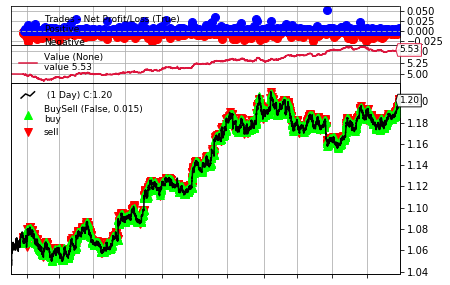

In [21]:
cerebro.plot(width=1000, stdstats=False)[0][0]

### Candles 30M 2018

In [22]:
# Create a cerebro entity
cerebro = bt.Cerebro(cheat_on_open=True, stdstats=False)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

# Add a strategy
cerebro.addstrategy(RLStrategy)

# Add analyzer
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='mytradeanalysis')
cerebro.addanalyzer(bt.analyzers.Returns, _name='myreturnanalysis')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='myddanalysis')
cerebro.addanalyzer(bt.analyzers.SQN, _name='mysqnanalysis')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysranalysis')
cerebro.addanalyzer(bt.analyzers.Calmar, _name='mycalmaranalysis')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='mypyanalysis')

my_date_parse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
dataframe = pd.read_csv(
    "../../data/duka/EURUSD-2018_01_01-2018_12_31.csv", 
    parse_dates=["time"], 
    index_col=0, 
    date_parser=my_date_parse
).sort_index()
# dataframe = add_technical_indicators(dataframe)

dataframe = add_technical_indicators_with_intervals(
    dataframe, 
    indicators=configs['model']['inputs']['technical_indicators'], 
    intervals=configs['model']['inputs']['intervals']
)

data = ExtendedPandasData(
    dataname=dataframe[
        start_date.strftime("2018-01-01 21:30:00") :
        end_date.strftime("2018-12-29 22:30:00")
    ],
    open="open",
    high="high",
    low="low",
    close="close",
    volume="volume"
)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(initial_cash)
cerebro.broker.set_coo(True)

# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
thestrats = cerebro.run()

Starting Portfolio Value: 5.00
2018-01-11, Close, 1.19598 - Net, 5.00000
2018-01-11, Close, 1.19654 - Net, 5.00000
2018-01-11, Close, 1.19668 - Net, 5.00000
2018-01-11, Close, 1.19590 - Net, 5.00000
2018-01-11, Close, 1.19537 - Net, 5.00000
2018-01-11, Close, 1.19466 - Net, 5.00000
2018-01-11, Close, 1.19471 - Net, 5.00000
2018-01-11, Close, 1.19496 - Net, 5.00000
2018-01-11, Close, 1.19527 - Net, 5.00000
2018-01-11, Close, 1.19466 - Net, 5.00000
2018-01-11, Close, 1.19423 - Net, 5.00000
2018-01-11, Close, 1.19428 - Net, 5.00000
2018-01-11, Close, 1.19401 - Net, 5.00000
2018-01-11, Close, 1.19331 - Net, 5.00000
2018-01-11, Close, 1.19382 - Net, 5.00000
2018-01-11, Close, 1.19417 - Net, 5.00000
2018-01-11, Close, 1.19481 - Net, 5.00000
2018-01-11, Close, 1.19479 - Net, 5.00000
2018-01-11, Close, 1.19468 - Net, 5.00000
2018-01-11, Close, 1.19497 - Net, 5.00000
2018-01-11, Close, 1.19437 - Net, 5.00000
2018-01-11, Close, 1.19370 - Net, 5.00000
2018-01-11, Close, 1.20039 - Net, 5.00000
201

Action:  1
2018-01-22, LONG, 1.22375
2018-01-22, BUY EXECUTED, Price: 1.2237, Cost: 1.2237, Comm 0.0000
2018-01-22, Close, 1.22411 - Net, 5.00145
Action:  1
2018-01-22, LONG, 1.22411
2018-01-22, BUY EXECUTED, Price: 1.2241, Cost: 1.2241, Comm 0.0000
2018-01-22, Close, 1.22419 - Net, 5.00168
Action:  1
2018-01-22, LONG, 1.22419
2018-01-22, BUY EXECUTED, Price: 1.2242, Cost: 1.2242, Comm 0.0000
2018-01-22, Close, 1.22495 - Net, 5.00472
Action:  2
2018-01-22, CLOSE LONG, 1.22495
2018-01-22, SELL EXECUTED, Price: 1.2249, Cost: 4.8951, Comm 0.0000
2018-01-22, OPERATION PROFIT, GROSS 0.0047, NET 0.0047
2018-01-22, Close, 1.22498 - Net, 5.00472
Action:  2
2018-01-22, SHORT, 1.2250
2018-01-22, SELL EXECUTED, Price: 1.2250, Cost: -1.2250, Comm 0.0000
2018-01-22, Close, 1.22658 - Net, 5.00314
Action:  2
2018-01-22, SHORT, 1.2266
2018-01-22, SELL EXECUTED, Price: 1.2266, Cost: -1.2266, Comm 0.0000
2018-01-22, Close, 1.22622 - Net, 5.00386
Action:  1
2018-01-22, CLOSE SHORT, 1.2262
2018-01-22, LON

Action:  2
2018-01-23, SHORT, 1.2291
2018-01-23, SELL EXECUTED, Price: 1.2291, Cost: -1.2291, Comm 0.0000
2018-01-23, Close, 1.22934 - Net, 5.01358
Action:  2
2018-01-23, SHORT, 1.2293
2018-01-23, SELL EXECUTED, Price: 1.2293, Cost: -1.2293, Comm 0.0000
2018-01-23, Close, 1.22804 - Net, 5.01876
Action:  1
2018-01-23, CLOSE SHORT, 1.2280
2018-01-23, LONG, 1.22804
2018-01-23, BUY EXECUTED, Price: 1.2281, Cost: -4.9127, Comm 0.0000
2018-01-23, BUY EXECUTED, Price: 1.2281, Cost: 1.2281, Comm 0.0000
2018-01-23, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2018-01-23, Close, 1.22764 - Net, 5.01831
Action:  1
2018-01-23, LONG, 1.22764
2018-01-23, BUY EXECUTED, Price: 1.2276, Cost: 1.2276, Comm 0.0000
2018-01-23, Close, 1.22842 - Net, 5.01987
Action:  1
2018-01-23, LONG, 1.22842
2018-01-23, BUY EXECUTED, Price: 1.2284, Cost: 1.2284, Comm 0.0000
2018-01-23, Close, 1.22794 - Net, 5.01841
Action:  1
2018-01-23, LONG, 1.22794
2018-01-23, BUY EXECUTED, Price: 1.2280, Cost: 1.2280, Comm 0.0000
2018-01

Action:  2
2018-01-24, CLOSE LONG, 1.23963
2018-01-24, SHORT, 1.2396
2018-01-24, SELL EXECUTED, Price: 1.2396, Cost: 1.2381, Comm 0.0000
2018-01-24, SELL EXECUTED, Price: 1.2396, Cost: -1.2396, Comm 0.0000
2018-01-24, OPERATION PROFIT, GROSS 0.0015, NET 0.0015
2018-01-24, Close, 1.23899 - Net, 5.05874
Action:  1
2018-01-24, CLOSE SHORT, 1.2390
2018-01-24, LONG, 1.23899
2018-01-24, BUY EXECUTED, Price: 1.2390, Cost: -1.2396, Comm 0.0000
2018-01-24, BUY EXECUTED, Price: 1.2390, Cost: 1.2390, Comm 0.0000
2018-01-24, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2018-01-24, Close, 1.23916 - Net, 5.05889
Action:  1
2018-01-24, LONG, 1.23916
2018-01-24, BUY EXECUTED, Price: 1.2392, Cost: 1.2392, Comm 0.0000
2018-01-24, Close, 1.23917 - Net, 5.05891
Action:  1
2018-01-24, LONG, 1.23917
2018-01-24, BUY EXECUTED, Price: 1.2392, Cost: 1.2392, Comm 0.0000
2018-01-24, Close, 1.24067 - Net, 5.06341
Action:  2
2018-01-24, CLOSE LONG, 1.24067
2018-01-24, SHORT, 1.2407
2018-01-24, SELL EXECUTED, Price: 1

Action:  1
2018-01-25, Close, 1.24955 - Net, 5.12023
Action:  1
2018-01-25, Close, 1.24846 - Net, 5.11587
Action:  1
2018-01-25, Close, 1.24126 - Net, 5.08707
Action:  1
2018-01-25, Close, 1.23906 - Net, 5.07827
Action:  1
2018-01-25, Close, 1.24099 - Net, 5.08599
Action:  1
2018-01-25, Close, 1.24065 - Net, 5.08463
Action:  1
2018-01-25, Close, 1.24123 - Net, 5.08695
Action:  1
2018-01-25, Close, 1.23978 - Net, 5.08115
Action:  1
2018-01-25, Close, 1.23849 - Net, 5.07599
Action:  1
2018-01-25, Close, 1.23743 - Net, 5.07175
Action:  1
2018-01-25, Close, 1.23916 - Net, 5.07867
Action:  2
2018-01-25, CLOSE LONG, 1.23916
2018-01-25, SELL EXECUTED, Price: 1.2392, Cost: 4.9987, Comm 0.0000
2018-01-25, OPERATION PROFIT, GROSS -0.0421, NET -0.0421
2018-01-25, Close, 1.23916 - Net, 5.07867
Action:  2
2018-01-25, SHORT, 1.2392
2018-01-26, SELL EXECUTED, Price: 1.2392, Cost: -1.2392, Comm 0.0000
2018-01-26, Close, 1.24021 - Net, 5.07762
Action:  2
2018-01-26, SHORT, 1.2402
2018-01-26, SELL EXECU

Action:  1
2018-01-29, CLOSE SHORT, 1.2346
2018-01-29, LONG, 1.23456
2018-01-29, BUY EXECUTED, Price: 1.2346, Cost: -4.9435, Comm 0.0000
2018-01-29, BUY EXECUTED, Price: 1.2346, Cost: 1.2346, Comm 0.0000
2018-01-29, OPERATION PROFIT, GROSS 0.0053, NET 0.0053
2018-01-29, Close, 1.23524 - Net, 5.04505
Action:  2
2018-01-29, CLOSE LONG, 1.23524
2018-01-29, SHORT, 1.2352
2018-01-29, SELL EXECUTED, Price: 1.2352, Cost: 1.2346, Comm 0.0000
2018-01-29, SELL EXECUTED, Price: 1.2352, Cost: -1.2352, Comm 0.0000
2018-01-29, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2018-01-29, Close, 1.23595 - Net, 5.04436
Action:  2
2018-01-29, SHORT, 1.2360
2018-01-29, SELL EXECUTED, Price: 1.2360, Cost: -1.2360, Comm 0.0000
2018-01-29, Close, 1.23717 - Net, 5.04192
Action:  2
2018-01-29, SHORT, 1.2372
2018-01-29, SELL EXECUTED, Price: 1.2372, Cost: -1.2372, Comm 0.0000
2018-01-29, Close, 1.23750 - Net, 5.04094
Action:  2
2018-01-29, SHORT, 1.2375
2018-01-29, SELL EXECUTED, Price: 1.2375, Cost: -1.2375, Comm 0

Action:  1
2018-01-31, Close, 1.24246 - Net, 5.03502
Action:  2
2018-01-31, CLOSE LONG, 1.24246
2018-01-31, SELL EXECUTED, Price: 1.2425, Cost: 4.9651, Comm 0.0000
2018-01-31, OPERATION PROFIT, GROSS 0.0047, NET 0.0047
2018-01-31, Close, 1.24241 - Net, 5.03506
Action:  1
2018-01-31, LONG, 1.24241
2018-01-31, BUY EXECUTED, Price: 1.2424, Cost: 1.2424, Comm 0.0000
2018-01-31, Close, 1.24244 - Net, 5.03507
Action:  2
2018-01-31, CLOSE LONG, 1.24244
2018-01-31, SHORT, 1.2424
2018-01-31, SELL EXECUTED, Price: 1.2424, Cost: 1.2424, Comm 0.0000
2018-01-31, SELL EXECUTED, Price: 1.2424, Cost: -1.2424, Comm 0.0000
2018-01-31, OPERATION PROFIT, GROSS 0.0000, NET 0.0000
2018-01-31, Close, 1.24196 - Net, 5.03555
Action:  1
2018-01-31, CLOSE SHORT, 1.2420
2018-01-31, LONG, 1.24196
2018-01-31, BUY EXECUTED, Price: 1.2420, Cost: -1.2424, Comm 0.0000
2018-01-31, BUY EXECUTED, Price: 1.2420, Cost: 1.2420, Comm 0.0000
2018-01-31, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2018-01-31, Close, 1.24248 - Ne

Action:  1
2018-02-01, CLOSE SHORT, 1.2403
2018-02-01, LONG, 1.24030
2018-02-01, BUY EXECUTED, Price: 1.2403, Cost: -1.2393, Comm 0.0000
2018-02-01, BUY EXECUTED, Price: 1.2403, Cost: 1.2403, Comm 0.0000
2018-02-01, OPERATION PROFIT, GROSS -0.0010, NET -0.0010
2018-02-01, Close, 1.24274 - Net, 5.02861
Action:  2
2018-02-01, CLOSE LONG, 1.24274
2018-02-01, SHORT, 1.2427
2018-02-01, SELL EXECUTED, Price: 1.2427, Cost: 1.2403, Comm 0.0000
2018-02-01, SELL EXECUTED, Price: 1.2427, Cost: -1.2427, Comm 0.0000
2018-02-01, OPERATION PROFIT, GROSS 0.0025, NET 0.0025
2018-02-01, Close, 1.24286 - Net, 5.02849
Action:  2
2018-02-01, SHORT, 1.2429
2018-02-01, SELL EXECUTED, Price: 1.2429, Cost: -1.2429, Comm 0.0000
2018-02-01, Close, 1.24472 - Net, 5.02476
Action:  2
2018-02-01, SHORT, 1.2447
2018-02-01, SELL EXECUTED, Price: 1.2447, Cost: -1.2447, Comm 0.0000
2018-02-01, Close, 1.24465 - Net, 5.02498
Action:  2
2018-02-01, SHORT, 1.2447
2018-02-01, SELL EXECUTED, Price: 1.2447, Cost: -1.2447, Comm

Action:  2
2018-02-02, CLOSE LONG, 1.24452
2018-02-02, SELL EXECUTED, Price: 1.2445, Cost: 4.9961, Comm 0.0000
2018-02-02, OPERATION PROFIT, GROSS -0.0180, NET -0.0180
2018-02-02, Close, 1.24586 - Net, 5.03836
Action:  1
2018-02-02, LONG, 1.24586
2018-02-02, BUY EXECUTED, Price: 1.2458, Cost: 1.2458, Comm 0.0000
2018-02-02, Close, 1.24286 - Net, 5.03538
Action:  2
2018-02-02, CLOSE LONG, 1.24286
2018-02-02, SHORT, 1.2429
2018-02-02, SELL EXECUTED, Price: 1.2429, Cost: 1.2458, Comm 0.0000
2018-02-02, SELL EXECUTED, Price: 1.2429, Cost: -1.2429, Comm 0.0000
2018-02-02, OPERATION PROFIT, GROSS -0.0030, NET -0.0030
2018-02-02, Close, 1.24239 - Net, 5.03585
Action:  2
2018-02-02, SHORT, 1.2424
2018-02-02, SELL EXECUTED, Price: 1.2424, Cost: -1.2424, Comm 0.0000
2018-02-02, Close, 1.24357 - Net, 5.03350
Action:  2
2018-02-02, SHORT, 1.2436
2018-02-02, SELL EXECUTED, Price: 1.2436, Cost: -1.2436, Comm 0.0000
2018-02-02, Close, 1.24403 - Net, 5.03213
Action:  2
2018-02-02, SHORT, 1.2440
2018-0

Action:  1
2018-02-06, CLOSE SHORT, 1.2376
2018-02-06, LONG, 1.23757
2018-02-06, BUY EXECUTED, Price: 1.2376, Cost: -3.7151, Comm 0.0000
2018-02-06, BUY EXECUTED, Price: 1.2376, Cost: 1.2376, Comm 0.0000
2018-02-06, OPERATION PROFIT, GROSS 0.0024, NET 0.0024
2018-02-06, Close, 1.23610 - Net, 4.99784
Action:  1
2018-02-06, LONG, 1.23610
2018-02-06, BUY EXECUTED, Price: 1.2361, Cost: 1.2361, Comm 0.0000
2018-02-06, Close, 1.23715 - Net, 4.99994
Action:  1
2018-02-06, LONG, 1.23715
2018-02-06, BUY EXECUTED, Price: 1.2371, Cost: 1.2371, Comm 0.0000
2018-02-06, Close, 1.23745 - Net, 5.00085
Action:  1
2018-02-06, LONG, 1.23745
2018-02-06, BUY EXECUTED, Price: 1.2374, Cost: 1.2374, Comm 0.0000
2018-02-06, Close, 1.23674 - Net, 4.99801
Action:  1
2018-02-06, Close, 1.23640 - Net, 4.99665
Action:  1
2018-02-06, Close, 1.23565 - Net, 4.99365
Action:  1
2018-02-06, Close, 1.23733 - Net, 5.00037
Action:  2
2018-02-06, CLOSE LONG, 1.23733
2018-02-06, SELL EXECUTED, Price: 1.2373, Cost: 4.9482, Com

Action:  1
2018-02-07, LONG, 1.23406
2018-02-07, BUY EXECUTED, Price: 1.2341, Cost: 1.2341, Comm 0.0000
2018-02-07, Close, 1.23374 - Net, 4.93057
Action:  1
2018-02-07, Close, 1.23371 - Net, 4.93048
Action:  1
2018-02-07, Close, 1.23426 - Net, 4.93213
Action:  2
2018-02-07, CLOSE LONG, 1.23426
2018-02-07, SHORT, 1.2343
2018-02-07, SELL EXECUTED, Price: 1.2343, Cost: 3.7032, Comm 0.0000
2018-02-07, SELL EXECUTED, Price: 1.2343, Cost: -1.2343, Comm 0.0000
2018-02-07, OPERATION PROFIT, GROSS -0.0004, NET -0.0004
2018-02-07, Close, 1.23162 - Net, 4.93477
Action:  2
2018-02-07, SHORT, 1.2316
2018-02-07, SELL EXECUTED, Price: 1.2316, Cost: -1.2316, Comm 0.0000
2018-02-07, Close, 1.22932 - Net, 4.93937
Action:  2
2018-02-07, SHORT, 1.2293
2018-02-07, SELL EXECUTED, Price: 1.2293, Cost: -1.2293, Comm 0.0000
2018-02-07, Close, 1.22866 - Net, 4.94134
Action:  2
2018-02-07, SHORT, 1.2287
2018-02-07, SELL EXECUTED, Price: 1.2287, Cost: -1.2287, Comm 0.0000
2018-02-07, Close, 1.22815 - Net, 4.94338

Action:  1
2018-02-08, Close, 1.22504 - Net, 4.97566
Action:  1
2018-02-08, Close, 1.22619 - Net, 4.98026
Action:  1
2018-02-08, Close, 1.22668 - Net, 4.98222
Action:  2
2018-02-08, CLOSE LONG, 1.22668
2018-02-08, SELL EXECUTED, Price: 1.2267, Cost: 4.9033, Comm 0.0000
2018-02-08, OPERATION PROFIT, GROSS 0.0034, NET 0.0034
2018-02-08, Close, 1.22658 - Net, 4.98218
Action:  1
2018-02-08, LONG, 1.22658
2018-02-08, BUY EXECUTED, Price: 1.2266, Cost: 1.2266, Comm 0.0000
2018-02-08, Close, 1.22643 - Net, 4.98201
Action:  1
2018-02-08, LONG, 1.22643
2018-02-08, BUY EXECUTED, Price: 1.2264, Cost: 1.2264, Comm 0.0000
2018-02-08, Close, 1.22548 - Net, 4.98012
Action:  1
2018-02-08, LONG, 1.22548
2018-02-08, BUY EXECUTED, Price: 1.2255, Cost: 1.2255, Comm 0.0000
2018-02-08, Close, 1.22436 - Net, 4.97676
Action:  1
2018-02-08, LONG, 1.22436
2018-02-08, BUY EXECUTED, Price: 1.2243, Cost: 1.2243, Comm 0.0000
2018-02-08, Close, 1.22478 - Net, 4.97846
Action:  1
2018-02-08, Close, 1.22474 - Net, 4.97

Action:  2
2018-02-12, CLOSE LONG, 1.22843
2018-02-12, SHORT, 1.2284
2018-02-12, SELL EXECUTED, Price: 1.2285, Cost: 2.4545, Comm 0.0000
2018-02-12, SELL EXECUTED, Price: 1.2285, Cost: -1.2285, Comm 0.0000
2018-02-12, OPERATION PROFIT, GROSS 0.0024, NET 0.0024
2018-02-12, Close, 1.22805 - Net, 4.98671
Action:  1
2018-02-12, CLOSE SHORT, 1.2281
2018-02-12, LONG, 1.22805
2018-02-12, BUY EXECUTED, Price: 1.2281, Cost: -1.2285, Comm 0.0000
2018-02-12, BUY EXECUTED, Price: 1.2281, Cost: 1.2281, Comm 0.0000
2018-02-12, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2018-02-12, Close, 1.22871 - Net, 4.98737
Action:  2
2018-02-12, CLOSE LONG, 1.22871
2018-02-12, SHORT, 1.2287
2018-02-12, SELL EXECUTED, Price: 1.2287, Cost: 1.2281, Comm 0.0000
2018-02-12, SELL EXECUTED, Price: 1.2287, Cost: -1.2287, Comm 0.0000
2018-02-12, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2018-02-12, Close, 1.22842 - Net, 4.98764
Action:  1
2018-02-12, CLOSE SHORT, 1.2284
2018-02-12, LONG, 1.22842
2018-02-12, BUY EXECUTED

Action:  2
2018-02-13, SHORT, 1.2305
2018-02-13, SELL EXECUTED, Price: 1.2305, Cost: -1.2305, Comm 0.0000
2018-02-13, Close, 1.23063 - Net, 4.99934
Action:  2
2018-02-13, SHORT, 1.2306
2018-02-13, SELL EXECUTED, Price: 1.2306, Cost: -1.2306, Comm 0.0000
2018-02-13, Close, 1.23139 - Net, 4.99782
Action:  2
2018-02-13, SHORT, 1.2314
2018-02-13, SELL EXECUTED, Price: 1.2314, Cost: -1.2314, Comm 0.0000
2018-02-13, Close, 1.23229 - Net, 4.99511
Action:  2
2018-02-13, SHORT, 1.2323
2018-02-13, SELL EXECUTED, Price: 1.2323, Cost: -1.2323, Comm 0.0000
2018-02-13, Close, 1.23170 - Net, 4.99748
Action:  1
2018-02-13, CLOSE SHORT, 1.2317
2018-02-13, LONG, 1.23170
2018-02-13, BUY EXECUTED, Price: 1.2317, Cost: -4.9248, Comm 0.0000
2018-02-13, BUY EXECUTED, Price: 1.2317, Cost: 1.2317, Comm 0.0000
2018-02-13, OPERATION PROFIT, GROSS -0.0020, NET -0.0020
2018-02-13, Close, 1.23135 - Net, 4.99713
Action:  1
2018-02-13, LONG, 1.23135
2018-02-13, BUY EXECUTED, Price: 1.2314, Cost: 1.2314, Comm 0.0000
2

Action:  1
2018-02-14, LONG, 1.23789
2018-02-14, BUY EXECUTED, Price: 1.2379, Cost: 1.2379, Comm 0.0000
2018-02-14, Close, 1.23768 - Net, 5.02523
Action:  1
2018-02-14, Close, 1.23740 - Net, 5.02411
Action:  1
2018-02-14, Close, 1.23742 - Net, 5.02419
Action:  1
2018-02-14, Close, 1.23729 - Net, 5.02367
Action:  1
2018-02-14, Close, 1.23661 - Net, 5.02095
Action:  1
2018-02-14, Close, 1.23664 - Net, 5.02107
Action:  1
2018-02-14, Close, 1.23637 - Net, 5.01999
Action:  1
2018-02-14, Close, 1.23532 - Net, 5.01579
Action:  1
2018-02-14, Close, 1.23501 - Net, 5.01455
Action:  1
2018-02-14, Close, 1.23568 - Net, 5.01723
Action:  1
2018-02-14, Close, 1.23462 - Net, 5.01299
Action:  1
2018-02-14, Close, 1.23426 - Net, 5.01155
Action:  1
2018-02-14, Close, 1.23425 - Net, 5.01151
Action:  1
2018-02-14, Close, 1.23436 - Net, 5.01195
Action:  1
2018-02-14, Close, 1.23480 - Net, 5.01371
Action:  2
2018-02-14, CLOSE LONG, 1.23480
2018-02-14, SELL EXECUTED, Price: 1.2348, Cost: 4.9515, Comm 0.0000
2

Action:  1
2018-02-15, Close, 1.24761 - Net, 4.99974
Action:  1
2018-02-15, Close, 1.24666 - Net, 4.99594
Action:  1
2018-02-15, Close, 1.24740 - Net, 4.99890
Action:  1
2018-02-15, Close, 1.24823 - Net, 5.00222
Action:  1
2018-02-15, Close, 1.24987 - Net, 5.00878
Action:  2
2018-02-15, CLOSE LONG, 1.24987
2018-02-15, SELL EXECUTED, Price: 1.2499, Cost: 4.9950, Comm 0.0000
2018-02-15, OPERATION PROFIT, GROSS 0.0044, NET 0.0044
2018-02-15, Close, 1.24873 - Net, 5.00874
Action:  1
2018-02-15, LONG, 1.24873
2018-02-15, BUY EXECUTED, Price: 1.2487, Cost: 1.2487, Comm 0.0000
2018-02-15, Close, 1.24775 - Net, 5.00780
Action:  1
2018-02-15, LONG, 1.24775
2018-02-15, BUY EXECUTED, Price: 1.2477, Cost: 1.2477, Comm 0.0000
2018-02-15, Close, 1.24875 - Net, 5.00980
Action:  1
2018-02-15, LONG, 1.24875
2018-02-15, BUY EXECUTED, Price: 1.2488, Cost: 1.2488, Comm 0.0000
2018-02-15, Close, 1.24826 - Net, 5.00832
Action:  1
2018-02-15, LONG, 1.24826
2018-02-15, BUY EXECUTED, Price: 1.2483, Cost: 1.248

Action:  1
2018-02-19, LONG, 1.24185
2018-02-19, BUY EXECUTED, Price: 1.2418, Cost: 1.2418, Comm 0.0000
2018-02-19, Close, 1.24160 - Net, 5.01531
Action:  1
2018-02-19, Close, 1.24143 - Net, 5.01463
Action:  1
2018-02-19, Close, 1.24097 - Net, 5.01279
Action:  1
2018-02-19, Close, 1.24063 - Net, 5.01143
Action:  2
2018-02-19, CLOSE LONG, 1.24063
2018-02-19, SELL EXECUTED, Price: 1.2406, Cost: 4.9690, Comm 0.0000
2018-02-19, OPERATION PROFIT, GROSS -0.0065, NET -0.0065
2018-02-19, Close, 1.24168 - Net, 5.01143
Action:  2
2018-02-19, SHORT, 1.2417
2018-02-19, SELL EXECUTED, Price: 1.2417, Cost: -1.2417, Comm 0.0000
2018-02-19, Close, 1.23987 - Net, 5.01324
Action:  1
2018-02-19, CLOSE SHORT, 1.2399
2018-02-19, LONG, 1.23987
2018-02-19, BUY EXECUTED, Price: 1.2399, Cost: -1.2417, Comm 0.0000
2018-02-19, BUY EXECUTED, Price: 1.2399, Cost: 1.2399, Comm 0.0000
2018-02-19, OPERATION PROFIT, GROSS 0.0018, NET 0.0018
2018-02-19, Close, 1.24126 - Net, 5.01465
Action:  1
2018-02-19, LONG, 1.24126

Action:  2
2018-02-20, Close, 1.23353 - Net, 5.00056
Action:  2
2018-02-20, Close, 1.23487 - Net, 4.99520
Action:  2
2018-02-20, Close, 1.23477 - Net, 4.99560
Action:  2
2018-02-20, Close, 1.23462 - Net, 4.99620
Action:  2
2018-02-20, Close, 1.23397 - Net, 4.99880
Action:  2
2018-02-20, Close, 1.23258 - Net, 5.00436
Action:  2
2018-02-20, Close, 1.23554 - Net, 4.99252
Action:  2
2018-02-20, Close, 1.23462 - Net, 4.99620
Action:  1
2018-02-20, CLOSE SHORT, 1.2346
2018-02-20, LONG, 1.23462
2018-02-20, BUY EXECUTED, Price: 1.2346, Cost: -4.9418, Comm 0.0000
2018-02-20, BUY EXECUTED, Price: 1.2346, Cost: 1.2346, Comm 0.0000
2018-02-20, OPERATION PROFIT, GROSS 0.0034, NET 0.0034
2018-02-20, Close, 1.23469 - Net, 4.99637
Action:  1
2018-02-20, LONG, 1.23469
2018-02-20, BUY EXECUTED, Price: 1.2347, Cost: 1.2347, Comm 0.0000
2018-02-20, Close, 1.23409 - Net, 4.99519
Action:  1
2018-02-20, LONG, 1.23409
2018-02-20, BUY EXECUTED, Price: 1.2341, Cost: 1.2341, Comm 0.0000
2018-02-20, Close, 1.2336

Action:  1
2018-02-21, LONG, 1.23199
2018-02-21, BUY EXECUTED, Price: 1.2320, Cost: 1.2320, Comm 0.0000
2018-02-21, Close, 1.23042 - Net, 5.00337
Action:  1
2018-02-21, LONG, 1.23042
2018-02-21, BUY EXECUTED, Price: 1.2304, Cost: 1.2304, Comm 0.0000
2018-02-21, Close, 1.23150 - Net, 5.00769
Action:  1
2018-02-21, Close, 1.23161 - Net, 5.00813
Action:  1
2018-02-21, Close, 1.23273 - Net, 5.01261
Action:  1
2018-02-21, Close, 1.23253 - Net, 5.01181
Action:  1
2018-02-21, Close, 1.23252 - Net, 5.01177
Action:  1
2018-02-21, Close, 1.23253 - Net, 5.01181
Action:  1
2018-02-21, Close, 1.23026 - Net, 5.00273
Action:  1
2018-02-21, Close, 1.22963 - Net, 5.00021
Action:  1
2018-02-21, Close, 1.22906 - Net, 4.99793
Action:  1
2018-02-21, Close, 1.22875 - Net, 4.99669
Action:  2
2018-02-21, CLOSE LONG, 1.22875
2018-02-21, SELL EXECUTED, Price: 1.2288, Cost: 4.9273, Comm 0.0000
2018-02-21, OPERATION PROFIT, GROSS -0.0123, NET -0.0123
2018-02-21, Close, 1.22836 - Net, 4.99669
Action:  2
2018-02-21

Action:  1
2018-02-23, CLOSE SHORT, 1.2311
2018-02-23, LONG, 1.23112
2018-02-23, BUY EXECUTED, Price: 1.2311, Cost: -2.4626, Comm 0.0000
2018-02-23, BUY EXECUTED, Price: 1.2311, Cost: 1.2311, Comm 0.0000
2018-02-23, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-02-23, Close, 1.23082 - Net, 5.00192
Action:  1
2018-02-23, LONG, 1.23082
2018-02-23, BUY EXECUTED, Price: 1.2308, Cost: 1.2308, Comm 0.0000
2018-02-23, Close, 1.23167 - Net, 5.00360
Action:  1
2018-02-23, LONG, 1.23167
2018-02-23, BUY EXECUTED, Price: 1.2317, Cost: 1.2317, Comm 0.0000
2018-02-23, Close, 1.23012 - Net, 4.99895
Action:  1
2018-02-23, LONG, 1.23012
2018-02-23, BUY EXECUTED, Price: 1.2301, Cost: 1.2301, Comm 0.0000
2018-02-23, Close, 1.23012 - Net, 4.99894
Action:  1
2018-02-23, Close, 1.23065 - Net, 5.00106
Action:  1
2018-02-23, Close, 1.23068 - Net, 5.00118
Action:  1
2018-02-23, Close, 1.22980 - Net, 4.99766
Action:  1
2018-02-23, Close, 1.22940 - Net, 4.99606
Action:  1
2018-02-23, Close, 1.22981 - Net, 4.99

Action:  2
2018-02-26, SHORT, 1.2313
2018-02-26, SELL EXECUTED, Price: 1.2313, Cost: -1.2313, Comm 0.0000
2018-02-26, Close, 1.23173 - Net, 5.00332
Action:  2
2018-02-26, SHORT, 1.2317
2018-02-26, SELL EXECUTED, Price: 1.2317, Cost: -1.2317, Comm 0.0000
2018-02-26, Close, 1.23177 - Net, 5.00315
Action:  2
2018-02-26, Close, 1.23156 - Net, 5.00399
Action:  1
2018-02-26, CLOSE SHORT, 1.2316
2018-02-26, LONG, 1.23156
2018-02-26, BUY EXECUTED, Price: 1.2315, Cost: -4.9255, Comm 0.0000
2018-02-26, BUY EXECUTED, Price: 1.2315, Cost: 1.2315, Comm 0.0000
2018-02-26, OPERATION PROFIT, GROSS -0.0007, NET -0.0007
2018-02-26, Close, 1.23134 - Net, 5.00382
Action:  1
2018-02-26, LONG, 1.23134
2018-02-26, BUY EXECUTED, Price: 1.2313, Cost: 1.2313, Comm 0.0000
2018-02-26, Close, 1.23100 - Net, 5.00313
Action:  1
2018-02-26, LONG, 1.23100
2018-02-26, BUY EXECUTED, Price: 1.2310, Cost: 1.2310, Comm 0.0000
2018-02-26, Close, 1.23156 - Net, 5.00481
Action:  1
2018-02-26, LONG, 1.23156
2018-02-27, BUY EXE

Action:  1
2018-02-28, Close, 1.22239 - Net, 5.02460
Action:  1
2018-02-28, Close, 1.22244 - Net, 5.02480
Action:  1
2018-02-28, Close, 1.22221 - Net, 5.02388
Action:  1
2018-02-28, Close, 1.22273 - Net, 5.02596
Action:  2
2018-02-28, CLOSE LONG, 1.22273
2018-02-28, SELL EXECUTED, Price: 1.2227, Cost: 4.8901, Comm 0.0000
2018-02-28, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2018-02-28, Close, 1.22248 - Net, 5.02596
Action:  1
2018-02-28, LONG, 1.22248
2018-02-28, BUY EXECUTED, Price: 1.2225, Cost: 1.2225, Comm 0.0000
2018-02-28, Close, 1.22362 - Net, 5.02708
Action:  2
2018-02-28, CLOSE LONG, 1.22362
2018-02-28, SHORT, 1.2236
2018-02-28, SELL EXECUTED, Price: 1.2236, Cost: 1.2225, Comm 0.0000
2018-02-28, SELL EXECUTED, Price: 1.2236, Cost: -1.2236, Comm 0.0000
2018-02-28, OPERATION PROFIT, GROSS 0.0011, NET 0.0011
2018-02-28, Close, 1.22367 - Net, 5.02703
Action:  2
2018-02-28, SHORT, 1.2237
2018-02-28, SELL EXECUTED, Price: 1.2237, Cost: -1.2237, Comm 0.0000
2018-02-28, Close, 1.2224

Action:  1
2018-03-01, LONG, 1.21751
2018-03-01, BUY EXECUTED, Price: 1.2175, Cost: 1.2175, Comm 0.0000
2018-03-01, Close, 1.21875 - Net, 5.02331
Action:  2
2018-03-01, CLOSE LONG, 1.21875
2018-03-01, SHORT, 1.2188
2018-03-01, SELL EXECUTED, Price: 1.2188, Cost: 1.2175, Comm 0.0000
2018-03-01, SELL EXECUTED, Price: 1.2188, Cost: -1.2188, Comm 0.0000
2018-03-01, OPERATION PROFIT, GROSS 0.0013, NET 0.0013
2018-03-01, Close, 1.21770 - Net, 5.02436
Action:  1
2018-03-01, CLOSE SHORT, 1.2177
2018-03-01, LONG, 1.21770
2018-03-01, BUY EXECUTED, Price: 1.2177, Cost: -1.2188, Comm 0.0000
2018-03-01, BUY EXECUTED, Price: 1.2177, Cost: 1.2177, Comm 0.0000
2018-03-01, OPERATION PROFIT, GROSS 0.0011, NET 0.0011
2018-03-01, Close, 1.21742 - Net, 5.02414
Action:  1
2018-03-01, LONG, 1.21742
2018-03-01, BUY EXECUTED, Price: 1.2173, Cost: 1.2173, Comm 0.0000
2018-03-01, Close, 1.21753 - Net, 5.02448
Action:  1
2018-03-01, LONG, 1.21753
2018-03-01, BUY EXECUTED, Price: 1.2175, Cost: 1.2175, Comm 0.0000


Action:  1
2018-03-02, LONG, 1.23070
2018-03-02, BUY EXECUTED, Price: 1.2307, Cost: 1.2307, Comm 0.0000
2018-03-02, Close, 1.23123 - Net, 5.05346
Action:  1
2018-03-02, Close, 1.23201 - Net, 5.05658
Action:  1
2018-03-02, Close, 1.23218 - Net, 5.05726
Action:  1
2018-03-02, Close, 1.23245 - Net, 5.05834
Action:  2
2018-03-02, CLOSE LONG, 1.23245
2018-03-02, SELL EXECUTED, Price: 1.2324, Cost: 4.9245, Comm 0.0000
2018-03-02, OPERATION PROFIT, GROSS 0.0053, NET 0.0053
2018-03-02, Close, 1.23310 - Net, 5.05830
Action:  2
2018-03-02, SHORT, 1.2331
2018-03-02, SELL EXECUTED, Price: 1.2332, Cost: -1.2332, Comm 0.0000
2018-03-02, Close, 1.23303 - Net, 5.05844
Action:  2
2018-03-02, SHORT, 1.2330
2018-03-02, SELL EXECUTED, Price: 1.2330, Cost: -1.2330, Comm 0.0000
2018-03-02, Close, 1.23310 - Net, 5.05831
Action:  2
2018-03-02, SHORT, 1.2331
2018-03-02, SELL EXECUTED, Price: 1.2331, Cost: -1.2331, Comm 0.0000
2018-03-02, Close, 1.23256 - Net, 5.05992
Action:  1
2018-03-02, CLOSE SHORT, 1.2326


Action:  2
2018-03-06, CLOSE LONG, 1.23470
2018-03-06, SELL EXECUTED, Price: 1.2346, Cost: 4.9341, Comm 0.0000
2018-03-06, OPERATION PROFIT, GROSS 0.0044, NET 0.0044
2018-03-06, Close, 1.23501 - Net, 5.06491
Action:  2
2018-03-06, SHORT, 1.2350
2018-03-06, SELL EXECUTED, Price: 1.2350, Cost: -1.2350, Comm 0.0000
2018-03-06, Close, 1.23576 - Net, 5.06416
Action:  2
2018-03-06, SHORT, 1.2358
2018-03-06, SELL EXECUTED, Price: 1.2357, Cost: -1.2357, Comm 0.0000
2018-03-06, Close, 1.23561 - Net, 5.06444
Action:  2
2018-03-06, SHORT, 1.2356
2018-03-06, SELL EXECUTED, Price: 1.2356, Cost: -1.2356, Comm 0.0000
2018-03-06, Close, 1.23536 - Net, 5.06519
Action:  1
2018-03-06, CLOSE SHORT, 1.2354
2018-03-06, LONG, 1.23536
2018-03-06, BUY EXECUTED, Price: 1.2354, Cost: -3.7064, Comm 0.0000
2018-03-06, BUY EXECUTED, Price: 1.2354, Cost: 1.2354, Comm 0.0000
2018-03-06, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-03-06, Close, 1.23507 - Net, 5.06490
Action:  1
2018-03-06, LONG, 1.23507
2018-03-06

Action:  1
2018-03-07, Close, 1.24238 - Net, 5.11518
Action:  2
2018-03-07, CLOSE LONG, 1.24238
2018-03-07, SELL EXECUTED, Price: 1.2424, Cost: 4.9646, Comm 0.0000
2018-03-07, OPERATION PROFIT, GROSS 0.0048, NET 0.0048
2018-03-07, Close, 1.24288 - Net, 5.11506
Action:  2
2018-03-07, SHORT, 1.2429
2018-03-07, SELL EXECUTED, Price: 1.2429, Cost: -1.2429, Comm 0.0000
2018-03-07, Close, 1.24349 - Net, 5.11445
Action:  2
2018-03-07, SHORT, 1.2435
2018-03-07, SELL EXECUTED, Price: 1.2435, Cost: -1.2435, Comm 0.0000
2018-03-07, Close, 1.24254 - Net, 5.11636
Action:  1
2018-03-07, CLOSE SHORT, 1.2425
2018-03-07, LONG, 1.24254
2018-03-07, BUY EXECUTED, Price: 1.2425, Cost: -2.4864, Comm 0.0000
2018-03-07, BUY EXECUTED, Price: 1.2425, Cost: 1.2425, Comm 0.0000
2018-03-07, OPERATION PROFIT, GROSS 0.0013, NET 0.0013
2018-03-07, Close, 1.24076 - Net, 5.11458
Action:  1
2018-03-07, LONG, 1.24076
2018-03-07, BUY EXECUTED, Price: 1.2407, Cost: 1.2407, Comm 0.0000
2018-03-07, Close, 1.24076 - Net, 5.11

Action:  2
2018-03-08, SHORT, 1.2428
2018-03-08, SELL EXECUTED, Price: 1.2428, Cost: -1.2428, Comm 0.0000
2018-03-08, Close, 1.24031 - Net, 5.12178
Action:  1
2018-03-08, CLOSE SHORT, 1.2403
2018-03-08, LONG, 1.24031
2018-03-08, BUY EXECUTED, Price: 1.2403, Cost: -2.4838, Comm 0.0000
2018-03-08, BUY EXECUTED, Price: 1.2403, Cost: 1.2403, Comm 0.0000
2018-03-08, OPERATION PROFIT, GROSS 0.0032, NET 0.0032
2018-03-08, Close, 1.23797 - Net, 5.11944
Action:  1
2018-03-08, LONG, 1.23797
2018-03-08, BUY EXECUTED, Price: 1.2379, Cost: 1.2379, Comm 0.0000
2018-03-08, Close, 1.23512 - Net, 5.11378
Action:  1
2018-03-08, LONG, 1.23512
2018-03-08, BUY EXECUTED, Price: 1.2351, Cost: 1.2351, Comm 0.0000
2018-03-08, Close, 1.23456 - Net, 5.11211
Action:  1
2018-03-08, LONG, 1.23456
2018-03-08, BUY EXECUTED, Price: 1.2346, Cost: 1.2346, Comm 0.0000
2018-03-08, Close, 1.23280 - Net, 5.10508
Action:  2
2018-03-08, CLOSE LONG, 1.23280
2018-03-08, SELL EXECUTED, Price: 1.2328, Cost: 4.9479, Comm 0.0000
20

Action:  1
2018-03-09, LONG, 1.23127
2018-03-09, BUY EXECUTED, Price: 1.2313, Cost: 1.2313, Comm 0.0000
2018-03-09, Close, 1.23175 - Net, 5.09760
Action:  1
2018-03-09, Close, 1.23146 - Net, 5.09644
Action:  1
2018-03-09, Close, 1.23066 - Net, 5.09324
Action:  1
2018-03-09, Close, 1.23069 - Net, 5.09336
Action:  1
2018-03-09, Close, 1.23082 - Net, 5.09388
Action:  1
2018-03-09, Close, 1.23061 - Net, 5.09304
Action:  1
2018-03-11, Close, 1.23110 - Net, 5.09500
Action:  1
2018-03-11, Close, 1.23126 - Net, 5.09564
Action:  1
2018-03-11, Close, 1.23084 - Net, 5.09396
Action:  1
2018-03-11, Close, 1.23109 - Net, 5.09496
Action:  1
2018-03-11, Close, 1.23071 - Net, 5.09344
Action:  1
2018-03-11, Close, 1.23088 - Net, 5.09412
Action:  1
2018-03-12, Close, 1.23081 - Net, 5.09384
Action:  1
2018-03-12, Close, 1.23108 - Net, 5.09492
Action:  1
2018-03-12, Close, 1.23092 - Net, 5.09428
Action:  1
2018-03-12, Close, 1.23169 - Net, 5.09736
Action:  2
2018-03-12, CLOSE LONG, 1.23169
2018-03-12, SELL

Action:  1
2018-03-13, CLOSE SHORT, 1.2340
2018-03-13, LONG, 1.23403
2018-03-13, BUY EXECUTED, Price: 1.2340, Cost: -1.2343, Comm 0.0000
2018-03-13, BUY EXECUTED, Price: 1.2340, Cost: 1.2340, Comm 0.0000
2018-03-13, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-03-13, Close, 1.23384 - Net, 5.10050
Action:  1
2018-03-13, LONG, 1.23384
2018-03-13, BUY EXECUTED, Price: 1.2338, Cost: 1.2338, Comm 0.0000
2018-03-13, Close, 1.23393 - Net, 5.10068
Action:  1
2018-03-13, LONG, 1.23393
2018-03-13, BUY EXECUTED, Price: 1.2339, Cost: 1.2339, Comm 0.0000
2018-03-13, Close, 1.23358 - Net, 5.09962
Action:  1
2018-03-13, LONG, 1.23358
2018-03-13, BUY EXECUTED, Price: 1.2336, Cost: 1.2336, Comm 0.0000
2018-03-13, Close, 1.23343 - Net, 5.09903
Action:  1
2018-03-13, Close, 1.23343 - Net, 5.09903
Action:  1
2018-03-13, Close, 1.23324 - Net, 5.09827
Action:  1
2018-03-13, Close, 1.23314 - Net, 5.09787
Action:  1
2018-03-13, Close, 1.23279 - Net, 5.09647
Action:  1
2018-03-13, Close, 1.23283 - Net, 5.09

Action:  1
2018-03-14, LONG, 1.23669
2018-03-14, BUY EXECUTED, Price: 1.2367, Cost: 1.2367, Comm 0.0000
2018-03-14, Close, 1.23662 - Net, 5.10773
Action:  1
2018-03-14, LONG, 1.23662
2018-03-14, BUY EXECUTED, Price: 1.2366, Cost: 1.2366, Comm 0.0000
2018-03-14, Close, 1.23742 - Net, 5.11094
Action:  2
2018-03-14, CLOSE LONG, 1.23742
2018-03-14, SELL EXECUTED, Price: 1.2374, Cost: 4.9486, Comm 0.0000
2018-03-14, OPERATION PROFIT, GROSS 0.0011, NET 0.0011
2018-03-14, Close, 1.23752 - Net, 5.11098
Action:  2
2018-03-14, SHORT, 1.2375
2018-03-14, SELL EXECUTED, Price: 1.2375, Cost: -1.2375, Comm 0.0000
2018-03-14, Close, 1.23807 - Net, 5.11043
Action:  2
2018-03-14, SHORT, 1.2381
2018-03-14, SELL EXECUTED, Price: 1.2381, Cost: -1.2381, Comm 0.0000
2018-03-14, Close, 1.23837 - Net, 5.10984
Action:  2
2018-03-14, SHORT, 1.2384
2018-03-14, SELL EXECUTED, Price: 1.2384, Cost: -1.2384, Comm 0.0000
2018-03-14, Close, 1.23630 - Net, 5.11603
Action:  1
2018-03-14, CLOSE SHORT, 1.2363
2018-03-14, L

Action:  2
2018-03-15, Close, 1.23326 - Net, 5.11752
Action:  2
2018-03-15, Close, 1.23198 - Net, 5.12264
Action:  2
2018-03-15, Close, 1.23195 - Net, 5.12276
Action:  2
2018-03-15, Close, 1.23162 - Net, 5.12408
Action:  2
2018-03-15, Close, 1.23195 - Net, 5.12276
Action:  2
2018-03-15, Close, 1.23352 - Net, 5.11648
Action:  2
2018-03-15, Close, 1.23170 - Net, 5.12376
Action:  1
2018-03-15, CLOSE SHORT, 1.2317
2018-03-15, LONG, 1.23170
2018-03-15, BUY EXECUTED, Price: 1.2317, Cost: -4.9361, Comm 0.0000
2018-03-15, BUY EXECUTED, Price: 1.2317, Cost: 1.2317, Comm 0.0000
2018-03-15, OPERATION PROFIT, GROSS 0.0092, NET 0.0092
2018-03-15, Close, 1.23033 - Net, 5.12229
Action:  1
2018-03-15, LONG, 1.23033
2018-03-15, BUY EXECUTED, Price: 1.2303, Cost: 1.2303, Comm 0.0000
2018-03-15, Close, 1.23048 - Net, 5.12260
Action:  1
2018-03-15, LONG, 1.23048
2018-03-15, BUY EXECUTED, Price: 1.2305, Cost: 1.2305, Comm 0.0000
2018-03-15, Close, 1.23015 - Net, 5.12161
Action:  1
2018-03-15, LONG, 1.23015

Action:  1
2018-03-18, Close, 1.22846 - Net, 5.09905
Action:  1
2018-03-18, Close, 1.22810 - Net, 5.09761
Action:  1
2018-03-19, Close, 1.22717 - Net, 5.09389
Action:  1
2018-03-19, Close, 1.22713 - Net, 5.09373
Action:  1
2018-03-19, Close, 1.22664 - Net, 5.09177
Action:  2
2018-03-19, CLOSE LONG, 1.22664
2018-03-19, SELL EXECUTED, Price: 1.2266, Cost: 4.9144, Comm 0.0000
2018-03-19, OPERATION PROFIT, GROSS -0.0079, NET -0.0079
2018-03-19, Close, 1.22695 - Net, 5.09173
Action:  1
2018-03-19, LONG, 1.22695
2018-03-19, BUY EXECUTED, Price: 1.2269, Cost: 1.2269, Comm 0.0000
2018-03-19, Close, 1.22693 - Net, 5.09171
Action:  1
2018-03-19, LONG, 1.22693
2018-03-19, BUY EXECUTED, Price: 1.2269, Cost: 1.2269, Comm 0.0000
2018-03-19, Close, 1.22711 - Net, 5.09209
Action:  2
2018-03-19, CLOSE LONG, 1.22711
2018-03-19, SHORT, 1.2271
2018-03-19, SELL EXECUTED, Price: 1.2271, Cost: 2.4539, Comm 0.0000
2018-03-19, SELL EXECUTED, Price: 1.2271, Cost: -1.2271, Comm 0.0000
2018-03-19, OPERATION PROFI

Action:  2
2018-03-20, SHORT, 1.2341
2018-03-20, SELL EXECUTED, Price: 1.2341, Cost: -1.2341, Comm 0.0000
2018-03-20, Close, 1.23413 - Net, 5.10220
Action:  2
2018-03-20, SHORT, 1.2341
2018-03-20, SELL EXECUTED, Price: 1.2341, Cost: -1.2341, Comm 0.0000
2018-03-20, Close, 1.23463 - Net, 5.10118
Action:  2
2018-03-20, SHORT, 1.2346
2018-03-20, SELL EXECUTED, Price: 1.2346, Cost: -1.2346, Comm 0.0000
2018-03-20, Close, 1.23487 - Net, 5.10047
Action:  2
2018-03-20, SHORT, 1.2349
2018-03-20, SELL EXECUTED, Price: 1.2349, Cost: -1.2349, Comm 0.0000
2018-03-20, Close, 1.23458 - Net, 5.10163
Action:  1
2018-03-20, CLOSE SHORT, 1.2346
2018-03-20, LONG, 1.23458
2018-03-20, BUY EXECUTED, Price: 1.2346, Cost: -4.9378, Comm 0.0000
2018-03-20, BUY EXECUTED, Price: 1.2346, Cost: 1.2346, Comm 0.0000
2018-03-20, OPERATION PROFIT, GROSS -0.0006, NET -0.0006
2018-03-20, Close, 1.23460 - Net, 5.10165
Action:  1
2018-03-20, LONG, 1.23460
2018-03-20, BUY EXECUTED, Price: 1.2346, Cost: 1.2346, Comm 0.0000
2

Action:  1
2018-03-21, LONG, 1.22755
2018-03-21, BUY EXECUTED, Price: 1.2276, Cost: 1.2276, Comm 0.0000
2018-03-21, Close, 1.22785 - Net, 5.10272
Action:  1
2018-03-21, LONG, 1.22785
2018-03-21, BUY EXECUTED, Price: 1.2279, Cost: 1.2279, Comm 0.0000
2018-03-21, Close, 1.22826 - Net, 5.10392
Action:  2
2018-03-21, CLOSE LONG, 1.22826
2018-03-21, SHORT, 1.2283
2018-03-21, SELL EXECUTED, Price: 1.2283, Cost: 3.6834, Comm 0.0000
2018-03-21, SELL EXECUTED, Price: 1.2283, Cost: -1.2283, Comm 0.0000
2018-03-21, OPERATION PROFIT, GROSS 0.0013, NET 0.0013
2018-03-21, Close, 1.22829 - Net, 5.10389
Action:  2
2018-03-21, SHORT, 1.2283
2018-03-21, SELL EXECUTED, Price: 1.2283, Cost: -1.2283, Comm 0.0000
2018-03-21, Close, 1.22733 - Net, 5.10581
Action:  1
2018-03-21, CLOSE SHORT, 1.2273
2018-03-21, LONG, 1.22733
2018-03-21, BUY EXECUTED, Price: 1.2273, Cost: -2.4566, Comm 0.0000
2018-03-21, BUY EXECUTED, Price: 1.2273, Cost: 1.2273, Comm 0.0000
2018-03-21, OPERATION PROFIT, GROSS 0.0019, NET 0.001

Action:  1
2018-03-22, Close, 1.23183 - Net, 5.11416
Action:  1
2018-03-22, Close, 1.23233 - Net, 5.11616
Action:  1
2018-03-22, Close, 1.23239 - Net, 5.11640
Action:  1
2018-03-22, Close, 1.23236 - Net, 5.11628
Action:  1
2018-03-22, Close, 1.23135 - Net, 5.11224
Action:  1
2018-03-22, Close, 1.23095 - Net, 5.11064
Action:  2
2018-03-22, CLOSE LONG, 1.23095
2018-03-22, SELL EXECUTED, Price: 1.2310, Cost: 4.9442, Comm 0.0000
2018-03-22, OPERATION PROFIT, GROSS -0.0203, NET -0.0203
2018-03-22, Close, 1.23221 - Net, 5.11072
Action:  2
2018-03-22, SHORT, 1.2322
2018-03-22, SELL EXECUTED, Price: 1.2322, Cost: -1.2322, Comm 0.0000
2018-03-22, Close, 1.23198 - Net, 5.11093
Action:  1
2018-03-22, CLOSE SHORT, 1.2320
2018-03-22, LONG, 1.23198
2018-03-22, BUY EXECUTED, Price: 1.2320, Cost: -1.2322, Comm 0.0000
2018-03-22, BUY EXECUTED, Price: 1.2320, Cost: 1.2320, Comm 0.0000
2018-03-22, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-03-22, Close, 1.23090 - Net, 5.10987
Action:  1
2018-03-22, 

Action:  1
2018-03-23, LONG, 1.23368
2018-03-23, BUY EXECUTED, Price: 1.2337, Cost: 1.2337, Comm 0.0000
2018-03-23, Close, 1.23462 - Net, 5.13133
Action:  1
2018-03-23, LONG, 1.23462
2018-03-23, BUY EXECUTED, Price: 1.2346, Cost: 1.2346, Comm 0.0000
2018-03-23, Close, 1.23375 - Net, 5.12784
Action:  1
2018-03-23, Close, 1.23510 - Net, 5.13324
Action:  1
2018-03-23, Close, 1.23587 - Net, 5.13632
Action:  2
2018-03-23, CLOSE LONG, 1.23587
2018-03-23, SELL EXECUTED, Price: 1.2359, Cost: 4.9357, Comm 0.0000
2018-03-23, OPERATION PROFIT, GROSS 0.0077, NET 0.0077
2018-03-23, Close, 1.23543 - Net, 5.13632
Action:  1
2018-03-23, LONG, 1.23543
2018-03-23, BUY EXECUTED, Price: 1.2354, Cost: 1.2354, Comm 0.0000
2018-03-23, Close, 1.23629 - Net, 5.13718
Action:  1
2018-03-23, LONG, 1.23629
2018-03-23, BUY EXECUTED, Price: 1.2363, Cost: 1.2363, Comm 0.0000
2018-03-23, Close, 1.23648 - Net, 5.13756
Action:  2
2018-03-23, CLOSE LONG, 1.23648
2018-03-23, SHORT, 1.2365
2018-03-23, SELL EXECUTED, Price:

2018-03-26, SELL EXECUTED, Price: 1.2448, Cost: -1.2448, Comm 0.0000
2018-03-26, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-03-26, Close, 1.24528 - Net, 5.15854
Action:  2
2018-03-26, SHORT, 1.2453
2018-03-26, SELL EXECUTED, Price: 1.2453, Cost: -1.2453, Comm 0.0000
2018-03-26, Close, 1.24610 - Net, 5.15690
Action:  2
2018-03-26, SHORT, 1.2461
2018-03-26, SELL EXECUTED, Price: 1.2461, Cost: -1.2461, Comm 0.0000
2018-03-26, Close, 1.24554 - Net, 5.15855
Action:  1
2018-03-26, CLOSE SHORT, 1.2455
2018-03-26, LONG, 1.24554
2018-03-26, BUY EXECUTED, Price: 1.2455, Cost: -3.7361, Comm 0.0000
2018-03-26, BUY EXECUTED, Price: 1.2455, Cost: 1.2455, Comm 0.0000
2018-03-26, OPERATION PROFIT, GROSS -0.0003, NET -0.0003
2018-03-26, Close, 1.24517 - Net, 5.15838
Action:  1
2018-03-26, LONG, 1.24517
2018-03-26, BUY EXECUTED, Price: 1.2452, Cost: 1.2452, Comm 0.0000
2018-03-26, Close, 1.24520 - Net, 5.15839
Action:  1
2018-03-26, LONG, 1.24520
2018-03-26, BUY EXECUTED, Price: 1.2452, Cost: 1.245

Action:  1
2018-03-28, LONG, 1.24085
2018-03-28, BUY EXECUTED, Price: 1.2408, Cost: 1.2408, Comm 0.0000
2018-03-28, Close, 1.24068 - Net, 5.15504
Action:  1
2018-03-28, LONG, 1.24068
2018-03-28, BUY EXECUTED, Price: 1.2407, Cost: 1.2407, Comm 0.0000
2018-03-28, Close, 1.24075 - Net, 5.15527
Action:  1
2018-03-28, LONG, 1.24075
2018-03-28, BUY EXECUTED, Price: 1.2407, Cost: 1.2407, Comm 0.0000
2018-03-28, Close, 1.23961 - Net, 5.15075
Action:  2
2018-03-28, CLOSE LONG, 1.23961
2018-03-28, SELL EXECUTED, Price: 1.2396, Cost: 4.9641, Comm 0.0000
2018-03-28, OPERATION PROFIT, GROSS -0.0056, NET -0.0056
2018-03-28, Close, 1.23939 - Net, 5.15079
Action:  2
2018-03-28, SHORT, 1.2394
2018-03-28, SELL EXECUTED, Price: 1.2394, Cost: -1.2394, Comm 0.0000
2018-03-28, Close, 1.23853 - Net, 5.15165
Action:  2
2018-03-28, SHORT, 1.2385
2018-03-28, SELL EXECUTED, Price: 1.2385, Cost: -1.2385, Comm 0.0000
2018-03-28, Close, 1.23990 - Net, 5.14891
Action:  1
2018-03-28, CLOSE SHORT, 1.2399
2018-03-28, L

Action:  1
2018-03-29, LONG, 1.22989
2018-03-29, BUY EXECUTED, Price: 1.2299, Cost: 1.2299, Comm 0.0000
2018-03-29, Close, 1.22966 - Net, 5.15651
Action:  1
2018-03-29, LONG, 1.22966
2018-03-29, BUY EXECUTED, Price: 1.2296, Cost: 1.2296, Comm 0.0000
2018-03-29, Close, 1.22881 - Net, 5.15312
Action:  2
2018-03-29, CLOSE LONG, 1.22881
2018-03-29, SELL EXECUTED, Price: 1.2288, Cost: 4.9240, Comm 0.0000
2018-03-29, OPERATION PROFIT, GROSS -0.0088, NET -0.0088
2018-03-29, Close, 1.22945 - Net, 5.15316
Action:  1
2018-03-29, LONG, 1.22945
2018-03-29, BUY EXECUTED, Price: 1.2294, Cost: 1.2294, Comm 0.0000
2018-03-29, Close, 1.22905 - Net, 5.15276
Action:  1
2018-03-29, LONG, 1.22905
2018-03-29, BUY EXECUTED, Price: 1.2291, Cost: 1.2291, Comm 0.0000
2018-03-29, Close, 1.22970 - Net, 5.15403
Action:  1
2018-03-29, LONG, 1.22970
2018-03-29, BUY EXECUTED, Price: 1.2297, Cost: 1.2297, Comm 0.0000
2018-03-29, Close, 1.22964 - Net, 5.15385
Action:  1
2018-03-29, LONG, 1.22964
2018-03-29, BUY EXECUTE

Action:  1
2018-04-01, Close, 1.23264 - Net, 5.16501
Action:  1
2018-04-01, Close, 1.23249 - Net, 5.16441
Action:  1
2018-04-01, Close, 1.23145 - Net, 5.16025
Action:  1
2018-04-01, Close, 1.23178 - Net, 5.16157
Action:  1
2018-04-01, Close, 1.23144 - Net, 5.16021
Action:  1
2018-04-01, Close, 1.23130 - Net, 5.15965
Action:  1
2018-04-02, Close, 1.23187 - Net, 5.16193
Action:  1
2018-04-02, Close, 1.23221 - Net, 5.16329
Action:  1
2018-04-02, Close, 1.23271 - Net, 5.16529
Action:  2
2018-04-02, CLOSE LONG, 1.23271
2018-04-02, SELL EXECUTED, Price: 1.2327, Cost: 4.9298, Comm 0.0000
2018-04-02, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2018-04-02, Close, 1.23267 - Net, 5.16529
Action:  2
2018-04-02, SHORT, 1.2327
2018-04-02, SELL EXECUTED, Price: 1.2327, Cost: -1.2327, Comm 0.0000
2018-04-02, Close, 1.23227 - Net, 5.16568
Action:  1
2018-04-02, CLOSE SHORT, 1.2323
2018-04-02, LONG, 1.23227
2018-04-02, BUY EXECUTED, Price: 1.2323, Cost: -1.2327, Comm 0.0000
2018-04-02, BUY EXECUTED, Pric

Action:  2
2018-04-03, SHORT, 1.2308
2018-04-03, SELL EXECUTED, Price: 1.2308, Cost: -1.2308, Comm 0.0000
2018-04-03, Close, 1.23093 - Net, 5.15276
Action:  2
2018-04-03, SHORT, 1.2309
2018-04-03, SELL EXECUTED, Price: 1.2309, Cost: -1.2309, Comm 0.0000
2018-04-03, Close, 1.23058 - Net, 5.15381
Action:  1
2018-04-03, CLOSE SHORT, 1.2306
2018-04-03, LONG, 1.23058
2018-04-03, BUY EXECUTED, Price: 1.2306, Cost: -3.6924, Comm 0.0000
2018-04-03, BUY EXECUTED, Price: 1.2306, Cost: 1.2306, Comm 0.0000
2018-04-03, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2018-04-03, Close, 1.23075 - Net, 5.15398
Action:  1
2018-04-03, LONG, 1.23075
2018-04-03, BUY EXECUTED, Price: 1.2308, Cost: 1.2308, Comm 0.0000
2018-04-03, Close, 1.23098 - Net, 5.15444
Action:  2
2018-04-03, CLOSE LONG, 1.23098
2018-04-03, SHORT, 1.2310
2018-04-03, SELL EXECUTED, Price: 1.2310, Cost: 2.4613, Comm 0.0000
2018-04-03, SELL EXECUTED, Price: 1.2310, Cost: -1.2310, Comm 0.0000
2018-04-03, OPERATION PROFIT, GROSS 0.0006, NET 0.0

Action:  2
2018-04-04, SHORT, 1.2281
2018-04-04, SELL EXECUTED, Price: 1.2282, Cost: -1.2282, Comm 0.0000
2018-04-04, Close, 1.22764 - Net, 5.14336
Action:  1
2018-04-04, CLOSE SHORT, 1.2276
2018-04-04, LONG, 1.22764
2018-04-04, BUY EXECUTED, Price: 1.2276, Cost: -2.4563, Comm 0.0000
2018-04-04, BUY EXECUTED, Price: 1.2276, Cost: 1.2276, Comm 0.0000
2018-04-04, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2018-04-04, Close, 1.22826 - Net, 5.14398
Action:  1
2018-04-04, LONG, 1.22826
2018-04-04, BUY EXECUTED, Price: 1.2283, Cost: 1.2283, Comm 0.0000
2018-04-04, Close, 1.22825 - Net, 5.14396
Action:  1
2018-04-04, LONG, 1.22825
2018-04-04, BUY EXECUTED, Price: 1.2283, Cost: 1.2283, Comm 0.0000
2018-04-04, Close, 1.22784 - Net, 5.14272
Action:  1
2018-04-04, LONG, 1.22784
2018-04-04, BUY EXECUTED, Price: 1.2279, Cost: 1.2279, Comm 0.0000
2018-04-04, Close, 1.22749 - Net, 5.14131
Action:  1
2018-04-04, Close, 1.22784 - Net, 5.14271
Action:  1
2018-04-04, Close, 1.22677 - Net, 5.13843
Action:

Action:  1
2018-04-05, LONG, 1.22560
2018-04-05, BUY EXECUTED, Price: 1.2256, Cost: 1.2256, Comm 0.0000
2018-04-05, Close, 1.22386 - Net, 5.13083
Action:  1
2018-04-05, LONG, 1.22386
2018-04-05, BUY EXECUTED, Price: 1.2238, Cost: 1.2238, Comm 0.0000
2018-04-05, Close, 1.22295 - Net, 5.12721
Action:  2
2018-04-05, CLOSE LONG, 1.22295
2018-04-05, SELL EXECUTED, Price: 1.2229, Cost: 4.8996, Comm 0.0000
2018-04-05, OPERATION PROFIT, GROSS -0.0078, NET -0.0078
2018-04-05, Close, 1.22243 - Net, 5.12721
Action:  2
2018-04-05, SHORT, 1.2224
2018-04-05, SELL EXECUTED, Price: 1.2224, Cost: -1.2224, Comm 0.0000
2018-04-05, Close, 1.22292 - Net, 5.12672
Action:  2
2018-04-05, SHORT, 1.2229
2018-04-05, SELL EXECUTED, Price: 1.2229, Cost: -1.2229, Comm 0.0000
2018-04-05, Close, 1.22386 - Net, 5.12482
Action:  2
2018-04-05, SHORT, 1.2239
2018-04-05, SELL EXECUTED, Price: 1.2239, Cost: -1.2239, Comm 0.0000
2018-04-05, Close, 1.22365 - Net, 5.12546
Action:  1
2018-04-05, CLOSE SHORT, 1.2236
2018-04-05,

Action:  1
2018-04-06, CLOSE SHORT, 1.2285
2018-04-06, LONG, 1.22849
2018-04-06, BUY EXECUTED, Price: 1.2285, Cost: -2.4571, Comm 0.0000
2018-04-06, BUY EXECUTED, Price: 1.2285, Cost: 1.2285, Comm 0.0000
2018-04-06, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2018-04-06, Close, 1.22855 - Net, 5.12479
Action:  2
2018-04-06, CLOSE LONG, 1.22855
2018-04-06, SHORT, 1.2286
2018-04-06, SELL EXECUTED, Price: 1.2285, Cost: 1.2285, Comm 0.0000
2018-04-06, SELL EXECUTED, Price: 1.2285, Cost: -1.2285, Comm 0.0000
2018-04-06, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2018-04-06, Close, 1.22814 - Net, 5.12518
Action:  1
2018-04-06, CLOSE SHORT, 1.2281
2018-04-06, LONG, 1.22814
2018-04-06, BUY EXECUTED, Price: 1.2281, Cost: -1.2285, Comm 0.0000
2018-04-06, BUY EXECUTED, Price: 1.2281, Cost: 1.2281, Comm 0.0000
2018-04-06, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2018-04-06, Close, 1.22834 - Net, 5.12538
Action:  1
2018-04-06, LONG, 1.22834
2018-04-08, BUY EXECUTED, Price: 1.2290, Cost: 1.2290, Com

Action:  1
2018-04-10, LONG, 1.23158
2018-04-10, BUY EXECUTED, Price: 1.2316, Cost: 1.2316, Comm 0.0000
2018-04-10, Close, 1.23264 - Net, 5.13940
Action:  2
2018-04-10, CLOSE LONG, 1.23264
2018-04-10, SELL EXECUTED, Price: 1.2326, Cost: 4.9237, Comm 0.0000
2018-04-10, OPERATION PROFIT, GROSS 0.0069, NET 0.0069
2018-04-10, Close, 1.23304 - Net, 5.13940
Action:  2
2018-04-10, SHORT, 1.2330
2018-04-10, SELL EXECUTED, Price: 1.2330, Cost: -1.2330, Comm 0.0000
2018-04-10, Close, 1.23138 - Net, 5.14105
Action:  1
2018-04-10, CLOSE SHORT, 1.2314
2018-04-10, LONG, 1.23138
2018-04-10, BUY EXECUTED, Price: 1.2314, Cost: -1.2330, Comm 0.0000
2018-04-10, BUY EXECUTED, Price: 1.2314, Cost: 1.2314, Comm 0.0000
2018-04-10, OPERATION PROFIT, GROSS 0.0016, NET 0.0016
2018-04-10, Close, 1.23252 - Net, 5.14219
Action:  1
2018-04-10, LONG, 1.23252
2018-04-10, BUY EXECUTED, Price: 1.2325, Cost: 1.2325, Comm 0.0000
2018-04-10, Close, 1.23282 - Net, 5.14279
Action:  1
2018-04-10, LONG, 1.23282
2018-04-10, BU

Action:  1
2018-04-11, LONG, 1.23749
2018-04-11, BUY EXECUTED, Price: 1.2375, Cost: 1.2375, Comm 0.0000
2018-04-11, Close, 1.23766 - Net, 5.17058
Action:  1
2018-04-11, LONG, 1.23766
2018-04-11, BUY EXECUTED, Price: 1.2377, Cost: 1.2377, Comm 0.0000
2018-04-11, Close, 1.23724 - Net, 5.16932
Action:  1
2018-04-11, LONG, 1.23724
2018-04-11, BUY EXECUTED, Price: 1.2372, Cost: 1.2372, Comm 0.0000
2018-04-11, Close, 1.23572 - Net, 5.16324
Action:  1
2018-04-11, Close, 1.23625 - Net, 5.16536
Action:  1
2018-04-11, Close, 1.23636 - Net, 5.16580
Action:  1
2018-04-11, Close, 1.23618 - Net, 5.16508
Action:  1
2018-04-11, Close, 1.23698 - Net, 5.16828
Action:  2
2018-04-11, CLOSE LONG, 1.23698
2018-04-11, SELL EXECUTED, Price: 1.2370, Cost: 4.9504, Comm 0.0000
2018-04-11, OPERATION PROFIT, GROSS -0.0025, NET -0.0025
2018-04-11, Close, 1.23674 - Net, 5.16828
Action:  1
2018-04-11, LONG, 1.23674
2018-04-11, BUY EXECUTED, Price: 1.2368, Cost: 1.2368, Comm 0.0000
2018-04-11, Close, 1.23692 - Net, 5.

Action:  1
2018-04-16, LONG, 1.23405
2018-04-16, BUY EXECUTED, Price: 1.2340, Cost: 1.2340, Comm 0.0000
2018-04-16, Close, 1.23393 - Net, 5.18033
Action:  1
2018-04-16, LONG, 1.23393
2018-04-16, BUY EXECUTED, Price: 1.2339, Cost: 1.2339, Comm 0.0000
2018-04-16, Close, 1.23383 - Net, 5.17992
Action:  1
2018-04-16, Close, 1.23351 - Net, 5.17864
Action:  1
2018-04-16, Close, 1.23312 - Net, 5.17708
Action:  1
2018-04-16, Close, 1.23319 - Net, 5.17736
Action:  1
2018-04-16, Close, 1.23303 - Net, 5.17672
Action:  1
2018-04-16, Close, 1.23387 - Net, 5.18008
Action:  2
2018-04-16, CLOSE LONG, 1.23387
2018-04-16, SELL EXECUTED, Price: 1.2338, Cost: 4.9356, Comm 0.0000
2018-04-16, OPERATION PROFIT, GROSS -0.0002, NET -0.0002
2018-04-16, Close, 1.23275 - Net, 5.18000
Action:  1
2018-04-16, LONG, 1.23275
2018-04-16, BUY EXECUTED, Price: 1.2327, Cost: 1.2327, Comm 0.0000
2018-04-16, Close, 1.23358 - Net, 5.18086
Action:  1
2018-04-16, LONG, 1.23358
2018-04-16, BUY EXECUTED, Price: 1.2336, Cost: 1.2

Action:  1
2018-04-17, LONG, 1.23829
2018-04-17, BUY EXECUTED, Price: 1.2383, Cost: 1.2383, Comm 0.0000
2018-04-17, Close, 1.23724 - Net, 5.19377
Action:  1
2018-04-17, Close, 1.23675 - Net, 5.19181
Action:  1
2018-04-17, Close, 1.23717 - Net, 5.19349
Action:  1
2018-04-17, Close, 1.23748 - Net, 5.19473
Action:  1
2018-04-17, Close, 1.23675 - Net, 5.19181
Action:  1
2018-04-17, Close, 1.23607 - Net, 5.18909
Action:  1
2018-04-17, Close, 1.23480 - Net, 5.18401
Action:  2
2018-04-17, CLOSE LONG, 1.23480
2018-04-17, SELL EXECUTED, Price: 1.2348, Cost: 4.9567, Comm 0.0000
2018-04-17, OPERATION PROFIT, GROSS -0.0176, NET -0.0176
2018-04-17, Close, 1.23493 - Net, 5.18393
Action:  2
2018-04-17, SHORT, 1.2349
2018-04-17, SELL EXECUTED, Price: 1.2349, Cost: -1.2349, Comm 0.0000
2018-04-17, Close, 1.23516 - Net, 5.18371
Action:  1
2018-04-17, CLOSE SHORT, 1.2352
2018-04-17, LONG, 1.23516
2018-04-17, BUY EXECUTED, Price: 1.2351, Cost: -1.2349, Comm 0.0000
2018-04-17, BUY EXECUTED, Price: 1.2351, 

Action:  1
2018-04-18, Close, 1.23826 - Net, 5.18129
Action:  1
2018-04-18, Close, 1.23809 - Net, 5.18061
Action:  1
2018-04-18, Close, 1.23776 - Net, 5.17929
Action:  1
2018-04-18, Close, 1.23760 - Net, 5.17865
Action:  1
2018-04-18, Close, 1.23750 - Net, 5.17825
Action:  1
2018-04-18, Close, 1.23779 - Net, 5.17941
Action:  1
2018-04-18, Close, 1.23740 - Net, 5.17785
Action:  1
2018-04-18, Close, 1.23793 - Net, 5.17997
Action:  1
2018-04-18, Close, 1.23791 - Net, 5.17989
Action:  1
2018-04-18, Close, 1.23796 - Net, 5.18009
Action:  1
2018-04-18, Close, 1.23796 - Net, 5.18009
Action:  1
2018-04-18, Close, 1.23811 - Net, 5.18069
Action:  2
2018-04-18, CLOSE LONG, 1.23811
2018-04-18, SELL EXECUTED, Price: 1.2381, Cost: 4.9522, Comm 0.0000
2018-04-18, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-04-18, Close, 1.23790 - Net, 5.18065
Action:  1
2018-04-18, LONG, 1.23790
2018-04-19, BUY EXECUTED, Price: 1.2379, Cost: 1.2379, Comm 0.0000
2018-04-19, Close, 1.23760 - Net, 5.18035
Action:  1

Action:  2
2018-04-20, CLOSE LONG, 1.23150
2018-04-20, SHORT, 1.2315
2018-04-20, SELL EXECUTED, Price: 1.2315, Cost: 1.2333, Comm 0.0000
2018-04-20, SELL EXECUTED, Price: 1.2315, Cost: -1.2315, Comm 0.0000
2018-04-20, OPERATION PROFIT, GROSS -0.0018, NET -0.0018
2018-04-20, Close, 1.23045 - Net, 5.16477
Action:  2
2018-04-20, SHORT, 1.2305
2018-04-20, SELL EXECUTED, Price: 1.2304, Cost: -1.2304, Comm 0.0000
2018-04-20, Close, 1.23017 - Net, 5.16532
Action:  2
2018-04-20, SHORT, 1.2302
2018-04-20, SELL EXECUTED, Price: 1.2302, Cost: -1.2302, Comm 0.0000
2018-04-20, Close, 1.22995 - Net, 5.16597
Action:  2
2018-04-20, SHORT, 1.2300
2018-04-20, SELL EXECUTED, Price: 1.2299, Cost: -1.2299, Comm 0.0000
2018-04-20, Close, 1.23028 - Net, 5.16464
Action:  2
2018-04-20, Close, 1.23091 - Net, 5.16212
Action:  2
2018-04-20, Close, 1.23044 - Net, 5.16400
Action:  2
2018-04-20, Close, 1.23099 - Net, 5.16180
Action:  2
2018-04-20, Close, 1.22908 - Net, 5.16944
Action:  1
2018-04-20, CLOSE SHORT, 1.2

Action:  1
2018-04-23, LONG, 1.22093
2018-04-23, BUY EXECUTED, Price: 1.2209, Cost: 1.2209, Comm 0.0000
2018-04-23, Close, 1.22034 - Net, 5.15541
Action:  2
2018-04-23, CLOSE LONG, 1.22034
2018-04-23, SHORT, 1.2203
2018-04-23, SELL EXECUTED, Price: 1.2203, Cost: 1.2209, Comm 0.0000
2018-04-23, SELL EXECUTED, Price: 1.2203, Cost: -1.2203, Comm 0.0000
2018-04-23, OPERATION PROFIT, GROSS -0.0006, NET -0.0006
2018-04-23, Close, 1.22144 - Net, 5.15431
Action:  2
2018-04-23, SHORT, 1.2214
2018-04-23, SELL EXECUTED, Price: 1.2214, Cost: -1.2214, Comm 0.0000
2018-04-23, Close, 1.22034 - Net, 5.15652
Action:  1
2018-04-23, CLOSE SHORT, 1.2203
2018-04-23, LONG, 1.22034
2018-04-23, BUY EXECUTED, Price: 1.2203, Cost: -2.4418, Comm 0.0000
2018-04-23, BUY EXECUTED, Price: 1.2203, Cost: 1.2203, Comm 0.0000
2018-04-23, OPERATION PROFIT, GROSS 0.0011, NET 0.0011
2018-04-23, Close, 1.22022 - Net, 5.15640
Action:  1
2018-04-23, LONG, 1.22022
2018-04-23, BUY EXECUTED, Price: 1.2202, Cost: 1.2202, Comm 0.0

Action:  1
2018-04-24, LONG, 1.22197
2018-04-24, BUY EXECUTED, Price: 1.2220, Cost: 1.2220, Comm 0.0000
2018-04-24, Close, 1.22328 - Net, 5.17799
Action:  1
2018-04-24, LONG, 1.22328
2018-04-24, BUY EXECUTED, Price: 1.2232, Cost: 1.2232, Comm 0.0000
2018-04-24, Close, 1.22235 - Net, 5.17430
Action:  1
2018-04-24, Close, 1.22149 - Net, 5.17086
Action:  1
2018-04-24, Close, 1.22199 - Net, 5.17286
Action:  1
2018-04-24, Close, 1.22280 - Net, 5.17610
Action:  1
2018-04-24, Close, 1.22309 - Net, 5.17726
Action:  1
2018-04-24, Close, 1.22408 - Net, 5.18122
Action:  2
2018-04-24, CLOSE LONG, 1.22408
2018-04-24, SELL EXECUTED, Price: 1.2241, Cost: 4.8871, Comm 0.0000
2018-04-24, OPERATION PROFIT, GROSS 0.0092, NET 0.0092
2018-04-24, Close, 1.22389 - Net, 5.18122
Action:  1
2018-04-24, LONG, 1.22389
2018-04-24, BUY EXECUTED, Price: 1.2239, Cost: 1.2239, Comm 0.0000
2018-04-24, Close, 1.22425 - Net, 5.18158
Action:  2
2018-04-24, CLOSE LONG, 1.22425
2018-04-24, SHORT, 1.2243
2018-04-24, SELL EXE

Action:  2
2018-04-25, SHORT, 1.2171
2018-04-25, SELL EXECUTED, Price: 1.2171, Cost: -1.2171, Comm 0.0000
2018-04-25, Close, 1.21708 - Net, 5.16224
Action:  2
2018-04-25, SHORT, 1.2171
2018-04-26, SELL EXECUTED, Price: 1.2171, Cost: -1.2171, Comm 0.0000
2018-04-26, Close, 1.21726 - Net, 5.16189
Action:  2
2018-04-26, SHORT, 1.2173
2018-04-26, SELL EXECUTED, Price: 1.2173, Cost: -1.2173, Comm 0.0000
2018-04-26, Close, 1.21727 - Net, 5.16186
Action:  2
2018-04-26, SHORT, 1.2173
2018-04-26, SELL EXECUTED, Price: 1.2173, Cost: -1.2173, Comm 0.0000
2018-04-26, Close, 1.21700 - Net, 5.16295
Action:  1
2018-04-26, CLOSE SHORT, 1.2170
2018-04-26, LONG, 1.21700
2018-04-26, BUY EXECUTED, Price: 1.2170, Cost: -4.8688, Comm 0.0000
2018-04-26, BUY EXECUTED, Price: 1.2170, Cost: 1.2170, Comm 0.0000
2018-04-26, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2018-04-26, Close, 1.21752 - Net, 5.16357
Action:  2
2018-04-26, CLOSE LONG, 1.21752
2018-04-26, SHORT, 1.2175
2018-04-26, SELL EXECUTED, Price: 1.21

Action:  2
2018-04-27, SHORT, 1.2112
2018-04-27, SELL EXECUTED, Price: 1.2112, Cost: -1.2112, Comm 0.0000
2018-04-27, Close, 1.21104 - Net, 5.14452
Action:  1
2018-04-27, CLOSE SHORT, 1.2110
2018-04-27, LONG, 1.21104
2018-04-27, BUY EXECUTED, Price: 1.2110, Cost: -2.4223, Comm 0.0000
2018-04-27, BUY EXECUTED, Price: 1.2110, Cost: 1.2110, Comm 0.0000
2018-04-27, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-04-27, Close, 1.21154 - Net, 5.14499
Action:  2
2018-04-27, CLOSE LONG, 1.21154
2018-04-27, SHORT, 1.2115
2018-04-27, SELL EXECUTED, Price: 1.2115, Cost: 1.2110, Comm 0.0000
2018-04-27, SELL EXECUTED, Price: 1.2115, Cost: -1.2115, Comm 0.0000
2018-04-27, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2018-04-27, Close, 1.21104 - Net, 5.14549
Action:  1
2018-04-27, CLOSE SHORT, 1.2110
2018-04-27, LONG, 1.21104
2018-04-27, BUY EXECUTED, Price: 1.2110, Cost: -1.2115, Comm 0.0000
2018-04-27, BUY EXECUTED, Price: 1.2110, Cost: 1.2110, Comm 0.0000
2018-04-27, OPERATION PROFIT, GROSS 0.0005, 

Action:  1
2018-04-30, LONG, 1.21355
2018-04-30, BUY EXECUTED, Price: 1.2136, Cost: 1.2136, Comm 0.0000
2018-04-30, Close, 1.21143 - Net, 5.14478
Action:  1
2018-04-30, LONG, 1.21143
2018-04-30, BUY EXECUTED, Price: 1.2114, Cost: 1.2114, Comm 0.0000
2018-04-30, Close, 1.21189 - Net, 5.14614
Action:  1
2018-04-30, LONG, 1.21189
2018-04-30, BUY EXECUTED, Price: 1.2119, Cost: 1.2119, Comm 0.0000
2018-04-30, Close, 1.21185 - Net, 5.14598
Action:  1
2018-04-30, Close, 1.21043 - Net, 5.14030
Action:  1
2018-04-30, Close, 1.21021 - Net, 5.13942
Action:  1
2018-04-30, Close, 1.21188 - Net, 5.14610
Action:  1
2018-04-30, Close, 1.21023 - Net, 5.13950
Action:  1
2018-04-30, Close, 1.20962 - Net, 5.13706
Action:  1
2018-04-30, Close, 1.20858 - Net, 5.13290
Action:  1
2018-04-30, Close, 1.20778 - Net, 5.12970
Action:  1
2018-04-30, Close, 1.20780 - Net, 5.12978
Action:  1
2018-04-30, Close, 1.20876 - Net, 5.13362
Action:  2
2018-04-30, CLOSE LONG, 1.20876
2018-04-30, SELL EXECUTED, Price: 1.2087, 

Action:  2
2018-05-01, SHORT, 1.1991
2018-05-02, SELL EXECUTED, Price: 1.1991, Cost: -1.1991, Comm 0.0000
2018-05-02, Close, 1.19949 - Net, 5.15800
Action:  2
2018-05-02, SHORT, 1.1995
2018-05-02, SELL EXECUTED, Price: 1.1995, Cost: -1.1995, Comm 0.0000
2018-05-02, Close, 1.19910 - Net, 5.15917
Action:  1
2018-05-02, CLOSE SHORT, 1.1991
2018-05-02, LONG, 1.19910
2018-05-02, BUY EXECUTED, Price: 1.1991, Cost: -3.5978, Comm 0.0000
2018-05-02, BUY EXECUTED, Price: 1.1991, Cost: 1.1991, Comm 0.0000
2018-05-02, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2018-05-02, Close, 1.19992 - Net, 5.16003
Action:  2
2018-05-02, CLOSE LONG, 1.19992
2018-05-02, SHORT, 1.1999
2018-05-02, SELL EXECUTED, Price: 1.1999, Cost: 1.1991, Comm 0.0000
2018-05-02, SELL EXECUTED, Price: 1.1999, Cost: -1.1999, Comm 0.0000
2018-05-02, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2018-05-02, Close, 1.20063 - Net, 5.15934
Action:  2
2018-05-02, SHORT, 1.2006
2018-05-02, SELL EXECUTED, Price: 1.2006, Cost: -1.2006, Comm 0

Action:  1
2018-05-03, LONG, 1.19835
2018-05-03, BUY EXECUTED, Price: 1.1984, Cost: 1.1984, Comm 0.0000
2018-05-03, Close, 1.19907 - Net, 5.18035
Action:  2
2018-05-03, CLOSE LONG, 1.19907
2018-05-03, SHORT, 1.1991
2018-05-03, SELL EXECUTED, Price: 1.1991, Cost: 2.3969, Comm 0.0000
2018-05-03, SELL EXECUTED, Price: 1.1991, Cost: -1.1991, Comm 0.0000
2018-05-03, OPERATION PROFIT, GROSS 0.0012, NET 0.0012
2018-05-03, Close, 1.19830 - Net, 5.18112
Action:  1
2018-05-03, CLOSE SHORT, 1.1983
2018-05-03, LONG, 1.19830
2018-05-03, BUY EXECUTED, Price: 1.1983, Cost: -1.1991, Comm 0.0000
2018-05-03, BUY EXECUTED, Price: 1.1983, Cost: 1.1983, Comm 0.0000
2018-05-03, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2018-05-03, Close, 1.19944 - Net, 5.18226
Action:  2
2018-05-03, CLOSE LONG, 1.19944
2018-05-03, SHORT, 1.1994
2018-05-03, SELL EXECUTED, Price: 1.1994, Cost: 1.1983, Comm 0.0000
2018-05-03, SELL EXECUTED, Price: 1.1994, Cost: -1.1994, Comm 0.0000
2018-05-03, OPERATION PROFIT, GROSS 0.0011, 

Action:  2
2018-05-04, SHORT, 1.1929
2018-05-04, SELL EXECUTED, Price: 1.1929, Cost: -1.1929, Comm 0.0000
2018-05-04, Close, 1.19370 - Net, 5.15232
Action:  2
2018-05-04, SHORT, 1.1937
2018-05-04, SELL EXECUTED, Price: 1.1937, Cost: -1.1937, Comm 0.0000
2018-05-04, Close, 1.19286 - Net, 5.15401
Action:  1
2018-05-04, CLOSE SHORT, 1.1929
2018-05-04, LONG, 1.19286
2018-05-04, BUY EXECUTED, Price: 1.1928, Cost: -2.3866, Comm 0.0000
2018-05-04, BUY EXECUTED, Price: 1.1928, Cost: 1.1928, Comm 0.0000
2018-05-04, OPERATION PROFIT, GROSS 0.0009, NET 0.0009
2018-05-04, Close, 1.19286 - Net, 5.15407
Action:  1
2018-05-04, LONG, 1.19286
2018-05-04, BUY EXECUTED, Price: 1.1929, Cost: 1.1929, Comm 0.0000
2018-05-04, Close, 1.19456 - Net, 5.15747
Action:  2
2018-05-04, CLOSE LONG, 1.19456
2018-05-04, SHORT, 1.1946
2018-05-04, SELL EXECUTED, Price: 1.1945, Cost: 2.3857, Comm 0.0000
2018-05-04, SELL EXECUTED, Price: 1.1945, Cost: -1.1945, Comm 0.0000
2018-05-04, OPERATION PROFIT, GROSS 0.0034, NET 0.0

Action:  2
2018-05-07, SHORT, 1.1931
2018-05-07, SELL EXECUTED, Price: 1.1931, Cost: -1.1931, Comm 0.0000
2018-05-07, Close, 1.19333 - Net, 5.15556
Action:  2
2018-05-07, SHORT, 1.1933
2018-05-07, SELL EXECUTED, Price: 1.1933, Cost: -1.1933, Comm 0.0000
2018-05-07, Close, 1.19292 - Net, 5.15719
Action:  1
2018-05-07, CLOSE SHORT, 1.1929
2018-05-07, LONG, 1.19292
2018-05-07, BUY EXECUTED, Price: 1.1929, Cost: -4.7714, Comm 0.0000
2018-05-07, BUY EXECUTED, Price: 1.1929, Cost: 1.1929, Comm 0.0000
2018-05-07, OPERATION PROFIT, GROSS -0.0003, NET -0.0003
2018-05-07, Close, 1.19264 - Net, 5.15696
Action:  1
2018-05-07, LONG, 1.19264
2018-05-07, BUY EXECUTED, Price: 1.1926, Cost: 1.1926, Comm 0.0000
2018-05-07, Close, 1.19280 - Net, 5.15728
Action:  1
2018-05-07, LONG, 1.19280
2018-05-07, BUY EXECUTED, Price: 1.1928, Cost: 1.1928, Comm 0.0000
2018-05-07, Close, 1.19249 - Net, 5.15635
Action:  1
2018-05-07, LONG, 1.19249
2018-05-07, BUY EXECUTED, Price: 1.1925, Cost: 1.1925, Comm 0.0000
2018-

Action:  2
2018-05-09, SHORT, 1.1859
2018-05-09, SELL EXECUTED, Price: 1.1859, Cost: -1.1859, Comm 0.0000
2018-05-09, Close, 1.18551 - Net, 5.14238
Action:  1
2018-05-09, CLOSE SHORT, 1.1855
2018-05-09, LONG, 1.18551
2018-05-09, BUY EXECUTED, Price: 1.1855, Cost: -3.5563, Comm 0.0000
2018-05-09, BUY EXECUTED, Price: 1.1855, Cost: 1.1855, Comm 0.0000
2018-05-09, OPERATION PROFIT, GROSS -0.0003, NET -0.0003
2018-05-09, Close, 1.18585 - Net, 5.14268
Action:  1
2018-05-09, LONG, 1.18585
2018-05-09, BUY EXECUTED, Price: 1.1859, Cost: 1.1859, Comm 0.0000
2018-05-09, Close, 1.18755 - Net, 5.14608
Action:  2
2018-05-09, CLOSE LONG, 1.18755
2018-05-09, SHORT, 1.1876
2018-05-09, SELL EXECUTED, Price: 1.1875, Cost: 2.3714, Comm 0.0000
2018-05-09, SELL EXECUTED, Price: 1.1875, Cost: -1.1875, Comm 0.0000
2018-05-09, OPERATION PROFIT, GROSS 0.0037, NET 0.0037
2018-05-09, Close, 1.18850 - Net, 5.14507
Action:  2
2018-05-09, SHORT, 1.1885
2018-05-09, SELL EXECUTED, Price: 1.1885, Cost: -1.1885, Comm 0

Action:  1
2018-05-10, LONG, 1.19274
2018-05-10, BUY EXECUTED, Price: 1.1927, Cost: 1.1927, Comm 0.0000
2018-05-10, Close, 1.19311 - Net, 5.17301
Action:  1
2018-05-10, Close, 1.19146 - Net, 5.16641
Action:  1
2018-05-10, Close, 1.18908 - Net, 5.15689
Action:  1
2018-05-10, Close, 1.18794 - Net, 5.15233
Action:  1
2018-05-10, Close, 1.18949 - Net, 5.15853
Action:  1
2018-05-10, Close, 1.18969 - Net, 5.15933
Action:  1
2018-05-10, Close, 1.19136 - Net, 5.16601
Action:  1
2018-05-10, Close, 1.19109 - Net, 5.16493
Action:  1
2018-05-10, Close, 1.19324 - Net, 5.17353
Action:  2
2018-05-10, CLOSE LONG, 1.19324
2018-05-10, SELL EXECUTED, Price: 1.1932, Cost: 4.7576, Comm 0.0000
2018-05-10, OPERATION PROFIT, GROSS 0.0154, NET 0.0154
2018-05-10, Close, 1.19285 - Net, 5.17357
Action:  1
2018-05-10, LONG, 1.19285
2018-05-10, BUY EXECUTED, Price: 1.1929, Cost: 1.1929, Comm 0.0000
2018-05-10, Close, 1.19214 - Net, 5.17285
Action:  1
2018-05-10, LONG, 1.19214
2018-05-10, BUY EXECUTED, Price: 1.1921

Action:  2
2018-05-14, SHORT, 1.1958
2018-05-14, SELL EXECUTED, Price: 1.1958, Cost: -1.1958, Comm 0.0000
2018-05-14, Close, 1.19645 - Net, 5.19568
Action:  2
2018-05-14, SHORT, 1.1965
2018-05-14, SELL EXECUTED, Price: 1.1965, Cost: -1.1965, Comm 0.0000
2018-05-14, Close, 1.19662 - Net, 5.19535
Action:  2
2018-05-14, SHORT, 1.1966
2018-05-14, SELL EXECUTED, Price: 1.1966, Cost: -1.1966, Comm 0.0000
2018-05-14, Close, 1.19637 - Net, 5.19610
Action:  1
2018-05-14, CLOSE SHORT, 1.1964
2018-05-14, LONG, 1.19637
2018-05-14, BUY EXECUTED, Price: 1.1964, Cost: -3.5888, Comm 0.0000
2018-05-14, BUY EXECUTED, Price: 1.1964, Cost: 1.1964, Comm 0.0000
2018-05-14, OPERATION PROFIT, GROSS -0.0003, NET -0.0003
2018-05-14, Close, 1.19604 - Net, 5.19573
Action:  1
2018-05-14, LONG, 1.19604
2018-05-14, BUY EXECUTED, Price: 1.1960, Cost: 1.1960, Comm 0.0000
2018-05-14, Close, 1.19650 - Net, 5.19666
Action:  1
2018-05-14, LONG, 1.19650
2018-05-14, BUY EXECUTED, Price: 1.1965, Cost: 1.1965, Comm 0.0000
201

Action:  1
2018-05-15, LONG, 1.19229
2018-05-15, BUY EXECUTED, Price: 1.1923, Cost: 1.1923, Comm 0.0000
2018-05-15, Close, 1.19143 - Net, 5.19868
Action:  2
2018-05-15, CLOSE LONG, 1.19143
2018-05-15, SHORT, 1.1914
2018-05-15, SELL EXECUTED, Price: 1.1914, Cost: 3.5790, Comm 0.0000
2018-05-15, SELL EXECUTED, Price: 1.1914, Cost: -1.1914, Comm 0.0000
2018-05-15, OPERATION PROFIT, GROSS -0.0047, NET -0.0047
2018-05-15, Close, 1.19194 - Net, 5.19813
Action:  1
2018-05-15, CLOSE SHORT, 1.1919
2018-05-15, LONG, 1.19194
2018-05-15, BUY EXECUTED, Price: 1.1919, Cost: -1.1914, Comm 0.0000
2018-05-15, BUY EXECUTED, Price: 1.1919, Cost: 1.1919, Comm 0.0000
2018-05-15, OPERATION PROFIT, GROSS -0.0005, NET -0.0005
2018-05-15, Close, 1.19209 - Net, 5.19830
Action:  1
2018-05-15, LONG, 1.19209
2018-05-15, BUY EXECUTED, Price: 1.1921, Cost: 1.1921, Comm 0.0000
2018-05-15, Close, 1.19216 - Net, 5.19847
Action:  1
2018-05-15, LONG, 1.19216
2018-05-15, BUY EXECUTED, Price: 1.1922, Cost: 1.1922, Comm 0.0

Action:  1
2018-05-17, LONG, 1.18028
2018-05-17, BUY EXECUTED, Price: 1.1803, Cost: 1.1803, Comm 0.0000
2018-05-17, Close, 1.18105 - Net, 5.18505
Action:  1
2018-05-17, LONG, 1.18105
2018-05-17, BUY EXECUTED, Price: 1.1810, Cost: 1.1810, Comm 0.0000
2018-05-17, Close, 1.18221 - Net, 5.18853
Action:  1
2018-05-17, LONG, 1.18221
2018-05-17, BUY EXECUTED, Price: 1.1822, Cost: 1.1822, Comm 0.0000
2018-05-17, Close, 1.18135 - Net, 5.18509
Action:  1
2018-05-17, Close, 1.18148 - Net, 5.18561
Action:  1
2018-05-17, Close, 1.18170 - Net, 5.18649
Action:  1
2018-05-17, Close, 1.18030 - Net, 5.18089
Action:  1
2018-05-17, Close, 1.17825 - Net, 5.17269
Action:  1
2018-05-17, Close, 1.17928 - Net, 5.17681
Action:  1
2018-05-17, Close, 1.17900 - Net, 5.17569
Action:  1
2018-05-17, Close, 1.17902 - Net, 5.17577
Action:  1
2018-05-17, Close, 1.18074 - Net, 5.18265
Action:  2
2018-05-17, CLOSE LONG, 1.18074
2018-05-17, SELL EXECUTED, Price: 1.1807, Cost: 4.7241, Comm 0.0000
2018-05-17, OPERATION PROFI

Action:  2
2018-05-18, Close, 1.17845 - Net, 5.16051
Action:  2
2018-05-18, Close, 1.17800 - Net, 5.16231
Action:  1
2018-05-18, CLOSE SHORT, 1.1780
2018-05-18, LONG, 1.17800
2018-05-18, BUY EXECUTED, Price: 1.1780, Cost: -4.7062, Comm 0.0000
2018-05-18, BUY EXECUTED, Price: 1.1780, Cost: 1.1780, Comm 0.0000
2018-05-18, OPERATION PROFIT, GROSS -0.0058, NET -0.0058
2018-05-18, Close, 1.17752 - Net, 5.16183
Action:  1
2018-05-18, LONG, 1.17752
2018-05-18, BUY EXECUTED, Price: 1.1775, Cost: 1.1775, Comm 0.0000
2018-05-18, Close, 1.17755 - Net, 5.16191
Action:  1
2018-05-18, LONG, 1.17755
2018-05-18, BUY EXECUTED, Price: 1.1776, Cost: 1.1776, Comm 0.0000
2018-05-18, Close, 1.17732 - Net, 5.16121
Action:  1
2018-05-18, LONG, 1.17732
2018-05-18, BUY EXECUTED, Price: 1.1773, Cost: 1.1773, Comm 0.0000
2018-05-18, Close, 1.17733 - Net, 5.16128
Action:  1
2018-05-18, Close, 1.17680 - Net, 5.15916
Action:  1
2018-05-18, Close, 1.17682 - Net, 5.15924
Action:  1
2018-05-18, Close, 1.17747 - Net, 5.

Action:  1
2018-05-21, CLOSE SHORT, 1.1795
2018-05-21, LONG, 1.17947
2018-05-21, BUY EXECUTED, Price: 1.1795, Cost: -4.7178, Comm 0.0000
2018-05-21, BUY EXECUTED, Price: 1.1795, Cost: 1.1795, Comm 0.0000
2018-05-21, OPERATION PROFIT, GROSS -0.0000, NET -0.0000
2018-05-21, Close, 1.17903 - Net, 5.14693
Action:  1
2018-05-21, LONG, 1.17903
2018-05-22, BUY EXECUTED, Price: 1.1790, Cost: 1.1790, Comm 0.0000
2018-05-22, Close, 1.17914 - Net, 5.14716
Action:  1
2018-05-22, LONG, 1.17914
2018-05-22, BUY EXECUTED, Price: 1.1791, Cost: 1.1791, Comm 0.0000
2018-05-22, Close, 1.17917 - Net, 5.14725
Action:  1
2018-05-22, LONG, 1.17917
2018-05-22, BUY EXECUTED, Price: 1.1792, Cost: 1.1792, Comm 0.0000
2018-05-22, Close, 1.17869 - Net, 5.14533
Action:  1
2018-05-22, Close, 1.17815 - Net, 5.14317
Action:  1
2018-05-22, Close, 1.17819 - Net, 5.14333
Action:  1
2018-05-22, Close, 1.17821 - Net, 5.14341
Action:  1
2018-05-22, Close, 1.17837 - Net, 5.14405
Action:  1
2018-05-22, Close, 1.17820 - Net, 5.

Action:  2
2018-05-23, SHORT, 1.1701
2018-05-23, SELL EXECUTED, Price: 1.1701, Cost: -1.1701, Comm 0.0000
2018-05-23, Close, 1.17100 - Net, 5.12000
Action:  2
2018-05-23, SHORT, 1.1710
2018-05-23, SELL EXECUTED, Price: 1.1710, Cost: -1.1710, Comm 0.0000
2018-05-23, Close, 1.17064 - Net, 5.12143
Action:  2
2018-05-23, Close, 1.17152 - Net, 5.11791
Action:  2
2018-05-23, Close, 1.17036 - Net, 5.12255
Action:  1
2018-05-23, CLOSE SHORT, 1.1704
2018-05-23, LONG, 1.17036
2018-05-23, BUY EXECUTED, Price: 1.1704, Cost: -4.6816, Comm 0.0000
2018-05-23, BUY EXECUTED, Price: 1.1704, Cost: 1.1704, Comm 0.0000
2018-05-23, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-05-23, Close, 1.17033 - Net, 5.12247
Action:  1
2018-05-23, LONG, 1.17033
2018-05-23, BUY EXECUTED, Price: 1.1703, Cost: 1.1703, Comm 0.0000
2018-05-23, Close, 1.16930 - Net, 5.12040
Action:  1
2018-05-23, LONG, 1.16930
2018-05-23, BUY EXECUTED, Price: 1.1693, Cost: 1.1693, Comm 0.0000
2018-05-23, Close, 1.16982 - Net, 5.12196
Actio

Action:  1
2018-05-24, CLOSE SHORT, 1.1726
2018-05-24, LONG, 1.17256
2018-05-24, BUY EXECUTED, Price: 1.1726, Cost: -1.1740, Comm 0.0000
2018-05-24, BUY EXECUTED, Price: 1.1726, Cost: 1.1726, Comm 0.0000
2018-05-24, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2018-05-24, Close, 1.17274 - Net, 5.14174
Action:  1
2018-05-24, LONG, 1.17274
2018-05-24, BUY EXECUTED, Price: 1.1727, Cost: 1.1727, Comm 0.0000
2018-05-24, Close, 1.17257 - Net, 5.14143
Action:  1
2018-05-24, LONG, 1.17257
2018-05-24, BUY EXECUTED, Price: 1.1726, Cost: 1.1726, Comm 0.0000
2018-05-24, Close, 1.17244 - Net, 5.14104
Action:  1
2018-05-24, LONG, 1.17244
2018-05-24, BUY EXECUTED, Price: 1.1724, Cost: 1.1724, Comm 0.0000
2018-05-24, Close, 1.17250 - Net, 5.14131
Action:  1
2018-05-24, Close, 1.17198 - Net, 5.13923
Action:  1
2018-05-24, Close, 1.17224 - Net, 5.14027
Action:  1
2018-05-24, Close, 1.17232 - Net, 5.14059
Action:  1
2018-05-24, Close, 1.17229 - Net, 5.14047
Action:  1
2018-05-24, Close, 1.17218 - Net, 5.14

Action:  1
2018-05-28, Close, 1.17015 - Net, 5.14856
Action:  2
2018-05-28, CLOSE LONG, 1.17015
2018-05-28, SELL EXECUTED, Price: 1.1701, Cost: 4.6673, Comm 0.0000
2018-05-28, OPERATION PROFIT, GROSS 0.0132, NET 0.0132
2018-05-28, Close, 1.16980 - Net, 5.14852
Action:  1
2018-05-28, LONG, 1.16980
2018-05-28, BUY EXECUTED, Price: 1.1698, Cost: 1.1698, Comm 0.0000
2018-05-28, Close, 1.17093 - Net, 5.14965
Action:  2
2018-05-28, CLOSE LONG, 1.17093
2018-05-28, SHORT, 1.1709
2018-05-28, SELL EXECUTED, Price: 1.1709, Cost: 1.1698, Comm 0.0000
2018-05-28, SELL EXECUTED, Price: 1.1709, Cost: -1.1709, Comm 0.0000
2018-05-28, OPERATION PROFIT, GROSS 0.0011, NET 0.0011
2018-05-28, Close, 1.17058 - Net, 5.14998
Action:  1
2018-05-28, CLOSE SHORT, 1.1706
2018-05-28, LONG, 1.17058
2018-05-28, BUY EXECUTED, Price: 1.1706, Cost: -1.1709, Comm 0.0000
2018-05-28, BUY EXECUTED, Price: 1.1706, Cost: 1.1706, Comm 0.0000
2018-05-28, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-05-28, Close, 1.17046 - Ne

2018-05-29, BUY EXECUTED, Price: 1.1618, Cost: 1.1618, Comm 0.0000
2018-05-29, Close, 1.16215 - Net, 5.14008
Action:  1
2018-05-29, LONG, 1.16215
2018-05-29, BUY EXECUTED, Price: 1.1622, Cost: 1.1622, Comm 0.0000
2018-05-29, Close, 1.16244 - Net, 5.14095
Action:  1
2018-05-29, LONG, 1.16244
2018-05-29, BUY EXECUTED, Price: 1.1624, Cost: 1.1624, Comm 0.0000
2018-05-29, Close, 1.16241 - Net, 5.14083
Action:  1
2018-05-29, Close, 1.16254 - Net, 5.14135
Action:  1
2018-05-29, Close, 1.16287 - Net, 5.14267
Action:  2
2018-05-29, CLOSE LONG, 1.16287
2018-05-29, SELL EXECUTED, Price: 1.1629, Cost: 4.6491, Comm 0.0000
2018-05-29, OPERATION PROFIT, GROSS 0.0024, NET 0.0024
2018-05-29, Close, 1.16304 - Net, 5.14267
Action:  2
2018-05-29, SHORT, 1.1630
2018-05-29, SELL EXECUTED, Price: 1.1630, Cost: -1.1630, Comm 0.0000
2018-05-29, Close, 1.16292 - Net, 5.14279
Action:  1
2018-05-29, CLOSE SHORT, 1.1629
2018-05-29, LONG, 1.16292
2018-05-29, BUY EXECUTED, Price: 1.1629, Cost: -1.1630, Comm 0.0000


Action:  2
2018-05-30, CLOSE LONG, 1.16044
2018-05-30, SHORT, 1.1604
2018-05-30, SELL EXECUTED, Price: 1.1604, Cost: 1.1576, Comm 0.0000
2018-05-30, SELL EXECUTED, Price: 1.1604, Cost: -1.1604, Comm 0.0000
2018-05-30, OPERATION PROFIT, GROSS 0.0027, NET 0.0027
2018-05-30, Close, 1.15923 - Net, 5.14787
Action:  1
2018-05-30, CLOSE SHORT, 1.1592
2018-05-30, LONG, 1.15923
2018-05-30, BUY EXECUTED, Price: 1.1592, Cost: -1.1604, Comm 0.0000
2018-05-30, BUY EXECUTED, Price: 1.1592, Cost: 1.1592, Comm 0.0000
2018-05-30, OPERATION PROFIT, GROSS 0.0012, NET 0.0012
2018-05-30, Close, 1.16119 - Net, 5.14993
Action:  2
2018-05-30, CLOSE LONG, 1.16119
2018-05-30, SHORT, 1.1612
2018-05-30, SELL EXECUTED, Price: 1.1612, Cost: 1.1592, Comm 0.0000
2018-05-30, SELL EXECUTED, Price: 1.1612, Cost: -1.1612, Comm 0.0000
2018-05-30, OPERATION PROFIT, GROSS 0.0020, NET 0.0020
2018-05-30, Close, 1.16050 - Net, 5.15062
Action:  1
2018-05-30, CLOSE SHORT, 1.1605
2018-05-30, LONG, 1.16050
2018-05-30, BUY EXECUTED

Action:  2
2018-05-31, SHORT, 1.1712
2018-05-31, SELL EXECUTED, Price: 1.1712, Cost: -1.1712, Comm 0.0000
2018-05-31, Close, 1.17138 - Net, 5.16328
Action:  2
2018-05-31, Close, 1.17202 - Net, 5.16072
Action:  2
2018-05-31, Close, 1.17052 - Net, 5.16672
Action:  1
2018-05-31, CLOSE SHORT, 1.1705
2018-05-31, LONG, 1.17052
2018-05-31, BUY EXECUTED, Price: 1.1705, Cost: -4.6770, Comm 0.0000
2018-05-31, BUY EXECUTED, Price: 1.1705, Cost: 1.1705, Comm 0.0000
2018-05-31, OPERATION PROFIT, GROSS -0.0050, NET -0.0050
2018-05-31, Close, 1.17032 - Net, 5.16657
Action:  1
2018-05-31, LONG, 1.17032
2018-05-31, BUY EXECUTED, Price: 1.1703, Cost: 1.1703, Comm 0.0000
2018-05-31, Close, 1.16766 - Net, 5.16124
Action:  1
2018-05-31, LONG, 1.16766
2018-05-31, BUY EXECUTED, Price: 1.1677, Cost: 1.1677, Comm 0.0000
2018-05-31, Close, 1.16793 - Net, 5.16205
Action:  1
2018-05-31, LONG, 1.16793
2018-05-31, BUY EXECUTED, Price: 1.1679, Cost: 1.1679, Comm 0.0000
2018-05-31, Close, 1.16909 - Net, 5.16669
Actio

Action:  1
2018-06-01, LONG, 1.16725
2018-06-01, BUY EXECUTED, Price: 1.1673, Cost: 1.1673, Comm 0.0000
2018-06-01, Close, 1.16657 - Net, 5.18641
Action:  1
2018-06-01, LONG, 1.16657
2018-06-01, BUY EXECUTED, Price: 1.1666, Cost: 1.1666, Comm 0.0000
2018-06-01, Close, 1.16648 - Net, 5.18624
Action:  1
2018-06-01, LONG, 1.16648
2018-06-01, BUY EXECUTED, Price: 1.1665, Cost: 1.1665, Comm 0.0000
2018-06-01, Close, 1.16580 - Net, 5.18421
Action:  1
2018-06-01, LONG, 1.16580
2018-06-01, BUY EXECUTED, Price: 1.1658, Cost: 1.1658, Comm 0.0000
2018-06-01, Close, 1.16600 - Net, 5.18500
Action:  1
2018-06-01, Close, 1.16636 - Net, 5.18644
Action:  1
2018-06-01, Close, 1.16598 - Net, 5.18492
Action:  1
2018-06-01, Close, 1.16555 - Net, 5.18320
Action:  1
2018-06-01, Close, 1.16576 - Net, 5.18404
Action:  1
2018-06-01, Close, 1.16602 - Net, 5.18508
Action:  1
2018-06-03, Close, 1.16691 - Net, 5.18864
Action:  2
2018-06-03, CLOSE LONG, 1.16691
2018-06-03, SELL EXECUTED, Price: 1.1669, Cost: 4.6661,

Action:  1
2018-06-05, LONG, 1.16945
2018-06-05, BUY EXECUTED, Price: 1.1695, Cost: 1.1695, Comm 0.0000
2018-06-05, Close, 1.16925 - Net, 5.19639
Action:  1
2018-06-05, Close, 1.16904 - Net, 5.19555
Action:  1
2018-06-05, Close, 1.16945 - Net, 5.19719
Action:  1
2018-06-05, Close, 1.16910 - Net, 5.19579
Action:  1
2018-06-05, Close, 1.16906 - Net, 5.19563
Action:  1
2018-06-05, Close, 1.16871 - Net, 5.19423
Action:  1
2018-06-05, Close, 1.16853 - Net, 5.19351
Action:  1
2018-06-05, Close, 1.16914 - Net, 5.19595
Action:  1
2018-06-05, Close, 1.16920 - Net, 5.19619
Action:  1
2018-06-05, Close, 1.17046 - Net, 5.20123
Action:  2
2018-06-05, CLOSE LONG, 1.17046
2018-06-05, SELL EXECUTED, Price: 1.1704, Cost: 4.6781, Comm 0.0000
2018-06-05, OPERATION PROFIT, GROSS 0.0037, NET 0.0037
2018-06-05, Close, 1.16900 - Net, 5.20115
Action:  1
2018-06-05, LONG, 1.16900
2018-06-05, BUY EXECUTED, Price: 1.1690, Cost: 1.1690, Comm 0.0000
2018-06-05, Close, 1.16955 - Net, 5.20170
Action:  1
2018-06-05, 

Action:  2
2018-06-06, CLOSE LONG, 1.17745
2018-06-06, SHORT, 1.1775
2018-06-06, SELL EXECUTED, Price: 1.1775, Cost: 2.3532, Comm 0.0000
2018-06-06, SELL EXECUTED, Price: 1.1775, Cost: -1.1775, Comm 0.0000
2018-06-06, OPERATION PROFIT, GROSS 0.0017, NET 0.0017
2018-06-06, Close, 1.17711 - Net, 5.23513
Action:  1
2018-06-06, CLOSE SHORT, 1.1771
2018-06-06, LONG, 1.17711
2018-06-06, BUY EXECUTED, Price: 1.1771, Cost: -1.1775, Comm 0.0000
2018-06-06, BUY EXECUTED, Price: 1.1771, Cost: 1.1771, Comm 0.0000
2018-06-06, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2018-06-06, Close, 1.17673 - Net, 5.23481
Action:  1
2018-06-06, LONG, 1.17673
2018-06-06, BUY EXECUTED, Price: 1.1767, Cost: 1.1767, Comm 0.0000
2018-06-06, Close, 1.17661 - Net, 5.23455
Action:  1
2018-06-06, LONG, 1.17661
2018-06-06, BUY EXECUTED, Price: 1.1766, Cost: 1.1766, Comm 0.0000
2018-06-06, Close, 1.17730 - Net, 5.23663
Action:  1
2018-06-06, LONG, 1.17730
2018-06-06, BUY EXECUTED, Price: 1.1773, Cost: 1.1773, Comm 0.0000


Action:  2
2018-06-08, CLOSE LONG, 1.17966
2018-06-08, SELL EXECUTED, Price: 1.1797, Cost: 4.7265, Comm 0.0000
2018-06-08, OPERATION PROFIT, GROSS -0.0078, NET -0.0078
2018-06-08, Close, 1.18062 - Net, 5.24173
Action:  2
2018-06-08, SHORT, 1.1806
2018-06-08, SELL EXECUTED, Price: 1.1806, Cost: -1.1806, Comm 0.0000
2018-06-08, Close, 1.18050 - Net, 5.24185
Action:  2
2018-06-08, SHORT, 1.1805
2018-06-08, SELL EXECUTED, Price: 1.1805, Cost: -1.1805, Comm 0.0000
2018-06-08, Close, 1.18023 - Net, 5.24240
Action:  1
2018-06-08, CLOSE SHORT, 1.1802
2018-06-08, LONG, 1.18023
2018-06-08, BUY EXECUTED, Price: 1.1802, Cost: -2.3611, Comm 0.0000
2018-06-08, BUY EXECUTED, Price: 1.1802, Cost: 1.1802, Comm 0.0000
2018-06-08, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2018-06-08, Close, 1.17999 - Net, 5.24213
Action:  1
2018-06-08, LONG, 1.17999
2018-06-08, BUY EXECUTED, Price: 1.1800, Cost: 1.1800, Comm 0.0000
2018-06-08, Close, 1.18000 - Net, 5.24215
Action:  1
2018-06-08, LONG, 1.18000
2018-06-08

Action:  1
2018-06-11, CLOSE SHORT, 1.1797
2018-06-11, LONG, 1.17965
2018-06-11, BUY EXECUTED, Price: 1.1797, Cost: -1.1798, Comm 0.0000
2018-06-11, BUY EXECUTED, Price: 1.1797, Cost: 1.1797, Comm 0.0000
2018-06-11, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-06-11, Close, 1.18038 - Net, 5.26240
Action:  2
2018-06-11, CLOSE LONG, 1.18038
2018-06-11, SHORT, 1.1804
2018-06-11, SELL EXECUTED, Price: 1.1804, Cost: 1.1797, Comm 0.0000
2018-06-11, SELL EXECUTED, Price: 1.1804, Cost: -1.1804, Comm 0.0000
2018-06-11, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2018-06-11, Close, 1.17989 - Net, 5.26287
Action:  1
2018-06-11, CLOSE SHORT, 1.1799
2018-06-11, LONG, 1.17989
2018-06-11, BUY EXECUTED, Price: 1.1799, Cost: -1.1804, Comm 0.0000
2018-06-11, BUY EXECUTED, Price: 1.1799, Cost: 1.1799, Comm 0.0000
2018-06-11, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2018-06-11, Close, 1.17974 - Net, 5.26270
Action:  1
2018-06-11, LONG, 1.17974
2018-06-11, BUY EXECUTED, Price: 1.1797, Cost: 1.1797, Com

Action:  1
2018-06-12, LONG, 1.17646
2018-06-12, BUY EXECUTED, Price: 1.1765, Cost: 1.1765, Comm 0.0000
2018-06-12, Close, 1.17661 - Net, 5.25465
Action:  1
2018-06-12, LONG, 1.17661
2018-06-12, BUY EXECUTED, Price: 1.1766, Cost: 1.1766, Comm 0.0000
2018-06-12, Close, 1.17973 - Net, 5.26402
Action:  2
2018-06-12, CLOSE LONG, 1.17973
2018-06-12, SHORT, 1.1797
2018-06-12, SELL EXECUTED, Price: 1.1797, Cost: 3.5300, Comm 0.0000
2018-06-12, SELL EXECUTED, Price: 1.1797, Cost: -1.1797, Comm 0.0000
2018-06-12, OPERATION PROFIT, GROSS 0.0092, NET 0.0092
2018-06-12, Close, 1.17942 - Net, 5.26437
Action:  1
2018-06-12, CLOSE SHORT, 1.1794
2018-06-12, LONG, 1.17942
2018-06-12, BUY EXECUTED, Price: 1.1794, Cost: -1.1797, Comm 0.0000
2018-06-12, BUY EXECUTED, Price: 1.1794, Cost: 1.1794, Comm 0.0000
2018-06-12, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-06-12, Close, 1.17954 - Net, 5.26451
Action:  1
2018-06-12, LONG, 1.17954
2018-06-12, BUY EXECUTED, Price: 1.1795, Cost: 1.1795, Comm 0.0000


Action:  1
2018-06-13, Close, 1.17442 - Net, 5.25007
Action:  1
2018-06-13, Close, 1.17480 - Net, 5.25159
Action:  2
2018-06-13, CLOSE LONG, 1.17480
2018-06-13, SELL EXECUTED, Price: 1.1748, Cost: 4.6969, Comm 0.0000
2018-06-13, OPERATION PROFIT, GROSS 0.0023, NET 0.0023
2018-06-13, Close, 1.17552 - Net, 5.25159
Action:  2
2018-06-13, SHORT, 1.1755
2018-06-13, SELL EXECUTED, Price: 1.1755, Cost: -1.1755, Comm 0.0000
2018-06-13, Close, 1.17649 - Net, 5.25061
Action:  2
2018-06-13, SHORT, 1.1765
2018-06-13, SELL EXECUTED, Price: 1.1765, Cost: -1.1765, Comm 0.0000
2018-06-13, Close, 1.17623 - Net, 5.25113
Action:  2
2018-06-13, SHORT, 1.1762
2018-06-13, SELL EXECUTED, Price: 1.1762, Cost: -1.1762, Comm 0.0000
2018-06-13, Close, 1.17565 - Net, 5.25287
Action:  1
2018-06-13, CLOSE SHORT, 1.1757
2018-06-13, LONG, 1.17565
2018-06-13, BUY EXECUTED, Price: 1.1757, Cost: -3.5282, Comm 0.0000
2018-06-13, BUY EXECUTED, Price: 1.1757, Cost: 1.1757, Comm 0.0000
2018-06-13, OPERATION PROFIT, GROSS 0.

Action:  2
2018-06-14, SHORT, 1.1827
2018-06-14, SELL EXECUTED, Price: 1.1827, Cost: -1.1827, Comm 0.0000
2018-06-14, Close, 1.18246 - Net, 5.28259
Action:  1
2018-06-14, CLOSE SHORT, 1.1825
2018-06-14, LONG, 1.18246
2018-06-14, BUY EXECUTED, Price: 1.1825, Cost: -2.3652, Comm 0.0000
2018-06-14, BUY EXECUTED, Price: 1.1825, Cost: 1.1825, Comm 0.0000
2018-06-14, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-06-14, Close, 1.18235 - Net, 5.28245
Action:  1
2018-06-14, LONG, 1.18235
2018-06-14, BUY EXECUTED, Price: 1.1824, Cost: 1.1824, Comm 0.0000
2018-06-14, Close, 1.17388 - Net, 5.26551
Action:  2
2018-06-14, CLOSE LONG, 1.17388
2018-06-14, SHORT, 1.1739
2018-06-14, SELL EXECUTED, Price: 1.1739, Cost: 2.3648, Comm 0.0000
2018-06-14, SELL EXECUTED, Price: 1.1739, Cost: -1.1739, Comm 0.0000
2018-06-14, OPERATION PROFIT, GROSS -0.0170, NET -0.0170
2018-06-14, Close, 1.17300 - Net, 5.26642
Action:  2
2018-06-14, SHORT, 1.1730
2018-06-14, SELL EXECUTED, Price: 1.1729, Cost: -1.1729, Comm 0

Action:  2
2018-06-19, CLOSE LONG, 1.16288
2018-06-19, SELL EXECUTED, Price: 1.1629, Cost: 4.6430, Comm 0.0000
2018-06-19, OPERATION PROFIT, GROSS 0.0085, NET 0.0085
2018-06-19, Close, 1.16346 - Net, 5.34409
Action:  2
2018-06-19, SHORT, 1.1635
2018-06-19, SELL EXECUTED, Price: 1.1635, Cost: -1.1635, Comm 0.0000
2018-06-19, Close, 1.16319 - Net, 5.34437
Action:  2
2018-06-19, SHORT, 1.1632
2018-06-19, SELL EXECUTED, Price: 1.1632, Cost: -1.1632, Comm 0.0000
2018-06-19, Close, 1.16366 - Net, 5.34343
Action:  2
2018-06-19, SHORT, 1.1637
2018-06-19, SELL EXECUTED, Price: 1.1636, Cost: -1.1636, Comm 0.0000
2018-06-19, Close, 1.16361 - Net, 5.34356
Action:  2
2018-06-19, SHORT, 1.1636
2018-06-19, SELL EXECUTED, Price: 1.1636, Cost: -1.1636, Comm 0.0000
2018-06-19, Close, 1.16321 - Net, 5.34516
Action:  1
2018-06-19, CLOSE SHORT, 1.1632
2018-06-19, LONG, 1.16321
2018-06-19, BUY EXECUTED, Price: 1.1632, Cost: -4.6539, Comm 0.0000
2018-06-19, BUY EXECUTED, Price: 1.1632, Cost: 1.1632, Comm 0.0

Action:  1
2018-06-20, Close, 1.15866 - Net, 5.34729
Action:  1
2018-06-20, Close, 1.15811 - Net, 5.34509
Action:  1
2018-06-20, Close, 1.15799 - Net, 5.34461
Action:  1
2018-06-20, Close, 1.15750 - Net, 5.34265
Action:  1
2018-06-20, Close, 1.15689 - Net, 5.34021
Action:  1
2018-06-20, Close, 1.15705 - Net, 5.34085
Action:  1
2018-06-20, Close, 1.15755 - Net, 5.34285
Action:  1
2018-06-20, Close, 1.15730 - Net, 5.34185
Action:  1
2018-06-20, Close, 1.15829 - Net, 5.34581
Action:  2
2018-06-20, CLOSE LONG, 1.15829
2018-06-20, SELL EXECUTED, Price: 1.1583, Cost: 4.6328, Comm 0.0000
2018-06-20, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-06-20, Close, 1.15670 - Net, 5.34569
Action:  1
2018-06-20, LONG, 1.15670
2018-06-20, BUY EXECUTED, Price: 1.1567, Cost: 1.1567, Comm 0.0000
2018-06-20, Close, 1.15740 - Net, 5.34640
Action:  1
2018-06-20, LONG, 1.15740
2018-06-20, BUY EXECUTED, Price: 1.1574, Cost: 1.1574, Comm 0.0000
2018-06-20, Close, 1.15769 - Net, 5.34699
Action:  1
2018-06-20, 

Action:  1
2018-06-21, LONG, 1.15986
2018-06-21, BUY EXECUTED, Price: 1.1599, Cost: 1.1599, Comm 0.0000
2018-06-21, Close, 1.16074 - Net, 5.33335
Action:  2
2018-06-21, CLOSE LONG, 1.16074
2018-06-21, SHORT, 1.1607
2018-06-21, SELL EXECUTED, Price: 1.1607, Cost: 3.4800, Comm 0.0000
2018-06-21, SELL EXECUTED, Price: 1.1607, Cost: -1.1607, Comm 0.0000
2018-06-21, OPERATION PROFIT, GROSS 0.0022, NET 0.0022
2018-06-21, Close, 1.16159 - Net, 5.33250
Action:  2
2018-06-21, SHORT, 1.1616
2018-06-21, SELL EXECUTED, Price: 1.1616, Cost: -1.1616, Comm 0.0000
2018-06-21, Close, 1.16150 - Net, 5.33268
Action:  2
2018-06-21, SHORT, 1.1615
2018-06-21, SELL EXECUTED, Price: 1.1615, Cost: -1.1615, Comm 0.0000
2018-06-21, Close, 1.16183 - Net, 5.33168
Action:  2
2018-06-21, SHORT, 1.1618
2018-06-21, SELL EXECUTED, Price: 1.1618, Cost: -1.1618, Comm 0.0000
2018-06-21, Close, 1.16232 - Net, 5.32970
Action:  2
2018-06-21, Close, 1.16174 - Net, 5.33202
Action:  1
2018-06-21, CLOSE SHORT, 1.1617
2018-06-21,

Action:  1
2018-06-22, LONG, 1.16589
2018-06-22, BUY EXECUTED, Price: 1.1659, Cost: 1.1659, Comm 0.0000
2018-06-22, Close, 1.16625 - Net, 5.34597
Action:  1
2018-06-22, LONG, 1.16625
2018-06-22, BUY EXECUTED, Price: 1.1663, Cost: 1.1663, Comm 0.0000
2018-06-22, Close, 1.16590 - Net, 5.34492
Action:  1
2018-06-22, LONG, 1.16590
2018-06-24, BUY EXECUTED, Price: 1.1665, Cost: 1.1665, Comm 0.0000
2018-06-24, Close, 1.16628 - Net, 5.34586
Action:  1
2018-06-24, Close, 1.16667 - Net, 5.34742
Action:  2
2018-06-24, CLOSE LONG, 1.16667
2018-06-24, SELL EXECUTED, Price: 1.1667, Cost: 4.6646, Comm 0.0000
2018-06-24, OPERATION PROFIT, GROSS 0.0021, NET 0.0021
2018-06-24, Close, 1.16672 - Net, 5.34742
Action:  2
2018-06-24, SHORT, 1.1667
2018-06-24, SELL EXECUTED, Price: 1.1667, Cost: -1.1667, Comm 0.0000
2018-06-24, Close, 1.16696 - Net, 5.34719
Action:  2
2018-06-24, SHORT, 1.1670
2018-06-24, SELL EXECUTED, Price: 1.1669, Cost: -1.1669, Comm 0.0000
2018-06-24, Close, 1.16672 - Net, 5.34766
Actio

Action:  2
2018-06-26, SHORT, 1.1706
2018-06-26, SELL EXECUTED, Price: 1.1706, Cost: -1.1706, Comm 0.0000
2018-06-26, Close, 1.17163 - Net, 5.36119
Action:  2
2018-06-26, SHORT, 1.1716
2018-06-26, SELL EXECUTED, Price: 1.1716, Cost: -1.1716, Comm 0.0000
2018-06-26, Close, 1.17170 - Net, 5.36103
Action:  2
2018-06-26, SHORT, 1.1717
2018-06-26, SELL EXECUTED, Price: 1.1717, Cost: -1.1717, Comm 0.0000
2018-06-26, Close, 1.17149 - Net, 5.36164
Action:  1
2018-06-26, CLOSE SHORT, 1.1715
2018-06-26, LONG, 1.17149
2018-06-26, BUY EXECUTED, Price: 1.1715, Cost: -3.5139, Comm 0.0000
2018-06-26, BUY EXECUTED, Price: 1.1715, Cost: 1.1715, Comm 0.0000
2018-06-26, OPERATION PROFIT, GROSS -0.0005, NET -0.0005
2018-06-26, Close, 1.17099 - Net, 5.36118
Action:  1
2018-06-26, LONG, 1.17099
2018-06-26, BUY EXECUTED, Price: 1.1710, Cost: 1.1710, Comm 0.0000
2018-06-26, Close, 1.17145 - Net, 5.36209
Action:  1
2018-06-26, LONG, 1.17145
2018-06-26, BUY EXECUTED, Price: 1.1715, Cost: 1.1715, Comm 0.0000
201

Action:  2
2018-06-27, SHORT, 1.1660
2018-06-27, SELL EXECUTED, Price: 1.1660, Cost: -1.1660, Comm 0.0000
2018-06-27, Close, 1.16552 - Net, 5.34627
Action:  1
2018-06-27, CLOSE SHORT, 1.1655
2018-06-27, LONG, 1.16552
2018-06-27, BUY EXECUTED, Price: 1.1655, Cost: -2.3320, Comm 0.0000
2018-06-27, BUY EXECUTED, Price: 1.1655, Cost: 1.1655, Comm 0.0000
2018-06-27, OPERATION PROFIT, GROSS 0.0009, NET 0.0009
2018-06-27, Close, 1.16547 - Net, 5.34619
Action:  1
2018-06-27, LONG, 1.16547
2018-06-27, BUY EXECUTED, Price: 1.1655, Cost: 1.1655, Comm 0.0000
2018-06-27, Close, 1.16478 - Net, 5.34480
Action:  1
2018-06-27, LONG, 1.16478
2018-06-27, BUY EXECUTED, Price: 1.1648, Cost: 1.1648, Comm 0.0000
2018-06-27, Close, 1.16532 - Net, 5.34643
Action:  1
2018-06-27, LONG, 1.16532
2018-06-27, BUY EXECUTED, Price: 1.1653, Cost: 1.1653, Comm 0.0000
2018-06-27, Close, 1.16604 - Net, 5.34930
Action:  2
2018-06-27, CLOSE LONG, 1.16604
2018-06-27, SELL EXECUTED, Price: 1.1660, Cost: 4.6611, Comm 0.0000
20

Action:  1
2018-06-28, Close, 1.15716 - Net, 5.33044
Action:  1
2018-06-28, Close, 1.15889 - Net, 5.33736
Action:  2
2018-06-28, CLOSE LONG, 1.15889
2018-06-28, SELL EXECUTED, Price: 1.1589, Cost: 4.6318, Comm 0.0000
2018-06-28, OPERATION PROFIT, GROSS 0.0037, NET 0.0037
2018-06-28, Close, 1.15808 - Net, 5.33736
Action:  1
2018-06-28, LONG, 1.15808
2018-06-28, BUY EXECUTED, Price: 1.1581, Cost: 1.1581, Comm 0.0000
2018-06-28, Close, 1.15895 - Net, 5.33825
Action:  1
2018-06-28, LONG, 1.15895
2018-06-28, BUY EXECUTED, Price: 1.1589, Cost: 1.1589, Comm 0.0000
2018-06-28, Close, 1.15804 - Net, 5.33645
Action:  1
2018-06-28, LONG, 1.15804
2018-06-28, BUY EXECUTED, Price: 1.1583, Cost: 1.1583, Comm 0.0000
2018-06-28, Close, 1.15817 - Net, 5.33663
Action:  1
2018-06-28, LONG, 1.15817
2018-06-28, BUY EXECUTED, Price: 1.1582, Cost: 1.1582, Comm 0.0000
2018-06-28, Close, 1.15833 - Net, 5.33727
Action:  1
2018-06-28, Close, 1.15846 - Net, 5.33779
Action:  1
2018-06-28, Close, 1.15835 - Net, 5.33

Action:  1
2018-07-02, Close, 1.16605 - Net, 5.37775
Action:  1
2018-07-02, Close, 1.16595 - Net, 5.37735
Action:  1
2018-07-02, Close, 1.16612 - Net, 5.37803
Action:  1
2018-07-02, Close, 1.16571 - Net, 5.37639
Action:  1
2018-07-02, Close, 1.16591 - Net, 5.37719
Action:  1
2018-07-02, Close, 1.16530 - Net, 5.37475
Action:  1
2018-07-02, Close, 1.16540 - Net, 5.37515
Action:  1
2018-07-02, Close, 1.16502 - Net, 5.37363
Action:  1
2018-07-02, Close, 1.16467 - Net, 5.37223
Action:  1
2018-07-02, Close, 1.16428 - Net, 5.37067
Action:  1
2018-07-02, Close, 1.16434 - Net, 5.37091
Action:  1
2018-07-02, Close, 1.16528 - Net, 5.37467
Action:  2
2018-07-02, CLOSE LONG, 1.16528
2018-07-02, SELL EXECUTED, Price: 1.1653, Cost: 4.6689, Comm 0.0000
2018-07-02, OPERATION PROFIT, GROSS -0.0078, NET -0.0078
2018-07-02, Close, 1.16339 - Net, 5.37463
Action:  1
2018-07-02, LONG, 1.16339
2018-07-02, BUY EXECUTED, Price: 1.1634, Cost: 1.1634, Comm 0.0000
2018-07-02, Close, 1.16308 - Net, 5.37432
Action: 

Action:  2
2018-07-03, CLOSE LONG, 1.16699
2018-07-03, SHORT, 1.1670
2018-07-03, SELL EXECUTED, Price: 1.1670, Cost: 1.1645, Comm 0.0000
2018-07-03, SELL EXECUTED, Price: 1.1670, Cost: -1.1670, Comm 0.0000
2018-07-03, OPERATION PROFIT, GROSS 0.0025, NET 0.0025
2018-07-03, Close, 1.16615 - Net, 5.37471
Action:  1
2018-07-03, CLOSE SHORT, 1.1662
2018-07-03, LONG, 1.16615
2018-07-03, BUY EXECUTED, Price: 1.1662, Cost: -1.1670, Comm 0.0000
2018-07-03, BUY EXECUTED, Price: 1.1662, Cost: 1.1662, Comm 0.0000
2018-07-03, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2018-07-03, Close, 1.16598 - Net, 5.37450
Action:  1
2018-07-03, LONG, 1.16598
2018-07-03, BUY EXECUTED, Price: 1.1660, Cost: 1.1660, Comm 0.0000
2018-07-03, Close, 1.16577 - Net, 5.37405
Action:  1
2018-07-03, LONG, 1.16577
2018-07-03, BUY EXECUTED, Price: 1.1658, Cost: 1.1658, Comm 0.0000
2018-07-03, Close, 1.16537 - Net, 5.37284
Action:  1
2018-07-03, LONG, 1.16537
2018-07-03, BUY EXECUTED, Price: 1.1654, Cost: 1.1654, Comm 0.0000


Action:  2
2018-07-06, CLOSE LONG, 1.16940
2018-07-06, SHORT, 1.1694
2018-07-06, SELL EXECUTED, Price: 1.1694, Cost: 1.1692, Comm 0.0000
2018-07-06, SELL EXECUTED, Price: 1.1694, Cost: -1.1694, Comm 0.0000
2018-07-06, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-07-06, Close, 1.16929 - Net, 5.38082
Action:  1
2018-07-06, CLOSE SHORT, 1.1693
2018-07-06, LONG, 1.16929
2018-07-06, BUY EXECUTED, Price: 1.1693, Cost: -1.1694, Comm 0.0000
2018-07-06, BUY EXECUTED, Price: 1.1693, Cost: 1.1693, Comm 0.0000
2018-07-06, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2018-07-06, Close, 1.16850 - Net, 5.38003
Action:  1
2018-07-06, LONG, 1.16850
2018-07-06, BUY EXECUTED, Price: 1.1685, Cost: 1.1685, Comm 0.0000
2018-07-06, Close, 1.16821 - Net, 5.37945
Action:  1
2018-07-06, LONG, 1.16821
2018-07-06, BUY EXECUTED, Price: 1.1682, Cost: 1.1682, Comm 0.0000
2018-07-06, Close, 1.16901 - Net, 5.38185
Action:  1
2018-07-06, LONG, 1.16901
2018-07-06, BUY EXECUTED, Price: 1.1690, Cost: 1.1690, Comm 0.0000


Action:  1
2018-07-09, CLOSE SHORT, 1.1764
2018-07-09, LONG, 1.17636
2018-07-09, BUY EXECUTED, Price: 1.1764, Cost: -1.1766, Comm 0.0000
2018-07-09, BUY EXECUTED, Price: 1.1764, Cost: 1.1764, Comm 0.0000
2018-07-09, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-07-09, Close, 1.17627 - Net, 5.40215
Action:  1
2018-07-09, LONG, 1.17627
2018-07-09, BUY EXECUTED, Price: 1.1763, Cost: 1.1763, Comm 0.0000
2018-07-09, Close, 1.17617 - Net, 5.40194
Action:  1
2018-07-09, LONG, 1.17617
2018-07-09, BUY EXECUTED, Price: 1.1762, Cost: 1.1762, Comm 0.0000
2018-07-09, Close, 1.17611 - Net, 5.40176
Action:  1
2018-07-09, LONG, 1.17611
2018-07-09, BUY EXECUTED, Price: 1.1761, Cost: 1.1761, Comm 0.0000
2018-07-09, Close, 1.17698 - Net, 5.40524
Action:  2
2018-07-09, CLOSE LONG, 1.17698
2018-07-09, SELL EXECUTED, Price: 1.1770, Cost: 4.7049, Comm 0.0000
2018-07-09, OPERATION PROFIT, GROSS 0.0029, NET 0.0029
2018-07-09, Close, 1.17706 - Net, 5.40520
Action:  2
2018-07-09, SHORT, 1.1771
2018-07-09, SELL

Action:  1
2018-07-10, LONG, 1.17455
2018-07-10, BUY EXECUTED, Price: 1.1745, Cost: 1.1745, Comm 0.0000
2018-07-10, Close, 1.17431 - Net, 5.40828
Action:  1
2018-07-10, LONG, 1.17431
2018-07-10, BUY EXECUTED, Price: 1.1743, Cost: 1.1743, Comm 0.0000
2018-07-10, Close, 1.17270 - Net, 5.40345
Action:  1
2018-07-10, LONG, 1.17270
2018-07-10, BUY EXECUTED, Price: 1.1727, Cost: 1.1727, Comm 0.0000
2018-07-10, Close, 1.17222 - Net, 5.40152
Action:  2
2018-07-10, CLOSE LONG, 1.17222
2018-07-10, SELL EXECUTED, Price: 1.1722, Cost: 4.6966, Comm 0.0000
2018-07-10, OPERATION PROFIT, GROSS -0.0077, NET -0.0077
2018-07-10, Close, 1.17220 - Net, 5.40152
Action:  2
2018-07-10, SHORT, 1.1722
2018-07-10, SELL EXECUTED, Price: 1.1722, Cost: -1.1722, Comm 0.0000
2018-07-10, Close, 1.17232 - Net, 5.40140
Action:  1
2018-07-10, CLOSE SHORT, 1.1723
2018-07-10, LONG, 1.17232
2018-07-10, BUY EXECUTED, Price: 1.1723, Cost: -1.1722, Comm 0.0000
2018-07-10, BUY EXECUTED, Price: 1.1723, Cost: 1.1723, Comm 0.0000


Action:  2
2018-07-11, CLOSE LONG, 1.17521
2018-07-11, SHORT, 1.1752
2018-07-11, SELL EXECUTED, Price: 1.1752, Cost: 2.3435, Comm 0.0000
2018-07-11, SELL EXECUTED, Price: 1.1752, Cost: -1.1752, Comm 0.0000
2018-07-11, OPERATION PROFIT, GROSS 0.0069, NET 0.0069
2018-07-11, Close, 1.17495 - Net, 5.39373
Action:  1
2018-07-11, CLOSE SHORT, 1.1749
2018-07-11, LONG, 1.17495
2018-07-11, BUY EXECUTED, Price: 1.1750, Cost: -1.1752, Comm 0.0000
2018-07-11, BUY EXECUTED, Price: 1.1750, Cost: 1.1750, Comm 0.0000
2018-07-11, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-07-11, Close, 1.17467 - Net, 5.39341
Action:  1
2018-07-11, LONG, 1.17467
2018-07-11, BUY EXECUTED, Price: 1.1747, Cost: 1.1747, Comm 0.0000
2018-07-11, Close, 1.17438 - Net, 5.39282
Action:  1
2018-07-11, LONG, 1.17438
2018-07-11, BUY EXECUTED, Price: 1.1744, Cost: 1.1744, Comm 0.0000
2018-07-11, Close, 1.17221 - Net, 5.38631
Action:  1
2018-07-11, LONG, 1.17221
2018-07-11, BUY EXECUTED, Price: 1.1722, Cost: 1.1722, Comm 0.0000


Action:  1
2018-07-12, LONG, 1.16745
2018-07-12, BUY EXECUTED, Price: 1.1675, Cost: 1.1675, Comm 0.0000
2018-07-12, Close, 1.16841 - Net, 5.36653
Action:  2
2018-07-12, CLOSE LONG, 1.16841
2018-07-12, SHORT, 1.1684
2018-07-12, SELL EXECUTED, Price: 1.1684, Cost: 2.3348, Comm 0.0000
2018-07-12, SELL EXECUTED, Price: 1.1684, Cost: -1.1684, Comm 0.0000
2018-07-12, OPERATION PROFIT, GROSS 0.0021, NET 0.0021
2018-07-12, Close, 1.16843 - Net, 5.36660
Action:  2
2018-07-12, SHORT, 1.1684
2018-07-12, SELL EXECUTED, Price: 1.1685, Cost: -1.1685, Comm 0.0000
2018-07-12, Close, 1.16910 - Net, 5.36531
Action:  2
2018-07-12, SHORT, 1.1691
2018-07-12, SELL EXECUTED, Price: 1.1691, Cost: -1.1691, Comm 0.0000
2018-07-12, Close, 1.16883 - Net, 5.36611
Action:  1
2018-07-12, CLOSE SHORT, 1.1688
2018-07-12, LONG, 1.16883
2018-07-12, BUY EXECUTED, Price: 1.1688, Cost: -3.5060, Comm 0.0000
2018-07-12, BUY EXECUTED, Price: 1.1688, Cost: 1.1688, Comm 0.0000
2018-07-12, OPERATION PROFIT, GROSS -0.0005, NET -0

Action:  2
2018-07-13, SHORT, 1.1685
2018-07-13, SELL EXECUTED, Price: 1.1685, Cost: -1.1685, Comm 0.0000
2018-07-13, Close, 1.16885 - Net, 5.34541
Action:  2
2018-07-13, SHORT, 1.1688
2018-07-15, SELL EXECUTED, Price: 1.1691, Cost: -1.1691, Comm 0.0000
2018-07-15, Close, 1.16915 - Net, 5.34478
Action:  2
2018-07-15, SHORT, 1.1691
2018-07-15, SELL EXECUTED, Price: 1.1692, Cost: -1.1692, Comm 0.0000
2018-07-15, Close, 1.16871 - Net, 5.34656
Action:  1
2018-07-15, CLOSE SHORT, 1.1687
2018-07-15, LONG, 1.16871
2018-07-15, BUY EXECUTED, Price: 1.1687, Cost: -4.6749, Comm 0.0000
2018-07-15, BUY EXECUTED, Price: 1.1687, Cost: 1.1687, Comm 0.0000
2018-07-15, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2018-07-15, Close, 1.16813 - Net, 5.34598
Action:  1
2018-07-15, LONG, 1.16813
2018-07-15, BUY EXECUTED, Price: 1.1681, Cost: 1.1681, Comm 0.0000
2018-07-15, Close, 1.16834 - Net, 5.34639
Action:  1
2018-07-15, LONG, 1.16834
2018-07-15, BUY EXECUTED, Price: 1.1683, Cost: 1.1683, Comm 0.0000
2018-

Action:  2
2018-07-18, Close, 1.16602 - Net, 5.32864
Action:  2
2018-07-18, Close, 1.16529 - Net, 5.33156
Action:  1
2018-07-18, CLOSE SHORT, 1.1653
2018-07-18, LONG, 1.16529
2018-07-18, BUY EXECUTED, Price: 1.1653, Cost: -4.6633, Comm 0.0000
2018-07-18, BUY EXECUTED, Price: 1.1653, Cost: 1.1653, Comm 0.0000
2018-07-18, OPERATION PROFIT, GROSS 0.0021, NET 0.0021
2018-07-18, Close, 1.16536 - Net, 5.33163
Action:  1
2018-07-18, LONG, 1.16536
2018-07-18, BUY EXECUTED, Price: 1.1654, Cost: 1.1654, Comm 0.0000
2018-07-18, Close, 1.16499 - Net, 5.33090
Action:  1
2018-07-18, LONG, 1.16499
2018-07-18, BUY EXECUTED, Price: 1.1650, Cost: 1.1650, Comm 0.0000
2018-07-18, Close, 1.16465 - Net, 5.32987
Action:  1
2018-07-18, LONG, 1.16465
2018-07-18, BUY EXECUTED, Price: 1.1646, Cost: 1.1646, Comm 0.0000
2018-07-18, Close, 1.16474 - Net, 5.33023
Action:  1
2018-07-18, Close, 1.16426 - Net, 5.32831
Action:  1
2018-07-18, Close, 1.16428 - Net, 5.32839
Action:  1
2018-07-18, Close, 1.16432 - Net, 5.32

Action:  1
2018-07-20, CLOSE SHORT, 1.1642
2018-07-20, LONG, 1.16423
2018-07-20, BUY EXECUTED, Price: 1.1642, Cost: -1.1655, Comm 0.0000
2018-07-20, BUY EXECUTED, Price: 1.1642, Cost: 1.1642, Comm 0.0000
2018-07-20, OPERATION PROFIT, GROSS 0.0012, NET 0.0012
2018-07-20, Close, 1.16357 - Net, 5.35870
Action:  1
2018-07-20, LONG, 1.16357
2018-07-20, BUY EXECUTED, Price: 1.1636, Cost: 1.1636, Comm 0.0000
2018-07-20, Close, 1.16455 - Net, 5.36067
Action:  1
2018-07-20, LONG, 1.16455
2018-07-20, BUY EXECUTED, Price: 1.1646, Cost: 1.1646, Comm 0.0000
2018-07-20, Close, 1.16483 - Net, 5.36150
Action:  1
2018-07-20, LONG, 1.16483
2018-07-20, BUY EXECUTED, Price: 1.1648, Cost: 1.1648, Comm 0.0000
2018-07-20, Close, 1.16514 - Net, 5.36275
Action:  1
2018-07-20, Close, 1.16505 - Net, 5.36239
Action:  1
2018-07-20, Close, 1.16527 - Net, 5.36327
Action:  1
2018-07-20, Close, 1.16642 - Net, 5.36787
Action:  2
2018-07-20, CLOSE LONG, 1.16642
2018-07-20, SELL EXECUTED, Price: 1.1664, Cost: 4.6572, Com

Action:  1
2018-07-23, LONG, 1.17127
2018-07-23, BUY EXECUTED, Price: 1.1713, Cost: 1.1713, Comm 0.0000
2018-07-23, Close, 1.17183 - Net, 5.37913
Action:  1
2018-07-23, LONG, 1.17183
2018-07-23, BUY EXECUTED, Price: 1.1718, Cost: 1.1718, Comm 0.0000
2018-07-23, Close, 1.17158 - Net, 5.37837
Action:  1
2018-07-23, LONG, 1.17158
2018-07-23, BUY EXECUTED, Price: 1.1716, Cost: 1.1716, Comm 0.0000
2018-07-23, Close, 1.17030 - Net, 5.37327
Action:  1
2018-07-23, Close, 1.17066 - Net, 5.37471
Action:  1
2018-07-23, Close, 1.17040 - Net, 5.37367
Action:  1
2018-07-23, Close, 1.17036 - Net, 5.37351
Action:  1
2018-07-23, Close, 1.17024 - Net, 5.37303
Action:  1
2018-07-23, Close, 1.16925 - Net, 5.36907
Action:  1
2018-07-23, Close, 1.16997 - Net, 5.37195
Action:  1
2018-07-23, Close, 1.17017 - Net, 5.37275
Action:  1
2018-07-23, Close, 1.16911 - Net, 5.36851
Action:  1
2018-07-23, Close, 1.16901 - Net, 5.36811
Action:  1
2018-07-23, Close, 1.16897 - Net, 5.36795
Action:  1
2018-07-23, Close, 1.

Action:  1
2018-07-24, CLOSE SHORT, 1.1684
2018-07-24, LONG, 1.16841
2018-07-24, BUY EXECUTED, Price: 1.1684, Cost: -1.1687, Comm 0.0000
2018-07-24, BUY EXECUTED, Price: 1.1684, Cost: 1.1684, Comm 0.0000
2018-07-24, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-07-24, Close, 1.16871 - Net, 5.36312
Action:  1
2018-07-24, LONG, 1.16871
2018-07-24, BUY EXECUTED, Price: 1.1687, Cost: 1.1687, Comm 0.0000
2018-07-24, Close, 1.16827 - Net, 5.36224
Action:  1
2018-07-24, LONG, 1.16827
2018-07-24, BUY EXECUTED, Price: 1.1683, Cost: 1.1683, Comm 0.0000
2018-07-24, Close, 1.16836 - Net, 5.36250
Action:  1
2018-07-24, LONG, 1.16836
2018-07-24, BUY EXECUTED, Price: 1.1683, Cost: 1.1683, Comm 0.0000
2018-07-24, Close, 1.16824 - Net, 5.36205
Action:  1
2018-07-24, Close, 1.16820 - Net, 5.36189
Action:  1
2018-07-24, Close, 1.16851 - Net, 5.36313
Action:  1
2018-07-24, Close, 1.16848 - Net, 5.36301
Action:  1
2018-07-25, Close, 1.16865 - Net, 5.36369
Action:  2
2018-07-25, CLOSE LONG, 1.16865
2018-0

Action:  1
2018-07-26, Close, 1.17318 - Net, 5.36240
Action:  1
2018-07-26, Close, 1.17316 - Net, 5.36232
Action:  1
2018-07-26, Close, 1.17307 - Net, 5.36196
Action:  1
2018-07-26, Close, 1.17348 - Net, 5.36360
Action:  1
2018-07-26, Close, 1.17383 - Net, 5.36500
Action:  2
2018-07-26, CLOSE LONG, 1.17383
2018-07-26, SELL EXECUTED, Price: 1.1738, Cost: 4.6934, Comm 0.0000
2018-07-26, OPERATION PROFIT, GROSS 0.0019, NET 0.0019
2018-07-26, Close, 1.17252 - Net, 5.36504
Action:  1
2018-07-26, LONG, 1.17252
2018-07-26, BUY EXECUTED, Price: 1.1725, Cost: 1.1725, Comm 0.0000
2018-07-26, Close, 1.17304 - Net, 5.36556
Action:  1
2018-07-26, LONG, 1.17304
2018-07-26, BUY EXECUTED, Price: 1.1730, Cost: 1.1730, Comm 0.0000
2018-07-26, Close, 1.17280 - Net, 5.36508
Action:  1
2018-07-26, LONG, 1.17280
2018-07-26, BUY EXECUTED, Price: 1.1728, Cost: 1.1728, Comm 0.0000
2018-07-26, Close, 1.17185 - Net, 5.36223
Action:  1
2018-07-26, LONG, 1.17185
2018-07-26, BUY EXECUTED, Price: 1.1719, Cost: 1.171

Action:  1
2018-07-27, CLOSE SHORT, 1.1653
2018-07-27, LONG, 1.16530
2018-07-27, BUY EXECUTED, Price: 1.1653, Cost: -1.1660, Comm 0.0000
2018-07-27, BUY EXECUTED, Price: 1.1653, Cost: 1.1653, Comm 0.0000
2018-07-27, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2018-07-27, Close, 1.16582 - Net, 5.37677
Action:  1
2018-07-27, LONG, 1.16582
2018-07-27, BUY EXECUTED, Price: 1.1658, Cost: 1.1658, Comm 0.0000
2018-07-27, Close, 1.16556 - Net, 5.37624
Action:  1
2018-07-27, LONG, 1.16556
2018-07-27, BUY EXECUTED, Price: 1.1656, Cost: 1.1656, Comm 0.0000
2018-07-27, Close, 1.16572 - Net, 5.37672
Action:  1
2018-07-27, LONG, 1.16572
2018-07-27, BUY EXECUTED, Price: 1.1657, Cost: 1.1657, Comm 0.0000
2018-07-27, Close, 1.16580 - Net, 5.37705
Action:  1
2018-07-27, Close, 1.16567 - Net, 5.37653
Action:  1
2018-07-27, Close, 1.16604 - Net, 5.37801
Action:  2
2018-07-27, CLOSE LONG, 1.16604
2018-07-27, SELL EXECUTED, Price: 1.1660, Cost: 4.6624, Comm 0.0000
2018-07-27, OPERATION PROFIT, GROSS 0.0017, 

Action:  1
2018-07-30, Close, 1.17068 - Net, 5.39214
Action:  1
2018-07-30, Close, 1.17074 - Net, 5.39238
Action:  1
2018-07-30, Close, 1.17051 - Net, 5.39146
Action:  1
2018-07-30, Close, 1.17079 - Net, 5.39258
Action:  1
2018-07-30, Close, 1.17083 - Net, 5.39274
Action:  1
2018-07-30, Close, 1.17091 - Net, 5.39306
Action:  1
2018-07-30, Close, 1.17076 - Net, 5.39246
Action:  1
2018-07-31, Close, 1.17073 - Net, 5.39234
Action:  1
2018-07-31, Close, 1.17095 - Net, 5.39322
Action:  1
2018-07-31, Close, 1.17057 - Net, 5.39170
Action:  1
2018-07-31, Close, 1.17101 - Net, 5.39346
Action:  1
2018-07-31, Close, 1.17067 - Net, 5.39210
Action:  1
2018-07-31, Close, 1.17088 - Net, 5.39294
Action:  1
2018-07-31, Close, 1.17060 - Net, 5.39182
Action:  1
2018-07-31, Close, 1.17091 - Net, 5.39306
Action:  1
2018-07-31, Close, 1.17102 - Net, 5.39350
Action:  2
2018-07-31, CLOSE LONG, 1.17102
2018-07-31, SELL EXECUTED, Price: 1.1710, Cost: 4.6852, Comm 0.0000
2018-07-31, OPERATION PROFIT, GROSS -0.00

Action:  1
2018-08-01, CLOSE SHORT, 1.1686
2018-08-01, LONG, 1.16859
2018-08-01, BUY EXECUTED, Price: 1.1686, Cost: -3.5058, Comm 0.0000
2018-08-01, BUY EXECUTED, Price: 1.1686, Cost: 1.1686, Comm 0.0000
2018-08-01, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2018-08-01, Close, 1.16820 - Net, 5.39192
Action:  1
2018-08-01, LONG, 1.16820
2018-08-01, BUY EXECUTED, Price: 1.1682, Cost: 1.1682, Comm 0.0000
2018-08-01, Close, 1.16833 - Net, 5.39218
Action:  1
2018-08-01, LONG, 1.16833
2018-08-01, BUY EXECUTED, Price: 1.1683, Cost: 1.1683, Comm 0.0000
2018-08-01, Close, 1.16831 - Net, 5.39212
Action:  1
2018-08-01, LONG, 1.16831
2018-08-01, BUY EXECUTED, Price: 1.1683, Cost: 1.1683, Comm 0.0000
2018-08-01, Close, 1.16843 - Net, 5.39260
Action:  1
2018-08-01, Close, 1.16867 - Net, 5.39356
Action:  2
2018-08-01, CLOSE LONG, 1.16867
2018-08-01, SELL EXECUTED, Price: 1.1687, Cost: 4.6734, Comm 0.0000
2018-08-01, OPERATION PROFIT, GROSS 0.0012, NET 0.0012
2018-08-01, Close, 1.16842 - Net, 5.39352


Action:  1
2018-08-02, CLOSE SHORT, 1.1616
2018-08-02, LONG, 1.16158
2018-08-02, BUY EXECUTED, Price: 1.1616, Cost: -4.6597, Comm 0.0000
2018-08-02, BUY EXECUTED, Price: 1.1616, Cost: 1.1616, Comm 0.0000
2018-08-02, OPERATION PROFIT, GROSS 0.0134, NET 0.0134
2018-08-02, Close, 1.16120 - Net, 5.40528
Action:  1
2018-08-02, LONG, 1.16120
2018-08-02, BUY EXECUTED, Price: 1.1612, Cost: 1.1612, Comm 0.0000
2018-08-02, Close, 1.16145 - Net, 5.40578
Action:  1
2018-08-02, LONG, 1.16145
2018-08-02, BUY EXECUTED, Price: 1.1614, Cost: 1.1614, Comm 0.0000
2018-08-02, Close, 1.16124 - Net, 5.40518
Action:  1
2018-08-02, LONG, 1.16124
2018-08-02, BUY EXECUTED, Price: 1.1612, Cost: 1.1612, Comm 0.0000
2018-08-02, Close, 1.16162 - Net, 5.40670
Action:  2
2018-08-02, CLOSE LONG, 1.16162
2018-08-02, SELL EXECUTED, Price: 1.1616, Cost: 4.6454, Comm 0.0000
2018-08-02, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2018-08-02, Close, 1.16094 - Net, 5.40670
Action:  1
2018-08-02, LONG, 1.16094
2018-08-02, BUY 

Action:  1
2018-08-06, LONG, 1.15622
2018-08-06, BUY EXECUTED, Price: 1.1562, Cost: 1.1562, Comm 0.0000
2018-08-06, Close, 1.15628 - Net, 5.41187
Action:  1
2018-08-06, Close, 1.15660 - Net, 5.41315
Action:  2
2018-08-06, CLOSE LONG, 1.15660
2018-08-06, SELL EXECUTED, Price: 1.1566, Cost: 4.6250, Comm 0.0000
2018-08-06, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2018-08-06, Close, 1.15619 - Net, 5.41311
Action:  1
2018-08-06, LONG, 1.15619
2018-08-06, BUY EXECUTED, Price: 1.1562, Cost: 1.1562, Comm 0.0000
2018-08-06, Close, 1.15621 - Net, 5.41312
Action:  1
2018-08-06, LONG, 1.15621
2018-08-06, BUY EXECUTED, Price: 1.1562, Cost: 1.1562, Comm 0.0000
2018-08-06, Close, 1.15639 - Net, 5.41348
Action:  2
2018-08-06, CLOSE LONG, 1.15639
2018-08-06, SHORT, 1.1564
2018-08-06, SELL EXECUTED, Price: 1.1564, Cost: 2.3124, Comm 0.0000
2018-08-06, SELL EXECUTED, Price: 1.1564, Cost: -1.1564, Comm 0.0000
2018-08-06, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2018-08-06, Close, 1.15638 - Net, 5.4134

Action:  1
2018-08-07, LONG, 1.15562
2018-08-07, BUY EXECUTED, Price: 1.1556, Cost: 1.1556, Comm 0.0000
2018-08-07, Close, 1.15558 - Net, 5.41100
Action:  1
2018-08-07, LONG, 1.15558
2018-08-07, BUY EXECUTED, Price: 1.1556, Cost: 1.1556, Comm 0.0000
2018-08-07, Close, 1.15581 - Net, 5.41171
Action:  1
2018-08-07, LONG, 1.15581
2018-08-07, BUY EXECUTED, Price: 1.1558, Cost: 1.1558, Comm 0.0000
2018-08-07, Close, 1.15580 - Net, 5.41167
Action:  1
2018-08-07, Close, 1.15563 - Net, 5.41099
Action:  1
2018-08-07, Close, 1.15568 - Net, 5.41119
Action:  1
2018-08-07, Close, 1.15725 - Net, 5.41747
Action:  2
2018-08-07, CLOSE LONG, 1.15725
2018-08-07, SELL EXECUTED, Price: 1.1572, Cost: 4.6231, Comm 0.0000
2018-08-07, OPERATION PROFIT, GROSS 0.0059, NET 0.0059
2018-08-07, Close, 1.15808 - Net, 5.41743
Action:  1
2018-08-07, LONG, 1.15808
2018-08-07, BUY EXECUTED, Price: 1.1581, Cost: 1.1581, Comm 0.0000
2018-08-07, Close, 1.15750 - Net, 5.41685
Action:  1
2018-08-07, LONG, 1.15750
2018-08-07, 

Action:  2
2018-08-08, CLOSE LONG, 1.16176
2018-08-08, SHORT, 1.1618
2018-08-08, SELL EXECUTED, Price: 1.1618, Cost: 2.3209, Comm 0.0000
2018-08-08, SELL EXECUTED, Price: 1.1618, Cost: -1.1618, Comm 0.0000
2018-08-08, OPERATION PROFIT, GROSS 0.0026, NET 0.0026
2018-08-08, Close, 1.16189 - Net, 5.43092
Action:  2
2018-08-08, SHORT, 1.1619
2018-08-08, SELL EXECUTED, Price: 1.1619, Cost: -1.1619, Comm 0.0000
2018-08-08, Close, 1.16244 - Net, 5.42981
Action:  2
2018-08-08, SHORT, 1.1624
2018-08-08, SELL EXECUTED, Price: 1.1624, Cost: -1.1624, Comm 0.0000
2018-08-08, Close, 1.16240 - Net, 5.42993
Action:  2
2018-08-08, SHORT, 1.1624
2018-08-08, SELL EXECUTED, Price: 1.1624, Cost: -1.1624, Comm 0.0000
2018-08-08, Close, 1.16239 - Net, 5.42996
Action:  2
2018-08-08, Close, 1.16193 - Net, 5.43180
Action:  1
2018-08-08, CLOSE SHORT, 1.1619
2018-08-08, LONG, 1.16193
2018-08-08, BUY EXECUTED, Price: 1.1619, Cost: -4.6485, Comm 0.0000
2018-08-08, BUY EXECUTED, Price: 1.1619, Cost: 1.1619, Comm 0.0

Action:  1
2018-08-09, LONG, 1.15895
2018-08-09, BUY EXECUTED, Price: 1.1590, Cost: 1.1590, Comm 0.0000
2018-08-09, Close, 1.15946 - Net, 5.41853
Action:  1
2018-08-09, LONG, 1.15946
2018-08-09, BUY EXECUTED, Price: 1.1595, Cost: 1.1595, Comm 0.0000
2018-08-09, Close, 1.15995 - Net, 5.42049
Action:  1
2018-08-09, Close, 1.15920 - Net, 5.41749
Action:  1
2018-08-09, Close, 1.15920 - Net, 5.41749
Action:  1
2018-08-09, Close, 1.15848 - Net, 5.41461
Action:  1
2018-08-09, Close, 1.15734 - Net, 5.41005
Action:  1
2018-08-09, Close, 1.15722 - Net, 5.40957
Action:  1
2018-08-09, Close, 1.15654 - Net, 5.40685
Action:  2
2018-08-09, CLOSE LONG, 1.15654
2018-08-09, SELL EXECUTED, Price: 1.1565, Cost: 4.6371, Comm 0.0000
2018-08-09, OPERATION PROFIT, GROSS -0.0109, NET -0.0109
2018-08-09, Close, 1.15662 - Net, 5.40689
Action:  2
2018-08-09, SHORT, 1.1566
2018-08-09, SELL EXECUTED, Price: 1.1566, Cost: -1.1566, Comm 0.0000
2018-08-09, Close, 1.15574 - Net, 5.40777
Action:  2
2018-08-09, SHORT, 1.

Action:  2
2018-08-10, CLOSE LONG, 1.14130
2018-08-10, SHORT, 1.1413
2018-08-12, SELL EXECUTED, Price: 1.1373, Cost: 2.2813, Comm 0.0000
2018-08-12, SELL EXECUTED, Price: 1.1373, Cost: -1.1373, Comm 0.0000
2018-08-12, OPERATION PROFIT, GROSS -0.0067, NET -0.0067
2018-08-12, Close, 1.13792 - Net, 5.39214
Action:  1
2018-08-12, CLOSE SHORT, 1.1379
2018-08-12, LONG, 1.13792
2018-08-12, BUY EXECUTED, Price: 1.1379, Cost: -1.1373, Comm 0.0000
2018-08-12, BUY EXECUTED, Price: 1.1379, Cost: 1.1379, Comm 0.0000
2018-08-12, OPERATION PROFIT, GROSS -0.0006, NET -0.0006
2018-08-12, Close, 1.13864 - Net, 5.39288
Action:  1
2018-08-12, LONG, 1.13864
2018-08-12, BUY EXECUTED, Price: 1.1386, Cost: 1.1386, Comm 0.0000
2018-08-12, Close, 1.13953 - Net, 5.39466
Action:  1
2018-08-12, LONG, 1.13953
2018-08-12, BUY EXECUTED, Price: 1.1395, Cost: 1.1395, Comm 0.0000
2018-08-12, Close, 1.13982 - Net, 5.39554
Action:  1
2018-08-12, LONG, 1.13982
2018-08-12, BUY EXECUTED, Price: 1.1398, Cost: 1.1398, Comm 0.0

Action:  1
2018-08-14, Close, 1.14069 - Net, 5.41320
Action:  1
2018-08-14, Close, 1.13955 - Net, 5.40864
Action:  1
2018-08-14, Close, 1.13903 - Net, 5.40656
Action:  1
2018-08-14, Close, 1.13928 - Net, 5.40756
Action:  1
2018-08-14, Close, 1.13825 - Net, 5.40344
Action:  1
2018-08-14, Close, 1.13853 - Net, 5.40456
Action:  1
2018-08-14, Close, 1.13725 - Net, 5.39944
Action:  1
2018-08-14, Close, 1.13576 - Net, 5.39348
Action:  2
2018-08-14, CLOSE LONG, 1.13576
2018-08-14, SELL EXECUTED, Price: 1.1358, Cost: 4.5629, Comm 0.0000
2018-08-14, OPERATION PROFIT, GROSS -0.0198, NET -0.0198
2018-08-14, Close, 1.13510 - Net, 5.39356
Action:  2
2018-08-14, SHORT, 1.1351
2018-08-14, SELL EXECUTED, Price: 1.1351, Cost: -1.1351, Comm 0.0000
2018-08-14, Close, 1.13388 - Net, 5.39478
Action:  2
2018-08-14, SHORT, 1.1339
2018-08-14, SELL EXECUTED, Price: 1.1339, Cost: -1.1339, Comm 0.0000
2018-08-14, Close, 1.13419 - Net, 5.39414
Action:  2
2018-08-14, SHORT, 1.1342
2018-08-14, SELL EXECUTED, Price:

Action:  1
2018-08-16, CLOSE SHORT, 1.1382
2018-08-16, LONG, 1.13818
2018-08-16, BUY EXECUTED, Price: 1.1382, Cost: -1.1388, Comm 0.0000
2018-08-16, BUY EXECUTED, Price: 1.1382, Cost: 1.1382, Comm 0.0000
2018-08-16, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2018-08-16, Close, 1.13833 - Net, 5.38992
Action:  1
2018-08-16, LONG, 1.13833
2018-08-16, BUY EXECUTED, Price: 1.1383, Cost: 1.1383, Comm 0.0000
2018-08-16, Close, 1.13927 - Net, 5.39179
Action:  2
2018-08-16, CLOSE LONG, 1.13927
2018-08-16, SHORT, 1.1393
2018-08-16, SELL EXECUTED, Price: 1.1393, Cost: 2.2765, Comm 0.0000
2018-08-16, SELL EXECUTED, Price: 1.1393, Cost: -1.1393, Comm 0.0000
2018-08-16, OPERATION PROFIT, GROSS 0.0021, NET 0.0021
2018-08-16, Close, 1.13914 - Net, 5.39195
Action:  1
2018-08-16, CLOSE SHORT, 1.1391
2018-08-16, LONG, 1.13914
2018-08-16, BUY EXECUTED, Price: 1.1392, Cost: -1.1393, Comm 0.0000
2018-08-16, BUY EXECUTED, Price: 1.1392, Cost: 1.1392, Comm 0.0000
2018-08-16, OPERATION PROFIT, GROSS 0.0001, NE

Action:  1
2018-08-17, LONG, 1.14118
2018-08-17, BUY EXECUTED, Price: 1.1412, Cost: 1.1412, Comm 0.0000
2018-08-17, Close, 1.14128 - Net, 5.40714
Action:  1
2018-08-17, Close, 1.14275 - Net, 5.41302
Action:  2
2018-08-17, CLOSE LONG, 1.14275
2018-08-17, SELL EXECUTED, Price: 1.1427, Cost: 4.5644, Comm 0.0000
2018-08-17, OPERATION PROFIT, GROSS 0.0066, NET 0.0066
2018-08-17, Close, 1.14440 - Net, 5.41302
Action:  2
2018-08-17, SHORT, 1.1444
2018-08-17, SELL EXECUTED, Price: 1.1444, Cost: -1.1444, Comm 0.0000
2018-08-17, Close, 1.14394 - Net, 5.41348
Action:  1
2018-08-17, CLOSE SHORT, 1.1439
2018-08-17, LONG, 1.14394
2018-08-17, BUY EXECUTED, Price: 1.1439, Cost: -1.1444, Comm 0.0000
2018-08-17, BUY EXECUTED, Price: 1.1439, Cost: 1.1439, Comm 0.0000
2018-08-17, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2018-08-17, Close, 1.14416 - Net, 5.41374
Action:  1
2018-08-17, LONG, 1.14416
2018-08-17, BUY EXECUTED, Price: 1.1442, Cost: 1.1442, Comm 0.0000
2018-08-17, Close, 1.14389 - Net, 5.4132

Action:  2
2018-08-20, SHORT, 1.1468
2018-08-20, SELL EXECUTED, Price: 1.1468, Cost: -1.1468, Comm 0.0000
2018-08-20, Close, 1.14752 - Net, 5.42670
Action:  2
2018-08-20, SHORT, 1.1475
2018-08-20, SELL EXECUTED, Price: 1.1475, Cost: -1.1475, Comm 0.0000
2018-08-20, Close, 1.14830 - Net, 5.42358
Action:  2
2018-08-20, Close, 1.14830 - Net, 5.42358
Action:  2
2018-08-20, Close, 1.14911 - Net, 5.42034
Action:  2
2018-08-20, Close, 1.14912 - Net, 5.42030
Action:  2
2018-08-20, Close, 1.14889 - Net, 5.42122
Action:  1
2018-08-20, CLOSE SHORT, 1.1489
2018-08-20, LONG, 1.14889
2018-08-20, BUY EXECUTED, Price: 1.1489, Cost: -4.5873, Comm 0.0000
2018-08-20, BUY EXECUTED, Price: 1.1489, Cost: 1.1489, Comm 0.0000
2018-08-20, OPERATION PROFIT, GROSS -0.0082, NET -0.0082
2018-08-20, Close, 1.14921 - Net, 5.42159
Action:  2
2018-08-20, CLOSE LONG, 1.14921
2018-08-20, SHORT, 1.1492
2018-08-20, SELL EXECUTED, Price: 1.1492, Cost: 1.1489, Comm 0.0000
2018-08-20, SELL EXECUTED, Price: 1.1492, Cost: -1.1

Action:  1
2018-08-21, Close, 1.15708 - Net, 5.42458
Action:  1
2018-08-21, Close, 1.15714 - Net, 5.42482
Action:  1
2018-08-21, Close, 1.15721 - Net, 5.42510
Action:  1
2018-08-21, Close, 1.15747 - Net, 5.42614
Action:  2
2018-08-21, CLOSE LONG, 1.15747
2018-08-21, SELL EXECUTED, Price: 1.1575, Cost: 4.6303, Comm 0.0000
2018-08-21, OPERATION PROFIT, GROSS -0.0004, NET -0.0004
2018-08-21, Close, 1.15747 - Net, 5.42614
Action:  1
2018-08-21, LONG, 1.15747
2018-08-21, BUY EXECUTED, Price: 1.1575, Cost: 1.1575, Comm 0.0000
2018-08-21, Close, 1.15733 - Net, 5.42600
Action:  1
2018-08-21, LONG, 1.15733
2018-08-21, BUY EXECUTED, Price: 1.1573, Cost: 1.1573, Comm 0.0000
2018-08-21, Close, 1.15762 - Net, 5.42659
Action:  2
2018-08-21, CLOSE LONG, 1.15762
2018-08-21, SHORT, 1.1576
2018-08-22, SELL EXECUTED, Price: 1.1576, Cost: 2.3148, Comm 0.0000
2018-08-22, SELL EXECUTED, Price: 1.1576, Cost: -1.1576, Comm 0.0000
2018-08-22, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2018-08-22, Close, 1.1581

Action:  2
2018-08-23, CLOSE LONG, 1.15679
2018-08-23, SHORT, 1.1568
2018-08-23, SELL EXECUTED, Price: 1.1568, Cost: 1.1560, Comm 0.0000
2018-08-23, SELL EXECUTED, Price: 1.1568, Cost: -1.1568, Comm 0.0000
2018-08-23, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2018-08-23, Close, 1.15568 - Net, 5.42920
Action:  1
2018-08-23, CLOSE SHORT, 1.1557
2018-08-23, LONG, 1.15568
2018-08-23, BUY EXECUTED, Price: 1.1557, Cost: -1.1568, Comm 0.0000
2018-08-23, BUY EXECUTED, Price: 1.1557, Cost: 1.1557, Comm 0.0000
2018-08-23, OPERATION PROFIT, GROSS 0.0011, NET 0.0011
2018-08-23, Close, 1.15639 - Net, 5.42989
Action:  1
2018-08-23, LONG, 1.15639
2018-08-23, BUY EXECUTED, Price: 1.1564, Cost: 1.1564, Comm 0.0000
2018-08-23, Close, 1.15551 - Net, 5.42813
Action:  1
2018-08-23, LONG, 1.15551
2018-08-23, BUY EXECUTED, Price: 1.1555, Cost: 1.1555, Comm 0.0000
2018-08-23, Close, 1.15614 - Net, 5.43000
Action:  1
2018-08-23, LONG, 1.15614
2018-08-23, BUY EXECUTED, Price: 1.1561, Cost: 1.1561, Comm 0.0000


Action:  1
2018-08-24, CLOSE SHORT, 1.1588
2018-08-24, LONG, 1.15881
2018-08-24, BUY EXECUTED, Price: 1.1588, Cost: -2.3175, Comm 0.0000
2018-08-24, BUY EXECUTED, Price: 1.1588, Cost: 1.1588, Comm 0.0000
2018-08-24, OPERATION PROFIT, GROSS -0.0001, NET -0.0001
2018-08-24, Close, 1.15933 - Net, 5.44005
Action:  2
2018-08-24, CLOSE LONG, 1.15933
2018-08-24, SHORT, 1.1593
2018-08-24, SELL EXECUTED, Price: 1.1593, Cost: 1.1588, Comm 0.0000
2018-08-24, SELL EXECUTED, Price: 1.1593, Cost: -1.1593, Comm 0.0000
2018-08-24, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2018-08-24, Close, 1.15981 - Net, 5.43957
Action:  2
2018-08-24, SHORT, 1.1598
2018-08-24, SELL EXECUTED, Price: 1.1598, Cost: -1.1598, Comm 0.0000
2018-08-24, Close, 1.15907 - Net, 5.44107
Action:  1
2018-08-24, CLOSE SHORT, 1.1591
2018-08-24, LONG, 1.15907
2018-08-24, BUY EXECUTED, Price: 1.1591, Cost: -2.3192, Comm 0.0000
2018-08-24, BUY EXECUTED, Price: 1.1591, Cost: 1.1591, Comm 0.0000
2018-08-24, OPERATION PROFIT, GROSS 0.0010

Action:  1
2018-08-27, Close, 1.16814 - Net, 5.42134
Action:  1
2018-08-27, Close, 1.16782 - Net, 5.42006
Action:  1
2018-08-27, Close, 1.16796 - Net, 5.42062
Action:  1
2018-08-27, Close, 1.16795 - Net, 5.42058
Action:  1
2018-08-27, Close, 1.16801 - Net, 5.42082
Action:  1
2018-08-27, Close, 1.16809 - Net, 5.42114
Action:  1
2018-08-27, Close, 1.16794 - Net, 5.42054
Action:  1
2018-08-27, Close, 1.16844 - Net, 5.42254
Action:  2
2018-08-27, CLOSE LONG, 1.16844
2018-08-28, SELL EXECUTED, Price: 1.1684, Cost: 4.6719, Comm 0.0000
2018-08-28, OPERATION PROFIT, GROSS 0.0018, NET 0.0018
2018-08-28, Close, 1.16838 - Net, 5.42254
Action:  1
2018-08-28, LONG, 1.16838
2018-08-28, BUY EXECUTED, Price: 1.1684, Cost: 1.1684, Comm 0.0000
2018-08-28, Close, 1.16915 - Net, 5.42333
Action:  2
2018-08-28, CLOSE LONG, 1.16915
2018-08-28, SHORT, 1.1691
2018-08-28, SELL EXECUTED, Price: 1.1692, Cost: 1.1684, Comm 0.0000
2018-08-28, SELL EXECUTED, Price: 1.1692, Cost: -1.1692, Comm 0.0000
2018-08-28, OPER

Action:  1
2018-08-29, Close, 1.16899 - Net, 5.44046
Action:  1
2018-08-29, Close, 1.16749 - Net, 5.43446
Action:  1
2018-08-29, Close, 1.16792 - Net, 5.43618
Action:  1
2018-08-29, Close, 1.16685 - Net, 5.43190
Action:  1
2018-08-29, Close, 1.16757 - Net, 5.43478
Action:  1
2018-08-29, Close, 1.16659 - Net, 5.43086
Action:  1
2018-08-29, Close, 1.16756 - Net, 5.43474
Action:  1
2018-08-29, Close, 1.16665 - Net, 5.43110
Action:  1
2018-08-29, Close, 1.16674 - Net, 5.43146
Action:  1
2018-08-29, Close, 1.16730 - Net, 5.43370
Action:  1
2018-08-29, Close, 1.16695 - Net, 5.43230
Action:  1
2018-08-29, Close, 1.16630 - Net, 5.42970
Action:  1
2018-08-29, Close, 1.16627 - Net, 5.42958
Action:  1
2018-08-29, Close, 1.16583 - Net, 5.42782
Action:  1
2018-08-29, Close, 1.16599 - Net, 5.42846
Action:  1
2018-08-29, Close, 1.16648 - Net, 5.43042
Action:  2
2018-08-29, CLOSE LONG, 1.16648
2018-08-29, SELL EXECUTED, Price: 1.1665, Cost: 4.6773, Comm 0.0000
2018-08-29, OPERATION PROFIT, GROSS -0.01

Action:  1
2018-08-30, Close, 1.16866 - Net, 5.42684
Action:  1
2018-08-30, Close, 1.16881 - Net, 5.42744
Action:  1
2018-08-30, Close, 1.16776 - Net, 5.42324
Action:  1
2018-08-30, Close, 1.16594 - Net, 5.41596
Action:  2
2018-08-30, CLOSE LONG, 1.16594
2018-08-30, SELL EXECUTED, Price: 1.1659, Cost: 4.6753, Comm 0.0000
2018-08-30, OPERATION PROFIT, GROSS -0.0116, NET -0.0116
2018-08-30, Close, 1.16603 - Net, 5.41596
Action:  2
2018-08-30, SHORT, 1.1660
2018-08-30, SELL EXECUTED, Price: 1.1660, Cost: -1.1660, Comm 0.0000
2018-08-30, Close, 1.16567 - Net, 5.41633
Action:  2
2018-08-30, SHORT, 1.1657
2018-08-30, SELL EXECUTED, Price: 1.1657, Cost: -1.1657, Comm 0.0000
2018-08-30, Close, 1.16573 - Net, 5.41621
Action:  2
2018-08-30, SHORT, 1.1657
2018-08-30, SELL EXECUTED, Price: 1.1657, Cost: -1.1657, Comm 0.0000
2018-08-30, Close, 1.16468 - Net, 5.41935
Action:  2
2018-08-30, SHORT, 1.1647
2018-08-30, SELL EXECUTED, Price: 1.1647, Cost: -1.1647, Comm 0.0000
2018-08-30, Close, 1.16464 -

Action:  2
2018-08-31, SHORT, 1.1605
2018-09-02, SELL EXECUTED, Price: 1.1599, Cost: -1.1599, Comm 0.0000
2018-09-02, Close, 1.15970 - Net, 5.40541
Action:  1
2018-09-02, CLOSE SHORT, 1.1597
2018-09-02, LONG, 1.15970
2018-09-02, BUY EXECUTED, Price: 1.1597, Cost: -4.6414, Comm 0.0000
2018-09-02, BUY EXECUTED, Price: 1.1597, Cost: 1.1597, Comm 0.0000
2018-09-02, OPERATION PROFIT, GROSS 0.0025, NET 0.0025
2018-09-02, Close, 1.15980 - Net, 5.40546
Action:  1
2018-09-02, LONG, 1.15980
2018-09-02, BUY EXECUTED, Price: 1.1596, Cost: 1.1596, Comm 0.0000
2018-09-02, Close, 1.15995 - Net, 5.40598
Action:  1
2018-09-02, LONG, 1.15995
2018-09-02, BUY EXECUTED, Price: 1.1599, Cost: 1.1599, Comm 0.0000
2018-09-02, Close, 1.15978 - Net, 5.40548
Action:  1
2018-09-02, LONG, 1.15978
2018-09-02, BUY EXECUTED, Price: 1.1598, Cost: 1.1598, Comm 0.0000
2018-09-02, Close, 1.15963 - Net, 5.40488
Action:  1
2018-09-02, Close, 1.15984 - Net, 5.40572
Action:  1
2018-09-03, Close, 1.16012 - Net, 5.40684
Action:

Action:  2
2018-09-04, SHORT, 1.1604
2018-09-04, SELL EXECUTED, Price: 1.1604, Cost: -1.1604, Comm 0.0000
2018-09-04, Close, 1.16092 - Net, 5.41942
Action:  2
2018-09-04, SHORT, 1.1609
2018-09-04, SELL EXECUTED, Price: 1.1609, Cost: -1.1609, Comm 0.0000
2018-09-04, Close, 1.16029 - Net, 5.42132
Action:  1
2018-09-04, CLOSE SHORT, 1.1603
2018-09-04, LONG, 1.16029
2018-09-04, BUY EXECUTED, Price: 1.1603, Cost: -3.4816, Comm 0.0000
2018-09-04, BUY EXECUTED, Price: 1.1603, Cost: 1.1603, Comm 0.0000
2018-09-04, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2018-09-04, Close, 1.15828 - Net, 5.41935
Action:  2
2018-09-04, CLOSE LONG, 1.15828
2018-09-04, SHORT, 1.1583
2018-09-04, SELL EXECUTED, Price: 1.1583, Cost: 1.1603, Comm 0.0000
2018-09-04, SELL EXECUTED, Price: 1.1583, Cost: -1.1583, Comm 0.0000
2018-09-04, OPERATION PROFIT, GROSS -0.0020, NET -0.0020
2018-09-04, Close, 1.15783 - Net, 5.41976
Action:  2
2018-09-04, SHORT, 1.1578
2018-09-04, SELL EXECUTED, Price: 1.1578, Cost: -1.1578, Comm

Action:  2
2018-09-05, SHORT, 1.1559
2018-09-05, SELL EXECUTED, Price: 1.1559, Cost: -1.1559, Comm 0.0000
2018-09-05, Close, 1.15689 - Net, 5.40587
Action:  2
2018-09-05, SHORT, 1.1569
2018-09-05, SELL EXECUTED, Price: 1.1569, Cost: -1.1569, Comm 0.0000
2018-09-05, Close, 1.15806 - Net, 5.40234
Action:  2
2018-09-05, SHORT, 1.1581
2018-09-05, SELL EXECUTED, Price: 1.1580, Cost: -1.1580, Comm 0.0000
2018-09-05, Close, 1.15753 - Net, 5.40444
Action:  1
2018-09-05, CLOSE SHORT, 1.1575
2018-09-05, LONG, 1.15753
2018-09-05, BUY EXECUTED, Price: 1.1575, Cost: -4.6264, Comm 0.0000
2018-09-05, BUY EXECUTED, Price: 1.1575, Cost: 1.1575, Comm 0.0000
2018-09-05, OPERATION PROFIT, GROSS -0.0037, NET -0.0037
2018-09-05, Close, 1.15810 - Net, 5.40501
Action:  1
2018-09-05, LONG, 1.15810
2018-09-05, BUY EXECUTED, Price: 1.1581, Cost: 1.1581, Comm 0.0000
2018-09-05, Close, 1.15947 - Net, 5.40775
Action:  2
2018-09-05, CLOSE LONG, 1.15947
2018-09-05, SHORT, 1.1595
2018-09-05, SELL EXECUTED, Price: 1.15

Action:  1
2018-09-07, Close, 1.16079 - Net, 5.42733
Action:  2
2018-09-07, CLOSE LONG, 1.16079
2018-09-07, SELL EXECUTED, Price: 1.1608, Cost: 4.6554, Comm 0.0000
2018-09-07, OPERATION PROFIT, GROSS -0.0122, NET -0.0122
2018-09-07, Close, 1.16100 - Net, 5.42737
Action:  1
2018-09-07, LONG, 1.16100
2018-09-07, BUY EXECUTED, Price: 1.1610, Cost: 1.1610, Comm 0.0000
2018-09-07, Close, 1.16184 - Net, 5.42823
Action:  1
2018-09-07, LONG, 1.16184
2018-09-07, BUY EXECUTED, Price: 1.1619, Cost: 1.1619, Comm 0.0000
2018-09-07, Close, 1.15668 - Net, 5.41786
Action:  2
2018-09-07, CLOSE LONG, 1.15668
2018-09-07, SHORT, 1.1567
2018-09-07, SELL EXECUTED, Price: 1.1567, Cost: 2.3229, Comm 0.0000
2018-09-07, SELL EXECUTED, Price: 1.1567, Cost: -1.1567, Comm 0.0000
2018-09-07, OPERATION PROFIT, GROSS -0.0094, NET -0.0094
2018-09-07, Close, 1.15724 - Net, 5.41742
Action:  2
2018-09-07, SHORT, 1.1572
2018-09-07, SELL EXECUTED, Price: 1.1572, Cost: -1.1572, Comm 0.0000
2018-09-07, Close, 1.15784 - Net, 

Action:  1
2018-09-10, LONG, 1.15767
2018-09-10, BUY EXECUTED, Price: 1.1577, Cost: 1.1577, Comm 0.0000
2018-09-10, Close, 1.15737 - Net, 5.43441
Action:  1
2018-09-10, LONG, 1.15737
2018-09-10, BUY EXECUTED, Price: 1.1574, Cost: 1.1574, Comm 0.0000
2018-09-10, Close, 1.15719 - Net, 5.43368
Action:  1
2018-09-10, Close, 1.15795 - Net, 5.43672
Action:  1
2018-09-10, Close, 1.16034 - Net, 5.44628
Action:  1
2018-09-10, Close, 1.16040 - Net, 5.44652
Action:  1
2018-09-10, Close, 1.16003 - Net, 5.44504
Action:  1
2018-09-10, Close, 1.16084 - Net, 5.44828
Action:  2
2018-09-10, CLOSE LONG, 1.16084
2018-09-10, SELL EXECUTED, Price: 1.1608, Cost: 4.6302, Comm 0.0000
2018-09-10, OPERATION PROFIT, GROSS 0.0131, NET 0.0131
2018-09-10, Close, 1.16055 - Net, 5.44820
Action:  1
2018-09-10, LONG, 1.16055
2018-09-10, BUY EXECUTED, Price: 1.1605, Cost: 1.1605, Comm 0.0000
2018-09-10, Close, 1.16072 - Net, 5.44837
Action:  1
2018-09-10, LONG, 1.16072
2018-09-10, BUY EXECUTED, Price: 1.1607, Cost: 1.160

Action:  1
2018-09-11, LONG, 1.16020
2018-09-11, BUY EXECUTED, Price: 1.1602, Cost: 1.1602, Comm 0.0000
2018-09-11, Close, 1.16025 - Net, 5.43254
Action:  1
2018-09-11, LONG, 1.16025
2018-09-11, BUY EXECUTED, Price: 1.1603, Cost: 1.1603, Comm 0.0000
2018-09-11, Close, 1.16009 - Net, 5.43189
Action:  1
2018-09-11, Close, 1.15960 - Net, 5.42993
Action:  1
2018-09-12, Close, 1.15945 - Net, 5.42933
Action:  1
2018-09-12, Close, 1.15977 - Net, 5.43061
Action:  1
2018-09-12, Close, 1.15914 - Net, 5.42809
Action:  1
2018-09-12, Close, 1.15905 - Net, 5.42773
Action:  1
2018-09-12, Close, 1.15910 - Net, 5.42793
Action:  1
2018-09-12, Close, 1.15900 - Net, 5.42753
Action:  1
2018-09-12, Close, 1.15930 - Net, 5.42873
Action:  1
2018-09-12, Close, 1.15861 - Net, 5.42597
Action:  1
2018-09-12, Close, 1.15872 - Net, 5.42641
Action:  1
2018-09-12, Close, 1.15873 - Net, 5.42645
Action:  1
2018-09-12, Close, 1.15858 - Net, 5.42585
Action:  1
2018-09-12, Close, 1.15839 - Net, 5.42509
Action:  1
2018-09-

Action:  1
2018-09-14, Close, 1.16871 - Net, 5.45020
Action:  1
2018-09-14, Close, 1.16934 - Net, 5.45272
Action:  1
2018-09-14, Close, 1.16677 - Net, 5.44244
Action:  1
2018-09-14, Close, 1.16691 - Net, 5.44300
Action:  1
2018-09-14, Close, 1.16676 - Net, 5.44240
Action:  1
2018-09-14, Close, 1.16577 - Net, 5.43844
Action:  1
2018-09-14, Close, 1.16671 - Net, 5.44220
Action:  1
2018-09-14, Close, 1.16619 - Net, 5.44012
Action:  1
2018-09-14, Close, 1.16557 - Net, 5.43764
Action:  1
2018-09-14, Close, 1.16365 - Net, 5.42996
Action:  2
2018-09-14, CLOSE LONG, 1.16365
2018-09-14, SELL EXECUTED, Price: 1.1637, Cost: 4.6820, Comm 0.0000
2018-09-14, OPERATION PROFIT, GROSS -0.0274, NET -0.0274
2018-09-14, Close, 1.16383 - Net, 5.42996
Action:  2
2018-09-14, SHORT, 1.1638
2018-09-14, SELL EXECUTED, Price: 1.1638, Cost: -1.1638, Comm 0.0000
2018-09-14, Close, 1.16352 - Net, 5.43025
Action:  2
2018-09-14, SHORT, 1.1635
2018-09-14, SELL EXECUTED, Price: 1.1635, Cost: -1.1635, Comm 0.0000
2018-0

Action:  2
2018-09-17, SHORT, 1.1688
2018-09-17, SELL EXECUTED, Price: 1.1688, Cost: -1.1688, Comm 0.0000
2018-09-17, Close, 1.16940 - Net, 5.43618
Action:  2
2018-09-17, Close, 1.16901 - Net, 5.43774
Action:  1
2018-09-17, CLOSE SHORT, 1.1690
2018-09-17, LONG, 1.16901
2018-09-17, BUY EXECUTED, Price: 1.1690, Cost: -4.6712, Comm 0.0000
2018-09-17, BUY EXECUTED, Price: 1.1690, Cost: 1.1690, Comm 0.0000
2018-09-17, OPERATION PROFIT, GROSS -0.0048, NET -0.0048
2018-09-17, Close, 1.16903 - Net, 5.43781
Action:  1
2018-09-17, LONG, 1.16903
2018-09-17, BUY EXECUTED, Price: 1.1690, Cost: 1.1690, Comm 0.0000
2018-09-17, Close, 1.16866 - Net, 5.43706
Action:  1
2018-09-17, LONG, 1.16866
2018-09-17, BUY EXECUTED, Price: 1.1686, Cost: 1.1686, Comm 0.0000
2018-09-17, Close, 1.16845 - Net, 5.43647
Action:  1
2018-09-17, LONG, 1.16845
2018-09-17, BUY EXECUTED, Price: 1.1685, Cost: 1.1685, Comm 0.0000
2018-09-17, Close, 1.16935 - Net, 5.44006
Action:  2
2018-09-17, CLOSE LONG, 1.16935
2018-09-17, SEL

Action:  2
2018-09-18, SHORT, 1.1681
2018-09-18, SELL EXECUTED, Price: 1.1681, Cost: -1.1681, Comm 0.0000
2018-09-18, Close, 1.16779 - Net, 5.43706
Action:  1
2018-09-18, CLOSE SHORT, 1.1678
2018-09-18, LONG, 1.16779
2018-09-19, BUY EXECUTED, Price: 1.1678, Cost: -4.6710, Comm 0.0000
2018-09-19, BUY EXECUTED, Price: 1.1678, Cost: 1.1678, Comm 0.0000
2018-09-19, OPERATION PROFIT, GROSS -0.0002, NET -0.0002
2018-09-19, Close, 1.16711 - Net, 5.43633
Action:  1
2018-09-19, LONG, 1.16711
2018-09-19, BUY EXECUTED, Price: 1.1671, Cost: 1.1671, Comm 0.0000
2018-09-19, Close, 1.16676 - Net, 5.43562
Action:  1
2018-09-19, LONG, 1.16676
2018-09-19, BUY EXECUTED, Price: 1.1668, Cost: 1.1668, Comm 0.0000
2018-09-19, Close, 1.16646 - Net, 5.43472
Action:  1
2018-09-19, LONG, 1.16646
2018-09-19, BUY EXECUTED, Price: 1.1664, Cost: 1.1664, Comm 0.0000
2018-09-19, Close, 1.16587 - Net, 5.43237
Action:  1
2018-09-19, Close, 1.16631 - Net, 5.43413
Action:  1
2018-09-19, Close, 1.16651 - Net, 5.43493
Actio

Action:  1
2018-09-20, CLOSE SHORT, 1.1692
2018-09-20, LONG, 1.16918
2018-09-20, BUY EXECUTED, Price: 1.1692, Cost: -2.3401, Comm 0.0000
2018-09-20, BUY EXECUTED, Price: 1.1692, Cost: 1.1692, Comm 0.0000
2018-09-20, OPERATION PROFIT, GROSS 0.0018, NET 0.0018
2018-09-20, Close, 1.17049 - Net, 5.43961
Action:  1
2018-09-20, LONG, 1.17049
2018-09-20, BUY EXECUTED, Price: 1.1705, Cost: 1.1705, Comm 0.0000
2018-09-20, Close, 1.17042 - Net, 5.43950
Action:  1
2018-09-20, LONG, 1.17042
2018-09-20, BUY EXECUTED, Price: 1.1704, Cost: 1.1704, Comm 0.0000
2018-09-20, Close, 1.17130 - Net, 5.44213
Action:  2
2018-09-20, CLOSE LONG, 1.17130
2018-09-20, SHORT, 1.1713
2018-09-20, SELL EXECUTED, Price: 1.1713, Cost: 3.5101, Comm 0.0000
2018-09-20, SELL EXECUTED, Price: 1.1713, Cost: -1.1713, Comm 0.0000
2018-09-20, OPERATION PROFIT, GROSS 0.0038, NET 0.0038
2018-09-20, Close, 1.17209 - Net, 5.44134
Action:  2
2018-09-20, SHORT, 1.1721
2018-09-20, SELL EXECUTED, Price: 1.1721, Cost: -1.1721, Comm 0.000

Action:  1
2018-09-21, Close, 1.17596 - Net, 5.43399
Action:  1
2018-09-21, Close, 1.17644 - Net, 5.43591
Action:  1
2018-09-21, Close, 1.17578 - Net, 5.43327
Action:  1
2018-09-21, Close, 1.17377 - Net, 5.42523
Action:  1
2018-09-21, Close, 1.17425 - Net, 5.42715
Action:  1
2018-09-21, Close, 1.17550 - Net, 5.43215
Action:  1
2018-09-21, Close, 1.17585 - Net, 5.43355
Action:  1
2018-09-21, Close, 1.17498 - Net, 5.43007
Action:  1
2018-09-21, Close, 1.17388 - Net, 5.42567
Action:  1
2018-09-21, Close, 1.17415 - Net, 5.42675
Action:  1
2018-09-21, Close, 1.17423 - Net, 5.42707
Action:  1
2018-09-21, Close, 1.17454 - Net, 5.42831
Action:  1
2018-09-21, Close, 1.17433 - Net, 5.42747
Action:  1
2018-09-21, Close, 1.17434 - Net, 5.42751
Action:  1
2018-09-21, Close, 1.17475 - Net, 5.42915
Action:  2
2018-09-21, CLOSE LONG, 1.17475
2018-09-21, SELL EXECUTED, Price: 1.1747, Cost: 4.7123, Comm 0.0000
2018-09-21, OPERATION PROFIT, GROSS -0.0134, NET -0.0134
2018-09-21, Close, 1.17495 - Net, 5.4

Action:  2
2018-09-25, SHORT, 1.1757
2018-09-25, SELL EXECUTED, Price: 1.1757, Cost: -1.1757, Comm 0.0000
2018-09-25, Close, 1.17526 - Net, 5.42861
Action:  1
2018-09-25, CLOSE SHORT, 1.1753
2018-09-25, LONG, 1.17526
2018-09-25, BUY EXECUTED, Price: 1.1753, Cost: -3.5261, Comm 0.0000
2018-09-25, BUY EXECUTED, Price: 1.1753, Cost: 1.1753, Comm 0.0000
2018-09-25, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2018-09-25, Close, 1.17527 - Net, 5.42862
Action:  1
2018-09-25, LONG, 1.17527
2018-09-25, BUY EXECUTED, Price: 1.1753, Cost: 1.1753, Comm 0.0000
2018-09-25, Close, 1.17426 - Net, 5.42661
Action:  1
2018-09-25, LONG, 1.17426
2018-09-25, BUY EXECUTED, Price: 1.1743, Cost: 1.1743, Comm 0.0000
2018-09-25, Close, 1.17341 - Net, 5.42407
Action:  2
2018-09-25, CLOSE LONG, 1.17341
2018-09-25, SHORT, 1.1734
2018-09-25, SELL EXECUTED, Price: 1.1734, Cost: 3.5248, Comm 0.0000
2018-09-25, SELL EXECUTED, Price: 1.1734, Cost: -1.1734, Comm 0.0000
2018-09-25, OPERATION PROFIT, GROSS -0.0046, NET -0.0

Action:  1
2018-09-26, Close, 1.17649 - Net, 5.43922
Action:  1
2018-09-26, Close, 1.17653 - Net, 5.43938
Action:  1
2018-09-26, Close, 1.17574 - Net, 5.43622
Action:  1
2018-09-26, Close, 1.17496 - Net, 5.43310
Action:  1
2018-09-26, Close, 1.17433 - Net, 5.43058
Action:  2
2018-09-26, CLOSE LONG, 1.17433
2018-09-26, SELL EXECUTED, Price: 1.1743, Cost: 4.7053, Comm 0.0000
2018-09-26, OPERATION PROFIT, GROSS -0.0080, NET -0.0080
2018-09-26, Close, 1.17365 - Net, 5.43050
Action:  2
2018-09-26, SHORT, 1.1737
2018-09-26, SELL EXECUTED, Price: 1.1737, Cost: -1.1737, Comm 0.0000
2018-09-26, Close, 1.17360 - Net, 5.43055
Action:  2
2018-09-26, SHORT, 1.1736
2018-09-26, SELL EXECUTED, Price: 1.1736, Cost: -1.1736, Comm 0.0000
2018-09-26, Close, 1.17408 - Net, 5.42959
Action:  2
2018-09-26, SHORT, 1.1741
2018-09-26, SELL EXECUTED, Price: 1.1741, Cost: -1.1741, Comm 0.0000
2018-09-26, Close, 1.17301 - Net, 5.43280
Action:  2
2018-09-26, SHORT, 1.1730
2018-09-26, SELL EXECUTED, Price: 1.1730, Co

Action:  1
2018-09-27, LONG, 1.16698
2018-09-27, BUY EXECUTED, Price: 1.1670, Cost: 1.1670, Comm 0.0000
2018-09-27, Close, 1.16804 - Net, 5.42697
Action:  2
2018-09-27, CLOSE LONG, 1.16804
2018-09-27, SHORT, 1.1680
2018-09-27, SELL EXECUTED, Price: 1.1680, Cost: 3.5017, Comm 0.0000
2018-09-27, SELL EXECUTED, Price: 1.1680, Cost: -1.1680, Comm 0.0000
2018-09-27, OPERATION PROFIT, GROSS 0.0025, NET 0.0025
2018-09-27, Close, 1.16735 - Net, 5.42766
Action:  1
2018-09-27, CLOSE SHORT, 1.1674
2018-09-27, LONG, 1.16735
2018-09-27, BUY EXECUTED, Price: 1.1673, Cost: -1.1680, Comm 0.0000
2018-09-27, BUY EXECUTED, Price: 1.1673, Cost: 1.1673, Comm 0.0000
2018-09-27, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2018-09-27, Close, 1.16674 - Net, 5.42711
Action:  1
2018-09-27, LONG, 1.16674
2018-09-27, BUY EXECUTED, Price: 1.1667, Cost: 1.1667, Comm 0.0000
2018-09-27, Close, 1.16653 - Net, 5.42669
Action:  1
2018-09-27, LONG, 1.16653
2018-09-27, BUY EXECUTED, Price: 1.1665, Cost: 1.1665, Comm 0.0000


Action:  2
2018-10-01, SHORT, 1.1607
2018-10-01, SELL EXECUTED, Price: 1.1607, Cost: -1.1607, Comm 0.0000
2018-10-01, Close, 1.16084 - Net, 5.40434
Action:  2
2018-10-01, Close, 1.16158 - Net, 5.40138
Action:  2
2018-10-01, Close, 1.16132 - Net, 5.40242
Action:  1
2018-10-01, CLOSE SHORT, 1.1613
2018-10-01, LONG, 1.16132
2018-10-01, BUY EXECUTED, Price: 1.1613, Cost: -4.6383, Comm 0.0000
2018-10-01, BUY EXECUTED, Price: 1.1613, Cost: 1.1613, Comm 0.0000
2018-10-01, OPERATION PROFIT, GROSS -0.0070, NET -0.0070
2018-10-01, Close, 1.16087 - Net, 5.40197
Action:  1
2018-10-01, LONG, 1.16087
2018-10-01, BUY EXECUTED, Price: 1.1609, Cost: 1.1609, Comm 0.0000
2018-10-01, Close, 1.16069 - Net, 5.40162
Action:  1
2018-10-01, LONG, 1.16069
2018-10-01, BUY EXECUTED, Price: 1.1607, Cost: 1.1607, Comm 0.0000
2018-10-01, Close, 1.15992 - Net, 5.39933
Action:  1
2018-10-01, LONG, 1.15992
2018-10-01, BUY EXECUTED, Price: 1.1599, Cost: 1.1599, Comm 0.0000
2018-10-01, Close, 1.15979 - Net, 5.39882
Actio

Action:  1
2018-10-02, LONG, 1.15597
2018-10-02, BUY EXECUTED, Price: 1.1560, Cost: 1.1560, Comm 0.0000
2018-10-02, Close, 1.15509 - Net, 5.38705
Action:  1
2018-10-02, LONG, 1.15509
2018-10-02, BUY EXECUTED, Price: 1.1551, Cost: 1.1551, Comm 0.0000
2018-10-02, Close, 1.15475 - Net, 5.38604
Action:  1
2018-10-02, LONG, 1.15475
2018-10-02, BUY EXECUTED, Price: 1.1547, Cost: 1.1547, Comm 0.0000
2018-10-02, Close, 1.15429 - Net, 5.38421
Action:  1
2018-10-02, Close, 1.15440 - Net, 5.38465
Action:  1
2018-10-02, Close, 1.15445 - Net, 5.38485
Action:  1
2018-10-02, Close, 1.15534 - Net, 5.38841
Action:  2
2018-10-02, CLOSE LONG, 1.15534
2018-10-02, SELL EXECUTED, Price: 1.1554, Cost: 4.6217, Comm 0.0000
2018-10-02, OPERATION PROFIT, GROSS -0.0003, NET -0.0003
2018-10-02, Close, 1.15520 - Net, 5.38845
Action:  1
2018-10-02, LONG, 1.15520
2018-10-02, BUY EXECUTED, Price: 1.1552, Cost: 1.1552, Comm 0.0000
2018-10-02, Close, 1.15496 - Net, 5.38822
Action:  1
2018-10-02, LONG, 1.15496
2018-10-02

Action:  2
2018-10-04, Close, 1.14770 - Net, 5.39321
Action:  2
2018-10-04, Close, 1.14671 - Net, 5.39717
Action:  2
2018-10-04, Close, 1.14725 - Net, 5.39501
Action:  2
2018-10-04, Close, 1.14738 - Net, 5.39449
Action:  2
2018-10-04, Close, 1.14711 - Net, 5.39557
Action:  2
2018-10-04, Close, 1.14720 - Net, 5.39521
Action:  2
2018-10-04, Close, 1.14729 - Net, 5.39485
Action:  2
2018-10-04, Close, 1.14649 - Net, 5.39805
Action:  1
2018-10-04, CLOSE SHORT, 1.1465
2018-10-04, LONG, 1.14649
2018-10-04, BUY EXECUTED, Price: 1.1465, Cost: -4.5974, Comm 0.0000
2018-10-04, BUY EXECUTED, Price: 1.1465, Cost: 1.1465, Comm 0.0000
2018-10-04, OPERATION PROFIT, GROSS 0.0114, NET 0.0114
2018-10-04, Close, 1.14701 - Net, 5.39857
Action:  2
2018-10-04, CLOSE LONG, 1.14701
2018-10-04, SHORT, 1.1470
2018-10-04, SELL EXECUTED, Price: 1.1470, Cost: 1.1465, Comm 0.0000
2018-10-04, SELL EXECUTED, Price: 1.1470, Cost: -1.1470, Comm 0.0000
2018-10-04, OPERATION PROFIT, GROSS 0.0005, NET 0.0005
2018-10-04, Cl

Action:  1
2018-10-05, Close, 1.14948 - Net, 5.39157
Action:  1
2018-10-05, Close, 1.14981 - Net, 5.39289
Action:  1
2018-10-05, Close, 1.15059 - Net, 5.39601
Action:  2
2018-10-05, CLOSE LONG, 1.15059
2018-10-05, SELL EXECUTED, Price: 1.1506, Cost: 4.6052, Comm 0.0000
2018-10-05, OPERATION PROFIT, GROSS -0.0028, NET -0.0028
2018-10-05, Close, 1.15068 - Net, 5.39601
Action:  2
2018-10-05, SHORT, 1.1507
2018-10-05, SELL EXECUTED, Price: 1.1507, Cost: -1.1507, Comm 0.0000
2018-10-05, Close, 1.15085 - Net, 5.39584
Action:  2
2018-10-05, SHORT, 1.1508
2018-10-05, SELL EXECUTED, Price: 1.1508, Cost: -1.1508, Comm 0.0000
2018-10-05, Close, 1.15325 - Net, 5.39100
Action:  2
2018-10-05, SHORT, 1.1533
2018-10-05, SELL EXECUTED, Price: 1.1533, Cost: -1.1533, Comm 0.0000
2018-10-05, Close, 1.15330 - Net, 5.39088
Action:  2
2018-10-05, SHORT, 1.1533
2018-10-05, SELL EXECUTED, Price: 1.1532, Cost: -1.1532, Comm 0.0000
2018-10-05, Close, 1.15364 - Net, 5.38945
Action:  2
2018-10-05, Close, 1.15261 -

Action:  1
2018-10-08, LONG, 1.14924
2018-10-08, BUY EXECUTED, Price: 1.1492, Cost: 1.1492, Comm 0.0000
2018-10-08, Close, 1.14935 - Net, 5.39926
Action:  1
2018-10-08, Close, 1.14927 - Net, 5.39894
Action:  1
2018-10-08, Close, 1.14919 - Net, 5.39862
Action:  1
2018-10-08, Close, 1.14944 - Net, 5.39962
Action:  2
2018-10-08, CLOSE LONG, 1.14944
2018-10-09, SELL EXECUTED, Price: 1.1494, Cost: 4.5972, Comm 0.0000
2018-10-09, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2018-10-09, Close, 1.14915 - Net, 5.39958
Action:  1
2018-10-09, LONG, 1.14915
2018-10-09, BUY EXECUTED, Price: 1.1491, Cost: 1.1491, Comm 0.0000
2018-10-09, Close, 1.14891 - Net, 5.39935
Action:  1
2018-10-09, LONG, 1.14891
2018-10-09, BUY EXECUTED, Price: 1.1489, Cost: 1.1489, Comm 0.0000
2018-10-09, Close, 1.14922 - Net, 5.39995
Action:  1
2018-10-09, LONG, 1.14922
2018-10-09, BUY EXECUTED, Price: 1.1492, Cost: 1.1492, Comm 0.0000
2018-10-09, Close, 1.14857 - Net, 5.39800
Action:  1
2018-10-09, LONG, 1.14857
2018-10-09, 

Action:  2
2018-10-10, Close, 1.15103 - Net, 5.39479
Action:  1
2018-10-10, CLOSE SHORT, 1.1510
2018-10-10, LONG, 1.15103
2018-10-10, BUY EXECUTED, Price: 1.1510, Cost: -4.6025, Comm 0.0000
2018-10-10, BUY EXECUTED, Price: 1.1510, Cost: 1.1510, Comm 0.0000
2018-10-10, OPERATION PROFIT, GROSS -0.0016, NET -0.0016
2018-10-10, Close, 1.15077 - Net, 5.39453
Action:  1
2018-10-10, LONG, 1.15077
2018-10-10, BUY EXECUTED, Price: 1.1507, Cost: 1.1507, Comm 0.0000
2018-10-10, Close, 1.15077 - Net, 5.39455
Action:  1
2018-10-10, LONG, 1.15077
2018-10-10, BUY EXECUTED, Price: 1.1508, Cost: 1.1508, Comm 0.0000
2018-10-10, Close, 1.15106 - Net, 5.39542
Action:  2
2018-10-10, CLOSE LONG, 1.15106
2018-10-10, SHORT, 1.1511
2018-10-10, SELL EXECUTED, Price: 1.1510, Cost: 3.4525, Comm 0.0000
2018-10-10, SELL EXECUTED, Price: 1.1510, Cost: -1.1510, Comm 0.0000
2018-10-10, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2018-10-10, Close, 1.15088 - Net, 5.39556
Action:  1
2018-10-10, CLOSE SHORT, 1.1509
2018-1

Action:  1
2018-10-11, CLOSE SHORT, 1.1565
2018-10-11, LONG, 1.15648
2018-10-11, BUY EXECUTED, Price: 1.1565, Cost: -3.4692, Comm 0.0000
2018-10-11, BUY EXECUTED, Price: 1.1565, Cost: 1.1565, Comm 0.0000
2018-10-11, OPERATION PROFIT, GROSS -0.0002, NET -0.0002
2018-10-11, Close, 1.15621 - Net, 5.40473
Action:  1
2018-10-11, LONG, 1.15621
2018-10-11, BUY EXECUTED, Price: 1.1562, Cost: 1.1562, Comm 0.0000
2018-10-11, Close, 1.15575 - Net, 5.40383
Action:  1
2018-10-11, LONG, 1.15575
2018-10-11, BUY EXECUTED, Price: 1.1558, Cost: 1.1558, Comm 0.0000
2018-10-11, Close, 1.15554 - Net, 5.40320
Action:  1
2018-10-11, LONG, 1.15554
2018-10-11, BUY EXECUTED, Price: 1.1555, Cost: 1.1555, Comm 0.0000
2018-10-11, Close, 1.15463 - Net, 5.39957
Action:  1
2018-10-11, Close, 1.15445 - Net, 5.39885
Action:  1
2018-10-11, Close, 1.15430 - Net, 5.39825
Action:  1
2018-10-11, Close, 1.15407 - Net, 5.39733
Action:  1
2018-10-11, Close, 1.15473 - Net, 5.39997
Action:  1
2018-10-11, Close, 1.15459 - Net, 5.

Action:  1
2018-10-12, LONG, 1.15938
2018-10-12, BUY EXECUTED, Price: 1.1594, Cost: 1.1594, Comm 0.0000
2018-10-12, Close, 1.15917 - Net, 5.41618
Action:  1
2018-10-12, LONG, 1.15917
2018-10-12, BUY EXECUTED, Price: 1.1592, Cost: 1.1592, Comm 0.0000
2018-10-12, Close, 1.15998 - Net, 5.41941
Action:  1
2018-10-12, Close, 1.15955 - Net, 5.41769
Action:  1
2018-10-12, Close, 1.15814 - Net, 5.41205
Action:  1
2018-10-12, Close, 1.15870 - Net, 5.41429
Action:  1
2018-10-12, Close, 1.15809 - Net, 5.41185
Action:  1
2018-10-12, Close, 1.15823 - Net, 5.41241
Action:  1
2018-10-12, Close, 1.15823 - Net, 5.41241
Action:  1
2018-10-12, Close, 1.15804 - Net, 5.41165
Action:  1
2018-10-12, Close, 1.15795 - Net, 5.41129
Action:  1
2018-10-12, Close, 1.15776 - Net, 5.41053
Action:  1
2018-10-12, Close, 1.15732 - Net, 5.40877
Action:  1
2018-10-12, Close, 1.15578 - Net, 5.40261
Action:  2
2018-10-12, CLOSE LONG, 1.15578
2018-10-12, SELL EXECUTED, Price: 1.1558, Cost: 4.6381, Comm 0.0000
2018-10-12, OP

Action:  2
2018-10-15, CLOSE LONG, 1.16055
2018-10-15, SHORT, 1.1605
2018-10-15, SELL EXECUTED, Price: 1.1605, Cost: 3.4764, Comm 0.0000
2018-10-15, SELL EXECUTED, Price: 1.1605, Cost: -1.1605, Comm 0.0000
2018-10-15, OPERATION PROFIT, GROSS 0.0052, NET 0.0052
2018-10-15, Close, 1.15877 - Net, 5.41032
Action:  1
2018-10-15, CLOSE SHORT, 1.1588
2018-10-15, LONG, 1.15877
2018-10-15, BUY EXECUTED, Price: 1.1588, Cost: -1.1605, Comm 0.0000
2018-10-15, BUY EXECUTED, Price: 1.1588, Cost: 1.1588, Comm 0.0000
2018-10-15, OPERATION PROFIT, GROSS 0.0018, NET 0.0018
2018-10-15, Close, 1.15911 - Net, 5.41066
Action:  1
2018-10-15, LONG, 1.15911
2018-10-15, BUY EXECUTED, Price: 1.1591, Cost: 1.1591, Comm 0.0000
2018-10-15, Close, 1.15826 - Net, 5.40899
Action:  1
2018-10-15, LONG, 1.15826
2018-10-15, BUY EXECUTED, Price: 1.1583, Cost: 1.1583, Comm 0.0000
2018-10-15, Close, 1.15852 - Net, 5.40978
Action:  1
2018-10-15, LONG, 1.15852
2018-10-15, BUY EXECUTED, Price: 1.1585, Cost: 1.1585, Comm 0.0000


Action:  1
2018-10-17, LONG, 1.15776
2018-10-17, BUY EXECUTED, Price: 1.1578, Cost: 1.1578, Comm 0.0000
2018-10-17, Close, 1.15718 - Net, 5.40210
Action:  1
2018-10-17, LONG, 1.15718
2018-10-17, BUY EXECUTED, Price: 1.1572, Cost: 1.1572, Comm 0.0000
2018-10-17, Close, 1.15666 - Net, 5.40055
Action:  1
2018-10-17, LONG, 1.15666
2018-10-17, BUY EXECUTED, Price: 1.1566, Cost: 1.1566, Comm 0.0000
2018-10-17, Close, 1.15614 - Net, 5.39848
Action:  2
2018-10-17, CLOSE LONG, 1.15614
2018-10-17, SELL EXECUTED, Price: 1.1561, Cost: 4.6293, Comm 0.0000
2018-10-17, OPERATION PROFIT, GROSS -0.0048, NET -0.0048
2018-10-17, Close, 1.15618 - Net, 5.39848
Action:  2
2018-10-17, SHORT, 1.1562
2018-10-17, SELL EXECUTED, Price: 1.1562, Cost: -1.1562, Comm 0.0000
2018-10-17, Close, 1.15612 - Net, 5.39854
Action:  2
2018-10-17, SHORT, 1.1561
2018-10-17, SELL EXECUTED, Price: 1.1561, Cost: -1.1561, Comm 0.0000
2018-10-17, Close, 1.15641 - Net, 5.39797
Action:  2
2018-10-17, SHORT, 1.1564
2018-10-17, SELL EX

Action:  1
2018-10-18, CLOSE SHORT, 1.1498
2018-10-18, LONG, 1.14980
2018-10-18, BUY EXECUTED, Price: 1.1498, Cost: -1.1500, Comm 0.0000
2018-10-18, BUY EXECUTED, Price: 1.1498, Cost: 1.1498, Comm 0.0000
2018-10-18, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-10-18, Close, 1.15004 - Net, 5.38238
Action:  2
2018-10-18, CLOSE LONG, 1.15004
2018-10-18, SHORT, 1.1500
2018-10-18, SELL EXECUTED, Price: 1.1500, Cost: 1.1498, Comm 0.0000
2018-10-18, SELL EXECUTED, Price: 1.1500, Cost: -1.1500, Comm 0.0000
2018-10-18, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-10-18, Close, 1.14920 - Net, 5.38322
Action:  1
2018-10-18, CLOSE SHORT, 1.1492
2018-10-18, LONG, 1.14920
2018-10-18, BUY EXECUTED, Price: 1.1492, Cost: -1.1500, Comm 0.0000
2018-10-18, BUY EXECUTED, Price: 1.1492, Cost: 1.1492, Comm 0.0000
2018-10-18, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2018-10-18, Close, 1.14914 - Net, 5.38312
Action:  1
2018-10-18, LONG, 1.14914
2018-10-18, BUY EXECUTED, Price: 1.1491, Cost: 1.1491, Com

Action:  1
2018-10-19, LONG, 1.14397
2018-10-19, BUY EXECUTED, Price: 1.1440, Cost: 1.1440, Comm 0.0000
2018-10-19, Close, 1.14468 - Net, 5.36763
Action:  1
2018-10-19, LONG, 1.14468
2018-10-19, BUY EXECUTED, Price: 1.1447, Cost: 1.1447, Comm 0.0000
2018-10-19, Close, 1.14445 - Net, 5.36671
Action:  1
2018-10-19, Close, 1.14496 - Net, 5.36875
Action:  1
2018-10-19, Close, 1.14423 - Net, 5.36583
Action:  1
2018-10-19, Close, 1.14596 - Net, 5.37275
Action:  2
2018-10-19, CLOSE LONG, 1.14596
2018-10-19, SELL EXECUTED, Price: 1.1460, Cost: 4.5801, Comm 0.0000
2018-10-19, OPERATION PROFIT, GROSS 0.0037, NET 0.0037
2018-10-19, Close, 1.14682 - Net, 5.37275
Action:  2
2018-10-19, SHORT, 1.1468
2018-10-19, SELL EXECUTED, Price: 1.1468, Cost: -1.1468, Comm 0.0000
2018-10-19, Close, 1.14624 - Net, 5.37334
Action:  1
2018-10-19, CLOSE SHORT, 1.1462
2018-10-19, LONG, 1.14624
2018-10-19, BUY EXECUTED, Price: 1.1462, Cost: -1.1468, Comm 0.0000
2018-10-19, BUY EXECUTED, Price: 1.1462, Cost: 1.1462, C

Action:  2
2018-10-22, Close, 1.14671 - Net, 5.39024
Action:  2
2018-10-22, Close, 1.14691 - Net, 5.38944
Action:  2
2018-10-22, Close, 1.14735 - Net, 5.38768
Action:  2
2018-10-22, Close, 1.14716 - Net, 5.38844
Action:  2
2018-10-22, Close, 1.14685 - Net, 5.38968
Action:  2
2018-10-22, Close, 1.14663 - Net, 5.39056
Action:  2
2018-10-22, Close, 1.14692 - Net, 5.38940
Action:  2
2018-10-22, Close, 1.14648 - Net, 5.39116
Action:  2
2018-10-22, Close, 1.14681 - Net, 5.38984
Action:  2
2018-10-22, Close, 1.14658 - Net, 5.39076
Action:  2
2018-10-22, Close, 1.14652 - Net, 5.39100
Action:  2
2018-10-22, Close, 1.14657 - Net, 5.39080
Action:  2
2018-10-22, Close, 1.14655 - Net, 5.39088
Action:  1
2018-10-22, CLOSE SHORT, 1.1465
2018-10-22, LONG, 1.14655
2018-10-22, BUY EXECUTED, Price: 1.1465, Cost: -4.5895, Comm 0.0000
2018-10-22, BUY EXECUTED, Price: 1.1465, Cost: 1.1465, Comm 0.0000
2018-10-22, OPERATION PROFIT, GROSS 0.0033, NET 0.0033
2018-10-22, Close, 1.14660 - Net, 5.39093
Action:  2

Action:  1
2018-10-23, Close, 1.14716 - Net, 5.40371
Action:  1
2018-10-23, Close, 1.14711 - Net, 5.40351
Action:  1
2018-10-24, Close, 1.14728 - Net, 5.40419
Action:  1
2018-10-24, Close, 1.14687 - Net, 5.40255
Action:  1
2018-10-24, Close, 1.14665 - Net, 5.40167
Action:  1
2018-10-24, Close, 1.14640 - Net, 5.40067
Action:  1
2018-10-24, Close, 1.14669 - Net, 5.40183
Action:  1
2018-10-24, Close, 1.14645 - Net, 5.40087
Action:  1
2018-10-24, Close, 1.14750 - Net, 5.40507
Action:  2
2018-10-24, CLOSE LONG, 1.14750
2018-10-24, SELL EXECUTED, Price: 1.1475, Cost: 4.5898, Comm 0.0000
2018-10-24, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-10-24, Close, 1.14713 - Net, 5.40503
Action:  1
2018-10-24, LONG, 1.14713
2018-10-24, BUY EXECUTED, Price: 1.1471, Cost: 1.1471, Comm 0.0000
2018-10-24, Close, 1.14720 - Net, 5.40510
Action:  1
2018-10-24, LONG, 1.14720
2018-10-24, BUY EXECUTED, Price: 1.1472, Cost: 1.1472, Comm 0.0000
2018-10-24, Close, 1.14685 - Net, 5.40439
Action:  1
2018-10-24, 

Action:  1
2018-10-25, CLOSE SHORT, 1.1409
2018-10-25, LONG, 1.14092
2018-10-25, BUY EXECUTED, Price: 1.1409, Cost: -1.1413, Comm 0.0000
2018-10-25, BUY EXECUTED, Price: 1.1409, Cost: 1.1409, Comm 0.0000
2018-10-25, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-10-25, Close, 1.14130 - Net, 5.40881
Action:  1
2018-10-25, LONG, 1.14130
2018-10-25, BUY EXECUTED, Price: 1.1412, Cost: 1.1412, Comm 0.0000
2018-10-25, Close, 1.14150 - Net, 5.40930
Action:  1
2018-10-25, LONG, 1.14150
2018-10-25, BUY EXECUTED, Price: 1.1415, Cost: 1.1415, Comm 0.0000
2018-10-25, Close, 1.14117 - Net, 5.40833
Action:  1
2018-10-25, LONG, 1.14117
2018-10-25, BUY EXECUTED, Price: 1.1412, Cost: 1.1412, Comm 0.0000
2018-10-25, Close, 1.14081 - Net, 5.40691
Action:  1
2018-10-25, Close, 1.14008 - Net, 5.40399
Action:  1
2018-10-25, Close, 1.14048 - Net, 5.40559
Action:  1
2018-10-25, Close, 1.14099 - Net, 5.40763
Action:  1
2018-10-25, Close, 1.14153 - Net, 5.40979
Action:  2
2018-10-25, CLOSE LONG, 1.14153
2018-1

Action:  2
2018-10-26, SHORT, 1.1360
2018-10-26, SELL EXECUTED, Price: 1.1359, Cost: -1.1359, Comm 0.0000
2018-10-26, Close, 1.13738 - Net, 5.40530
Action:  2
2018-10-26, SHORT, 1.1374
2018-10-26, SELL EXECUTED, Price: 1.1374, Cost: -1.1374, Comm 0.0000
2018-10-26, Close, 1.13706 - Net, 5.40594
Action:  2
2018-10-26, SHORT, 1.1371
2018-10-26, SELL EXECUTED, Price: 1.1370, Cost: -1.1370, Comm 0.0000
2018-10-26, Close, 1.13840 - Net, 5.40191
Action:  2
2018-10-26, SHORT, 1.1384
2018-10-26, SELL EXECUTED, Price: 1.1384, Cost: -1.1384, Comm 0.0000
2018-10-26, Close, 1.13878 - Net, 5.40039
Action:  2
2018-10-26, Close, 1.14107 - Net, 5.39123
Action:  2
2018-10-26, Close, 1.13962 - Net, 5.39703
Action:  1
2018-10-26, CLOSE SHORT, 1.1396
2018-10-26, LONG, 1.13962
2018-10-26, BUY EXECUTED, Price: 1.1396, Cost: -4.5488, Comm 0.0000
2018-10-26, BUY EXECUTED, Price: 1.1396, Cost: 1.1396, Comm 0.0000
2018-10-26, OPERATION PROFIT, GROSS -0.0097, NET -0.0097
2018-10-26, Close, 1.13941 - Net, 5.39687

Action:  1
2018-10-29, LONG, 1.13842
2018-10-29, BUY EXECUTED, Price: 1.1384, Cost: 1.1384, Comm 0.0000
2018-10-29, Close, 1.13730 - Net, 5.41622
Action:  1
2018-10-29, Close, 1.13723 - Net, 5.41594
Action:  1
2018-10-29, Close, 1.13729 - Net, 5.41618
Action:  1
2018-10-29, Close, 1.13739 - Net, 5.41658
Action:  1
2018-10-29, Close, 1.13735 - Net, 5.41642
Action:  1
2018-10-29, Close, 1.13745 - Net, 5.41682
Action:  1
2018-10-29, Close, 1.13760 - Net, 5.41742
Action:  2
2018-10-29, CLOSE LONG, 1.13760
2018-10-30, SELL EXECUTED, Price: 1.1376, Cost: 4.5550, Comm 0.0000
2018-10-30, OPERATION PROFIT, GROSS -0.0046, NET -0.0046
2018-10-30, Close, 1.13778 - Net, 5.41742
Action:  2
2018-10-30, SHORT, 1.1378
2018-10-30, SELL EXECUTED, Price: 1.1378, Cost: -1.1378, Comm 0.0000
2018-10-30, Close, 1.13766 - Net, 5.41754
Action:  1
2018-10-30, CLOSE SHORT, 1.1377
2018-10-30, LONG, 1.13766
2018-10-30, BUY EXECUTED, Price: 1.1377, Cost: -1.1378, Comm 0.0000
2018-10-30, BUY EXECUTED, Price: 1.1377, 

Action:  1
2018-10-31, CLOSE SHORT, 1.1345
2018-10-31, LONG, 1.13452
2018-10-31, BUY EXECUTED, Price: 1.1345, Cost: -1.1346, Comm 0.0000
2018-10-31, BUY EXECUTED, Price: 1.1345, Cost: 1.1345, Comm 0.0000
2018-10-31, OPERATION PROFIT, GROSS 0.0001, NET 0.0001
2018-10-31, Close, 1.13475 - Net, 5.39544
Action:  2
2018-10-31, CLOSE LONG, 1.13475
2018-10-31, SHORT, 1.1347
2018-10-31, SELL EXECUTED, Price: 1.1347, Cost: 1.1345, Comm 0.0000
2018-10-31, SELL EXECUTED, Price: 1.1347, Cost: -1.1347, Comm 0.0000
2018-10-31, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-10-31, Close, 1.13444 - Net, 5.39575
Action:  1
2018-10-31, CLOSE SHORT, 1.1344
2018-10-31, LONG, 1.13444
2018-10-31, BUY EXECUTED, Price: 1.1344, Cost: -1.1347, Comm 0.0000
2018-10-31, BUY EXECUTED, Price: 1.1344, Cost: 1.1344, Comm 0.0000
2018-10-31, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-10-31, Close, 1.13441 - Net, 5.39576
Action:  1
2018-10-31, LONG, 1.13441
2018-10-31, BUY EXECUTED, Price: 1.1344, Cost: 1.1344, Com

Action:  2
2018-11-01, CLOSE LONG, 1.13803
2018-11-01, SHORT, 1.1380
2018-11-01, SELL EXECUTED, Price: 1.1380, Cost: 1.1374, Comm 0.0000
2018-11-01, SELL EXECUTED, Price: 1.1380, Cost: -1.1380, Comm 0.0000
2018-11-01, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2018-11-01, Close, 1.13710 - Net, 5.40856
Action:  1
2018-11-01, CLOSE SHORT, 1.1371
2018-11-01, LONG, 1.13710
2018-11-01, BUY EXECUTED, Price: 1.1371, Cost: -1.1380, Comm 0.0000
2018-11-01, BUY EXECUTED, Price: 1.1371, Cost: 1.1371, Comm 0.0000
2018-11-01, OPERATION PROFIT, GROSS 0.0009, NET 0.0009
2018-11-01, Close, 1.13722 - Net, 5.40866
Action:  1
2018-11-01, LONG, 1.13722
2018-11-01, BUY EXECUTED, Price: 1.1372, Cost: 1.1372, Comm 0.0000
2018-11-01, Close, 1.13853 - Net, 5.41126
Action:  2
2018-11-01, CLOSE LONG, 1.13853
2018-11-01, SHORT, 1.1385
2018-11-01, SELL EXECUTED, Price: 1.1385, Cost: 2.2744, Comm 0.0000
2018-11-01, SELL EXECUTED, Price: 1.1385, Cost: -1.1385, Comm 0.0000
2018-11-01, OPERATION PROFIT, GROSS 0.0027, 

Action:  1
2018-11-02, LONG, 1.14175
2018-11-02, BUY EXECUTED, Price: 1.1417, Cost: 1.1417, Comm 0.0000
2018-11-02, Close, 1.14088 - Net, 5.41686
Action:  1
2018-11-02, Close, 1.14180 - Net, 5.42054
Action:  1
2018-11-02, Close, 1.14277 - Net, 5.42442
Action:  1
2018-11-02, Close, 1.14193 - Net, 5.42106
Action:  1
2018-11-02, Close, 1.14139 - Net, 5.41890
Action:  1
2018-11-02, Close, 1.13781 - Net, 5.40458
Action:  2
2018-11-02, CLOSE LONG, 1.13781
2018-11-02, SELL EXECUTED, Price: 1.1378, Cost: 4.5750, Comm 0.0000
2018-11-02, OPERATION PROFIT, GROSS -0.0239, NET -0.0239
2018-11-02, Close, 1.13837 - Net, 5.40450
Action:  1
2018-11-02, LONG, 1.13837
2018-11-02, BUY EXECUTED, Price: 1.1384, Cost: 1.1384, Comm 0.0000
2018-11-02, Close, 1.13859 - Net, 5.40472
Action:  1
2018-11-02, LONG, 1.13859
2018-11-02, BUY EXECUTED, Price: 1.1386, Cost: 1.1386, Comm 0.0000
2018-11-02, Close, 1.13819 - Net, 5.40392
Action:  1
2018-11-02, LONG, 1.13819
2018-11-02, BUY EXECUTED, Price: 1.1382, Cost: 1.1

Action:  1
2018-11-05, Close, 1.14083 - Net, 5.41201
Action:  1
2018-11-05, Close, 1.14085 - Net, 5.41209
Action:  1
2018-11-05, Close, 1.14089 - Net, 5.41225
Action:  1
2018-11-05, Close, 1.14097 - Net, 5.41257
Action:  1
2018-11-05, Close, 1.14087 - Net, 5.41217
Action:  1
2018-11-06, Close, 1.14116 - Net, 5.41333
Action:  1
2018-11-06, Close, 1.14118 - Net, 5.41341
Action:  2
2018-11-06, CLOSE LONG, 1.14118
2018-11-06, SELL EXECUTED, Price: 1.1412, Cost: 4.5599, Comm 0.0000
2018-11-06, OPERATION PROFIT, GROSS 0.0048, NET 0.0048
2018-11-06, Close, 1.14106 - Net, 5.41341
Action:  1
2018-11-06, LONG, 1.14106
2018-11-06, BUY EXECUTED, Price: 1.1411, Cost: 1.1411, Comm 0.0000
2018-11-06, Close, 1.14073 - Net, 5.41308
Action:  1
2018-11-06, LONG, 1.14073
2018-11-06, BUY EXECUTED, Price: 1.1407, Cost: 1.1407, Comm 0.0000
2018-11-06, Close, 1.14087 - Net, 5.41337
Action:  1
2018-11-06, LONG, 1.14087
2018-11-06, BUY EXECUTED, Price: 1.1409, Cost: 1.1409, Comm 0.0000
2018-11-06, Close, 1.1409

Action:  2
2018-11-07, SHORT, 1.1495
2018-11-07, SELL EXECUTED, Price: 1.1495, Cost: -1.1495, Comm 0.0000
2018-11-07, Close, 1.14917 - Net, 5.44025
Action:  1
2018-11-07, CLOSE SHORT, 1.1492
2018-11-07, LONG, 1.14917
2018-11-07, BUY EXECUTED, Price: 1.1492, Cost: -3.4475, Comm 0.0000
2018-11-07, BUY EXECUTED, Price: 1.1492, Cost: 1.1492, Comm 0.0000
2018-11-07, OPERATION PROFIT, GROSS -0.0000, NET -0.0000
2018-11-07, Close, 1.14920 - Net, 5.44028
Action:  1
2018-11-07, LONG, 1.14920
2018-11-07, BUY EXECUTED, Price: 1.1492, Cost: 1.1492, Comm 0.0000
2018-11-07, Close, 1.14903 - Net, 5.43991
Action:  1
2018-11-07, LONG, 1.14903
2018-11-07, BUY EXECUTED, Price: 1.1490, Cost: 1.1490, Comm 0.0000
2018-11-07, Close, 1.14777 - Net, 5.43613
Action:  1
2018-11-07, LONG, 1.14777
2018-11-07, BUY EXECUTED, Price: 1.1478, Cost: 1.1478, Comm 0.0000
2018-11-07, Close, 1.14896 - Net, 5.44089
Action:  1
2018-11-07, Close, 1.14895 - Net, 5.44085
Action:  1
2018-11-07, Close, 1.14795 - Net, 5.43685
Actio

Action:  1
2018-11-08, LONG, 1.14185
2018-11-08, BUY EXECUTED, Price: 1.1419, Cost: 1.1419, Comm 0.0000
2018-11-08, Close, 1.14162 - Net, 5.42325
Action:  1
2018-11-08, LONG, 1.14162
2018-11-08, BUY EXECUTED, Price: 1.1416, Cost: 1.1416, Comm 0.0000
2018-11-08, Close, 1.14070 - Net, 5.42052
Action:  1
2018-11-08, LONG, 1.14070
2018-11-08, BUY EXECUTED, Price: 1.1407, Cost: 1.1407, Comm 0.0000
2018-11-08, Close, 1.13929 - Net, 5.41489
Action:  2
2018-11-08, CLOSE LONG, 1.13929
2018-11-08, SELL EXECUTED, Price: 1.1393, Cost: 4.5667, Comm 0.0000
2018-11-08, OPERATION PROFIT, GROSS -0.0096, NET -0.0096
2018-11-08, Close, 1.13983 - Net, 5.41489
Action:  2
2018-11-08, SHORT, 1.1398
2018-11-08, SELL EXECUTED, Price: 1.1398, Cost: -1.1398, Comm 0.0000
2018-11-08, Close, 1.14001 - Net, 5.41470
Action:  1
2018-11-08, CLOSE SHORT, 1.1400
2018-11-08, LONG, 1.14001
2018-11-08, BUY EXECUTED, Price: 1.1400, Cost: -1.1398, Comm 0.0000
2018-11-08, BUY EXECUTED, Price: 1.1400, Cost: 1.1400, Comm 0.0000


Action:  1
2018-11-11, LONG, 1.13240
2018-11-12, BUY EXECUTED, Price: 1.1324, Cost: 1.1324, Comm 0.0000
2018-11-12, Close, 1.13243 - Net, 5.42665
Action:  1
2018-11-12, Close, 1.13261 - Net, 5.42737
Action:  2
2018-11-12, CLOSE LONG, 1.13261
2018-11-12, SELL EXECUTED, Price: 1.1326, Cost: 4.5291, Comm 0.0000
2018-11-12, OPERATION PROFIT, GROSS 0.0013, NET 0.0013
2018-11-12, Close, 1.13248 - Net, 5.42737
Action:  1
2018-11-12, LONG, 1.13248
2018-11-12, BUY EXECUTED, Price: 1.1325, Cost: 1.1325, Comm 0.0000
2018-11-12, Close, 1.13251 - Net, 5.42740
Action:  1
2018-11-12, LONG, 1.13251
2018-11-12, BUY EXECUTED, Price: 1.1325, Cost: 1.1325, Comm 0.0000
2018-11-12, Close, 1.13267 - Net, 5.42772
Action:  2
2018-11-12, CLOSE LONG, 1.13267
2018-11-12, SHORT, 1.1327
2018-11-12, SELL EXECUTED, Price: 1.1327, Cost: 2.2650, Comm 0.0000
2018-11-12, SELL EXECUTED, Price: 1.1327, Cost: -1.1327, Comm 0.0000
2018-11-12, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2018-11-12, Close, 1.13298 - Net, 5.4274

Action:  2
2018-11-13, SHORT, 1.1260
2018-11-13, SELL EXECUTED, Price: 1.1260, Cost: -1.1260, Comm 0.0000
2018-11-13, Close, 1.12659 - Net, 5.42791
Action:  2
2018-11-13, SHORT, 1.1266
2018-11-13, SELL EXECUTED, Price: 1.1266, Cost: -1.1266, Comm 0.0000
2018-11-13, Close, 1.12677 - Net, 5.42720
Action:  2
2018-11-13, Close, 1.12735 - Net, 5.42488
Action:  2
2018-11-13, Close, 1.12651 - Net, 5.42824
Action:  1
2018-11-13, CLOSE SHORT, 1.1265
2018-11-13, LONG, 1.12651
2018-11-13, BUY EXECUTED, Price: 1.1265, Cost: -4.5039, Comm 0.0000
2018-11-13, BUY EXECUTED, Price: 1.1265, Cost: 1.1265, Comm 0.0000
2018-11-13, OPERATION PROFIT, GROSS -0.0020, NET -0.0020
2018-11-13, Close, 1.12712 - Net, 5.42895
Action:  1
2018-11-13, LONG, 1.12712
2018-11-13, BUY EXECUTED, Price: 1.1271, Cost: 1.1271, Comm 0.0000
2018-11-13, Close, 1.12804 - Net, 5.43078
Action:  2
2018-11-13, CLOSE LONG, 1.12804
2018-11-13, SHORT, 1.1280
2018-11-13, SELL EXECUTED, Price: 1.1281, Cost: 2.2536, Comm 0.0000
2018-11-13, 

Action:  1
2018-11-14, Close, 1.13093 - Net, 5.43535
Action:  1
2018-11-14, Close, 1.13048 - Net, 5.43355
Action:  1
2018-11-14, Close, 1.13403 - Net, 5.44775
Action:  2
2018-11-14, CLOSE LONG, 1.13403
2018-11-14, SELL EXECUTED, Price: 1.1340, Cost: 4.5251, Comm 0.0000
2018-11-14, OPERATION PROFIT, GROSS 0.0110, NET 0.0110
2018-11-14, Close, 1.13354 - Net, 5.44775
Action:  1
2018-11-14, LONG, 1.13354
2018-11-14, BUY EXECUTED, Price: 1.1335, Cost: 1.1335, Comm 0.0000
2018-11-14, Close, 1.13228 - Net, 5.44650
Action:  1
2018-11-14, LONG, 1.13228
2018-11-14, BUY EXECUTED, Price: 1.1322, Cost: 1.1322, Comm 0.0000
2018-11-14, Close, 1.13158 - Net, 5.44513
Action:  1
2018-11-14, LONG, 1.13158
2018-11-14, BUY EXECUTED, Price: 1.1316, Cost: 1.1316, Comm 0.0000
2018-11-14, Close, 1.13098 - Net, 5.44333
Action:  1
2018-11-14, LONG, 1.13098
2018-11-14, BUY EXECUTED, Price: 1.1313, Cost: 1.1313, Comm 0.0000
2018-11-14, Close, 1.13122 - Net, 5.44401
Action:  1
2018-11-14, Close, 1.13144 - Net, 5.44

Action:  1
2018-11-15, CLOSE SHORT, 1.1351
2018-11-15, LONG, 1.13513
2018-11-15, BUY EXECUTED, Price: 1.1351, Cost: -1.1352, Comm 0.0000
2018-11-15, BUY EXECUTED, Price: 1.1351, Cost: 1.1351, Comm 0.0000
2018-11-15, OPERATION PROFIT, GROSS 0.0000, NET 0.0000
2018-11-15, Close, 1.13398 - Net, 5.45455
Action:  1
2018-11-15, LONG, 1.13398
2018-11-15, BUY EXECUTED, Price: 1.1340, Cost: 1.1340, Comm 0.0000
2018-11-15, Close, 1.13327 - Net, 5.45316
Action:  1
2018-11-15, LONG, 1.13327
2018-11-15, BUY EXECUTED, Price: 1.1332, Cost: 1.1332, Comm 0.0000
2018-11-15, Close, 1.13309 - Net, 5.45265
Action:  1
2018-11-15, LONG, 1.13309
2018-11-15, BUY EXECUTED, Price: 1.1331, Cost: 1.1331, Comm 0.0000
2018-11-15, Close, 1.13288 - Net, 5.45184
Action:  1
2018-11-15, Close, 1.13272 - Net, 5.45120
Action:  1
2018-11-15, Close, 1.13241 - Net, 5.44996
Action:  1
2018-11-15, Close, 1.13253 - Net, 5.45044
Action:  1
2018-11-15, Close, 1.13248 - Net, 5.45024
Action:  1
2018-11-16, Close, 1.13310 - Net, 5.45

Action:  1
2018-11-19, Close, 1.14030 - Net, 5.48701
Action:  2
2018-11-19, CLOSE LONG, 1.14030
2018-11-19, SELL EXECUTED, Price: 1.1403, Cost: 4.5648, Comm 0.0000
2018-11-19, OPERATION PROFIT, GROSS -0.0036, NET -0.0036
2018-11-19, Close, 1.14032 - Net, 5.48697
Action:  2
2018-11-19, SHORT, 1.1403
2018-11-19, SELL EXECUTED, Price: 1.1403, Cost: -1.1403, Comm 0.0000
2018-11-19, Close, 1.14079 - Net, 5.48651
Action:  2
2018-11-19, SHORT, 1.1408
2018-11-19, SELL EXECUTED, Price: 1.1408, Cost: -1.1408, Comm 0.0000
2018-11-19, Close, 1.14097 - Net, 5.48615
Action:  2
2018-11-19, SHORT, 1.1410
2018-11-19, SELL EXECUTED, Price: 1.1410, Cost: -1.1410, Comm 0.0000
2018-11-19, Close, 1.14188 - Net, 5.48342
Action:  2
2018-11-19, SHORT, 1.1419
2018-11-19, SELL EXECUTED, Price: 1.1419, Cost: -1.1419, Comm 0.0000
2018-11-19, Close, 1.14182 - Net, 5.48366
Action:  2
2018-11-19, Close, 1.14187 - Net, 5.48346
Action:  2
2018-11-19, Close, 1.14278 - Net, 5.47982
Action:  2
2018-11-19, Close, 1.14268 -

Action:  1
2018-11-20, Close, 1.14329 - Net, 5.51746
Action:  1
2018-11-20, Close, 1.14319 - Net, 5.51706
Action:  1
2018-11-20, Close, 1.14210 - Net, 5.51270
Action:  1
2018-11-20, Close, 1.14182 - Net, 5.51158
Action:  1
2018-11-20, Close, 1.14193 - Net, 5.51202
Action:  1
2018-11-20, Close, 1.14074 - Net, 5.50726
Action:  2
2018-11-20, CLOSE LONG, 1.14074
2018-11-20, SELL EXECUTED, Price: 1.1407, Cost: 4.5726, Comm 0.0000
2018-11-20, OPERATION PROFIT, GROSS -0.0097, NET -0.0097
2018-11-20, Close, 1.13984 - Net, 5.50718
Action:  2
2018-11-20, SHORT, 1.1398
2018-11-20, SELL EXECUTED, Price: 1.1398, Cost: -1.1398, Comm 0.0000
2018-11-20, Close, 1.13985 - Net, 5.50717
Action:  2
2018-11-20, SHORT, 1.1399
2018-11-20, SELL EXECUTED, Price: 1.1399, Cost: -1.1399, Comm 0.0000
2018-11-20, Close, 1.13990 - Net, 5.50707
Action:  2
2018-11-20, SHORT, 1.1399
2018-11-20, SELL EXECUTED, Price: 1.1399, Cost: -1.1399, Comm 0.0000
2018-11-20, Close, 1.14098 - Net, 5.50383
Action:  2
2018-11-20, SHORT

Action:  1
2018-11-22, LONG, 1.13909
2018-11-22, BUY EXECUTED, Price: 1.1391, Cost: 1.1391, Comm 0.0000
2018-11-22, Close, 1.13982 - Net, 5.52893
Action:  2
2018-11-22, CLOSE LONG, 1.13982
2018-11-22, SHORT, 1.1398
2018-11-22, SELL EXECUTED, Price: 1.1398, Cost: 3.4169, Comm 0.0000
2018-11-22, SELL EXECUTED, Price: 1.1398, Cost: -1.1398, Comm 0.0000
2018-11-22, OPERATION PROFIT, GROSS 0.0026, NET 0.0026
2018-11-22, Close, 1.13970 - Net, 5.52905
Action:  2
2018-11-22, SHORT, 1.1397
2018-11-22, SELL EXECUTED, Price: 1.1397, Cost: -1.1397, Comm 0.0000
2018-11-22, Close, 1.13983 - Net, 5.52879
Action:  2
2018-11-22, SHORT, 1.1398
2018-11-22, SELL EXECUTED, Price: 1.1398, Cost: -1.1398, Comm 0.0000
2018-11-22, Close, 1.13946 - Net, 5.52990
Action:  1
2018-11-22, CLOSE SHORT, 1.1395
2018-11-22, LONG, 1.13946
2018-11-22, BUY EXECUTED, Price: 1.1395, Cost: -3.4193, Comm 0.0000
2018-11-22, BUY EXECUTED, Price: 1.1395, Cost: 1.1395, Comm 0.0000
2018-11-22, OPERATION PROFIT, GROSS 0.0009, NET 0.0

Action:  2
2018-11-23, SHORT, 1.1331
2018-11-23, SELL EXECUTED, Price: 1.1331, Cost: -1.1331, Comm 0.0000
2018-11-23, Close, 1.13290 - Net, 5.53096
Action:  2
2018-11-23, Close, 1.13294 - Net, 5.53080
Action:  2
2018-11-23, Close, 1.13316 - Net, 5.52992
Action:  2
2018-11-23, Close, 1.13316 - Net, 5.52992
Action:  2
2018-11-23, Close, 1.13338 - Net, 5.52904
Action:  2
2018-11-23, Close, 1.13420 - Net, 5.52576
Action:  2
2018-11-25, Close, 1.13364 - Net, 5.52800
Action:  1
2018-11-25, CLOSE SHORT, 1.1336
2018-11-25, LONG, 1.13364
2018-11-25, BUY EXECUTED, Price: 1.1337, Cost: -4.5331, Comm 0.0000
2018-11-25, BUY EXECUTED, Price: 1.1337, Cost: 1.1337, Comm 0.0000
2018-11-25, OPERATION PROFIT, GROSS -0.0015, NET -0.0015
2018-11-25, Close, 1.13363 - Net, 5.52789
Action:  1
2018-11-25, LONG, 1.13363
2018-11-25, BUY EXECUTED, Price: 1.1337, Cost: 1.1337, Comm 0.0000
2018-11-25, Close, 1.13353 - Net, 5.52762
Action:  1
2018-11-25, LONG, 1.13353
2018-11-25, BUY EXECUTED, Price: 1.1335, Cost: 1

Action:  1
2018-11-27, LONG, 1.13352
2018-11-27, BUY EXECUTED, Price: 1.1335, Cost: 1.1335, Comm 0.0000
2018-11-27, Close, 1.13374 - Net, 5.51334
Action:  1
2018-11-27, LONG, 1.13374
2018-11-27, BUY EXECUTED, Price: 1.1338, Cost: 1.1338, Comm 0.0000
2018-11-27, Close, 1.13405 - Net, 5.51426
Action:  2
2018-11-27, CLOSE LONG, 1.13405
2018-11-27, SHORT, 1.1341
2018-11-27, SELL EXECUTED, Price: 1.1341, Cost: 3.4007, Comm 0.0000
2018-11-27, SELL EXECUTED, Price: 1.1341, Cost: -1.1341, Comm 0.0000
2018-11-27, OPERATION PROFIT, GROSS 0.0015, NET 0.0015
2018-11-27, Close, 1.13428 - Net, 5.51403
Action:  2
2018-11-27, SHORT, 1.1343
2018-11-27, SELL EXECUTED, Price: 1.1343, Cost: -1.1343, Comm 0.0000
2018-11-27, Close, 1.13396 - Net, 5.51467
Action:  1
2018-11-27, CLOSE SHORT, 1.1340
2018-11-27, LONG, 1.13396
2018-11-27, BUY EXECUTED, Price: 1.1340, Cost: -2.2683, Comm 0.0000
2018-11-27, BUY EXECUTED, Price: 1.1340, Cost: 1.1340, Comm 0.0000
2018-11-27, OPERATION PROFIT, GROSS 0.0004, NET 0.000

Action:  1
2018-11-28, LONG, 1.12787
2018-11-28, BUY EXECUTED, Price: 1.1279, Cost: 1.1279, Comm 0.0000
2018-11-28, Close, 1.12759 - Net, 5.50583
Action:  2
2018-11-28, CLOSE LONG, 1.12759
2018-11-28, SHORT, 1.1276
2018-11-28, SELL EXECUTED, Price: 1.1276, Cost: 3.3862, Comm 0.0000
2018-11-28, SELL EXECUTED, Price: 1.1276, Cost: -1.1276, Comm 0.0000
2018-11-28, OPERATION PROFIT, GROSS -0.0035, NET -0.0035
2018-11-28, Close, 1.12843 - Net, 5.50499
Action:  1
2018-11-28, CLOSE SHORT, 1.1284
2018-11-28, LONG, 1.12843
2018-11-28, BUY EXECUTED, Price: 1.1284, Cost: -1.1276, Comm 0.0000
2018-11-28, BUY EXECUTED, Price: 1.1284, Cost: 1.1284, Comm 0.0000
2018-11-28, OPERATION PROFIT, GROSS -0.0008, NET -0.0008
2018-11-28, Close, 1.12866 - Net, 5.50524
Action:  1
2018-11-28, LONG, 1.12866
2018-11-28, BUY EXECUTED, Price: 1.1287, Cost: 1.1287, Comm 0.0000
2018-11-28, Close, 1.12809 - Net, 5.50410
Action:  1
2018-11-28, LONG, 1.12809
2018-11-28, BUY EXECUTED, Price: 1.1281, Cost: 1.1281, Comm 0.0

Action:  1
2018-11-29, Close, 1.13894 - Net, 5.54630
Action:  2
2018-11-29, CLOSE LONG, 1.13894
2018-11-29, SELL EXECUTED, Price: 1.1389, Cost: 4.5507, Comm 0.0000
2018-11-29, OPERATION PROFIT, GROSS 0.0051, NET 0.0051
2018-11-29, Close, 1.13883 - Net, 5.54634
Action:  1
2018-11-29, LONG, 1.13883
2018-11-29, BUY EXECUTED, Price: 1.1388, Cost: 1.1388, Comm 0.0000
2018-11-29, Close, 1.13897 - Net, 5.54648
Action:  1
2018-11-29, LONG, 1.13897
2018-11-29, BUY EXECUTED, Price: 1.1390, Cost: 1.1390, Comm 0.0000
2018-11-29, Close, 1.13892 - Net, 5.54637
Action:  1
2018-11-29, LONG, 1.13892
2018-11-29, BUY EXECUTED, Price: 1.1389, Cost: 1.1389, Comm 0.0000
2018-11-29, Close, 1.13942 - Net, 5.54787
Action:  2
2018-11-29, CLOSE LONG, 1.13942
2018-11-29, SHORT, 1.1394
2018-11-29, SELL EXECUTED, Price: 1.1395, Cost: 3.4167, Comm 0.0000
2018-11-29, SELL EXECUTED, Price: 1.1395, Cost: -1.1395, Comm 0.0000
2018-11-29, OPERATION PROFIT, GROSS 0.0018, NET 0.0018
2018-11-29, Close, 1.13911 - Net, 5.5485

Action:  1
2018-12-03, CLOSE SHORT, 1.1349
2018-12-03, LONG, 1.13490
2018-12-03, BUY EXECUTED, Price: 1.1349, Cost: -1.1353, Comm 0.0000
2018-12-03, BUY EXECUTED, Price: 1.1349, Cost: 1.1349, Comm 0.0000
2018-12-03, OPERATION PROFIT, GROSS 0.0004, NET 0.0004
2018-12-03, Close, 1.13481 - Net, 5.53905
Action:  1
2018-12-03, LONG, 1.13481
2018-12-03, BUY EXECUTED, Price: 1.1348, Cost: 1.1348, Comm 0.0000
2018-12-03, Close, 1.13535 - Net, 5.54014
Action:  2
2018-12-03, CLOSE LONG, 1.13535
2018-12-03, SHORT, 1.1354
2018-12-03, SELL EXECUTED, Price: 1.1354, Cost: 2.2697, Comm 0.0000
2018-12-03, SELL EXECUTED, Price: 1.1354, Cost: -1.1354, Comm 0.0000
2018-12-03, OPERATION PROFIT, GROSS 0.0010, NET 0.0010
2018-12-03, Close, 1.13501 - Net, 5.54048
Action:  1
2018-12-03, CLOSE SHORT, 1.1350
2018-12-03, LONG, 1.13501
2018-12-03, BUY EXECUTED, Price: 1.1350, Cost: -1.1354, Comm 0.0000
2018-12-03, BUY EXECUTED, Price: 1.1350, Cost: 1.1350, Comm 0.0000
2018-12-03, OPERATION PROFIT, GROSS 0.0003, NE

Action:  2
2018-12-04, SHORT, 1.1370
2018-12-04, SELL EXECUTED, Price: 1.1370, Cost: -1.1370, Comm 0.0000
2018-12-04, Close, 1.13788 - Net, 5.53979
Action:  2
2018-12-04, SHORT, 1.1379
2018-12-04, SELL EXECUTED, Price: 1.1379, Cost: -1.1379, Comm 0.0000
2018-12-04, Close, 1.13780 - Net, 5.54011
Action:  2
2018-12-04, Close, 1.13760 - Net, 5.54091
Action:  1
2018-12-04, CLOSE SHORT, 1.1376
2018-12-04, LONG, 1.13760
2018-12-04, BUY EXECUTED, Price: 1.1376, Cost: -4.5485, Comm 0.0000
2018-12-04, BUY EXECUTED, Price: 1.1376, Cost: 1.1376, Comm 0.0000
2018-12-04, OPERATION PROFIT, GROSS -0.0019, NET -0.0019
2018-12-04, Close, 1.13749 - Net, 5.54080
Action:  1
2018-12-04, LONG, 1.13749
2018-12-04, BUY EXECUTED, Price: 1.1375, Cost: 1.1375, Comm 0.0000
2018-12-04, Close, 1.13858 - Net, 5.54296
Action:  2
2018-12-04, CLOSE LONG, 1.13858
2018-12-04, SHORT, 1.1386
2018-12-04, SELL EXECUTED, Price: 1.1386, Cost: 2.2751, Comm 0.0000
2018-12-04, SELL EXECUTED, Price: 1.1386, Cost: -1.1386, Comm 0.0

Action:  2
2018-12-05, SHORT, 1.1320
2018-12-05, SELL EXECUTED, Price: 1.1320, Cost: -1.1320, Comm 0.0000
2018-12-05, Close, 1.13249 - Net, 5.52117
Action:  2
2018-12-05, SHORT, 1.1325
2018-12-05, SELL EXECUTED, Price: 1.1325, Cost: -1.1325, Comm 0.0000
2018-12-05, Close, 1.13314 - Net, 5.51987
Action:  2
2018-12-05, SHORT, 1.1331
2018-12-05, SELL EXECUTED, Price: 1.1331, Cost: -1.1331, Comm 0.0000
2018-12-05, Close, 1.13269 - Net, 5.52121
Action:  1
2018-12-05, CLOSE SHORT, 1.1327
2018-12-05, LONG, 1.13269
2018-12-05, BUY EXECUTED, Price: 1.1327, Cost: -3.3976, Comm 0.0000
2018-12-05, BUY EXECUTED, Price: 1.1327, Cost: 1.1327, Comm 0.0000
2018-12-05, OPERATION PROFIT, GROSS -0.0005, NET -0.0005
2018-12-05, Close, 1.13313 - Net, 5.52165
Action:  2
2018-12-05, CLOSE LONG, 1.13313
2018-12-05, SHORT, 1.1331
2018-12-05, SELL EXECUTED, Price: 1.1331, Cost: 1.1327, Comm 0.0000
2018-12-05, SELL EXECUTED, Price: 1.1331, Cost: -1.1331, Comm 0.0000
2018-12-05, OPERATION PROFIT, GROSS 0.0004, NET

Action:  2
2018-12-06, Close, 1.13408 - Net, 5.52033
Action:  2
2018-12-06, Close, 1.13275 - Net, 5.52565
Action:  1
2018-12-06, CLOSE SHORT, 1.1327
2018-12-06, LONG, 1.13275
2018-12-06, BUY EXECUTED, Price: 1.1327, Cost: -4.5312, Comm 0.0000
2018-12-06, BUY EXECUTED, Price: 1.1327, Cost: 1.1327, Comm 0.0000
2018-12-06, OPERATION PROFIT, GROSS 0.0003, NET 0.0003
2018-12-06, Close, 1.13305 - Net, 5.52605
Action:  1
2018-12-06, LONG, 1.13305
2018-12-06, BUY EXECUTED, Price: 1.1330, Cost: 1.1330, Comm 0.0000
2018-12-06, Close, 1.13382 - Net, 5.52759
Action:  1
2018-12-06, LONG, 1.13382
2018-12-06, BUY EXECUTED, Price: 1.1338, Cost: 1.1338, Comm 0.0000
2018-12-06, Close, 1.13389 - Net, 5.52780
Action:  1
2018-12-06, LONG, 1.13389
2018-12-06, BUY EXECUTED, Price: 1.1339, Cost: 1.1339, Comm 0.0000
2018-12-06, Close, 1.13424 - Net, 5.52920
Action:  1
2018-12-06, Close, 1.13483 - Net, 5.53156
Action:  2
2018-12-06, CLOSE LONG, 1.13483
2018-12-06, SELL EXECUTED, Price: 1.1348, Cost: 4.5335, Com

Action:  1
2018-12-07, CLOSE SHORT, 1.1411
2018-12-07, LONG, 1.14111
2018-12-07, BUY EXECUTED, Price: 1.1411, Cost: -4.5651, Comm 0.0000
2018-12-07, BUY EXECUTED, Price: 1.1411, Cost: 1.1411, Comm 0.0000
2018-12-07, OPERATION PROFIT, GROSS 0.0006, NET 0.0006
2018-12-07, Close, 1.14114 - Net, 5.55705
Action:  1
2018-12-07, LONG, 1.14114
2018-12-07, BUY EXECUTED, Price: 1.1411, Cost: 1.1411, Comm 0.0000
2018-12-07, Close, 1.14089 - Net, 5.55656
Action:  1
2018-12-07, LONG, 1.14089
2018-12-07, BUY EXECUTED, Price: 1.1409, Cost: 1.1409, Comm 0.0000
2018-12-07, Close, 1.13826 - Net, 5.54867
Action:  1
2018-12-07, LONG, 1.13826
2018-12-09, BUY EXECUTED, Price: 1.1394, Cost: 1.1394, Comm 0.0000
2018-12-09, Close, 1.13948 - Net, 5.55243
Action:  1
2018-12-09, Close, 1.13993 - Net, 5.55423
Action:  1
2018-12-09, Close, 1.14046 - Net, 5.55635
Action:  1
2018-12-09, Close, 1.14000 - Net, 5.55451
Action:  1
2018-12-10, Close, 1.14021 - Net, 5.55535
Action:  1
2018-12-10, Close, 1.14092 - Net, 5.55

Action:  2
2018-12-11, SHORT, 1.1357
2018-12-11, SELL EXECUTED, Price: 1.1357, Cost: -1.1357, Comm 0.0000
2018-12-11, Close, 1.13574 - Net, 5.54665
Action:  2
2018-12-11, SHORT, 1.1357
2018-12-11, SELL EXECUTED, Price: 1.1357, Cost: -1.1357, Comm 0.0000
2018-12-11, Close, 1.13631 - Net, 5.54437
Action:  2
2018-12-11, Close, 1.13628 - Net, 5.54449
Action:  2
2018-12-11, Close, 1.13667 - Net, 5.54293
Action:  2
2018-12-11, Close, 1.13667 - Net, 5.54293
Action:  2
2018-12-11, Close, 1.13684 - Net, 5.54225
Action:  2
2018-12-11, Close, 1.13654 - Net, 5.54345
Action:  1
2018-12-11, CLOSE SHORT, 1.1365
2018-12-11, LONG, 1.13654
2018-12-11, BUY EXECUTED, Price: 1.1365, Cost: -4.5427, Comm 0.0000
2018-12-11, BUY EXECUTED, Price: 1.1365, Cost: 1.1365, Comm 0.0000
2018-12-11, OPERATION PROFIT, GROSS -0.0034, NET -0.0034
2018-12-11, Close, 1.13659 - Net, 5.54350
Action:  1
2018-12-11, LONG, 1.13659
2018-12-11, BUY EXECUTED, Price: 1.1366, Cost: 1.1366, Comm 0.0000
2018-12-11, Close, 1.13694 - Net

Action:  1
2018-12-12, CLOSE SHORT, 1.1330
2018-12-12, LONG, 1.13299
2018-12-12, BUY EXECUTED, Price: 1.1330, Cost: -4.5316, Comm 0.0000
2018-12-12, BUY EXECUTED, Price: 1.1330, Cost: 1.1330, Comm 0.0000
2018-12-12, OPERATION PROFIT, GROSS -0.0003, NET -0.0003
2018-12-12, Close, 1.13302 - Net, 5.53608
Action:  1
2018-12-12, LONG, 1.13302
2018-12-12, BUY EXECUTED, Price: 1.1330, Cost: 1.1330, Comm 0.0000
2018-12-12, Close, 1.13265 - Net, 5.53533
Action:  1
2018-12-12, LONG, 1.13265
2018-12-12, BUY EXECUTED, Price: 1.1326, Cost: 1.1326, Comm 0.0000
2018-12-12, Close, 1.13248 - Net, 5.53483
Action:  1
2018-12-12, LONG, 1.13248
2018-12-12, BUY EXECUTED, Price: 1.1325, Cost: 1.1325, Comm 0.0000
2018-12-12, Close, 1.13265 - Net, 5.53550
Action:  1
2018-12-12, Close, 1.13298 - Net, 5.53682
Action:  2
2018-12-12, CLOSE LONG, 1.13298
2018-12-12, SELL EXECUTED, Price: 1.1330, Cost: 4.5311, Comm 0.0000
2018-12-12, OPERATION PROFIT, GROSS 0.0008, NET 0.0008
2018-12-12, Close, 1.13329 - Net, 5.5368

Action:  1
2018-12-13, LONG, 1.13777
2018-12-13, BUY EXECUTED, Price: 1.1378, Cost: 1.1378, Comm 0.0000
2018-12-13, Close, 1.13749 - Net, 5.56477
Action:  1
2018-12-13, LONG, 1.13749
2018-12-13, BUY EXECUTED, Price: 1.1375, Cost: 1.1375, Comm 0.0000
2018-12-13, Close, 1.13727 - Net, 5.56412
Action:  1
2018-12-13, LONG, 1.13727
2018-12-13, BUY EXECUTED, Price: 1.1373, Cost: 1.1373, Comm 0.0000
2018-12-13, Close, 1.13799 - Net, 5.56699
Action:  1
2018-12-13, Close, 1.13789 - Net, 5.56659
Action:  1
2018-12-13, Close, 1.13786 - Net, 5.56647
Action:  1
2018-12-13, Close, 1.13685 - Net, 5.56243
Action:  1
2018-12-13, Close, 1.13813 - Net, 5.56755
Action:  1
2018-12-13, Close, 1.13449 - Net, 5.55299
Action:  1
2018-12-13, Close, 1.13494 - Net, 5.55479
Action:  1
2018-12-13, Close, 1.13437 - Net, 5.55251
Action:  1
2018-12-13, Close, 1.13336 - Net, 5.54847
Action:  1
2018-12-13, Close, 1.13470 - Net, 5.55383
Action:  1
2018-12-13, Close, 1.13546 - Net, 5.55687
Action:  1
2018-12-13, Close, 1.

Action:  2
2018-12-17, CLOSE LONG, 1.13099
2018-12-17, SELL EXECUTED, Price: 1.1310, Cost: 4.5226, Comm 0.0000
2018-12-17, OPERATION PROFIT, GROSS 0.0014, NET 0.0014
2018-12-17, Close, 1.13108 - Net, 5.53772
Action:  2
2018-12-17, SHORT, 1.1311
2018-12-17, SELL EXECUTED, Price: 1.1311, Cost: -1.1311, Comm 0.0000
2018-12-17, Close, 1.13124 - Net, 5.53755
Action:  2
2018-12-17, SHORT, 1.1312
2018-12-17, SELL EXECUTED, Price: 1.1312, Cost: -1.1312, Comm 0.0000
2018-12-17, Close, 1.13104 - Net, 5.53795
Action:  1
2018-12-17, CLOSE SHORT, 1.1310
2018-12-17, LONG, 1.13104
2018-12-17, BUY EXECUTED, Price: 1.1310, Cost: -2.2623, Comm 0.0000
2018-12-17, BUY EXECUTED, Price: 1.1310, Cost: 1.1310, Comm 0.0000
2018-12-17, OPERATION PROFIT, GROSS 0.0002, NET 0.0002
2018-12-17, Close, 1.13114 - Net, 5.53805
Action:  1
2018-12-17, LONG, 1.13114
2018-12-17, BUY EXECUTED, Price: 1.1311, Cost: 1.1311, Comm 0.0000
2018-12-17, Close, 1.13097 - Net, 5.53771
Action:  1
2018-12-17, LONG, 1.13097
2018-12-17, 

Action:  1
2018-12-18, Close, 1.13419 - Net, 5.54720
Action:  1
2018-12-18, Close, 1.13454 - Net, 5.54860
Action:  1
2018-12-18, Close, 1.13443 - Net, 5.54816
Action:  1
2018-12-18, Close, 1.13390 - Net, 5.54604
Action:  1
2018-12-18, Close, 1.13431 - Net, 5.54768
Action:  1
2018-12-18, Close, 1.13582 - Net, 5.55372
Action:  2
2018-12-18, CLOSE LONG, 1.13582
2018-12-18, SELL EXECUTED, Price: 1.1358, Cost: 4.5417, Comm 0.0000
2018-12-18, OPERATION PROFIT, GROSS 0.0015, NET 0.0015
2018-12-18, Close, 1.13701 - Net, 5.55368
Action:  2
2018-12-18, SHORT, 1.1370
2018-12-18, SELL EXECUTED, Price: 1.1370, Cost: -1.1370, Comm 0.0000
2018-12-18, Close, 1.13699 - Net, 5.55371
Action:  2
2018-12-18, SHORT, 1.1370
2018-12-18, SELL EXECUTED, Price: 1.1370, Cost: -1.1370, Comm 0.0000
2018-12-18, Close, 1.13712 - Net, 5.55346
Action:  2
2018-12-18, SHORT, 1.1371
2018-12-18, SELL EXECUTED, Price: 1.1371, Cost: -1.1371, Comm 0.0000
2018-12-18, Close, 1.13764 - Net, 5.55190
Action:  2
2018-12-18, SHORT, 

Action:  1
2018-12-19, CLOSE SHORT, 1.1408
2018-12-19, LONG, 1.14082
2018-12-19, BUY EXECUTED, Price: 1.1408, Cost: -1.1408, Comm 0.0000
2018-12-19, BUY EXECUTED, Price: 1.1408, Cost: 1.1408, Comm 0.0000
2018-12-19, OPERATION PROFIT, GROSS -0.0000, NET -0.0000
2018-12-19, Close, 1.14003 - Net, 5.55100
Action:  1
2018-12-19, LONG, 1.14003
2018-12-19, BUY EXECUTED, Price: 1.1400, Cost: 1.1400, Comm 0.0000
2018-12-19, Close, 1.14041 - Net, 5.55176
Action:  1
2018-12-19, LONG, 1.14041
2018-12-19, BUY EXECUTED, Price: 1.1404, Cost: 1.1404, Comm 0.0000
2018-12-19, Close, 1.13989 - Net, 5.55021
Action:  1
2018-12-19, LONG, 1.13989
2018-12-19, BUY EXECUTED, Price: 1.1399, Cost: 1.1399, Comm 0.0000
2018-12-19, Close, 1.14039 - Net, 5.55220
Action:  1
2018-12-19, Close, 1.13997 - Net, 5.55052
Action:  1
2018-12-19, Close, 1.14017 - Net, 5.55132
Action:  1
2018-12-19, Close, 1.14147 - Net, 5.55652
Action:  2
2018-12-19, CLOSE LONG, 1.14147
2018-12-19, SELL EXECUTED, Price: 1.1415, Cost: 4.5611, C

Action:  1
2018-12-20, Close, 1.14165 - Net, 5.52717
Action:  1
2018-12-20, Close, 1.14175 - Net, 5.52757
Action:  1
2018-12-20, Close, 1.14319 - Net, 5.53333
Action:  1
2018-12-20, Close, 1.14595 - Net, 5.54437
Action:  2
2018-12-20, CLOSE LONG, 1.14595
2018-12-20, SELL EXECUTED, Price: 1.1459, Cost: 4.5884, Comm 0.0000
2018-12-20, OPERATION PROFIT, GROSS -0.0046, NET -0.0046
2018-12-20, Close, 1.14589 - Net, 5.54433
Action:  2
2018-12-20, SHORT, 1.1459
2018-12-20, SELL EXECUTED, Price: 1.1459, Cost: -1.1459, Comm 0.0000
2018-12-20, Close, 1.14692 - Net, 5.54330
Action:  2
2018-12-20, SHORT, 1.1469
2018-12-20, SELL EXECUTED, Price: 1.1469, Cost: -1.1469, Comm 0.0000
2018-12-20, Close, 1.14707 - Net, 5.54299
Action:  2
2018-12-20, SHORT, 1.1471
2018-12-20, SELL EXECUTED, Price: 1.1471, Cost: -1.1471, Comm 0.0000
2018-12-20, Close, 1.14803 - Net, 5.54011
Action:  2
2018-12-20, SHORT, 1.1480
2018-12-20, SELL EXECUTED, Price: 1.1480, Cost: -1.1480, Comm 0.0000
2018-12-20, Close, 1.14716 -

Action:  2
2018-12-23, CLOSE LONG, 1.13695
2018-12-23, SHORT, 1.1369
2018-12-23, SELL EXECUTED, Price: 1.1369, Cost: 1.1363, Comm 0.0000
2018-12-23, SELL EXECUTED, Price: 1.1369, Cost: -1.1369, Comm 0.0000
2018-12-23, OPERATION PROFIT, GROSS 0.0007, NET 0.0007
2018-12-23, Close, 1.13720 - Net, 5.53506
Action:  2
2018-12-23, SHORT, 1.1372
2018-12-23, SELL EXECUTED, Price: 1.1372, Cost: -1.1372, Comm 0.0000
2018-12-23, Close, 1.13727 - Net, 5.53492
Action:  2
2018-12-23, SHORT, 1.1373
2018-12-24, SELL EXECUTED, Price: 1.1373, Cost: -1.1373, Comm 0.0000
2018-12-24, Close, 1.13767 - Net, 5.53373
Action:  2
2018-12-24, SHORT, 1.1377
2018-12-24, SELL EXECUTED, Price: 1.1377, Cost: -1.1377, Comm 0.0000
2018-12-24, Close, 1.13783 - Net, 5.53309
Action:  2
2018-12-24, Close, 1.13794 - Net, 5.53265
Action:  2
2018-12-24, Close, 1.13805 - Net, 5.53221
Action:  2
2018-12-24, Close, 1.13831 - Net, 5.53117
Action:  2
2018-12-24, Close, 1.13880 - Net, 5.52921
Action:  2
2018-12-24, Close, 1.13887 - N

Action:  1
2018-12-26, Close, 1.14062 - Net, 5.54689
Action:  1
2018-12-26, Close, 1.14036 - Net, 5.54585
Action:  1
2018-12-26, Close, 1.14103 - Net, 5.54853
Action:  1
2018-12-26, Close, 1.14133 - Net, 5.54973
Action:  1
2018-12-26, Close, 1.14117 - Net, 5.54909
Action:  1
2018-12-26, Close, 1.14145 - Net, 5.55021
Action:  1
2018-12-26, Close, 1.14149 - Net, 5.55037
Action:  1
2018-12-26, Close, 1.14059 - Net, 5.54677
Action:  1
2018-12-26, Close, 1.14058 - Net, 5.54673
Action:  1
2018-12-26, Close, 1.14040 - Net, 5.54601
Action:  1
2018-12-26, Close, 1.14029 - Net, 5.54557
Action:  1
2018-12-26, Close, 1.14076 - Net, 5.54745
Action:  1
2018-12-26, Close, 1.14056 - Net, 5.54665
Action:  1
2018-12-26, Close, 1.14045 - Net, 5.54621
Action:  1
2018-12-26, Close, 1.14026 - Net, 5.54545
Action:  1
2018-12-26, Close, 1.13919 - Net, 5.54117
Action:  2
2018-12-26, CLOSE LONG, 1.13919
2018-12-26, SELL EXECUTED, Price: 1.1392, Cost: 4.5648, Comm 0.0000
2018-12-26, OPERATION PROFIT, GROSS -0.00

In [23]:
print_analysis(data, thestrats[0], cerebro.broker.getvalue(), start_date, end_date)

Duration 					1521 days
Bars length 					10593
Equity Final [$] 				 5.5290
Equity Peak [$] 					
Return [%] 					 10.0565
Buy & Hold Return [%]  				 -5.008444957273516
Max. Drawdown [%] 				 3.72
Avg. Drawdown [%] 				 0.69
# Trades 					 2369
Win Rate [%] 					 75.39
Best Trade [%] 					 0.05907000000000018
Worst Trade [%]  				 -0.04206999999999983
SQN 						 2.06
Sharpe Ratio 					 0.0
Sortino Ratio 					 -2.9338
_strategy 					 test strategy


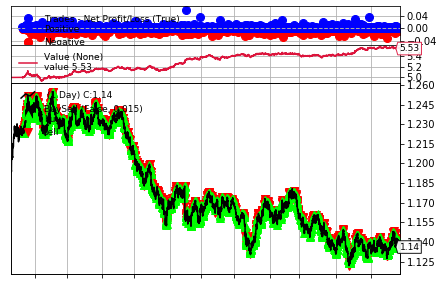

In [24]:
cerebro.plot(width=1000)[0][0]